In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import libraries and load datasets

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Analysis and transformation of the source data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [5]:
df_train.describe()

AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC           BD   ...  \
count  617.000000  617.000000  617.000000   617.000000    617.000000  ...   
mean     5.545576    0.060320   10.566447     8.053012   5350.388655  ...   
std      2.551696    0.416817    4.350645    65.166943   3021.326641  ...   
min      0.699861    0.025578    3.396778     1.229900   1693.624320  ...   
25%      4.128294    0.025578    8.129580     1.229900   4155.702870  ...   
50%      5.031912    0.025578   10.461320     1.229900   4997.960730  ...   
75%      6.431634    0.036845   12.969516     5.081244   6035.885700  ...   
max     38.270880   10.315851   38.971568  1463.693448  53060.599240  ...   

               FL           FR          FS          GB           GE  \
count  616.000000   617.000000  615.000000  617.000000   617.000000   
mean     5.433199     3.533905    0.421501   20.724856   131.714987   
std     11.496257    50.181948    1.305365    9.991907   144.181524   
min      0.173229     0.497060    0.067730    4.102182    72.611063   
25%      0.173229     0.497060    0.067730   14.036718    72.611063   
50%      3.028141     1.131000    0.250601   18.771436    72.611063   
75%      6.238814     1.512060    0.535067   25.608406   127.591671   
max    137.932739  1244.227020   31.365763  135.781294  1497.351958   

                  GF          GH          GI          GL       Class  
count     617.000000  617.000000  617.000000  616.000000  617.000000  
mean    14679.595398   31.489716   50.584437    8.530961    0.175041  
std     19352.959387    9.864239   36.266251   10.327010    0.380310  
min        13.038894    9.432735    0.897628    0.001129    0.000000  
25%      2798.992584   25.034888   23.011684    0.124392    0.000000  
50%      7838.273610   30.608946   41.007968    0.337827    0.000000  
75%     19035.709240   36.863947   67.931664   21.978000    0.000000  
max    143790.071200   81.210825  191.194764   21.978000    1.000000  

[8 rows x 56 columns]

In [6]:
# Removing spaces from column names 
df_train.columns = df_train.columns.str.replace(" ", "")

In [7]:
df_train.groupby('EJ')['EJ'].count()

EJ
A    222
B    395
Name: EJ, dtype: int64

In [8]:
# Creating a new column 'EJ'
df_train['EJ'] = df_train['EJ'].apply(lambda x: 1 if 'A' in x else 0)



In [9]:
df_train.groupby('Class').count()

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL   FR  \
Class                                                    ...                  
0      509  509  509  509  509  509  509  509  509  509  ...  509  508  509   
1      108  108  108  108  108  108  108  108  108  108  ...  108  108  108   

        FS   GB   GE   GF   GH   GI   GL  
Class                                     
0      508  509  509  509  509  509  508  
1      107  108  108  108  108  108  108  

[2 rows x 57 columns]

<AxesSubplot:xlabel='Class', ylabel='count'>

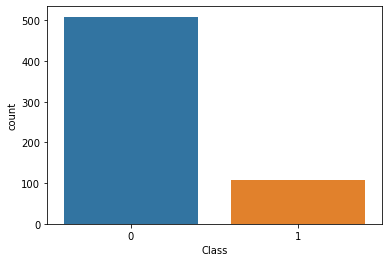

In [10]:
sns.countplot(x="Class", data=df_train)

Crucial observation: Based on the data, it is evident that the dataset exhibits a significant class imbalance, as the proportion of positive (1) samples is notably smaller in comparison to the negative (0) samples.

In [11]:
# We select only columns with numeric values
numeric_columns = df_train.select_dtypes(include=np.number)


# Fill NaN with the median value of the columns
df_train = df_train.fillna(numeric_columns.median())
#df_train = df_train.dropna()


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [13]:
df_train.head(100)

Id        AB          AF          AH         AM        AR  \
0   000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1   007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2   013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3   043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4   044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   
..           ...       ...         ...         ...        ...       ...   
95  2508534155a6  0.705045  4178.51962   85.200147  27.938037  8.138688   
96  26c79809c5ea  0.585401  3600.06097  123.241059  20.167664  8.138688   
97  271737344017  0.410208  4361.63739  193.444308  15.370411  8.138688   
98  273efaff6f8a  0.307656  1646.85598   85.200147  47.226153  9.502128   
99  27bfa971821f  0.170920  1549.40016   85.200147  14.487766  8.138688   

          AX        AY         AZ          BC  ...         FL        FR  \
0   0.699861  0.025578   9.812214    5.555634  ...   7.298162   1.73855   
1   3.632190  0.025578  13.517790    1.229900  ...   0.173229   0.49706   
2   6.732840  0.025578  12.824570    1.229900  ...   7.709560   0.97556   
3   3.685344  0.025578  11.053708    1.229900  ...   6.122162   0.49706   
4   3.942255  0.054810   3.396778  102.151980  ...   8.153058  48.50134   
..       ...       ...        ...         ...  ...        ...       ...   
95  4.907886  0.025578  12.043122    1.229900  ...   0.173229   1.56832   
96  4.987617  0.025578  17.380916    1.229900  ...  10.606909   2.25417   
97  4.739565  0.042935   9.566436    2.530080  ...   3.990570   1.69882   
98  8.354037  0.025578   6.257886    1.229900  ...   0.173229   0.49706   
99  5.767209  0.049938   9.560134    5.896492  ...   0.173229   2.00970   

          FS         GB          GE            GF         GH          GI  \
0   0.094822  11.339138   72.611063   2003.810319  22.136229   69.834944   
1   0.568932   9.292698   72.611063  27981.562750  29.135430   32.131996   
2   1.198821  37.077772   88.609437  13676.957810  28.022851   35.192676   
3   0.284466  18.529584   82.416803   2094.262452  39.948656   90.493248   
4   0.121914  16.408728  146.109943   8524.370502  45.381316   36.262628   
..       ...        ...         ...           ...        ...         ...   
95  0.230282  32.882570   74.382280  23374.537900  24.990236   60.989836   
96  0.846625  24.920058   95.259231   4654.334034  39.423995   29.526560   
97  0.101595  16.278500  121.761230   1803.702006  23.929751   24.899532   
98  0.067730  20.259756   72.611063  32123.399580  25.496292   67.388972   
99  0.717938  19.887676  281.460074  14301.991480  26.809805  101.938648   

           GL  Class  
0    0.120343      1  
1   21.978000      0  
2    0.196941      0  
3    0.155829      0  
4    0.096614      1  
..        ...    ...  
95  21.978000      1  
96   0.067762      1  
97   0.183150      0  
98  21.978000      0  
99  21.978000      0  

[100 rows x 58 columns]

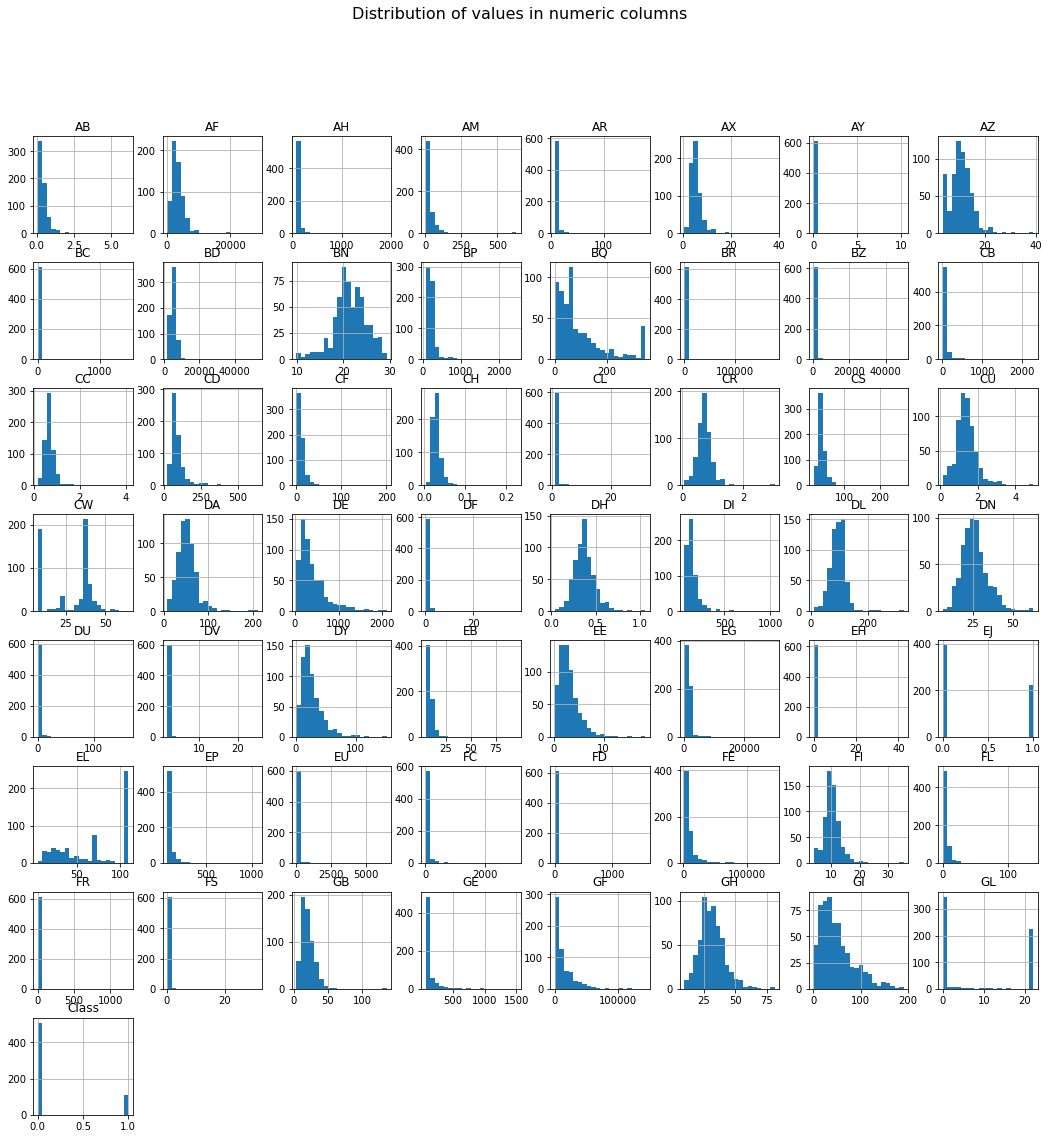

In [14]:
numeric_columns = df_train.select_dtypes(include='number')

# Plot histograms for each numeric column
numeric_columns.hist(bins=20, figsize=(18, 18))
plt.suptitle("Distribution of values in numeric columns", fontsize=16)
plt.show()

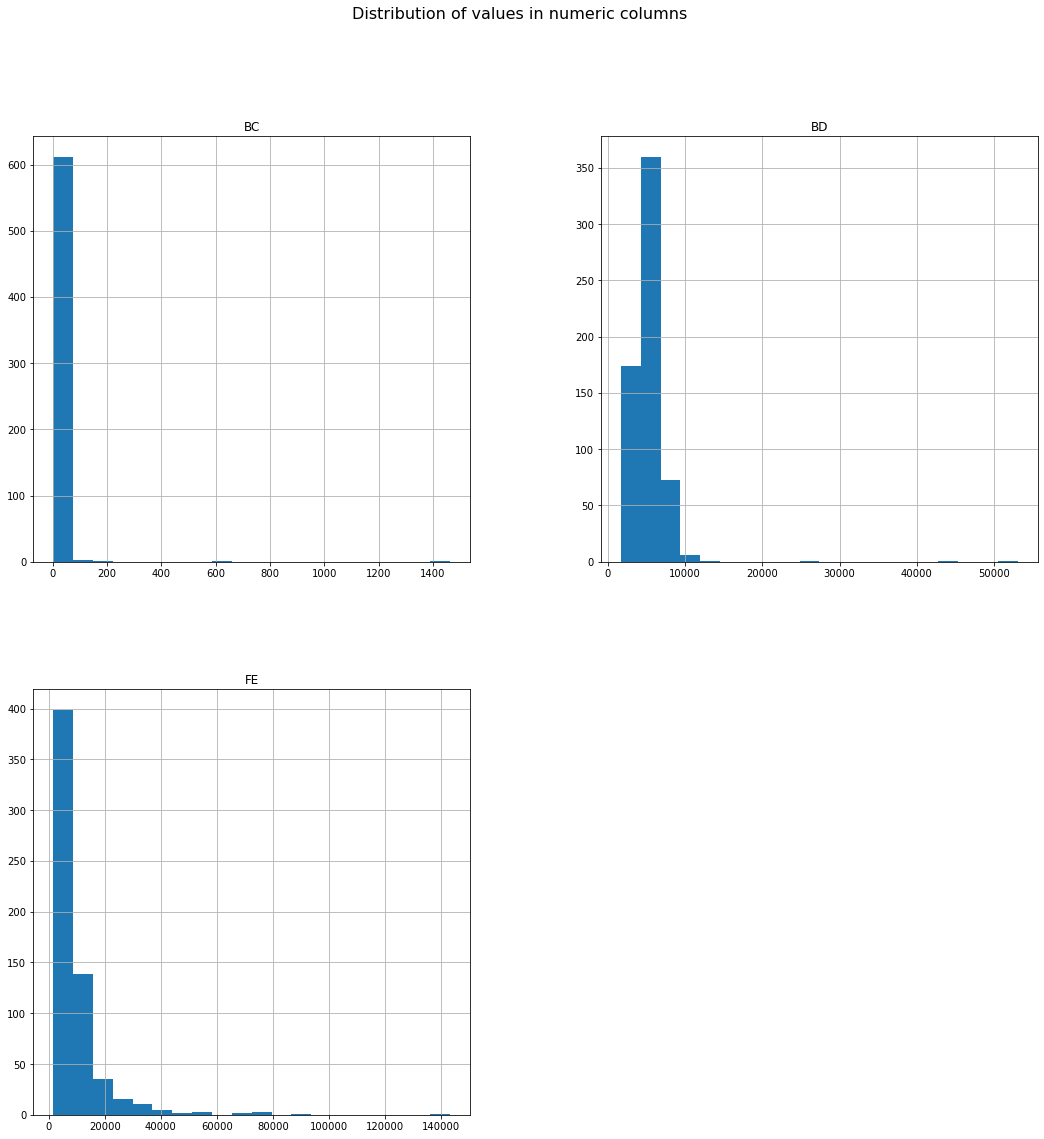

In [15]:
numeric_columns = df_train[['BC',  'BD','FE']]

# Plot histograms for each numeric column
numeric_columns.hist(bins=20, figsize=(18, 18))
plt.suptitle("Distribution of values in numeric columns", fontsize=16)
plt.show()

In [16]:
print(round(df_train[['BC',  'BD','FE']].min()))
print('----------------------------')
print(round(df_train[['BC', 'BD','FE']].max()))


BC       1.0
BD    1694.0
FE    1563.0
dtype: float64
----------------------------
BC      1464.0
BD     53061.0
FE    143225.0
dtype: float64


In [17]:
df_train = df_train[df_train['FE'] !=df_train['FE'].max()]

## Metrics - a balanced logarithmic loss¶

In [18]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    w_0 = 1 / N_0
    w_1 = 1 / N_1

    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1

    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))

    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)

    return balanced_log_loss/(N_0+N_1)

## Data Modeling

In [19]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(df_train['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.85


In [20]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

In [21]:
#without BR & FD & BC
X = df_train[['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ','BC', 'BD', 'BN',
       'BP', 'BQ', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FE', 'FI',
       'FL', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']].copy()

In [22]:
# Create the StandardScaler object
scaler = StandardScaler()

# Fit and transform the data to the [0, 1] range
X = scaler.fit_transform(X)


In [23]:
Y = df_train['Class'] 

In [24]:
# Using SMOTE to handle class imbalance
smote = SMOTE(random_state=88)
X_resampled, Y_resampled = smote.fit_resample(X, Y)



In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=88)


In [26]:
# Create and train the XGBoost Classifier

xgb = XGBClassifier(random_state=88)
model = xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)
#Make predictions on the test set and print classification report
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print('-----------------------------')
# Calculate the balanced logarithmic loss
balanced_logloss = log_loss(y_test, y_pred_proba)

print("Balanced Logarithmic Loss:", balanced_logloss)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        90
           1       0.97      0.99      0.98       114

    accuracy                           0.98       204
   macro avg       0.98      0.97      0.98       204
weighted avg       0.98      0.98      0.98       204

-----------------------------
Balanced Logarithmic Loss: 0.0673622451532163


In [27]:
# Create and train the LogReg Classifier

lr = LogisticRegression()

model = lr.fit(X_train, y_train)
# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)
#Make predictions on the test set and print classification report
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print('-----------------------------')
# Calculate the balanced logarithmic loss
balanced_logloss = log_loss(y_test, y_pred_proba)

print("Balanced Logarithmic Loss:", balanced_logloss)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        90
           1       0.94      0.93      0.93       114

    accuracy                           0.93       204
   macro avg       0.93      0.93      0.93       204
weighted avg       0.93      0.93      0.93       204

-----------------------------
Balanced Logarithmic Loss: 0.20379088117617922


In [28]:
# Create a CatBoost dataset
train_dataset = Pool(data=X_train, label=y_train)
test_dataset = Pool(data=X_test, label=y_test)

#Define and train the CatBoost model
model = CatBoostClassifier(random_state=88)

model.fit(train_dataset, eval_set=test_dataset, verbose=10)


Learning rate set to 0.0301
0:	learn: 0.6582647	test: 0.6584959	best: 0.6584959 (0)	total: 149ms	remaining: 2m 28s
10:	learn: 0.4328517	test: 0.4288621	best: 0.4288621 (10)	total: 191ms	remaining: 17.2s
20:	learn: 0.3195230	test: 0.3180889	best: 0.3180889 (20)	total: 232ms	remaining: 10.8s
30:	learn: 0.2478584	test: 0.2513483	best: 0.2513483 (30)	total: 272ms	remaining: 8.5s
40:	learn: 0.2014157	test: 0.2086220	best: 0.2086220 (40)	total: 310ms	remaining: 7.24s
50:	learn: 0.1710665	test: 0.1842379	best: 0.1842379 (50)	total: 348ms	remaining: 6.47s
60:	learn: 0.1476505	test: 0.1653259	best: 0.1653259 (60)	total: 388ms	remaining: 5.98s
70:	learn: 0.1297843	test: 0.1531984	best: 0.1531984 (70)	total: 428ms	remaining: 5.59s
80:	learn: 0.1142594	test: 0.1407184	best: 0.1407184 (80)	total: 473ms	remaining: 5.37s
90:	learn: 0.1010842	test: 0.1313139	best: 0.1313139 (90)	total: 512ms	remaining: 5.12s
100:	learn: 0.0903175	test: 0.1247834	best: 0.1247834 (100)	total: 550ms	remaining: 4.9s
110:	

930:	learn: 0.0024105	test: 0.0645091	best: 0.0642248 (890)	total: 4.04s	remaining: 299ms
940:	learn: 0.0023751	test: 0.0649034	best: 0.0642248 (890)	total: 4.08s	remaining: 256ms
950:	learn: 0.0023576	test: 0.0650289	best: 0.0642248 (890)	total: 4.12s	remaining: 213ms
960:	learn: 0.0023377	test: 0.0649385	best: 0.0642248 (890)	total: 4.17s	remaining: 169ms
970:	learn: 0.0023209	test: 0.0649569	best: 0.0642248 (890)	total: 4.21s	remaining: 126ms
980:	learn: 0.0023054	test: 0.0649184	best: 0.0642248 (890)	total: 4.25s	remaining: 82.2ms
990:	learn: 0.0022842	test: 0.0648513	best: 0.0642248 (890)	total: 4.29s	remaining: 38.9ms
999:	learn: 0.0022654	test: 0.0649224	best: 0.0642248 (890)	total: 4.32s	remaining: 0us

bestTest = 0.06422479674
bestIteration = 890

Shrink model to first 891 iterations.


In [29]:
# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)
#Make predictions on the test set and print classification report
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print('-----------------------------')
# Calculate the balanced logarithmic loss
balanced_logloss = log_loss(y_test, y_pred_proba)

print("Balanced Logarithmic Loss:", balanced_logloss)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        90
           1       0.97      0.99      0.98       114

    accuracy                           0.98       204
   macro avg       0.98      0.97      0.98       204
weighted avg       0.98      0.98      0.98       204

-----------------------------
Balanced Logarithmic Loss: 0.06422479674022108


# Optimizing a model through Grid search

In [30]:
import xgboost as xgb
from xgboost import XGBClassifier

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Define the XGBoost model
model = xgb.XGBClassifier(seed=88)

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.1, 0.5],
    'max_depth': [6],
    'n_estimators': [500,600],
    'subsample': [0.8, 1.0],               # Added subsample values to tune
    'colsample_bytree': [0.8, 1.0],        # Added colsample_bytree values to tune
}

# Perform grid search with cross-validation (5-fold cross-validation in this example)
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=10)

# Perform grid search
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set and print classification report
y_pred_proba = best_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print('-----------------------------')

# Calculate the balanced logarithmic loss
balanced_logloss = log_loss(y_test, y_pred_proba)

print("Balanced Logarithmic Loss:", balanced_logloss)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8
[CV 1/5; 1/16] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.963 total time=   0.2s
[CV 2/5; 1/16] START colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8
[CV 2/5; 1/16] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.945 total time=   0.1s
[CV 3/5; 1/16] START colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8
[CV 3/5; 1/16] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8;, score=0.944 total time=   0.1s
[CV 4/5; 1/16] START colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8
[CV 4/5; 1/16] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=500, subsam

[CV 4/5; 7/16] END colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8;, score=0.969 total time=   0.1s
[CV 5/5; 7/16] START colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8
[CV 5/5; 7/16] END colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8;, score=0.969 total time=   0.1s
[CV 1/5; 8/16] START colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=1.0
[CV 1/5; 8/16] END colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=1.0;, score=0.969 total time=   0.1s
[CV 2/5; 8/16] START colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=1.0
[CV 2/5; 8/16] END colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=1.0;, score=0.963 total time=   0.1s
[CV 3/5; 8/16] START colsample_bytree=0.8, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=1.0
[CV 3/5; 8/16] END c

[CV 4/5; 14/16] END colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=500, subsample=1.0;, score=0.944 total time=   0.1s
[CV 5/5; 14/16] START colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=500, subsample=1.0
[CV 5/5; 14/16] END colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=500, subsample=1.0;, score=0.969 total time=   0.1s
[CV 1/5; 15/16] START colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8
[CV 1/5; 15/16] END colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8;, score=0.982 total time=   0.1s
[CV 2/5; 15/16] START colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8
[CV 2/5; 15/16] END colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8;, score=0.945 total time=   0.1s
[CV 3/5; 15/16] START colsample_bytree=1.0, learning_rate=0.5, max_depth=6, n_estimators=600, subsample=0.8
[CV 3/5; 15/

In [31]:
# Create a CatBoost dataset
train_dataset = Pool(data=X_train, label=y_train)
test_dataset = Pool(data=X_test, label=y_test)

# Convert CatBoost dataset to NumPy arrays
X_train_numpy = train_dataset.get_features()
X_test_numpy = test_dataset.get_features()
y_train_numpy = train_dataset.get_label()
y_test_numpy = test_dataset.get_label()

# Define the CatBoost model
model = CatBoostClassifier(random_state=88)

# Define hyperparameters to tune
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8],
    'iterations': [500, 900],
}

# Perform grid search with cross-validation (5-fold cross-validation in this example)
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=10)

# Perform grid search
grid_search.fit(X_train_numpy, y_train_numpy, eval_set=(X_test_numpy, y_test_numpy))

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set and print classification report
y_pred_proba = best_model.predict_proba(X_test_numpy)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Classification Report:")
print(classification_report(y_test_numpy, y_pred))
print('-----------------------------')

# Calculate the balanced logarithmic loss
balanced_logloss = log_loss(y_test_numpy, y_pred_proba)

print("Balanced Logarithmic Loss:", balanced_logloss)

# Print the best hyperparameters found during grid search
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START depth=6, iterations=500, learning_rate=0.01................
0:	learn: 0.6824422	test: 0.6824903	best: 0.6824903 (0)	total: 4.22ms	remaining: 2.1s
1:	learn: 0.6720736	test: 0.6722075	best: 0.6722075 (1)	total: 7.99ms	remaining: 1.99s
2:	learn: 0.6607607	test: 0.6607454	best: 0.6607454 (2)	total: 11.7ms	remaining: 1.94s
3:	learn: 0.6500373	test: 0.6502765	best: 0.6502765 (3)	total: 15.5ms	remaining: 1.93s
4:	learn: 0.6432035	test: 0.6425034	best: 0.6425034 (4)	total: 19.3ms	remaining: 1.91s
5:	learn: 0.6330824	test: 0.6315961	best: 0.6315961 (5)	total: 23.1ms	remaining: 1.9s
6:	learn: 0.6240604	test: 0.6229150	best: 0.6229150 (6)	total: 26.9ms	remaining: 1.9s
7:	learn: 0.6171848	test: 0.6156925	best: 0.6156925 (7)	total: 30.8ms	remaining: 1.9s
8:	learn: 0.6094686	test: 0.6079877	best: 0.6079877 (8)	total: 34.9ms	remaining: 1.9s
9:	learn: 0.6002944	test: 0.5982674	best: 0.5982674 (9)	total: 38.7ms	remaining:

128:	learn: 0.2054122	test: 0.2095184	best: 0.2095184 (128)	total: 501ms	remaining: 1.44s
129:	learn: 0.2043759	test: 0.2086234	best: 0.2086234 (129)	total: 506ms	remaining: 1.44s
130:	learn: 0.2036296	test: 0.2080704	best: 0.2080704 (130)	total: 510ms	remaining: 1.44s
131:	learn: 0.2023864	test: 0.2067238	best: 0.2067238 (131)	total: 519ms	remaining: 1.45s
132:	learn: 0.2012891	test: 0.2057086	best: 0.2057086 (132)	total: 523ms	remaining: 1.44s
133:	learn: 0.1998119	test: 0.2043179	best: 0.2043179 (133)	total: 527ms	remaining: 1.44s
134:	learn: 0.1988898	test: 0.2037973	best: 0.2037973 (134)	total: 532ms	remaining: 1.44s
135:	learn: 0.1975538	test: 0.2029155	best: 0.2029155 (135)	total: 538ms	remaining: 1.44s
136:	learn: 0.1963704	test: 0.2018873	best: 0.2018873 (136)	total: 542ms	remaining: 1.44s
137:	learn: 0.1949567	test: 0.2006468	best: 0.2006468 (137)	total: 547ms	remaining: 1.43s
138:	learn: 0.1943123	test: 0.2002246	best: 0.2002246 (138)	total: 552ms	remaining: 1.43s
139:	learn

260:	learn: 0.1102042	test: 0.1348394	best: 0.1348394 (260)	total: 1.05s	remaining: 966ms
261:	learn: 0.1099462	test: 0.1346335	best: 0.1346335 (261)	total: 1.06s	remaining: 962ms
262:	learn: 0.1097018	test: 0.1344737	best: 0.1344737 (262)	total: 1.06s	remaining: 958ms
263:	learn: 0.1092099	test: 0.1340853	best: 0.1340853 (263)	total: 1.07s	remaining: 954ms
264:	learn: 0.1088117	test: 0.1338045	best: 0.1338045 (264)	total: 1.07s	remaining: 950ms
265:	learn: 0.1084409	test: 0.1335751	best: 0.1335751 (265)	total: 1.07s	remaining: 946ms
266:	learn: 0.1080283	test: 0.1331654	best: 0.1331654 (266)	total: 1.08s	remaining: 941ms
267:	learn: 0.1075451	test: 0.1326422	best: 0.1326422 (267)	total: 1.08s	remaining: 937ms
268:	learn: 0.1071079	test: 0.1323419	best: 0.1323419 (268)	total: 1.09s	remaining: 933ms
269:	learn: 0.1066717	test: 0.1320187	best: 0.1320187 (269)	total: 1.09s	remaining: 929ms
270:	learn: 0.1062341	test: 0.1319129	best: 0.1319129 (270)	total: 1.09s	remaining: 925ms
271:	learn

398:	learn: 0.0676208	test: 0.1042288	best: 0.1042288 (398)	total: 1.6s	remaining: 405ms
399:	learn: 0.0673518	test: 0.1039416	best: 0.1039416 (399)	total: 1.6s	remaining: 401ms
400:	learn: 0.0671376	test: 0.1038835	best: 0.1038835 (400)	total: 1.61s	remaining: 397ms
401:	learn: 0.0668830	test: 0.1037066	best: 0.1037066 (401)	total: 1.61s	remaining: 393ms
402:	learn: 0.0665285	test: 0.1034302	best: 0.1034302 (402)	total: 1.62s	remaining: 389ms
403:	learn: 0.0662469	test: 0.1033754	best: 0.1033754 (403)	total: 1.62s	remaining: 385ms
404:	learn: 0.0660598	test: 0.1032330	best: 0.1032330 (404)	total: 1.63s	remaining: 381ms
405:	learn: 0.0658416	test: 0.1030886	best: 0.1030886 (405)	total: 1.63s	remaining: 377ms
406:	learn: 0.0655478	test: 0.1028940	best: 0.1028940 (406)	total: 1.63s	remaining: 373ms
407:	learn: 0.0654069	test: 0.1028513	best: 0.1028513 (407)	total: 1.64s	remaining: 369ms
408:	learn: 0.0652786	test: 0.1027391	best: 0.1027391 (408)	total: 1.64s	remaining: 365ms
409:	learn: 

492:	learn: 0.0500337	test: 0.0908285	best: 0.0908285 (492)	total: 1.96s	remaining: 27.8ms
493:	learn: 0.0499032	test: 0.0907018	best: 0.0907018 (493)	total: 1.96s	remaining: 23.8ms
494:	learn: 0.0496812	test: 0.0905075	best: 0.0905075 (494)	total: 1.97s	remaining: 19.9ms
495:	learn: 0.0495710	test: 0.0904210	best: 0.0904210 (495)	total: 1.97s	remaining: 15.9ms
496:	learn: 0.0494700	test: 0.0903595	best: 0.0903595 (496)	total: 1.98s	remaining: 11.9ms
497:	learn: 0.0493207	test: 0.0902909	best: 0.0902909 (497)	total: 1.98s	remaining: 7.95ms
498:	learn: 0.0492152	test: 0.0901838	best: 0.0901838 (498)	total: 1.98s	remaining: 3.97ms
499:	learn: 0.0491200	test: 0.0900922	best: 0.0900922 (499)	total: 1.99s	remaining: 0us

bestTest = 0.09009224099
bestIteration = 499

[CV 1/5; 1/12] END depth=6, iterations=500, learning_rate=0.01;, score=0.963 total time=   2.1s
[CV 2/5; 1/12] START depth=6, iterations=500, learning_rate=0.01................
0:	learn: 0.6826656	test: 0.6821961	best: 0.6821961

114:	learn: 0.2120492	test: 0.2266879	best: 0.2266879 (114)	total: 456ms	remaining: 1.53s
115:	learn: 0.2107407	test: 0.2254856	best: 0.2254856 (115)	total: 460ms	remaining: 1.52s
116:	learn: 0.2092448	test: 0.2238264	best: 0.2238264 (116)	total: 465ms	remaining: 1.52s
117:	learn: 0.2083843	test: 0.2232543	best: 0.2232543 (117)	total: 469ms	remaining: 1.52s
118:	learn: 0.2068356	test: 0.2218272	best: 0.2218272 (118)	total: 473ms	remaining: 1.51s
119:	learn: 0.2056967	test: 0.2210980	best: 0.2210980 (119)	total: 477ms	remaining: 1.51s
120:	learn: 0.2040566	test: 0.2200230	best: 0.2200230 (120)	total: 481ms	remaining: 1.5s
121:	learn: 0.2029338	test: 0.2190120	best: 0.2190120 (121)	total: 484ms	remaining: 1.5s
122:	learn: 0.2019569	test: 0.2183173	best: 0.2183173 (122)	total: 488ms	remaining: 1.5s
123:	learn: 0.2000886	test: 0.2167544	best: 0.2167544 (123)	total: 492ms	remaining: 1.49s
124:	learn: 0.1986071	test: 0.2155769	best: 0.2155769 (124)	total: 495ms	remaining: 1.49s
125:	learn: 0

253:	learn: 0.1056683	test: 0.1409260	best: 0.1409260 (253)	total: 995ms	remaining: 964ms
254:	learn: 0.1050631	test: 0.1404557	best: 0.1404557 (254)	total: 999ms	remaining: 960ms
255:	learn: 0.1047695	test: 0.1401924	best: 0.1401924 (255)	total: 1s	remaining: 957ms
256:	learn: 0.1042074	test: 0.1396767	best: 0.1396767 (256)	total: 1.01s	remaining: 953ms
257:	learn: 0.1036047	test: 0.1393641	best: 0.1393641 (257)	total: 1.01s	remaining: 949ms
258:	learn: 0.1030708	test: 0.1390159	best: 0.1390159 (258)	total: 1.01s	remaining: 945ms
259:	learn: 0.1026740	test: 0.1386333	best: 0.1386333 (259)	total: 1.02s	remaining: 941ms
260:	learn: 0.1023939	test: 0.1383304	best: 0.1383304 (260)	total: 1.02s	remaining: 936ms
261:	learn: 0.1020335	test: 0.1379693	best: 0.1379693 (261)	total: 1.03s	remaining: 932ms
262:	learn: 0.1017366	test: 0.1377228	best: 0.1377228 (262)	total: 1.03s	remaining: 928ms
263:	learn: 0.1013171	test: 0.1375259	best: 0.1375259 (263)	total: 1.03s	remaining: 924ms
264:	learn: 0

351:	learn: 0.0729837	test: 0.1160932	best: 0.1160932 (351)	total: 1.37s	remaining: 577ms
352:	learn: 0.0726671	test: 0.1158393	best: 0.1158393 (352)	total: 1.38s	remaining: 574ms
353:	learn: 0.0724563	test: 0.1155419	best: 0.1155419 (353)	total: 1.38s	remaining: 570ms
354:	learn: 0.0721766	test: 0.1153468	best: 0.1153468 (354)	total: 1.39s	remaining: 566ms
355:	learn: 0.0719033	test: 0.1151459	best: 0.1151459 (355)	total: 1.39s	remaining: 562ms
356:	learn: 0.0716966	test: 0.1150862	best: 0.1150862 (356)	total: 1.39s	remaining: 558ms
357:	learn: 0.0714127	test: 0.1149753	best: 0.1149753 (357)	total: 1.4s	remaining: 554ms
358:	learn: 0.0711286	test: 0.1148122	best: 0.1148122 (358)	total: 1.4s	remaining: 550ms
359:	learn: 0.0707781	test: 0.1145546	best: 0.1145546 (359)	total: 1.4s	remaining: 546ms
360:	learn: 0.0706087	test: 0.1144642	best: 0.1144642 (360)	total: 1.41s	remaining: 542ms
361:	learn: 0.0703999	test: 0.1142887	best: 0.1142887 (361)	total: 1.41s	remaining: 538ms
362:	learn: 0

488:	learn: 0.0470117	test: 0.0967803	best: 0.0967803 (488)	total: 1.91s	remaining: 42.9ms
489:	learn: 0.0468986	test: 0.0966312	best: 0.0966312 (489)	total: 1.91s	remaining: 39ms
490:	learn: 0.0467885	test: 0.0964603	best: 0.0964603 (490)	total: 1.92s	remaining: 35.1ms
491:	learn: 0.0466495	test: 0.0963100	best: 0.0963100 (491)	total: 1.92s	remaining: 31.2ms
492:	learn: 0.0465065	test: 0.0960930	best: 0.0960930 (492)	total: 1.92s	remaining: 27.3ms
493:	learn: 0.0463263	test: 0.0960968	best: 0.0960930 (492)	total: 1.93s	remaining: 23.4ms
494:	learn: 0.0461269	test: 0.0959153	best: 0.0959153 (494)	total: 1.93s	remaining: 19.5ms
495:	learn: 0.0460208	test: 0.0958160	best: 0.0958160 (495)	total: 1.94s	remaining: 15.6ms
496:	learn: 0.0458926	test: 0.0957737	best: 0.0957737 (496)	total: 1.94s	remaining: 11.7ms
497:	learn: 0.0457576	test: 0.0956319	best: 0.0956319 (497)	total: 1.94s	remaining: 7.81ms
498:	learn: 0.0456541	test: 0.0955752	best: 0.0955752 (498)	total: 1.95s	remaining: 3.9ms
49

107:	learn: 0.2199841	test: 0.2333528	best: 0.2333528 (107)	total: 441ms	remaining: 1.6s
108:	learn: 0.2187537	test: 0.2325999	best: 0.2325999 (108)	total: 445ms	remaining: 1.6s
109:	learn: 0.2171774	test: 0.2307259	best: 0.2307259 (109)	total: 450ms	remaining: 1.59s
110:	learn: 0.2157292	test: 0.2295119	best: 0.2295119 (110)	total: 454ms	remaining: 1.59s
111:	learn: 0.2141136	test: 0.2280455	best: 0.2280455 (111)	total: 457ms	remaining: 1.58s
112:	learn: 0.2126163	test: 0.2265977	best: 0.2265977 (112)	total: 461ms	remaining: 1.58s
113:	learn: 0.2110226	test: 0.2249955	best: 0.2249955 (113)	total: 465ms	remaining: 1.57s
114:	learn: 0.2097967	test: 0.2241981	best: 0.2241981 (114)	total: 468ms	remaining: 1.57s
115:	learn: 0.2086875	test: 0.2228742	best: 0.2228742 (115)	total: 472ms	remaining: 1.56s
116:	learn: 0.2072579	test: 0.2215422	best: 0.2215422 (116)	total: 476ms	remaining: 1.56s
117:	learn: 0.2062168	test: 0.2210067	best: 0.2210067 (117)	total: 480ms	remaining: 1.55s
118:	learn: 

204:	learn: 0.1291084	test: 0.1595414	best: 0.1595414 (204)	total: 815ms	remaining: 1.17s
205:	learn: 0.1286851	test: 0.1591570	best: 0.1591570 (205)	total: 820ms	remaining: 1.17s
206:	learn: 0.1278814	test: 0.1583103	best: 0.1583103 (206)	total: 824ms	remaining: 1.17s
207:	learn: 0.1274174	test: 0.1577364	best: 0.1577364 (207)	total: 828ms	remaining: 1.16s
208:	learn: 0.1267068	test: 0.1574912	best: 0.1574912 (208)	total: 831ms	remaining: 1.16s
209:	learn: 0.1262554	test: 0.1571167	best: 0.1571167 (209)	total: 836ms	remaining: 1.15s
210:	learn: 0.1258214	test: 0.1565753	best: 0.1565753 (210)	total: 839ms	remaining: 1.15s
211:	learn: 0.1250956	test: 0.1559505	best: 0.1559505 (211)	total: 843ms	remaining: 1.15s
212:	learn: 0.1246369	test: 0.1553859	best: 0.1553859 (212)	total: 847ms	remaining: 1.14s
213:	learn: 0.1241253	test: 0.1547710	best: 0.1547710 (213)	total: 851ms	remaining: 1.14s
214:	learn: 0.1234776	test: 0.1543267	best: 0.1543267 (214)	total: 854ms	remaining: 1.13s
215:	learn

342:	learn: 0.0724698	test: 0.1166819	best: 0.1166819 (342)	total: 1.35s	remaining: 619ms
343:	learn: 0.0722694	test: 0.1165435	best: 0.1165435 (343)	total: 1.36s	remaining: 615ms
344:	learn: 0.0719481	test: 0.1162937	best: 0.1162937 (344)	total: 1.36s	remaining: 612ms
345:	learn: 0.0717213	test: 0.1162118	best: 0.1162118 (345)	total: 1.36s	remaining: 608ms
346:	learn: 0.0714239	test: 0.1159139	best: 0.1159139 (346)	total: 1.37s	remaining: 604ms
347:	learn: 0.0711879	test: 0.1156722	best: 0.1156722 (347)	total: 1.37s	remaining: 600ms
348:	learn: 0.0709082	test: 0.1153672	best: 0.1153672 (348)	total: 1.38s	remaining: 595ms
349:	learn: 0.0707008	test: 0.1153490	best: 0.1153490 (349)	total: 1.38s	remaining: 592ms
350:	learn: 0.0704286	test: 0.1152484	best: 0.1152484 (350)	total: 1.39s	remaining: 588ms
351:	learn: 0.0701781	test: 0.1150176	best: 0.1150176 (351)	total: 1.39s	remaining: 584ms
352:	learn: 0.0699410	test: 0.1147764	best: 0.1147764 (352)	total: 1.39s	remaining: 580ms
353:	learn

435:	learn: 0.0530636	test: 0.1021454	best: 0.1021454 (435)	total: 1.71s	remaining: 251ms
436:	learn: 0.0529350	test: 0.1021307	best: 0.1021307 (436)	total: 1.72s	remaining: 247ms
437:	learn: 0.0527759	test: 0.1020723	best: 0.1020723 (437)	total: 1.72s	remaining: 244ms
438:	learn: 0.0526131	test: 0.1019978	best: 0.1019978 (438)	total: 1.72s	remaining: 240ms
439:	learn: 0.0524836	test: 0.1017990	best: 0.1017990 (439)	total: 1.73s	remaining: 236ms
440:	learn: 0.0523936	test: 0.1017391	best: 0.1017391 (440)	total: 1.73s	remaining: 232ms
441:	learn: 0.0522440	test: 0.1016708	best: 0.1016708 (441)	total: 1.74s	remaining: 228ms
442:	learn: 0.0520690	test: 0.1014537	best: 0.1014537 (442)	total: 1.74s	remaining: 224ms
443:	learn: 0.0518515	test: 0.1012947	best: 0.1012947 (443)	total: 1.74s	remaining: 220ms
444:	learn: 0.0516548	test: 0.1011437	best: 0.1011437 (444)	total: 1.75s	remaining: 216ms
445:	learn: 0.0514818	test: 0.1010323	best: 0.1010323 (445)	total: 1.75s	remaining: 212ms
446:	learn

57:	learn: 0.3373316	test: 0.3335253	best: 0.3335253 (57)	total: 237ms	remaining: 1.81s
58:	learn: 0.3328914	test: 0.3293553	best: 0.3293553 (58)	total: 242ms	remaining: 1.81s
59:	learn: 0.3298625	test: 0.3264677	best: 0.3264677 (59)	total: 246ms	remaining: 1.81s
60:	learn: 0.3266759	test: 0.3235636	best: 0.3235636 (60)	total: 251ms	remaining: 1.8s
61:	learn: 0.3229084	test: 0.3197791	best: 0.3197791 (61)	total: 255ms	remaining: 1.8s
62:	learn: 0.3197200	test: 0.3167025	best: 0.3167025 (62)	total: 259ms	remaining: 1.8s
63:	learn: 0.3166414	test: 0.3140913	best: 0.3140913 (63)	total: 263ms	remaining: 1.79s
64:	learn: 0.3140322	test: 0.3114387	best: 0.3114387 (64)	total: 267ms	remaining: 1.79s
65:	learn: 0.3117884	test: 0.3094654	best: 0.3094654 (65)	total: 272ms	remaining: 1.78s
66:	learn: 0.3088925	test: 0.3066665	best: 0.3066665 (66)	total: 276ms	remaining: 1.78s
67:	learn: 0.3058108	test: 0.3037120	best: 0.3037120 (67)	total: 280ms	remaining: 1.78s
68:	learn: 0.3025621	test: 0.300779

194:	learn: 0.1376431	test: 0.1608296	best: 0.1608296 (194)	total: 765ms	remaining: 1.2s
195:	learn: 0.1373037	test: 0.1606264	best: 0.1606264 (195)	total: 770ms	remaining: 1.19s
196:	learn: 0.1366090	test: 0.1603874	best: 0.1603874 (196)	total: 775ms	remaining: 1.19s
197:	learn: 0.1358596	test: 0.1597940	best: 0.1597940 (197)	total: 779ms	remaining: 1.19s
198:	learn: 0.1352836	test: 0.1595471	best: 0.1595471 (198)	total: 783ms	remaining: 1.18s
199:	learn: 0.1344871	test: 0.1587938	best: 0.1587938 (199)	total: 787ms	remaining: 1.18s
200:	learn: 0.1337779	test: 0.1582733	best: 0.1582733 (200)	total: 792ms	remaining: 1.18s
201:	learn: 0.1332821	test: 0.1577892	best: 0.1577892 (201)	total: 796ms	remaining: 1.17s
202:	learn: 0.1326583	test: 0.1574024	best: 0.1574024 (202)	total: 800ms	remaining: 1.17s
203:	learn: 0.1321382	test: 0.1573015	best: 0.1573015 (203)	total: 804ms	remaining: 1.17s
204:	learn: 0.1315766	test: 0.1569757	best: 0.1569757 (204)	total: 807ms	remaining: 1.16s
205:	learn:

295:	learn: 0.0898925	test: 0.1251306	best: 0.1251306 (295)	total: 1.14s	remaining: 789ms
296:	learn: 0.0895393	test: 0.1250087	best: 0.1250087 (296)	total: 1.15s	remaining: 785ms
297:	learn: 0.0892786	test: 0.1248292	best: 0.1248292 (297)	total: 1.15s	remaining: 781ms
298:	learn: 0.0889608	test: 0.1245168	best: 0.1245168 (298)	total: 1.16s	remaining: 777ms
299:	learn: 0.0884335	test: 0.1239044	best: 0.1239044 (299)	total: 1.16s	remaining: 773ms
300:	learn: 0.0882065	test: 0.1238417	best: 0.1238417 (300)	total: 1.16s	remaining: 769ms
301:	learn: 0.0880110	test: 0.1237672	best: 0.1237672 (301)	total: 1.17s	remaining: 765ms
302:	learn: 0.0878119	test: 0.1236352	best: 0.1236352 (302)	total: 1.17s	remaining: 761ms
303:	learn: 0.0874541	test: 0.1234040	best: 0.1234040 (303)	total: 1.17s	remaining: 757ms
304:	learn: 0.0872090	test: 0.1232378	best: 0.1232378 (304)	total: 1.18s	remaining: 753ms
305:	learn: 0.0870075	test: 0.1231034	best: 0.1231034 (305)	total: 1.18s	remaining: 749ms
306:	learn

388:	learn: 0.0647266	test: 0.1064529	best: 0.1064529 (388)	total: 1.49s	remaining: 426ms
389:	learn: 0.0645678	test: 0.1062838	best: 0.1062838 (389)	total: 1.5s	remaining: 422ms
390:	learn: 0.0643163	test: 0.1061350	best: 0.1061350 (390)	total: 1.5s	remaining: 419ms
391:	learn: 0.0640959	test: 0.1060094	best: 0.1060094 (391)	total: 1.51s	remaining: 415ms
392:	learn: 0.0638532	test: 0.1058369	best: 0.1058369 (392)	total: 1.51s	remaining: 411ms
393:	learn: 0.0635011	test: 0.1055620	best: 0.1055620 (393)	total: 1.51s	remaining: 408ms
394:	learn: 0.0633541	test: 0.1054318	best: 0.1054318 (394)	total: 1.52s	remaining: 404ms
395:	learn: 0.0632313	test: 0.1053333	best: 0.1053333 (395)	total: 1.52s	remaining: 400ms
396:	learn: 0.0630767	test: 0.1053020	best: 0.1053020 (396)	total: 1.53s	remaining: 396ms
397:	learn: 0.0628648	test: 0.1050564	best: 0.1050564 (397)	total: 1.53s	remaining: 392ms
398:	learn: 0.0625531	test: 0.1048847	best: 0.1048847 (398)	total: 1.53s	remaining: 388ms
399:	learn: 

481:	learn: 0.0479408	test: 0.0936213	best: 0.0936171 (480)	total: 1.85s	remaining: 69.2ms
482:	learn: 0.0477634	test: 0.0935671	best: 0.0935671 (482)	total: 1.86s	remaining: 65.4ms
483:	learn: 0.0476573	test: 0.0934811	best: 0.0934811 (483)	total: 1.86s	remaining: 61.6ms
484:	learn: 0.0475403	test: 0.0933477	best: 0.0933477 (484)	total: 1.86s	remaining: 57.7ms
485:	learn: 0.0474133	test: 0.0934141	best: 0.0933477 (484)	total: 1.87s	remaining: 53.8ms
486:	learn: 0.0472884	test: 0.0932752	best: 0.0932752 (486)	total: 1.87s	remaining: 50ms
487:	learn: 0.0471565	test: 0.0932361	best: 0.0932361 (487)	total: 1.88s	remaining: 46.1ms
488:	learn: 0.0470486	test: 0.0931102	best: 0.0931102 (488)	total: 1.88s	remaining: 42.3ms
489:	learn: 0.0469430	test: 0.0930181	best: 0.0930181 (489)	total: 1.88s	remaining: 38.4ms
490:	learn: 0.0467369	test: 0.0930958	best: 0.0930181 (489)	total: 1.89s	remaining: 34.6ms
491:	learn: 0.0466215	test: 0.0930578	best: 0.0930181 (489)	total: 1.89s	remaining: 30.7ms
4

116:	learn: 0.2131986	test: 0.2194003	best: 0.2194003 (116)	total: 425ms	remaining: 1.39s
117:	learn: 0.2122261	test: 0.2187070	best: 0.2187070 (117)	total: 429ms	remaining: 1.39s
118:	learn: 0.2105379	test: 0.2172499	best: 0.2172499 (118)	total: 433ms	remaining: 1.39s
119:	learn: 0.2095390	test: 0.2165296	best: 0.2165296 (119)	total: 437ms	remaining: 1.38s
120:	learn: 0.2085308	test: 0.2157648	best: 0.2157648 (120)	total: 441ms	remaining: 1.38s
121:	learn: 0.2074228	test: 0.2149238	best: 0.2149238 (121)	total: 444ms	remaining: 1.38s
122:	learn: 0.2057780	test: 0.2137126	best: 0.2137126 (122)	total: 448ms	remaining: 1.37s
123:	learn: 0.2041720	test: 0.2124629	best: 0.2124629 (123)	total: 451ms	remaining: 1.37s
124:	learn: 0.2025841	test: 0.2109244	best: 0.2109244 (124)	total: 455ms	remaining: 1.36s
125:	learn: 0.2007023	test: 0.2093174	best: 0.2093174 (125)	total: 459ms	remaining: 1.36s
126:	learn: 0.1997549	test: 0.2084804	best: 0.2084804 (126)	total: 462ms	remaining: 1.36s
127:	learn

218:	learn: 0.1278426	test: 0.1485799	best: 0.1485799 (218)	total: 800ms	remaining: 1.03s
219:	learn: 0.1272451	test: 0.1481535	best: 0.1481535 (219)	total: 804ms	remaining: 1.02s
220:	learn: 0.1267082	test: 0.1479383	best: 0.1479383 (220)	total: 809ms	remaining: 1.02s
221:	learn: 0.1261354	test: 0.1477816	best: 0.1477816 (221)	total: 812ms	remaining: 1.02s
222:	learn: 0.1256251	test: 0.1474394	best: 0.1474394 (222)	total: 816ms	remaining: 1.01s
223:	learn: 0.1249934	test: 0.1471668	best: 0.1471668 (223)	total: 819ms	remaining: 1.01s
224:	learn: 0.1245740	test: 0.1469465	best: 0.1469465 (224)	total: 823ms	remaining: 1.01s
225:	learn: 0.1239197	test: 0.1462829	best: 0.1462829 (225)	total: 827ms	remaining: 1s
226:	learn: 0.1233939	test: 0.1459426	best: 0.1459426 (226)	total: 830ms	remaining: 998ms
227:	learn: 0.1229250	test: 0.1455054	best: 0.1455054 (227)	total: 834ms	remaining: 995ms
228:	learn: 0.1223110	test: 0.1449585	best: 0.1449585 (228)	total: 837ms	remaining: 991ms
229:	learn: 0

316:	learn: 0.0843844	test: 0.1172477	best: 0.1172477 (316)	total: 1.15s	remaining: 666ms
317:	learn: 0.0841117	test: 0.1171429	best: 0.1171429 (317)	total: 1.16s	remaining: 663ms
318:	learn: 0.0838482	test: 0.1169642	best: 0.1169642 (318)	total: 1.16s	remaining: 660ms
319:	learn: 0.0835996	test: 0.1167310	best: 0.1167310 (319)	total: 1.17s	remaining: 656ms
320:	learn: 0.0832043	test: 0.1164987	best: 0.1164987 (320)	total: 1.17s	remaining: 652ms
321:	learn: 0.0829010	test: 0.1162586	best: 0.1162586 (321)	total: 1.17s	remaining: 649ms
322:	learn: 0.0826661	test: 0.1160095	best: 0.1160095 (322)	total: 1.18s	remaining: 645ms
323:	learn: 0.0823724	test: 0.1158129	best: 0.1158129 (323)	total: 1.18s	remaining: 641ms
324:	learn: 0.0819572	test: 0.1155996	best: 0.1155996 (324)	total: 1.18s	remaining: 638ms
325:	learn: 0.0817454	test: 0.1154692	best: 0.1154692 (325)	total: 1.19s	remaining: 634ms
326:	learn: 0.0814753	test: 0.1152929	best: 0.1152929 (326)	total: 1.19s	remaining: 630ms
327:	learn

420:	learn: 0.0586591	test: 0.0987888	best: 0.0987888 (420)	total: 1.53s	remaining: 288ms
421:	learn: 0.0583945	test: 0.0985364	best: 0.0985364 (421)	total: 1.54s	remaining: 284ms
422:	learn: 0.0582482	test: 0.0984774	best: 0.0984774 (422)	total: 1.54s	remaining: 280ms
423:	learn: 0.0580280	test: 0.0983653	best: 0.0983653 (423)	total: 1.54s	remaining: 277ms
424:	learn: 0.0579091	test: 0.0982821	best: 0.0982821 (424)	total: 1.55s	remaining: 273ms
425:	learn: 0.0576898	test: 0.0980032	best: 0.0980032 (425)	total: 1.55s	remaining: 270ms
426:	learn: 0.0575068	test: 0.0978286	best: 0.0978286 (426)	total: 1.55s	remaining: 266ms
427:	learn: 0.0573760	test: 0.0977727	best: 0.0977727 (427)	total: 1.56s	remaining: 262ms
428:	learn: 0.0572625	test: 0.0976963	best: 0.0976963 (428)	total: 1.56s	remaining: 259ms
429:	learn: 0.0570665	test: 0.0975371	best: 0.0975371 (429)	total: 1.56s	remaining: 255ms
430:	learn: 0.0569043	test: 0.0973869	best: 0.0973869 (430)	total: 1.57s	remaining: 251ms
431:	learn

50:	learn: 0.1176239	test: 0.1509093	best: 0.1509093 (50)	total: 205ms	remaining: 1.8s
51:	learn: 0.1156398	test: 0.1484071	best: 0.1484071 (51)	total: 208ms	remaining: 1.79s
52:	learn: 0.1138411	test: 0.1468610	best: 0.1468610 (52)	total: 212ms	remaining: 1.79s
53:	learn: 0.1120212	test: 0.1465221	best: 0.1465221 (53)	total: 216ms	remaining: 1.78s
54:	learn: 0.1093306	test: 0.1443249	best: 0.1443249 (54)	total: 220ms	remaining: 1.78s
55:	learn: 0.1076036	test: 0.1429111	best: 0.1429111 (55)	total: 223ms	remaining: 1.77s
56:	learn: 0.1051742	test: 0.1411872	best: 0.1411872 (56)	total: 227ms	remaining: 1.76s
57:	learn: 0.1025649	test: 0.1388706	best: 0.1388706 (57)	total: 231ms	remaining: 1.76s
58:	learn: 0.0998303	test: 0.1372451	best: 0.1372451 (58)	total: 234ms	remaining: 1.75s
59:	learn: 0.0977491	test: 0.1350637	best: 0.1350637 (59)	total: 238ms	remaining: 1.74s
60:	learn: 0.0961595	test: 0.1334260	best: 0.1334260 (60)	total: 241ms	remaining: 1.74s
61:	learn: 0.0946464	test: 0.1324

151:	learn: 0.0251173	test: 0.0794143	best: 0.0792398 (148)	total: 573ms	remaining: 1.31s
152:	learn: 0.0248130	test: 0.0788657	best: 0.0788657 (152)	total: 577ms	remaining: 1.31s
153:	learn: 0.0245201	test: 0.0783905	best: 0.0783905 (153)	total: 581ms	remaining: 1.3s
154:	learn: 0.0241789	test: 0.0783576	best: 0.0783576 (154)	total: 585ms	remaining: 1.3s
155:	learn: 0.0238347	test: 0.0779843	best: 0.0779843 (155)	total: 588ms	remaining: 1.3s
156:	learn: 0.0236396	test: 0.0780381	best: 0.0779843 (155)	total: 592ms	remaining: 1.29s
157:	learn: 0.0232957	test: 0.0783409	best: 0.0779843 (155)	total: 596ms	remaining: 1.29s
158:	learn: 0.0228771	test: 0.0778902	best: 0.0778902 (158)	total: 599ms	remaining: 1.28s
159:	learn: 0.0226005	test: 0.0776530	best: 0.0776530 (159)	total: 603ms	remaining: 1.28s
160:	learn: 0.0222592	test: 0.0776700	best: 0.0776530 (159)	total: 606ms	remaining: 1.28s
161:	learn: 0.0219157	test: 0.0774448	best: 0.0774448 (161)	total: 610ms	remaining: 1.27s
162:	learn: 0

247:	learn: 0.0091375	test: 0.0720352	best: 0.0717681 (243)	total: 924ms	remaining: 939ms
248:	learn: 0.0090773	test: 0.0719646	best: 0.0717681 (243)	total: 930ms	remaining: 937ms
249:	learn: 0.0090134	test: 0.0720400	best: 0.0717681 (243)	total: 934ms	remaining: 934ms
250:	learn: 0.0089607	test: 0.0720626	best: 0.0717681 (243)	total: 938ms	remaining: 930ms
251:	learn: 0.0088765	test: 0.0722229	best: 0.0717681 (243)	total: 942ms	remaining: 927ms
252:	learn: 0.0088152	test: 0.0720738	best: 0.0717681 (243)	total: 945ms	remaining: 923ms
253:	learn: 0.0087129	test: 0.0725100	best: 0.0717681 (243)	total: 949ms	remaining: 919ms
254:	learn: 0.0086369	test: 0.0725883	best: 0.0717681 (243)	total: 952ms	remaining: 915ms
255:	learn: 0.0085881	test: 0.0725395	best: 0.0717681 (243)	total: 956ms	remaining: 911ms
256:	learn: 0.0085222	test: 0.0726573	best: 0.0717681 (243)	total: 960ms	remaining: 908ms
257:	learn: 0.0084596	test: 0.0726802	best: 0.0717681 (243)	total: 964ms	remaining: 904ms
258:	learn

351:	learn: 0.0048492	test: 0.0715204	best: 0.0706930 (310)	total: 1.3s	remaining: 547ms
352:	learn: 0.0048307	test: 0.0715180	best: 0.0706930 (310)	total: 1.3s	remaining: 543ms
353:	learn: 0.0047940	test: 0.0717125	best: 0.0706930 (310)	total: 1.31s	remaining: 540ms
354:	learn: 0.0047808	test: 0.0717771	best: 0.0706930 (310)	total: 1.31s	remaining: 536ms
355:	learn: 0.0047661	test: 0.0717277	best: 0.0706930 (310)	total: 1.31s	remaining: 532ms
356:	learn: 0.0047409	test: 0.0716711	best: 0.0706930 (310)	total: 1.32s	remaining: 528ms
357:	learn: 0.0047118	test: 0.0717861	best: 0.0706930 (310)	total: 1.32s	remaining: 525ms
358:	learn: 0.0046906	test: 0.0718604	best: 0.0706930 (310)	total: 1.33s	remaining: 521ms
359:	learn: 0.0046797	test: 0.0718262	best: 0.0706930 (310)	total: 1.33s	remaining: 517ms
360:	learn: 0.0046466	test: 0.0716616	best: 0.0706930 (310)	total: 1.33s	remaining: 513ms
361:	learn: 0.0046245	test: 0.0717792	best: 0.0706930 (310)	total: 1.34s	remaining: 510ms
362:	learn: 

450:	learn: 0.0032711	test: 0.0690251	best: 0.0690251 (450)	total: 1.66s	remaining: 180ms
451:	learn: 0.0032554	test: 0.0690032	best: 0.0690032 (451)	total: 1.66s	remaining: 176ms
452:	learn: 0.0032526	test: 0.0689800	best: 0.0689800 (452)	total: 1.66s	remaining: 173ms
453:	learn: 0.0032446	test: 0.0689166	best: 0.0689166 (453)	total: 1.67s	remaining: 169ms
454:	learn: 0.0032314	test: 0.0689102	best: 0.0689102 (454)	total: 1.67s	remaining: 165ms
455:	learn: 0.0032223	test: 0.0688628	best: 0.0688628 (455)	total: 1.68s	remaining: 162ms
456:	learn: 0.0032092	test: 0.0688067	best: 0.0688067 (456)	total: 1.68s	remaining: 158ms
457:	learn: 0.0032000	test: 0.0688239	best: 0.0688067 (456)	total: 1.68s	remaining: 154ms
458:	learn: 0.0031922	test: 0.0688189	best: 0.0688067 (456)	total: 1.69s	remaining: 151ms
459:	learn: 0.0031844	test: 0.0688165	best: 0.0688067 (456)	total: 1.69s	remaining: 147ms
460:	learn: 0.0031780	test: 0.0688577	best: 0.0688067 (456)	total: 1.69s	remaining: 143ms
461:	learn

44:	learn: 0.1202000	test: 0.1518748	best: 0.1518748 (44)	total: 166ms	remaining: 1.68s
45:	learn: 0.1183676	test: 0.1503480	best: 0.1503480 (45)	total: 170ms	remaining: 1.68s
46:	learn: 0.1160235	test: 0.1493259	best: 0.1493259 (46)	total: 174ms	remaining: 1.68s
47:	learn: 0.1142914	test: 0.1476175	best: 0.1476175 (47)	total: 178ms	remaining: 1.68s
48:	learn: 0.1126408	test: 0.1463005	best: 0.1463005 (48)	total: 181ms	remaining: 1.67s
49:	learn: 0.1100897	test: 0.1450403	best: 0.1450403 (49)	total: 185ms	remaining: 1.66s
50:	learn: 0.1078941	test: 0.1430493	best: 0.1430493 (50)	total: 189ms	remaining: 1.66s
51:	learn: 0.1054736	test: 0.1420123	best: 0.1420123 (51)	total: 192ms	remaining: 1.66s
52:	learn: 0.1041284	test: 0.1407364	best: 0.1407364 (52)	total: 196ms	remaining: 1.65s
53:	learn: 0.1023204	test: 0.1393014	best: 0.1393014 (53)	total: 199ms	remaining: 1.64s
54:	learn: 0.0996284	test: 0.1374320	best: 0.1374320 (54)	total: 203ms	remaining: 1.64s
55:	learn: 0.0976798	test: 0.136

149:	learn: 0.0227261	test: 0.0844860	best: 0.0844860 (149)	total: 546ms	remaining: 1.27s
150:	learn: 0.0224403	test: 0.0843570	best: 0.0843570 (150)	total: 551ms	remaining: 1.27s
151:	learn: 0.0221434	test: 0.0840170	best: 0.0840170 (151)	total: 556ms	remaining: 1.27s
152:	learn: 0.0218520	test: 0.0836419	best: 0.0836419 (152)	total: 559ms	remaining: 1.27s
153:	learn: 0.0215746	test: 0.0832901	best: 0.0832901 (153)	total: 563ms	remaining: 1.26s
154:	learn: 0.0213301	test: 0.0830210	best: 0.0830210 (154)	total: 567ms	remaining: 1.26s
155:	learn: 0.0210481	test: 0.0825964	best: 0.0825964 (155)	total: 571ms	remaining: 1.26s
156:	learn: 0.0207536	test: 0.0828666	best: 0.0825964 (155)	total: 574ms	remaining: 1.25s
157:	learn: 0.0204505	test: 0.0824882	best: 0.0824882 (157)	total: 578ms	remaining: 1.25s
158:	learn: 0.0201720	test: 0.0821931	best: 0.0821931 (158)	total: 581ms	remaining: 1.25s
159:	learn: 0.0199638	test: 0.0816923	best: 0.0816923 (159)	total: 585ms	remaining: 1.24s
160:	learn

245:	learn: 0.0084317	test: 0.0773931	best: 0.0764673 (217)	total: 897ms	remaining: 927ms
246:	learn: 0.0083711	test: 0.0774829	best: 0.0764673 (217)	total: 901ms	remaining: 923ms
247:	learn: 0.0082924	test: 0.0777271	best: 0.0764673 (217)	total: 906ms	remaining: 920ms
248:	learn: 0.0082154	test: 0.0775594	best: 0.0764673 (217)	total: 909ms	remaining: 917ms
249:	learn: 0.0081642	test: 0.0776866	best: 0.0764673 (217)	total: 913ms	remaining: 913ms
250:	learn: 0.0081092	test: 0.0776449	best: 0.0764673 (217)	total: 917ms	remaining: 910ms
251:	learn: 0.0080791	test: 0.0777139	best: 0.0764673 (217)	total: 921ms	remaining: 907ms
252:	learn: 0.0080202	test: 0.0772126	best: 0.0764673 (217)	total: 926ms	remaining: 904ms
253:	learn: 0.0079653	test: 0.0772546	best: 0.0764673 (217)	total: 930ms	remaining: 901ms
254:	learn: 0.0079062	test: 0.0772250	best: 0.0764673 (217)	total: 935ms	remaining: 898ms
255:	learn: 0.0078308	test: 0.0770893	best: 0.0764673 (217)	total: 939ms	remaining: 895ms
256:	learn

341:	learn: 0.0047536	test: 0.0771242	best: 0.0759723 (275)	total: 1.25s	remaining: 577ms
342:	learn: 0.0047449	test: 0.0770901	best: 0.0759723 (275)	total: 1.25s	remaining: 573ms
343:	learn: 0.0047206	test: 0.0772092	best: 0.0759723 (275)	total: 1.26s	remaining: 570ms
344:	learn: 0.0046758	test: 0.0771345	best: 0.0759723 (275)	total: 1.26s	remaining: 566ms
345:	learn: 0.0046499	test: 0.0770938	best: 0.0759723 (275)	total: 1.26s	remaining: 563ms
346:	learn: 0.0046265	test: 0.0772516	best: 0.0759723 (275)	total: 1.27s	remaining: 559ms
347:	learn: 0.0046052	test: 0.0772159	best: 0.0759723 (275)	total: 1.27s	remaining: 555ms
348:	learn: 0.0045777	test: 0.0771651	best: 0.0759723 (275)	total: 1.27s	remaining: 551ms
349:	learn: 0.0045582	test: 0.0769747	best: 0.0759723 (275)	total: 1.28s	remaining: 548ms
350:	learn: 0.0045484	test: 0.0769311	best: 0.0759723 (275)	total: 1.28s	remaining: 544ms
351:	learn: 0.0045245	test: 0.0769511	best: 0.0759723 (275)	total: 1.28s	remaining: 540ms
352:	learn

438:	learn: 0.0030995	test: 0.0780931	best: 0.0759723 (275)	total: 1.6s	remaining: 222ms
439:	learn: 0.0030995	test: 0.0780921	best: 0.0759723 (275)	total: 1.6s	remaining: 218ms
440:	learn: 0.0030852	test: 0.0783913	best: 0.0759723 (275)	total: 1.6s	remaining: 215ms
441:	learn: 0.0030785	test: 0.0783777	best: 0.0759723 (275)	total: 1.61s	remaining: 211ms
442:	learn: 0.0030614	test: 0.0784463	best: 0.0759723 (275)	total: 1.61s	remaining: 207ms
443:	learn: 0.0030490	test: 0.0785721	best: 0.0759723 (275)	total: 1.62s	remaining: 204ms
444:	learn: 0.0030375	test: 0.0786142	best: 0.0759723 (275)	total: 1.62s	remaining: 200ms
445:	learn: 0.0030228	test: 0.0787912	best: 0.0759723 (275)	total: 1.62s	remaining: 197ms
446:	learn: 0.0030119	test: 0.0788700	best: 0.0759723 (275)	total: 1.63s	remaining: 193ms
447:	learn: 0.0029959	test: 0.0789851	best: 0.0759723 (275)	total: 1.63s	remaining: 189ms
448:	learn: 0.0029807	test: 0.0789288	best: 0.0759723 (275)	total: 1.63s	remaining: 186ms
449:	learn: 0

66:	learn: 0.0790562	test: 0.1193648	best: 0.1193648 (66)	total: 255ms	remaining: 1.65s
67:	learn: 0.0771494	test: 0.1178660	best: 0.1178660 (67)	total: 259ms	remaining: 1.64s
68:	learn: 0.0760549	test: 0.1170389	best: 0.1170389 (68)	total: 263ms	remaining: 1.64s
69:	learn: 0.0743189	test: 0.1150116	best: 0.1150116 (69)	total: 267ms	remaining: 1.64s
70:	learn: 0.0733346	test: 0.1148096	best: 0.1148096 (70)	total: 271ms	remaining: 1.64s
71:	learn: 0.0713084	test: 0.1148673	best: 0.1148096 (70)	total: 274ms	remaining: 1.63s
72:	learn: 0.0701500	test: 0.1133733	best: 0.1133733 (72)	total: 279ms	remaining: 1.63s
73:	learn: 0.0692612	test: 0.1125890	best: 0.1125890 (73)	total: 283ms	remaining: 1.63s
74:	learn: 0.0681058	test: 0.1116205	best: 0.1116205 (74)	total: 287ms	remaining: 1.63s
75:	learn: 0.0670536	test: 0.1105935	best: 0.1105935 (75)	total: 291ms	remaining: 1.62s
76:	learn: 0.0656407	test: 0.1096950	best: 0.1096950 (76)	total: 295ms	remaining: 1.62s
77:	learn: 0.0645404	test: 0.108

165:	learn: 0.0178053	test: 0.0769725	best: 0.0769725 (165)	total: 615ms	remaining: 1.24s
166:	learn: 0.0176298	test: 0.0769951	best: 0.0769725 (165)	total: 619ms	remaining: 1.23s
167:	learn: 0.0173979	test: 0.0768321	best: 0.0768321 (167)	total: 623ms	remaining: 1.23s
168:	learn: 0.0171988	test: 0.0767727	best: 0.0767727 (168)	total: 627ms	remaining: 1.23s
169:	learn: 0.0170517	test: 0.0765156	best: 0.0765156 (169)	total: 630ms	remaining: 1.22s
170:	learn: 0.0167784	test: 0.0768142	best: 0.0765156 (169)	total: 634ms	remaining: 1.22s
171:	learn: 0.0165979	test: 0.0768604	best: 0.0765156 (169)	total: 638ms	remaining: 1.22s
172:	learn: 0.0164484	test: 0.0768330	best: 0.0765156 (169)	total: 641ms	remaining: 1.21s
173:	learn: 0.0162683	test: 0.0766263	best: 0.0765156 (169)	total: 645ms	remaining: 1.21s
174:	learn: 0.0161188	test: 0.0764385	best: 0.0764385 (174)	total: 648ms	remaining: 1.2s
175:	learn: 0.0159415	test: 0.0764600	best: 0.0764385 (174)	total: 652ms	remaining: 1.2s
176:	learn: 

268:	learn: 0.0068195	test: 0.0736143	best: 0.0733156 (236)	total: 994ms	remaining: 854ms
269:	learn: 0.0067575	test: 0.0738520	best: 0.0733156 (236)	total: 998ms	remaining: 851ms
270:	learn: 0.0067104	test: 0.0739445	best: 0.0733156 (236)	total: 1s	remaining: 847ms
271:	learn: 0.0066731	test: 0.0741415	best: 0.0733156 (236)	total: 1.01s	remaining: 844ms
272:	learn: 0.0066332	test: 0.0741978	best: 0.0733156 (236)	total: 1.01s	remaining: 840ms
273:	learn: 0.0065960	test: 0.0742640	best: 0.0733156 (236)	total: 1.01s	remaining: 836ms
274:	learn: 0.0065502	test: 0.0745481	best: 0.0733156 (236)	total: 1.02s	remaining: 832ms
275:	learn: 0.0065183	test: 0.0744207	best: 0.0733156 (236)	total: 1.02s	remaining: 829ms
276:	learn: 0.0064707	test: 0.0744959	best: 0.0733156 (236)	total: 1.02s	remaining: 825ms
277:	learn: 0.0064417	test: 0.0745591	best: 0.0733156 (236)	total: 1.03s	remaining: 821ms
278:	learn: 0.0064260	test: 0.0746374	best: 0.0733156 (236)	total: 1.03s	remaining: 817ms
279:	learn: 0

369:	learn: 0.0039995	test: 0.0737890	best: 0.0732780 (309)	total: 1.36s	remaining: 476ms
370:	learn: 0.0039848	test: 0.0736037	best: 0.0732780 (309)	total: 1.36s	remaining: 473ms
371:	learn: 0.0039724	test: 0.0736344	best: 0.0732780 (309)	total: 1.36s	remaining: 469ms
372:	learn: 0.0039633	test: 0.0736967	best: 0.0732780 (309)	total: 1.37s	remaining: 466ms
373:	learn: 0.0039443	test: 0.0737506	best: 0.0732780 (309)	total: 1.37s	remaining: 462ms
374:	learn: 0.0039263	test: 0.0737325	best: 0.0732780 (309)	total: 1.38s	remaining: 458ms
375:	learn: 0.0039136	test: 0.0738392	best: 0.0732780 (309)	total: 1.38s	remaining: 455ms
376:	learn: 0.0039062	test: 0.0738566	best: 0.0732780 (309)	total: 1.38s	remaining: 451ms
377:	learn: 0.0038877	test: 0.0740239	best: 0.0732780 (309)	total: 1.39s	remaining: 447ms
378:	learn: 0.0038754	test: 0.0740616	best: 0.0732780 (309)	total: 1.39s	remaining: 444ms
379:	learn: 0.0038597	test: 0.0741784	best: 0.0732780 (309)	total: 1.39s	remaining: 440ms
380:	learn

474:	learn: 0.0029136	test: 0.0752758	best: 0.0732780 (309)	total: 1.73s	remaining: 91.1ms
475:	learn: 0.0028992	test: 0.0752207	best: 0.0732780 (309)	total: 1.73s	remaining: 87.5ms
476:	learn: 0.0028992	test: 0.0752207	best: 0.0732780 (309)	total: 1.74s	remaining: 83.9ms
477:	learn: 0.0028928	test: 0.0751833	best: 0.0732780 (309)	total: 1.74s	remaining: 80.2ms
478:	learn: 0.0028804	test: 0.0751265	best: 0.0732780 (309)	total: 1.75s	remaining: 76.6ms
479:	learn: 0.0028804	test: 0.0751266	best: 0.0732780 (309)	total: 1.75s	remaining: 72.9ms
480:	learn: 0.0028737	test: 0.0750585	best: 0.0732780 (309)	total: 1.75s	remaining: 69.3ms
481:	learn: 0.0028660	test: 0.0750293	best: 0.0732780 (309)	total: 1.76s	remaining: 65.6ms
482:	learn: 0.0028659	test: 0.0750292	best: 0.0732780 (309)	total: 1.76s	remaining: 61.9ms
483:	learn: 0.0028556	test: 0.0750522	best: 0.0732780 (309)	total: 1.76s	remaining: 58.3ms
484:	learn: 0.0028445	test: 0.0750963	best: 0.0732780 (309)	total: 1.77s	remaining: 54.7ms

113:	learn: 0.0373520	test: 0.0839158	best: 0.0839158 (113)	total: 428ms	remaining: 1.45s
114:	learn: 0.0365378	test: 0.0835640	best: 0.0835640 (114)	total: 432ms	remaining: 1.45s
115:	learn: 0.0361315	test: 0.0834855	best: 0.0834855 (115)	total: 436ms	remaining: 1.44s
116:	learn: 0.0356284	test: 0.0831989	best: 0.0831989 (116)	total: 440ms	remaining: 1.44s
117:	learn: 0.0353284	test: 0.0830964	best: 0.0830964 (117)	total: 443ms	remaining: 1.44s
118:	learn: 0.0350336	test: 0.0829569	best: 0.0829569 (118)	total: 447ms	remaining: 1.43s
119:	learn: 0.0346010	test: 0.0822912	best: 0.0822912 (119)	total: 450ms	remaining: 1.43s
120:	learn: 0.0340902	test: 0.0818582	best: 0.0818582 (120)	total: 454ms	remaining: 1.42s
121:	learn: 0.0336264	test: 0.0818603	best: 0.0818582 (120)	total: 457ms	remaining: 1.42s
122:	learn: 0.0328442	test: 0.0811088	best: 0.0811088 (122)	total: 461ms	remaining: 1.41s
123:	learn: 0.0322375	test: 0.0813381	best: 0.0811088 (122)	total: 464ms	remaining: 1.41s
124:	learn

214:	learn: 0.0107862	test: 0.0671823	best: 0.0671823 (214)	total: 794ms	remaining: 1.05s
215:	learn: 0.0106815	test: 0.0671986	best: 0.0671823 (214)	total: 797ms	remaining: 1.05s
216:	learn: 0.0106185	test: 0.0670758	best: 0.0670758 (216)	total: 802ms	remaining: 1.04s
217:	learn: 0.0105225	test: 0.0667990	best: 0.0667990 (217)	total: 805ms	remaining: 1.04s
218:	learn: 0.0104116	test: 0.0668936	best: 0.0667990 (217)	total: 809ms	remaining: 1.04s
219:	learn: 0.0103415	test: 0.0667562	best: 0.0667562 (219)	total: 812ms	remaining: 1.03s
220:	learn: 0.0102623	test: 0.0665705	best: 0.0665705 (220)	total: 816ms	remaining: 1.03s
221:	learn: 0.0101438	test: 0.0666743	best: 0.0665705 (220)	total: 819ms	remaining: 1.02s
222:	learn: 0.0100412	test: 0.0665291	best: 0.0665291 (222)	total: 823ms	remaining: 1.02s
223:	learn: 0.0099363	test: 0.0668188	best: 0.0665291 (222)	total: 826ms	remaining: 1.02s
224:	learn: 0.0098696	test: 0.0667705	best: 0.0665291 (222)	total: 830ms	remaining: 1.01s
225:	learn

312:	learn: 0.0054664	test: 0.0630988	best: 0.0629405 (303)	total: 1.15s	remaining: 689ms
313:	learn: 0.0054345	test: 0.0631690	best: 0.0629405 (303)	total: 1.16s	remaining: 685ms
314:	learn: 0.0053830	test: 0.0631025	best: 0.0629405 (303)	total: 1.16s	remaining: 682ms
315:	learn: 0.0053347	test: 0.0631365	best: 0.0629405 (303)	total: 1.17s	remaining: 678ms
316:	learn: 0.0053061	test: 0.0633192	best: 0.0629405 (303)	total: 1.17s	remaining: 675ms
317:	learn: 0.0052608	test: 0.0633597	best: 0.0629405 (303)	total: 1.17s	remaining: 671ms
318:	learn: 0.0052373	test: 0.0632496	best: 0.0629405 (303)	total: 1.18s	remaining: 667ms
319:	learn: 0.0052216	test: 0.0632575	best: 0.0629405 (303)	total: 1.18s	remaining: 663ms
320:	learn: 0.0052114	test: 0.0632489	best: 0.0629405 (303)	total: 1.18s	remaining: 660ms
321:	learn: 0.0051751	test: 0.0634751	best: 0.0629405 (303)	total: 1.19s	remaining: 656ms
322:	learn: 0.0051423	test: 0.0633875	best: 0.0629405 (303)	total: 1.19s	remaining: 652ms
323:	learn

417:	learn: 0.0034667	test: 0.0628702	best: 0.0621361 (382)	total: 1.53s	remaining: 301ms
418:	learn: 0.0034626	test: 0.0628479	best: 0.0621361 (382)	total: 1.54s	remaining: 297ms
419:	learn: 0.0034410	test: 0.0627813	best: 0.0621361 (382)	total: 1.54s	remaining: 293ms
420:	learn: 0.0034318	test: 0.0628151	best: 0.0621361 (382)	total: 1.54s	remaining: 290ms
421:	learn: 0.0034318	test: 0.0628149	best: 0.0621361 (382)	total: 1.55s	remaining: 286ms
422:	learn: 0.0034318	test: 0.0628146	best: 0.0621361 (382)	total: 1.55s	remaining: 282ms
423:	learn: 0.0034209	test: 0.0629127	best: 0.0621361 (382)	total: 1.55s	remaining: 279ms
424:	learn: 0.0034143	test: 0.0629031	best: 0.0621361 (382)	total: 1.56s	remaining: 275ms
425:	learn: 0.0034143	test: 0.0629031	best: 0.0621361 (382)	total: 1.56s	remaining: 271ms
426:	learn: 0.0034043	test: 0.0629773	best: 0.0621361 (382)	total: 1.57s	remaining: 268ms
427:	learn: 0.0033980	test: 0.0629880	best: 0.0621361 (382)	total: 1.57s	remaining: 264ms
428:	learn

55:	learn: 0.0993366	test: 0.1296928	best: 0.1296928 (55)	total: 214ms	remaining: 1.7s
56:	learn: 0.0973893	test: 0.1281319	best: 0.1281319 (56)	total: 218ms	remaining: 1.69s
57:	learn: 0.0955132	test: 0.1271376	best: 0.1271376 (57)	total: 222ms	remaining: 1.69s
58:	learn: 0.0931790	test: 0.1250663	best: 0.1250663 (58)	total: 226ms	remaining: 1.69s
59:	learn: 0.0913314	test: 0.1235791	best: 0.1235791 (59)	total: 230ms	remaining: 1.68s
60:	learn: 0.0896897	test: 0.1220819	best: 0.1220819 (60)	total: 233ms	remaining: 1.68s
61:	learn: 0.0879578	test: 0.1206833	best: 0.1206833 (61)	total: 237ms	remaining: 1.67s
62:	learn: 0.0859919	test: 0.1193456	best: 0.1193456 (62)	total: 240ms	remaining: 1.67s
63:	learn: 0.0839692	test: 0.1181557	best: 0.1181557 (63)	total: 244ms	remaining: 1.66s
64:	learn: 0.0825261	test: 0.1166616	best: 0.1166616 (64)	total: 248ms	remaining: 1.66s
65:	learn: 0.0806234	test: 0.1162695	best: 0.1162695 (65)	total: 251ms	remaining: 1.65s
66:	learn: 0.0789372	test: 0.1152

155:	learn: 0.0214322	test: 0.0742211	best: 0.0742211 (155)	total: 574ms	remaining: 1.27s
156:	learn: 0.0212127	test: 0.0737151	best: 0.0737151 (156)	total: 578ms	remaining: 1.26s
157:	learn: 0.0209749	test: 0.0735253	best: 0.0735253 (157)	total: 582ms	remaining: 1.26s
158:	learn: 0.0208318	test: 0.0733828	best: 0.0733828 (158)	total: 586ms	remaining: 1.26s
159:	learn: 0.0207458	test: 0.0733001	best: 0.0733001 (159)	total: 589ms	remaining: 1.25s
160:	learn: 0.0204965	test: 0.0731782	best: 0.0731782 (160)	total: 593ms	remaining: 1.25s
161:	learn: 0.0202253	test: 0.0730341	best: 0.0730341 (161)	total: 596ms	remaining: 1.24s
162:	learn: 0.0199049	test: 0.0729053	best: 0.0729053 (162)	total: 600ms	remaining: 1.24s
163:	learn: 0.0196101	test: 0.0728929	best: 0.0728929 (163)	total: 603ms	remaining: 1.24s
164:	learn: 0.0194180	test: 0.0726503	best: 0.0726503 (164)	total: 607ms	remaining: 1.23s
165:	learn: 0.0192049	test: 0.0723359	best: 0.0723359 (165)	total: 610ms	remaining: 1.23s
166:	learn

256:	learn: 0.0080044	test: 0.0638073	best: 0.0632668 (242)	total: 938ms	remaining: 887ms
257:	learn: 0.0079704	test: 0.0636533	best: 0.0632668 (242)	total: 943ms	remaining: 884ms
258:	learn: 0.0079248	test: 0.0634479	best: 0.0632668 (242)	total: 948ms	remaining: 882ms
259:	learn: 0.0078628	test: 0.0634665	best: 0.0632668 (242)	total: 952ms	remaining: 878ms
260:	learn: 0.0078229	test: 0.0633846	best: 0.0632668 (242)	total: 956ms	remaining: 875ms
261:	learn: 0.0077703	test: 0.0633556	best: 0.0632668 (242)	total: 960ms	remaining: 872ms
262:	learn: 0.0077116	test: 0.0634780	best: 0.0632668 (242)	total: 963ms	remaining: 868ms
263:	learn: 0.0076446	test: 0.0634620	best: 0.0632668 (242)	total: 967ms	remaining: 864ms
264:	learn: 0.0076001	test: 0.0634293	best: 0.0632668 (242)	total: 971ms	remaining: 861ms
265:	learn: 0.0075626	test: 0.0634743	best: 0.0632668 (242)	total: 974ms	remaining: 857ms
266:	learn: 0.0074746	test: 0.0635105	best: 0.0632668 (242)	total: 978ms	remaining: 853ms
267:	learn

358:	learn: 0.0044329	test: 0.0639081	best: 0.0632668 (242)	total: 1.31s	remaining: 516ms
359:	learn: 0.0044003	test: 0.0637051	best: 0.0632668 (242)	total: 1.32s	remaining: 513ms
360:	learn: 0.0043775	test: 0.0636415	best: 0.0632668 (242)	total: 1.32s	remaining: 510ms
361:	learn: 0.0043594	test: 0.0635892	best: 0.0632668 (242)	total: 1.33s	remaining: 506ms
362:	learn: 0.0043420	test: 0.0636425	best: 0.0632668 (242)	total: 1.33s	remaining: 503ms
363:	learn: 0.0043204	test: 0.0637148	best: 0.0632668 (242)	total: 1.33s	remaining: 499ms
364:	learn: 0.0043044	test: 0.0637461	best: 0.0632668 (242)	total: 1.34s	remaining: 495ms
365:	learn: 0.0042899	test: 0.0636991	best: 0.0632668 (242)	total: 1.34s	remaining: 492ms
366:	learn: 0.0042672	test: 0.0637188	best: 0.0632668 (242)	total: 1.35s	remaining: 488ms
367:	learn: 0.0042371	test: 0.0636526	best: 0.0632668 (242)	total: 1.35s	remaining: 484ms
368:	learn: 0.0042290	test: 0.0636030	best: 0.0632668 (242)	total: 1.35s	remaining: 481ms
369:	learn

458:	learn: 0.0031081	test: 0.0654919	best: 0.0629487 (382)	total: 1.68s	remaining: 150ms
459:	learn: 0.0031047	test: 0.0654652	best: 0.0629487 (382)	total: 1.68s	remaining: 146ms
460:	learn: 0.0030976	test: 0.0654081	best: 0.0629487 (382)	total: 1.68s	remaining: 142ms
461:	learn: 0.0030895	test: 0.0655202	best: 0.0629487 (382)	total: 1.69s	remaining: 139ms
462:	learn: 0.0030894	test: 0.0655212	best: 0.0629487 (382)	total: 1.69s	remaining: 135ms
463:	learn: 0.0030894	test: 0.0655211	best: 0.0629487 (382)	total: 1.69s	remaining: 131ms
464:	learn: 0.0030822	test: 0.0654660	best: 0.0629487 (382)	total: 1.7s	remaining: 128ms
465:	learn: 0.0030678	test: 0.0653356	best: 0.0629487 (382)	total: 1.7s	remaining: 124ms
466:	learn: 0.0030553	test: 0.0652926	best: 0.0629487 (382)	total: 1.71s	remaining: 121ms
467:	learn: 0.0030440	test: 0.0652579	best: 0.0629487 (382)	total: 1.71s	remaining: 117ms
468:	learn: 0.0030360	test: 0.0652189	best: 0.0629487 (382)	total: 1.71s	remaining: 113ms
469:	learn: 

52:	learn: 0.0486244	test: 0.0999552	best: 0.0999552 (52)	total: 203ms	remaining: 1.71s
53:	learn: 0.0469589	test: 0.0999807	best: 0.0999552 (52)	total: 207ms	remaining: 1.71s
54:	learn: 0.0453913	test: 0.0979607	best: 0.0979607 (54)	total: 211ms	remaining: 1.71s
55:	learn: 0.0442661	test: 0.0970440	best: 0.0970440 (55)	total: 215ms	remaining: 1.7s
56:	learn: 0.0431796	test: 0.0962367	best: 0.0962367 (56)	total: 218ms	remaining: 1.7s
57:	learn: 0.0415836	test: 0.0945692	best: 0.0945692 (57)	total: 222ms	remaining: 1.69s
58:	learn: 0.0402239	test: 0.0934862	best: 0.0934862 (58)	total: 225ms	remaining: 1.68s
59:	learn: 0.0394996	test: 0.0927556	best: 0.0927556 (59)	total: 229ms	remaining: 1.68s
60:	learn: 0.0386857	test: 0.0917579	best: 0.0917579 (60)	total: 232ms	remaining: 1.67s
61:	learn: 0.0373303	test: 0.0902588	best: 0.0902588 (61)	total: 236ms	remaining: 1.66s
62:	learn: 0.0362158	test: 0.0900087	best: 0.0900087 (62)	total: 239ms	remaining: 1.66s
63:	learn: 0.0348094	test: 0.08880

150:	learn: 0.0063209	test: 0.0680230	best: 0.0673397 (135)	total: 553ms	remaining: 1.28s
151:	learn: 0.0062798	test: 0.0680896	best: 0.0673397 (135)	total: 557ms	remaining: 1.27s
152:	learn: 0.0062094	test: 0.0680169	best: 0.0673397 (135)	total: 561ms	remaining: 1.27s
153:	learn: 0.0061388	test: 0.0679277	best: 0.0673397 (135)	total: 565ms	remaining: 1.27s
154:	learn: 0.0060959	test: 0.0676997	best: 0.0673397 (135)	total: 568ms	remaining: 1.26s
155:	learn: 0.0060327	test: 0.0680393	best: 0.0673397 (135)	total: 572ms	remaining: 1.26s
156:	learn: 0.0059568	test: 0.0678827	best: 0.0673397 (135)	total: 575ms	remaining: 1.26s
157:	learn: 0.0058898	test: 0.0681945	best: 0.0673397 (135)	total: 579ms	remaining: 1.25s
158:	learn: 0.0058142	test: 0.0676588	best: 0.0673397 (135)	total: 582ms	remaining: 1.25s
159:	learn: 0.0057717	test: 0.0677014	best: 0.0673397 (135)	total: 586ms	remaining: 1.24s
160:	learn: 0.0057398	test: 0.0676439	best: 0.0673397 (135)	total: 589ms	remaining: 1.24s
161:	learn

250:	learn: 0.0027559	test: 0.0632207	best: 0.0626993 (208)	total: 913ms	remaining: 906ms
251:	learn: 0.0027370	test: 0.0632228	best: 0.0626993 (208)	total: 918ms	remaining: 903ms
252:	learn: 0.0027252	test: 0.0631953	best: 0.0626993 (208)	total: 923ms	remaining: 901ms
253:	learn: 0.0027252	test: 0.0631944	best: 0.0626993 (208)	total: 926ms	remaining: 897ms
254:	learn: 0.0027034	test: 0.0631554	best: 0.0626993 (208)	total: 930ms	remaining: 894ms
255:	learn: 0.0026796	test: 0.0631927	best: 0.0626993 (208)	total: 934ms	remaining: 890ms
256:	learn: 0.0026540	test: 0.0630279	best: 0.0626993 (208)	total: 938ms	remaining: 887ms
257:	learn: 0.0026540	test: 0.0630278	best: 0.0626993 (208)	total: 942ms	remaining: 883ms
258:	learn: 0.0026540	test: 0.0630277	best: 0.0626993 (208)	total: 945ms	remaining: 879ms
259:	learn: 0.0026351	test: 0.0630119	best: 0.0626993 (208)	total: 949ms	remaining: 876ms
260:	learn: 0.0026350	test: 0.0630116	best: 0.0626993 (208)	total: 952ms	remaining: 872ms
261:	learn

351:	learn: 0.0019497	test: 0.0643609	best: 0.0619894 (295)	total: 1.27s	remaining: 535ms
352:	learn: 0.0019496	test: 0.0643613	best: 0.0619894 (295)	total: 1.28s	remaining: 531ms
353:	learn: 0.0019497	test: 0.0643613	best: 0.0619894 (295)	total: 1.28s	remaining: 528ms
354:	learn: 0.0019497	test: 0.0643613	best: 0.0619894 (295)	total: 1.28s	remaining: 524ms
355:	learn: 0.0019460	test: 0.0643136	best: 0.0619894 (295)	total: 1.29s	remaining: 521ms
356:	learn: 0.0019459	test: 0.0643116	best: 0.0619894 (295)	total: 1.29s	remaining: 517ms
357:	learn: 0.0019460	test: 0.0643116	best: 0.0619894 (295)	total: 1.29s	remaining: 513ms
358:	learn: 0.0019459	test: 0.0643119	best: 0.0619894 (295)	total: 1.3s	remaining: 510ms
359:	learn: 0.0019459	test: 0.0643119	best: 0.0619894 (295)	total: 1.3s	remaining: 506ms
360:	learn: 0.0019459	test: 0.0643119	best: 0.0619894 (295)	total: 1.3s	remaining: 502ms
361:	learn: 0.0019459	test: 0.0643119	best: 0.0619894 (295)	total: 1.31s	remaining: 498ms
362:	learn: 0

461:	learn: 0.0017655	test: 0.0638367	best: 0.0619894 (295)	total: 1.65s	remaining: 136ms
462:	learn: 0.0017654	test: 0.0638368	best: 0.0619894 (295)	total: 1.65s	remaining: 132ms
463:	learn: 0.0017655	test: 0.0638368	best: 0.0619894 (295)	total: 1.66s	remaining: 129ms
464:	learn: 0.0017654	test: 0.0638370	best: 0.0619894 (295)	total: 1.67s	remaining: 125ms
465:	learn: 0.0017654	test: 0.0638371	best: 0.0619894 (295)	total: 1.67s	remaining: 122ms
466:	learn: 0.0017654	test: 0.0638370	best: 0.0619894 (295)	total: 1.68s	remaining: 118ms
467:	learn: 0.0017594	test: 0.0638237	best: 0.0619894 (295)	total: 1.68s	remaining: 115ms
468:	learn: 0.0017593	test: 0.0638243	best: 0.0619894 (295)	total: 1.68s	remaining: 111ms
469:	learn: 0.0017593	test: 0.0638239	best: 0.0619894 (295)	total: 1.69s	remaining: 108ms
470:	learn: 0.0017575	test: 0.0638473	best: 0.0619894 (295)	total: 1.69s	remaining: 104ms
471:	learn: 0.0017574	test: 0.0638488	best: 0.0619894 (295)	total: 1.7s	remaining: 101ms
472:	learn:

99:	learn: 0.0132287	test: 0.0715996	best: 0.0715996 (99)	total: 369ms	remaining: 1.48s
100:	learn: 0.0129399	test: 0.0714238	best: 0.0714238 (100)	total: 373ms	remaining: 1.47s
101:	learn: 0.0126865	test: 0.0710260	best: 0.0710260 (101)	total: 377ms	remaining: 1.47s
102:	learn: 0.0124427	test: 0.0713271	best: 0.0710260 (101)	total: 381ms	remaining: 1.47s
103:	learn: 0.0122438	test: 0.0712478	best: 0.0710260 (101)	total: 385ms	remaining: 1.46s
104:	learn: 0.0120186	test: 0.0705730	best: 0.0705730 (104)	total: 388ms	remaining: 1.46s
105:	learn: 0.0116558	test: 0.0709169	best: 0.0705730 (104)	total: 392ms	remaining: 1.46s
106:	learn: 0.0112510	test: 0.0708554	best: 0.0705730 (104)	total: 395ms	remaining: 1.45s
107:	learn: 0.0111408	test: 0.0706550	best: 0.0705730 (104)	total: 398ms	remaining: 1.45s
108:	learn: 0.0108951	test: 0.0701186	best: 0.0701186 (108)	total: 402ms	remaining: 1.44s
109:	learn: 0.0107270	test: 0.0697183	best: 0.0697183 (109)	total: 405ms	remaining: 1.44s
110:	learn: 

199:	learn: 0.0035026	test: 0.0691153	best: 0.0686548 (193)	total: 730ms	remaining: 1.09s
200:	learn: 0.0034861	test: 0.0694351	best: 0.0686548 (193)	total: 734ms	remaining: 1.09s
201:	learn: 0.0034589	test: 0.0695482	best: 0.0686548 (193)	total: 738ms	remaining: 1.09s
202:	learn: 0.0034122	test: 0.0699141	best: 0.0686548 (193)	total: 742ms	remaining: 1.08s
203:	learn: 0.0033803	test: 0.0697856	best: 0.0686548 (193)	total: 745ms	remaining: 1.08s
204:	learn: 0.0033803	test: 0.0697858	best: 0.0686548 (193)	total: 749ms	remaining: 1.08s
205:	learn: 0.0033553	test: 0.0698635	best: 0.0686548 (193)	total: 752ms	remaining: 1.07s
206:	learn: 0.0033266	test: 0.0698217	best: 0.0686548 (193)	total: 756ms	remaining: 1.07s
207:	learn: 0.0032979	test: 0.0700202	best: 0.0686548 (193)	total: 759ms	remaining: 1.07s
208:	learn: 0.0032769	test: 0.0700205	best: 0.0686548 (193)	total: 763ms	remaining: 1.06s
209:	learn: 0.0032506	test: 0.0701372	best: 0.0686548 (193)	total: 766ms	remaining: 1.06s
210:	learn

300:	learn: 0.0021375	test: 0.0715326	best: 0.0686548 (193)	total: 1.09s	remaining: 722ms
301:	learn: 0.0021375	test: 0.0715325	best: 0.0686548 (193)	total: 1.1s	remaining: 719ms
302:	learn: 0.0021374	test: 0.0715325	best: 0.0686548 (193)	total: 1.1s	remaining: 715ms
303:	learn: 0.0021374	test: 0.0715328	best: 0.0686548 (193)	total: 1.1s	remaining: 712ms
304:	learn: 0.0021374	test: 0.0715334	best: 0.0686548 (193)	total: 1.11s	remaining: 708ms
305:	learn: 0.0021374	test: 0.0715334	best: 0.0686548 (193)	total: 1.11s	remaining: 705ms
306:	learn: 0.0021373	test: 0.0715333	best: 0.0686548 (193)	total: 1.11s	remaining: 701ms
307:	learn: 0.0021373	test: 0.0715336	best: 0.0686548 (193)	total: 1.12s	remaining: 697ms
308:	learn: 0.0021303	test: 0.0716911	best: 0.0686548 (193)	total: 1.12s	remaining: 693ms
309:	learn: 0.0021245	test: 0.0717276	best: 0.0686548 (193)	total: 1.13s	remaining: 690ms
310:	learn: 0.0021064	test: 0.0717872	best: 0.0686548 (193)	total: 1.13s	remaining: 686ms
311:	learn: 0

405:	learn: 0.0019174	test: 0.0708347	best: 0.0686548 (193)	total: 1.45s	remaining: 336ms
406:	learn: 0.0019174	test: 0.0708351	best: 0.0686548 (193)	total: 1.46s	remaining: 333ms
407:	learn: 0.0019104	test: 0.0708252	best: 0.0686548 (193)	total: 1.46s	remaining: 329ms
408:	learn: 0.0019103	test: 0.0708254	best: 0.0686548 (193)	total: 1.46s	remaining: 326ms
409:	learn: 0.0019103	test: 0.0708266	best: 0.0686548 (193)	total: 1.47s	remaining: 322ms
410:	learn: 0.0019103	test: 0.0708269	best: 0.0686548 (193)	total: 1.47s	remaining: 319ms
411:	learn: 0.0019103	test: 0.0708268	best: 0.0686548 (193)	total: 1.47s	remaining: 315ms
412:	learn: 0.0019102	test: 0.0708264	best: 0.0686548 (193)	total: 1.48s	remaining: 311ms
413:	learn: 0.0019102	test: 0.0708264	best: 0.0686548 (193)	total: 1.48s	remaining: 308ms
414:	learn: 0.0019102	test: 0.0708266	best: 0.0686548 (193)	total: 1.48s	remaining: 304ms
415:	learn: 0.0019030	test: 0.0708499	best: 0.0686548 (193)	total: 1.49s	remaining: 301ms
416:	learn

1:	learn: 0.5109807	test: 0.5040798	best: 0.5040798 (1)	total: 14.1ms	remaining: 3.52s
2:	learn: 0.4450317	test: 0.4367352	best: 0.4367352 (2)	total: 19.6ms	remaining: 3.24s
3:	learn: 0.4029738	test: 0.3980036	best: 0.3980036 (3)	total: 26ms	remaining: 3.22s
4:	learn: 0.3557191	test: 0.3502564	best: 0.3502564 (4)	total: 30.9ms	remaining: 3.05s
5:	learn: 0.3243046	test: 0.3260785	best: 0.3260785 (5)	total: 34.8ms	remaining: 2.87s
6:	learn: 0.2930553	test: 0.2991758	best: 0.2991758 (6)	total: 38.4ms	remaining: 2.7s
7:	learn: 0.2679916	test: 0.2713114	best: 0.2713114 (7)	total: 41.8ms	remaining: 2.57s
8:	learn: 0.2406690	test: 0.2494443	best: 0.2494443 (8)	total: 45.3ms	remaining: 2.47s
9:	learn: 0.2211740	test: 0.2336276	best: 0.2336276 (9)	total: 48.8ms	remaining: 2.39s
10:	learn: 0.2054535	test: 0.2241636	best: 0.2241636 (10)	total: 52.3ms	remaining: 2.32s
11:	learn: 0.1919665	test: 0.2148960	best: 0.2148960 (11)	total: 55.8ms	remaining: 2.27s
12:	learn: 0.1810984	test: 0.2062863	best:

101:	learn: 0.0115240	test: 0.0770034	best: 0.0770034 (101)	total: 377ms	remaining: 1.47s
102:	learn: 0.0113280	test: 0.0772242	best: 0.0770034 (101)	total: 381ms	remaining: 1.47s
103:	learn: 0.0110350	test: 0.0772211	best: 0.0770034 (101)	total: 385ms	remaining: 1.47s
104:	learn: 0.0108336	test: 0.0770047	best: 0.0770034 (101)	total: 389ms	remaining: 1.46s
105:	learn: 0.0106955	test: 0.0765868	best: 0.0765868 (105)	total: 393ms	remaining: 1.46s
106:	learn: 0.0106094	test: 0.0766660	best: 0.0765868 (105)	total: 396ms	remaining: 1.46s
107:	learn: 0.0103790	test: 0.0765765	best: 0.0765765 (107)	total: 400ms	remaining: 1.45s
108:	learn: 0.0101811	test: 0.0756954	best: 0.0756954 (108)	total: 403ms	remaining: 1.45s
109:	learn: 0.0100281	test: 0.0756523	best: 0.0756523 (109)	total: 407ms	remaining: 1.44s
110:	learn: 0.0098924	test: 0.0756994	best: 0.0756523 (109)	total: 410ms	remaining: 1.44s
111:	learn: 0.0096953	test: 0.0757421	best: 0.0756523 (109)	total: 414ms	remaining: 1.43s
112:	learn

203:	learn: 0.0035053	test: 0.0716449	best: 0.0705622 (196)	total: 740ms	remaining: 1.07s
204:	learn: 0.0034735	test: 0.0714992	best: 0.0705622 (196)	total: 744ms	remaining: 1.07s
205:	learn: 0.0034440	test: 0.0718612	best: 0.0705622 (196)	total: 747ms	remaining: 1.07s
206:	learn: 0.0034189	test: 0.0722428	best: 0.0705622 (196)	total: 751ms	remaining: 1.06s
207:	learn: 0.0033957	test: 0.0723259	best: 0.0705622 (196)	total: 755ms	remaining: 1.06s
208:	learn: 0.0033770	test: 0.0723688	best: 0.0705622 (196)	total: 758ms	remaining: 1.05s
209:	learn: 0.0033418	test: 0.0726517	best: 0.0705622 (196)	total: 762ms	remaining: 1.05s
210:	learn: 0.0033202	test: 0.0725794	best: 0.0705622 (196)	total: 766ms	remaining: 1.05s
211:	learn: 0.0033041	test: 0.0727092	best: 0.0705622 (196)	total: 769ms	remaining: 1.04s
212:	learn: 0.0033040	test: 0.0727087	best: 0.0705622 (196)	total: 773ms	remaining: 1.04s
213:	learn: 0.0032726	test: 0.0728497	best: 0.0705622 (196)	total: 776ms	remaining: 1.04s
214:	learn

303:	learn: 0.0022610	test: 0.0724393	best: 0.0705622 (196)	total: 1.1s	remaining: 710ms
304:	learn: 0.0022517	test: 0.0724548	best: 0.0705622 (196)	total: 1.1s	remaining: 706ms
305:	learn: 0.0022421	test: 0.0724516	best: 0.0705622 (196)	total: 1.11s	remaining: 703ms
306:	learn: 0.0022420	test: 0.0724514	best: 0.0705622 (196)	total: 1.11s	remaining: 699ms
307:	learn: 0.0022420	test: 0.0724513	best: 0.0705622 (196)	total: 1.11s	remaining: 695ms
308:	learn: 0.0022305	test: 0.0725702	best: 0.0705622 (196)	total: 1.12s	remaining: 691ms
309:	learn: 0.0022304	test: 0.0725713	best: 0.0705622 (196)	total: 1.12s	remaining: 688ms
310:	learn: 0.0022162	test: 0.0725073	best: 0.0705622 (196)	total: 1.13s	remaining: 684ms
311:	learn: 0.0022000	test: 0.0726698	best: 0.0705622 (196)	total: 1.13s	remaining: 680ms
312:	learn: 0.0022000	test: 0.0726694	best: 0.0705622 (196)	total: 1.13s	remaining: 676ms
313:	learn: 0.0021935	test: 0.0725502	best: 0.0705622 (196)	total: 1.14s	remaining: 673ms
314:	learn: 

407:	learn: 0.0019184	test: 0.0740164	best: 0.0705622 (196)	total: 1.46s	remaining: 330ms
408:	learn: 0.0019184	test: 0.0740163	best: 0.0705622 (196)	total: 1.47s	remaining: 327ms
409:	learn: 0.0019184	test: 0.0740163	best: 0.0705622 (196)	total: 1.47s	remaining: 323ms
410:	learn: 0.0019167	test: 0.0740748	best: 0.0705622 (196)	total: 1.48s	remaining: 320ms
411:	learn: 0.0019167	test: 0.0740747	best: 0.0705622 (196)	total: 1.48s	remaining: 316ms
412:	learn: 0.0019167	test: 0.0740747	best: 0.0705622 (196)	total: 1.48s	remaining: 312ms
413:	learn: 0.0019167	test: 0.0740744	best: 0.0705622 (196)	total: 1.49s	remaining: 309ms
414:	learn: 0.0019164	test: 0.0740830	best: 0.0705622 (196)	total: 1.49s	remaining: 305ms
415:	learn: 0.0019091	test: 0.0741852	best: 0.0705622 (196)	total: 1.49s	remaining: 301ms
416:	learn: 0.0019091	test: 0.0741854	best: 0.0705622 (196)	total: 1.5s	remaining: 298ms
417:	learn: 0.0019091	test: 0.0741854	best: 0.0705622 (196)	total: 1.5s	remaining: 294ms
418:	learn: 

0:	learn: 0.5947287	test: 0.5876303	best: 0.5876303 (0)	total: 9.63ms	remaining: 4.81s
1:	learn: 0.5143661	test: 0.5070990	best: 0.5070990 (1)	total: 18ms	remaining: 4.48s
2:	learn: 0.4400639	test: 0.4320727	best: 0.4320727 (2)	total: 23.9ms	remaining: 3.95s
3:	learn: 0.3940184	test: 0.3845801	best: 0.3845801 (3)	total: 28.6ms	remaining: 3.55s
4:	learn: 0.3491528	test: 0.3385834	best: 0.3385834 (4)	total: 32.5ms	remaining: 3.21s
5:	learn: 0.3186951	test: 0.3088487	best: 0.3088487 (5)	total: 36ms	remaining: 2.96s
6:	learn: 0.2879946	test: 0.2790960	best: 0.2790960 (6)	total: 39.6ms	remaining: 2.79s
7:	learn: 0.2659896	test: 0.2579112	best: 0.2579112 (7)	total: 43.4ms	remaining: 2.67s
8:	learn: 0.2371318	test: 0.2304807	best: 0.2304807 (8)	total: 47.4ms	remaining: 2.58s
9:	learn: 0.2231796	test: 0.2213019	best: 0.2213019 (9)	total: 51.2ms	remaining: 2.51s
10:	learn: 0.2112124	test: 0.2113192	best: 0.2113192 (10)	total: 55.4ms	remaining: 2.46s
11:	learn: 0.1981166	test: 0.2002393	best: 0.

100:	learn: 0.0129275	test: 0.0649171	best: 0.0649171 (100)	total: 380ms	remaining: 1.5s
101:	learn: 0.0127118	test: 0.0647284	best: 0.0647284 (101)	total: 384ms	remaining: 1.5s
102:	learn: 0.0124478	test: 0.0643845	best: 0.0643845 (102)	total: 388ms	remaining: 1.5s
103:	learn: 0.0121189	test: 0.0646519	best: 0.0643845 (102)	total: 392ms	remaining: 1.49s
104:	learn: 0.0119188	test: 0.0641771	best: 0.0641771 (104)	total: 395ms	remaining: 1.49s
105:	learn: 0.0116535	test: 0.0641775	best: 0.0641771 (104)	total: 399ms	remaining: 1.48s
106:	learn: 0.0115386	test: 0.0637582	best: 0.0637582 (106)	total: 402ms	remaining: 1.48s
107:	learn: 0.0113285	test: 0.0633911	best: 0.0633911 (107)	total: 406ms	remaining: 1.47s
108:	learn: 0.0110103	test: 0.0636433	best: 0.0633911 (107)	total: 409ms	remaining: 1.47s
109:	learn: 0.0107379	test: 0.0636803	best: 0.0633911 (107)	total: 413ms	remaining: 1.46s
110:	learn: 0.0105087	test: 0.0645391	best: 0.0633911 (107)	total: 416ms	remaining: 1.46s
111:	learn: 0

198:	learn: 0.0037425	test: 0.0632738	best: 0.0619453 (167)	total: 729ms	remaining: 1.1s
199:	learn: 0.0037425	test: 0.0632737	best: 0.0619453 (167)	total: 733ms	remaining: 1.1s
200:	learn: 0.0037271	test: 0.0630967	best: 0.0619453 (167)	total: 737ms	remaining: 1.1s
201:	learn: 0.0036720	test: 0.0635881	best: 0.0619453 (167)	total: 741ms	remaining: 1.09s
202:	learn: 0.0036455	test: 0.0632703	best: 0.0619453 (167)	total: 744ms	remaining: 1.09s
203:	learn: 0.0036262	test: 0.0632211	best: 0.0619453 (167)	total: 748ms	remaining: 1.08s
204:	learn: 0.0035911	test: 0.0629468	best: 0.0619453 (167)	total: 751ms	remaining: 1.08s
205:	learn: 0.0035660	test: 0.0632718	best: 0.0619453 (167)	total: 755ms	remaining: 1.08s
206:	learn: 0.0035364	test: 0.0632503	best: 0.0619453 (167)	total: 758ms	remaining: 1.07s
207:	learn: 0.0035149	test: 0.0632279	best: 0.0619453 (167)	total: 762ms	remaining: 1.07s
208:	learn: 0.0034960	test: 0.0631043	best: 0.0619453 (167)	total: 766ms	remaining: 1.07s
209:	learn: 0

302:	learn: 0.0022513	test: 0.0632833	best: 0.0619453 (167)	total: 1.11s	remaining: 719ms
303:	learn: 0.0022513	test: 0.0632832	best: 0.0619453 (167)	total: 1.11s	remaining: 716ms
304:	learn: 0.0022513	test: 0.0632833	best: 0.0619453 (167)	total: 1.11s	remaining: 712ms
305:	learn: 0.0022512	test: 0.0632821	best: 0.0619453 (167)	total: 1.12s	remaining: 709ms
306:	learn: 0.0022512	test: 0.0632810	best: 0.0619453 (167)	total: 1.12s	remaining: 705ms
307:	learn: 0.0022511	test: 0.0632813	best: 0.0619453 (167)	total: 1.12s	remaining: 701ms
308:	learn: 0.0022424	test: 0.0633046	best: 0.0619453 (167)	total: 1.13s	remaining: 697ms
309:	learn: 0.0022243	test: 0.0637786	best: 0.0619453 (167)	total: 1.13s	remaining: 694ms
310:	learn: 0.0022243	test: 0.0637787	best: 0.0619453 (167)	total: 1.13s	remaining: 690ms
311:	learn: 0.0022243	test: 0.0637787	best: 0.0619453 (167)	total: 1.14s	remaining: 686ms
312:	learn: 0.0022242	test: 0.0637789	best: 0.0619453 (167)	total: 1.14s	remaining: 682ms
313:	learn

407:	learn: 0.0020444	test: 0.0636698	best: 0.0619453 (167)	total: 1.47s	remaining: 331ms
408:	learn: 0.0020445	test: 0.0636697	best: 0.0619453 (167)	total: 1.47s	remaining: 328ms
409:	learn: 0.0020444	test: 0.0636694	best: 0.0619453 (167)	total: 1.48s	remaining: 324ms
410:	learn: 0.0020444	test: 0.0636693	best: 0.0619453 (167)	total: 1.49s	remaining: 322ms
411:	learn: 0.0020313	test: 0.0638563	best: 0.0619453 (167)	total: 1.49s	remaining: 318ms
412:	learn: 0.0020140	test: 0.0637082	best: 0.0619453 (167)	total: 1.49s	remaining: 315ms
413:	learn: 0.0020140	test: 0.0637082	best: 0.0619453 (167)	total: 1.5s	remaining: 311ms
414:	learn: 0.0020140	test: 0.0637080	best: 0.0619453 (167)	total: 1.5s	remaining: 308ms
415:	learn: 0.0020141	test: 0.0637079	best: 0.0619453 (167)	total: 1.51s	remaining: 304ms
416:	learn: 0.0020061	test: 0.0637251	best: 0.0619453 (167)	total: 1.51s	remaining: 300ms
417:	learn: 0.0020061	test: 0.0637253	best: 0.0619453 (167)	total: 1.51s	remaining: 297ms
418:	learn: 

1:	learn: 0.5174030	test: 0.5153229	best: 0.5153229 (1)	total: 18ms	remaining: 4.48s
2:	learn: 0.4507283	test: 0.4481235	best: 0.4481235 (2)	total: 26ms	remaining: 4.31s
3:	learn: 0.4010732	test: 0.3994779	best: 0.3994779 (3)	total: 31.1ms	remaining: 3.85s
4:	learn: 0.3658316	test: 0.3623971	best: 0.3623971 (4)	total: 34.8ms	remaining: 3.45s
5:	learn: 0.3270552	test: 0.3234886	best: 0.3234886 (5)	total: 38.2ms	remaining: 3.15s
6:	learn: 0.2944959	test: 0.2927040	best: 0.2927040 (6)	total: 42.7ms	remaining: 3.01s
7:	learn: 0.2743240	test: 0.2691138	best: 0.2691138 (7)	total: 46.8ms	remaining: 2.88s
8:	learn: 0.2532332	test: 0.2553014	best: 0.2553014 (8)	total: 50.2ms	remaining: 2.74s
9:	learn: 0.2365204	test: 0.2445781	best: 0.2445781 (9)	total: 53.8ms	remaining: 2.64s
10:	learn: 0.2144107	test: 0.2227469	best: 0.2227469 (10)	total: 57.2ms	remaining: 2.54s
11:	learn: 0.2003909	test: 0.2113295	best: 0.2113295 (11)	total: 60.6ms	remaining: 2.46s
12:	learn: 0.1879565	test: 0.1999064	best: 

102:	learn: 0.0122295	test: 0.0699550	best: 0.0693433 (96)	total: 386ms	remaining: 1.49s
103:	learn: 0.0120053	test: 0.0694936	best: 0.0693433 (96)	total: 390ms	remaining: 1.49s
104:	learn: 0.0117597	test: 0.0693102	best: 0.0693102 (104)	total: 394ms	remaining: 1.48s
105:	learn: 0.0115273	test: 0.0690712	best: 0.0690712 (105)	total: 398ms	remaining: 1.48s
106:	learn: 0.0113260	test: 0.0688207	best: 0.0688207 (106)	total: 402ms	remaining: 1.47s
107:	learn: 0.0110163	test: 0.0691577	best: 0.0688207 (106)	total: 405ms	remaining: 1.47s
108:	learn: 0.0108148	test: 0.0692528	best: 0.0688207 (106)	total: 409ms	remaining: 1.47s
109:	learn: 0.0106393	test: 0.0692410	best: 0.0688207 (106)	total: 412ms	remaining: 1.46s
110:	learn: 0.0104915	test: 0.0694551	best: 0.0688207 (106)	total: 416ms	remaining: 1.46s
111:	learn: 0.0103053	test: 0.0691469	best: 0.0688207 (106)	total: 419ms	remaining: 1.45s
112:	learn: 0.0101472	test: 0.0691947	best: 0.0688207 (106)	total: 423ms	remaining: 1.45s
113:	learn: 

203:	learn: 0.0034158	test: 0.0718342	best: 0.0686786 (131)	total: 749ms	remaining: 1.09s
204:	learn: 0.0034158	test: 0.0718340	best: 0.0686786 (131)	total: 753ms	remaining: 1.08s
205:	learn: 0.0034157	test: 0.0718343	best: 0.0686786 (131)	total: 756ms	remaining: 1.08s
206:	learn: 0.0033989	test: 0.0718134	best: 0.0686786 (131)	total: 760ms	remaining: 1.07s
207:	learn: 0.0033600	test: 0.0717802	best: 0.0686786 (131)	total: 764ms	remaining: 1.07s
208:	learn: 0.0033408	test: 0.0718805	best: 0.0686786 (131)	total: 767ms	remaining: 1.07s
209:	learn: 0.0033272	test: 0.0719292	best: 0.0686786 (131)	total: 771ms	remaining: 1.06s
210:	learn: 0.0033272	test: 0.0719293	best: 0.0686786 (131)	total: 774ms	remaining: 1.06s
211:	learn: 0.0032989	test: 0.0721881	best: 0.0686786 (131)	total: 778ms	remaining: 1.06s
212:	learn: 0.0032704	test: 0.0721249	best: 0.0686786 (131)	total: 782ms	remaining: 1.05s
213:	learn: 0.0032524	test: 0.0721234	best: 0.0686786 (131)	total: 785ms	remaining: 1.05s
214:	learn

308:	learn: 0.0022948	test: 0.0740463	best: 0.0686786 (131)	total: 1.12s	remaining: 695ms
309:	learn: 0.0022948	test: 0.0740463	best: 0.0686786 (131)	total: 1.13s	remaining: 691ms
310:	learn: 0.0022868	test: 0.0740718	best: 0.0686786 (131)	total: 1.13s	remaining: 688ms
311:	learn: 0.0022728	test: 0.0741492	best: 0.0686786 (131)	total: 1.14s	remaining: 685ms
312:	learn: 0.0022715	test: 0.0741365	best: 0.0686786 (131)	total: 1.14s	remaining: 681ms
313:	learn: 0.0022714	test: 0.0741366	best: 0.0686786 (131)	total: 1.14s	remaining: 678ms
314:	learn: 0.0022714	test: 0.0741356	best: 0.0686786 (131)	total: 1.15s	remaining: 674ms
315:	learn: 0.0022714	test: 0.0741357	best: 0.0686786 (131)	total: 1.15s	remaining: 671ms
316:	learn: 0.0022714	test: 0.0741355	best: 0.0686786 (131)	total: 1.16s	remaining: 667ms
317:	learn: 0.0022619	test: 0.0739110	best: 0.0686786 (131)	total: 1.16s	remaining: 663ms
318:	learn: 0.0022619	test: 0.0739112	best: 0.0686786 (131)	total: 1.16s	remaining: 660ms
319:	learn

407:	learn: 0.0020076	test: 0.0734017	best: 0.0686786 (131)	total: 1.47s	remaining: 332ms
408:	learn: 0.0020076	test: 0.0734018	best: 0.0686786 (131)	total: 1.48s	remaining: 328ms
409:	learn: 0.0020075	test: 0.0734019	best: 0.0686786 (131)	total: 1.48s	remaining: 325ms
410:	learn: 0.0020075	test: 0.0734016	best: 0.0686786 (131)	total: 1.48s	remaining: 321ms
411:	learn: 0.0020075	test: 0.0734007	best: 0.0686786 (131)	total: 1.49s	remaining: 318ms
412:	learn: 0.0020073	test: 0.0733981	best: 0.0686786 (131)	total: 1.49s	remaining: 314ms
413:	learn: 0.0020072	test: 0.0733986	best: 0.0686786 (131)	total: 1.49s	remaining: 310ms
414:	learn: 0.0020072	test: 0.0733989	best: 0.0686786 (131)	total: 1.5s	remaining: 307ms
415:	learn: 0.0020071	test: 0.0734003	best: 0.0686786 (131)	total: 1.5s	remaining: 303ms
416:	learn: 0.0020071	test: 0.0734004	best: 0.0686786 (131)	total: 1.5s	remaining: 299ms
417:	learn: 0.0020071	test: 0.0734003	best: 0.0686786 (131)	total: 1.51s	remaining: 296ms
418:	learn: 0

1:	learn: 0.6720736	test: 0.6722075	best: 0.6722075 (1)	total: 19.7ms	remaining: 8.85s
2:	learn: 0.6607607	test: 0.6607454	best: 0.6607454 (2)	total: 27.7ms	remaining: 8.28s
3:	learn: 0.6500373	test: 0.6502765	best: 0.6502765 (3)	total: 34.5ms	remaining: 7.73s
4:	learn: 0.6432035	test: 0.6425034	best: 0.6425034 (4)	total: 40.2ms	remaining: 7.19s
5:	learn: 0.6330824	test: 0.6315961	best: 0.6315961 (5)	total: 45.6ms	remaining: 6.79s
6:	learn: 0.6240604	test: 0.6229150	best: 0.6229150 (6)	total: 50.3ms	remaining: 6.41s
7:	learn: 0.6171848	test: 0.6156925	best: 0.6156925 (7)	total: 55ms	remaining: 6.13s
8:	learn: 0.6094686	test: 0.6079877	best: 0.6079877 (8)	total: 59.5ms	remaining: 5.89s
9:	learn: 0.6002944	test: 0.5982674	best: 0.5982674 (9)	total: 64.6ms	remaining: 5.75s
10:	learn: 0.5912373	test: 0.5888751	best: 0.5888751 (10)	total: 68.1ms	remaining: 5.51s
11:	learn: 0.5835253	test: 0.5807682	best: 0.5807682 (11)	total: 71.5ms	remaining: 5.29s
12:	learn: 0.5760752	test: 0.5727240	best

95:	learn: 0.2551260	test: 0.2526990	best: 0.2526990 (95)	total: 376ms	remaining: 3.15s
96:	learn: 0.2532858	test: 0.2507643	best: 0.2507643 (96)	total: 379ms	remaining: 3.14s
97:	learn: 0.2518087	test: 0.2495058	best: 0.2495058 (97)	total: 383ms	remaining: 3.14s
98:	learn: 0.2496281	test: 0.2473222	best: 0.2473222 (98)	total: 387ms	remaining: 3.13s
99:	learn: 0.2484338	test: 0.2466528	best: 0.2466528 (99)	total: 390ms	remaining: 3.12s
100:	learn: 0.2474620	test: 0.2458528	best: 0.2458528 (100)	total: 394ms	remaining: 3.12s
101:	learn: 0.2455548	test: 0.2443482	best: 0.2443482 (101)	total: 398ms	remaining: 3.11s
102:	learn: 0.2438267	test: 0.2428705	best: 0.2428705 (102)	total: 401ms	remaining: 3.1s
103:	learn: 0.2424182	test: 0.2418486	best: 0.2418486 (103)	total: 404ms	remaining: 3.1s
104:	learn: 0.2405353	test: 0.2400582	best: 0.2400582 (104)	total: 408ms	remaining: 3.09s
105:	learn: 0.2383967	test: 0.2382779	best: 0.2382779 (105)	total: 411ms	remaining: 3.08s
106:	learn: 0.2365595	

200:	learn: 0.1421275	test: 0.1580595	best: 0.1580595 (200)	total: 753ms	remaining: 2.62s
201:	learn: 0.1416438	test: 0.1575949	best: 0.1575949 (201)	total: 757ms	remaining: 2.62s
202:	learn: 0.1410329	test: 0.1572562	best: 0.1572562 (202)	total: 761ms	remaining: 2.61s
203:	learn: 0.1401683	test: 0.1564311	best: 0.1564311 (203)	total: 765ms	remaining: 2.61s
204:	learn: 0.1397855	test: 0.1562300	best: 0.1562300 (204)	total: 769ms	remaining: 2.61s
205:	learn: 0.1393187	test: 0.1558971	best: 0.1558971 (205)	total: 772ms	remaining: 2.6s
206:	learn: 0.1388798	test: 0.1555444	best: 0.1555444 (206)	total: 776ms	remaining: 2.6s
207:	learn: 0.1381737	test: 0.1549856	best: 0.1549856 (207)	total: 779ms	remaining: 2.59s
208:	learn: 0.1376639	test: 0.1547358	best: 0.1547358 (208)	total: 783ms	remaining: 2.59s
209:	learn: 0.1368001	test: 0.1538563	best: 0.1538563 (209)	total: 786ms	remaining: 2.58s
210:	learn: 0.1361119	test: 0.1534646	best: 0.1534646 (210)	total: 790ms	remaining: 2.58s
211:	learn: 

300:	learn: 0.0949822	test: 0.1242200	best: 0.1242200 (300)	total: 1.12s	remaining: 2.22s
301:	learn: 0.0946711	test: 0.1240061	best: 0.1240061 (301)	total: 1.12s	remaining: 2.22s
302:	learn: 0.0944209	test: 0.1237927	best: 0.1237927 (302)	total: 1.12s	remaining: 2.21s
303:	learn: 0.0940512	test: 0.1235916	best: 0.1235916 (303)	total: 1.13s	remaining: 2.21s
304:	learn: 0.0936673	test: 0.1233065	best: 0.1233065 (304)	total: 1.13s	remaining: 2.21s
305:	learn: 0.0934269	test: 0.1231424	best: 0.1231424 (305)	total: 1.14s	remaining: 2.2s
306:	learn: 0.0929395	test: 0.1227924	best: 0.1227924 (306)	total: 1.14s	remaining: 2.2s
307:	learn: 0.0925933	test: 0.1225175	best: 0.1225175 (307)	total: 1.14s	remaining: 2.19s
308:	learn: 0.0922964	test: 0.1223097	best: 0.1223097 (308)	total: 1.15s	remaining: 2.19s
309:	learn: 0.0918985	test: 0.1218754	best: 0.1218754 (309)	total: 1.15s	remaining: 2.19s
310:	learn: 0.0916213	test: 0.1217038	best: 0.1217038 (310)	total: 1.15s	remaining: 2.19s
311:	learn: 

404:	learn: 0.0660598	test: 0.1032330	best: 0.1032330 (404)	total: 1.49s	remaining: 1.82s
405:	learn: 0.0658416	test: 0.1030886	best: 0.1030886 (405)	total: 1.5s	remaining: 1.82s
406:	learn: 0.0655478	test: 0.1028940	best: 0.1028940 (406)	total: 1.5s	remaining: 1.82s
407:	learn: 0.0654069	test: 0.1028513	best: 0.1028513 (407)	total: 1.51s	remaining: 1.82s
408:	learn: 0.0652786	test: 0.1027391	best: 0.1027391 (408)	total: 1.51s	remaining: 1.82s
409:	learn: 0.0650720	test: 0.1024937	best: 0.1024937 (409)	total: 1.52s	remaining: 1.81s
410:	learn: 0.0648612	test: 0.1023546	best: 0.1023546 (410)	total: 1.52s	remaining: 1.81s
411:	learn: 0.0646352	test: 0.1022809	best: 0.1022809 (411)	total: 1.53s	remaining: 1.81s
412:	learn: 0.0645295	test: 0.1022336	best: 0.1022336 (412)	total: 1.53s	remaining: 1.8s
413:	learn: 0.0642971	test: 0.1020498	best: 0.1020498 (413)	total: 1.53s	remaining: 1.8s
414:	learn: 0.0641249	test: 0.1019378	best: 0.1019378 (414)	total: 1.54s	remaining: 1.8s
415:	learn: 0.0

507:	learn: 0.0482410	test: 0.0897122	best: 0.0897122 (507)	total: 1.87s	remaining: 1.44s
508:	learn: 0.0481272	test: 0.0896957	best: 0.0896957 (508)	total: 1.88s	remaining: 1.44s
509:	learn: 0.0479797	test: 0.0895264	best: 0.0895264 (509)	total: 1.88s	remaining: 1.44s
510:	learn: 0.0478348	test: 0.0893604	best: 0.0893604 (510)	total: 1.88s	remaining: 1.43s
511:	learn: 0.0476702	test: 0.0891504	best: 0.0891504 (511)	total: 1.89s	remaining: 1.43s
512:	learn: 0.0474901	test: 0.0889794	best: 0.0889794 (512)	total: 1.89s	remaining: 1.43s
513:	learn: 0.0473204	test: 0.0888958	best: 0.0888958 (513)	total: 1.89s	remaining: 1.42s
514:	learn: 0.0471432	test: 0.0886294	best: 0.0886294 (514)	total: 1.9s	remaining: 1.42s
515:	learn: 0.0470028	test: 0.0884852	best: 0.0884852 (515)	total: 1.9s	remaining: 1.41s
516:	learn: 0.0468816	test: 0.0884681	best: 0.0884681 (516)	total: 1.9s	remaining: 1.41s
517:	learn: 0.0467064	test: 0.0883862	best: 0.0883862 (517)	total: 1.91s	remaining: 1.41s
518:	learn: 0

606:	learn: 0.0363660	test: 0.0802753	best: 0.0802753 (606)	total: 2.23s	remaining: 1.07s
607:	learn: 0.0362729	test: 0.0801244	best: 0.0801244 (607)	total: 2.23s	remaining: 1.07s
608:	learn: 0.0361797	test: 0.0800846	best: 0.0800846 (608)	total: 2.24s	remaining: 1.07s
609:	learn: 0.0361067	test: 0.0799644	best: 0.0799644 (609)	total: 2.24s	remaining: 1.06s
610:	learn: 0.0359629	test: 0.0799581	best: 0.0799581 (610)	total: 2.24s	remaining: 1.06s
611:	learn: 0.0358616	test: 0.0798908	best: 0.0798908 (611)	total: 2.25s	remaining: 1.06s
612:	learn: 0.0357648	test: 0.0797835	best: 0.0797835 (612)	total: 2.25s	remaining: 1.05s
613:	learn: 0.0355873	test: 0.0796763	best: 0.0796763 (613)	total: 2.25s	remaining: 1.05s
614:	learn: 0.0354620	test: 0.0796733	best: 0.0796733 (614)	total: 2.26s	remaining: 1.05s
615:	learn: 0.0353883	test: 0.0795913	best: 0.0795913 (615)	total: 2.26s	remaining: 1.04s
616:	learn: 0.0352897	test: 0.0794828	best: 0.0794828 (616)	total: 2.27s	remaining: 1.04s
617:	learn

708:	learn: 0.0275438	test: 0.0735984	best: 0.0735718 (707)	total: 2.6s	remaining: 700ms
709:	learn: 0.0274538	test: 0.0735154	best: 0.0735154 (709)	total: 2.6s	remaining: 696ms
710:	learn: 0.0274032	test: 0.0734412	best: 0.0734412 (710)	total: 2.61s	remaining: 693ms
711:	learn: 0.0273131	test: 0.0733274	best: 0.0733274 (711)	total: 2.61s	remaining: 689ms
712:	learn: 0.0272315	test: 0.0732384	best: 0.0732384 (712)	total: 2.61s	remaining: 685ms
713:	learn: 0.0271461	test: 0.0732176	best: 0.0732176 (713)	total: 2.62s	remaining: 682ms
714:	learn: 0.0270778	test: 0.0731117	best: 0.0731117 (714)	total: 2.62s	remaining: 678ms
715:	learn: 0.0269896	test: 0.0730065	best: 0.0730065 (715)	total: 2.62s	remaining: 674ms
716:	learn: 0.0269280	test: 0.0728560	best: 0.0728560 (716)	total: 2.63s	remaining: 671ms
717:	learn: 0.0268602	test: 0.0728389	best: 0.0728389 (717)	total: 2.63s	remaining: 667ms
718:	learn: 0.0268279	test: 0.0728117	best: 0.0728117 (718)	total: 2.63s	remaining: 663ms
719:	learn: 

805:	learn: 0.0215172	test: 0.0685584	best: 0.0685584 (805)	total: 2.94s	remaining: 344ms
806:	learn: 0.0214527	test: 0.0685337	best: 0.0685337 (806)	total: 2.95s	remaining: 340ms
807:	learn: 0.0214038	test: 0.0684572	best: 0.0684572 (807)	total: 2.95s	remaining: 336ms
808:	learn: 0.0213461	test: 0.0684190	best: 0.0684190 (808)	total: 2.96s	remaining: 333ms
809:	learn: 0.0213012	test: 0.0683668	best: 0.0683668 (809)	total: 2.96s	remaining: 329ms
810:	learn: 0.0212479	test: 0.0682356	best: 0.0682356 (810)	total: 2.97s	remaining: 326ms
811:	learn: 0.0212117	test: 0.0681762	best: 0.0681762 (811)	total: 2.97s	remaining: 322ms
812:	learn: 0.0211443	test: 0.0680470	best: 0.0680470 (812)	total: 2.97s	remaining: 318ms
813:	learn: 0.0211028	test: 0.0680336	best: 0.0680336 (813)	total: 2.98s	remaining: 315ms
814:	learn: 0.0210578	test: 0.0680203	best: 0.0680203 (814)	total: 2.98s	remaining: 311ms
815:	learn: 0.0210210	test: 0.0679523	best: 0.0679523 (815)	total: 2.98s	remaining: 307ms
816:	learn

[CV 2/5; 4/12] START depth=6, iterations=900, learning_rate=0.01................
0:	learn: 0.6826656	test: 0.6821961	best: 0.6821961 (0)	total: 5.17ms	remaining: 4.65s
1:	learn: 0.6716114	test: 0.6712523	best: 0.6712523 (1)	total: 9.03ms	remaining: 4.06s
2:	learn: 0.6602657	test: 0.6599169	best: 0.6599169 (2)	total: 12.7ms	remaining: 3.81s
3:	learn: 0.6491735	test: 0.6493945	best: 0.6493945 (3)	total: 16.3ms	remaining: 3.65s
4:	learn: 0.6391940	test: 0.6386380	best: 0.6386380 (4)	total: 20ms	remaining: 3.58s
5:	learn: 0.6294442	test: 0.6280540	best: 0.6280540 (5)	total: 24.2ms	remaining: 3.61s
6:	learn: 0.6201992	test: 0.6190412	best: 0.6190412 (6)	total: 27.7ms	remaining: 3.54s
7:	learn: 0.6126634	test: 0.6106998	best: 0.6106998 (7)	total: 31.1ms	remaining: 3.47s
8:	learn: 0.6045620	test: 0.6027869	best: 0.6027869 (8)	total: 34.5ms	remaining: 3.42s
9:	learn: 0.5945355	test: 0.5926389	best: 0.5926389 (9)	total: 38.1ms	remaining: 3.39s
10:	learn: 0.5866381	test: 0.5847451	best: 0.584745

144:	learn: 0.1743494	test: 0.1950757	best: 0.1950757 (144)	total: 523ms	remaining: 2.72s
145:	learn: 0.1735951	test: 0.1944459	best: 0.1944459 (145)	total: 526ms	remaining: 2.72s
146:	learn: 0.1726840	test: 0.1936776	best: 0.1936776 (146)	total: 530ms	remaining: 2.72s
147:	learn: 0.1718692	test: 0.1930086	best: 0.1930086 (147)	total: 534ms	remaining: 2.71s
148:	learn: 0.1710259	test: 0.1922874	best: 0.1922874 (148)	total: 538ms	remaining: 2.71s
149:	learn: 0.1702420	test: 0.1915633	best: 0.1915633 (149)	total: 542ms	remaining: 2.71s
150:	learn: 0.1695258	test: 0.1910147	best: 0.1910147 (150)	total: 545ms	remaining: 2.7s
151:	learn: 0.1687338	test: 0.1903668	best: 0.1903668 (151)	total: 549ms	remaining: 2.7s
152:	learn: 0.1681144	test: 0.1896686	best: 0.1896686 (152)	total: 552ms	remaining: 2.69s
153:	learn: 0.1672403	test: 0.1887833	best: 0.1887833 (153)	total: 555ms	remaining: 2.69s
154:	learn: 0.1661904	test: 0.1881379	best: 0.1881379 (154)	total: 559ms	remaining: 2.69s
155:	learn: 

248:	learn: 0.1076674	test: 0.1421821	best: 0.1421821 (248)	total: 901ms	remaining: 2.35s
249:	learn: 0.1073908	test: 0.1420151	best: 0.1420151 (249)	total: 905ms	remaining: 2.35s
250:	learn: 0.1069947	test: 0.1416913	best: 0.1416913 (250)	total: 909ms	remaining: 2.35s
251:	learn: 0.1066940	test: 0.1415148	best: 0.1415148 (251)	total: 916ms	remaining: 2.35s
252:	learn: 0.1062336	test: 0.1413837	best: 0.1413837 (252)	total: 923ms	remaining: 2.36s
253:	learn: 0.1056683	test: 0.1409260	best: 0.1409260 (253)	total: 928ms	remaining: 2.36s
254:	learn: 0.1050631	test: 0.1404557	best: 0.1404557 (254)	total: 932ms	remaining: 2.36s
255:	learn: 0.1047695	test: 0.1401924	best: 0.1401924 (255)	total: 936ms	remaining: 2.35s
256:	learn: 0.1042074	test: 0.1396767	best: 0.1396767 (256)	total: 941ms	remaining: 2.35s
257:	learn: 0.1036047	test: 0.1393641	best: 0.1393641 (257)	total: 946ms	remaining: 2.35s
258:	learn: 0.1030708	test: 0.1390159	best: 0.1390159 (258)	total: 950ms	remaining: 2.35s
259:	learn

344:	learn: 0.0748596	test: 0.1173730	best: 0.1173730 (344)	total: 1.26s	remaining: 2.02s
345:	learn: 0.0746157	test: 0.1172260	best: 0.1172260 (345)	total: 1.26s	remaining: 2.02s
346:	learn: 0.0743321	test: 0.1170498	best: 0.1170498 (346)	total: 1.27s	remaining: 2.02s
347:	learn: 0.0741267	test: 0.1169424	best: 0.1169424 (347)	total: 1.27s	remaining: 2.02s
348:	learn: 0.0738171	test: 0.1165584	best: 0.1165584 (348)	total: 1.27s	remaining: 2.01s
349:	learn: 0.0736224	test: 0.1165159	best: 0.1165159 (349)	total: 1.28s	remaining: 2.01s
350:	learn: 0.0732930	test: 0.1163332	best: 0.1163332 (350)	total: 1.28s	remaining: 2s
351:	learn: 0.0729837	test: 0.1160932	best: 0.1160932 (351)	total: 1.28s	remaining: 2s
352:	learn: 0.0726671	test: 0.1158393	best: 0.1158393 (352)	total: 1.29s	remaining: 2s
353:	learn: 0.0724563	test: 0.1155419	best: 0.1155419 (353)	total: 1.29s	remaining: 1.99s
354:	learn: 0.0721766	test: 0.1153468	best: 0.1153468 (354)	total: 1.29s	remaining: 1.99s
355:	learn: 0.07190

451:	learn: 0.0523536	test: 0.1005365	best: 0.1005365 (451)	total: 1.64s	remaining: 1.63s
452:	learn: 0.0522146	test: 0.1005328	best: 0.1005328 (452)	total: 1.64s	remaining: 1.62s
453:	learn: 0.0520622	test: 0.1003745	best: 0.1003745 (453)	total: 1.65s	remaining: 1.62s
454:	learn: 0.0519121	test: 0.1002112	best: 0.1002112 (454)	total: 1.65s	remaining: 1.62s
455:	learn: 0.0517778	test: 0.1001939	best: 0.1001939 (455)	total: 1.66s	remaining: 1.61s
456:	learn: 0.0516030	test: 0.1000000	best: 0.1000000 (456)	total: 1.66s	remaining: 1.61s
457:	learn: 0.0514900	test: 0.0999403	best: 0.0999403 (457)	total: 1.66s	remaining: 1.6s
458:	learn: 0.0513577	test: 0.0997259	best: 0.0997259 (458)	total: 1.67s	remaining: 1.6s
459:	learn: 0.0512117	test: 0.0996161	best: 0.0996161 (459)	total: 1.67s	remaining: 1.6s
460:	learn: 0.0510755	test: 0.0995133	best: 0.0995133 (460)	total: 1.67s	remaining: 1.59s
461:	learn: 0.0509459	test: 0.0994168	best: 0.0994168 (461)	total: 1.68s	remaining: 1.59s
462:	learn: 0

550:	learn: 0.0392019	test: 0.0919260	best: 0.0919260 (550)	total: 2s	remaining: 1.27s
551:	learn: 0.0390781	test: 0.0918946	best: 0.0918946 (551)	total: 2s	remaining: 1.26s
552:	learn: 0.0389920	test: 0.0919349	best: 0.0918946 (551)	total: 2.01s	remaining: 1.26s
553:	learn: 0.0388891	test: 0.0919314	best: 0.0918946 (551)	total: 2.01s	remaining: 1.25s
554:	learn: 0.0388278	test: 0.0918509	best: 0.0918509 (554)	total: 2.01s	remaining: 1.25s
555:	learn: 0.0387084	test: 0.0918392	best: 0.0918392 (555)	total: 2.02s	remaining: 1.25s
556:	learn: 0.0386459	test: 0.0918223	best: 0.0918223 (556)	total: 2.02s	remaining: 1.24s
557:	learn: 0.0385813	test: 0.0917965	best: 0.0917965 (557)	total: 2.02s	remaining: 1.24s
558:	learn: 0.0384562	test: 0.0917222	best: 0.0917222 (558)	total: 2.03s	remaining: 1.24s
559:	learn: 0.0383806	test: 0.0916044	best: 0.0916044 (559)	total: 2.03s	remaining: 1.23s
560:	learn: 0.0382896	test: 0.0915656	best: 0.0915656 (560)	total: 2.04s	remaining: 1.23s
561:	learn: 0.03

657:	learn: 0.0291840	test: 0.0847638	best: 0.0847624 (656)	total: 2.38s	remaining: 875ms
658:	learn: 0.0291288	test: 0.0847272	best: 0.0847272 (658)	total: 2.38s	remaining: 872ms
659:	learn: 0.0290367	test: 0.0846293	best: 0.0846293 (659)	total: 2.39s	remaining: 868ms
660:	learn: 0.0289513	test: 0.0845669	best: 0.0845669 (660)	total: 2.39s	remaining: 865ms
661:	learn: 0.0288664	test: 0.0843096	best: 0.0843096 (661)	total: 2.39s	remaining: 861ms
662:	learn: 0.0287981	test: 0.0842883	best: 0.0842883 (662)	total: 2.4s	remaining: 857ms
663:	learn: 0.0287065	test: 0.0841260	best: 0.0841260 (663)	total: 2.4s	remaining: 854ms
664:	learn: 0.0286380	test: 0.0841003	best: 0.0841003 (664)	total: 2.4s	remaining: 850ms
665:	learn: 0.0285222	test: 0.0840101	best: 0.0840101 (665)	total: 2.41s	remaining: 846ms
666:	learn: 0.0284338	test: 0.0838318	best: 0.0838318 (666)	total: 2.41s	remaining: 843ms
667:	learn: 0.0283408	test: 0.0837273	best: 0.0837273 (667)	total: 2.42s	remaining: 839ms
668:	learn: 0

758:	learn: 0.0221879	test: 0.0785885	best: 0.0785214 (757)	total: 2.74s	remaining: 509ms
759:	learn: 0.0221374	test: 0.0786097	best: 0.0785214 (757)	total: 2.75s	remaining: 506ms
760:	learn: 0.0220657	test: 0.0785459	best: 0.0785214 (757)	total: 2.75s	remaining: 502ms
761:	learn: 0.0220361	test: 0.0785304	best: 0.0785214 (757)	total: 2.75s	remaining: 499ms
762:	learn: 0.0219976	test: 0.0784935	best: 0.0784935 (762)	total: 2.76s	remaining: 495ms
763:	learn: 0.0219780	test: 0.0784762	best: 0.0784762 (763)	total: 2.76s	remaining: 491ms
764:	learn: 0.0219076	test: 0.0784515	best: 0.0784515 (764)	total: 2.76s	remaining: 488ms
765:	learn: 0.0218599	test: 0.0783580	best: 0.0783580 (765)	total: 2.77s	remaining: 484ms
766:	learn: 0.0217863	test: 0.0783350	best: 0.0783350 (766)	total: 2.77s	remaining: 480ms
767:	learn: 0.0217383	test: 0.0783732	best: 0.0783350 (766)	total: 2.77s	remaining: 477ms
768:	learn: 0.0216653	test: 0.0783169	best: 0.0783169 (768)	total: 2.78s	remaining: 473ms
769:	learn

859:	learn: 0.0172560	test: 0.0749785	best: 0.0749785 (859)	total: 3.1s	remaining: 144ms
860:	learn: 0.0171985	test: 0.0749801	best: 0.0749785 (859)	total: 3.11s	remaining: 141ms
861:	learn: 0.0171596	test: 0.0749729	best: 0.0749729 (861)	total: 3.11s	remaining: 137ms
862:	learn: 0.0171044	test: 0.0750214	best: 0.0749729 (861)	total: 3.11s	remaining: 134ms
863:	learn: 0.0170674	test: 0.0749771	best: 0.0749729 (861)	total: 3.12s	remaining: 130ms
864:	learn: 0.0170418	test: 0.0749972	best: 0.0749729 (861)	total: 3.12s	remaining: 126ms
865:	learn: 0.0169861	test: 0.0749096	best: 0.0749096 (865)	total: 3.13s	remaining: 123ms
866:	learn: 0.0169462	test: 0.0748621	best: 0.0748621 (866)	total: 3.13s	remaining: 119ms
867:	learn: 0.0169022	test: 0.0747392	best: 0.0747392 (867)	total: 3.13s	remaining: 115ms
868:	learn: 0.0168645	test: 0.0747247	best: 0.0747247 (868)	total: 3.14s	remaining: 112ms
869:	learn: 0.0168257	test: 0.0746023	best: 0.0746023 (869)	total: 3.14s	remaining: 108ms
870:	learn:

50:	learn: 0.3615967	test: 0.3637667	best: 0.3637667 (50)	total: 190ms	remaining: 3.16s
51:	learn: 0.3586085	test: 0.3610504	best: 0.3610504 (51)	total: 194ms	remaining: 3.16s
52:	learn: 0.3544898	test: 0.3571125	best: 0.3571125 (52)	total: 198ms	remaining: 3.16s
53:	learn: 0.3520035	test: 0.3551406	best: 0.3551406 (53)	total: 201ms	remaining: 3.15s
54:	learn: 0.3481696	test: 0.3510756	best: 0.3510756 (54)	total: 205ms	remaining: 3.15s
55:	learn: 0.3453279	test: 0.3481244	best: 0.3481244 (55)	total: 208ms	remaining: 3.14s
56:	learn: 0.3406020	test: 0.3437862	best: 0.3437862 (56)	total: 212ms	remaining: 3.13s
57:	learn: 0.3373240	test: 0.3410173	best: 0.3410173 (57)	total: 216ms	remaining: 3.13s
58:	learn: 0.3338393	test: 0.3373469	best: 0.3373469 (58)	total: 219ms	remaining: 3.12s
59:	learn: 0.3304361	test: 0.3337996	best: 0.3337996 (59)	total: 223ms	remaining: 3.12s
60:	learn: 0.3266610	test: 0.3307825	best: 0.3307825 (60)	total: 226ms	remaining: 3.11s
61:	learn: 0.3231719	test: 0.327

150:	learn: 0.1689249	test: 0.1908823	best: 0.1908823 (150)	total: 554ms	remaining: 2.75s
151:	learn: 0.1682020	test: 0.1905970	best: 0.1905970 (151)	total: 558ms	remaining: 2.75s
152:	learn: 0.1675494	test: 0.1899981	best: 0.1899981 (152)	total: 577ms	remaining: 2.82s
153:	learn: 0.1664098	test: 0.1887885	best: 0.1887885 (153)	total: 581ms	remaining: 2.81s
154:	learn: 0.1653758	test: 0.1880062	best: 0.1880062 (154)	total: 585ms	remaining: 2.81s
155:	learn: 0.1645852	test: 0.1871919	best: 0.1871919 (155)	total: 589ms	remaining: 2.81s
156:	learn: 0.1638682	test: 0.1863533	best: 0.1863533 (156)	total: 593ms	remaining: 2.81s
157:	learn: 0.1633278	test: 0.1860193	best: 0.1860193 (157)	total: 597ms	remaining: 2.8s
158:	learn: 0.1622615	test: 0.1848633	best: 0.1848633 (158)	total: 600ms	remaining: 2.8s
159:	learn: 0.1615217	test: 0.1841462	best: 0.1841462 (159)	total: 604ms	remaining: 2.79s
160:	learn: 0.1605172	test: 0.1831930	best: 0.1831930 (160)	total: 608ms	remaining: 2.79s
161:	learn: 

250:	learn: 0.1053798	test: 0.1406265	best: 0.1406265 (250)	total: 931ms	remaining: 2.41s
251:	learn: 0.1050886	test: 0.1405046	best: 0.1405046 (251)	total: 935ms	remaining: 2.4s
252:	learn: 0.1045873	test: 0.1402868	best: 0.1402868 (252)	total: 940ms	remaining: 2.4s
253:	learn: 0.1038964	test: 0.1397138	best: 0.1397138 (253)	total: 944ms	remaining: 2.4s
254:	learn: 0.1034588	test: 0.1394085	best: 0.1394085 (254)	total: 948ms	remaining: 2.4s
255:	learn: 0.1031594	test: 0.1392458	best: 0.1392458 (255)	total: 952ms	remaining: 2.39s
256:	learn: 0.1027190	test: 0.1386750	best: 0.1386750 (256)	total: 956ms	remaining: 2.39s
257:	learn: 0.1022518	test: 0.1382991	best: 0.1382991 (257)	total: 959ms	remaining: 2.39s
258:	learn: 0.1017957	test: 0.1379374	best: 0.1379374 (258)	total: 964ms	remaining: 2.38s
259:	learn: 0.1014125	test: 0.1375247	best: 0.1375247 (259)	total: 968ms	remaining: 2.38s
260:	learn: 0.1009822	test: 0.1371495	best: 0.1371495 (260)	total: 972ms	remaining: 2.38s
261:	learn: 0.

346:	learn: 0.0714239	test: 0.1159139	best: 0.1159139 (346)	total: 1.28s	remaining: 2.04s
347:	learn: 0.0711879	test: 0.1156722	best: 0.1156722 (347)	total: 1.28s	remaining: 2.04s
348:	learn: 0.0709082	test: 0.1153672	best: 0.1153672 (348)	total: 1.29s	remaining: 2.03s
349:	learn: 0.0707008	test: 0.1153490	best: 0.1153490 (349)	total: 1.29s	remaining: 2.03s
350:	learn: 0.0704286	test: 0.1152484	best: 0.1152484 (350)	total: 1.29s	remaining: 2.02s
351:	learn: 0.0701781	test: 0.1150176	best: 0.1150176 (351)	total: 1.3s	remaining: 2.02s
352:	learn: 0.0699410	test: 0.1147764	best: 0.1147764 (352)	total: 1.3s	remaining: 2.02s
353:	learn: 0.0696914	test: 0.1147059	best: 0.1147059 (353)	total: 1.3s	remaining: 2.01s
354:	learn: 0.0695510	test: 0.1146442	best: 0.1146442 (354)	total: 1.31s	remaining: 2.01s
355:	learn: 0.0692658	test: 0.1144594	best: 0.1144594 (355)	total: 1.31s	remaining: 2s
356:	learn: 0.0690828	test: 0.1142062	best: 0.1142062 (356)	total: 1.32s	remaining: 2s
357:	learn: 0.06878

444:	learn: 0.0516548	test: 0.1011437	best: 0.1011437 (444)	total: 1.66s	remaining: 1.69s
445:	learn: 0.0514818	test: 0.1010323	best: 0.1010323 (445)	total: 1.66s	remaining: 1.69s
446:	learn: 0.0513430	test: 0.1008340	best: 0.1008340 (446)	total: 1.66s	remaining: 1.69s
447:	learn: 0.0511596	test: 0.1007045	best: 0.1007045 (447)	total: 1.67s	remaining: 1.68s
448:	learn: 0.0510575	test: 0.1006386	best: 0.1006386 (448)	total: 1.67s	remaining: 1.68s
449:	learn: 0.0508928	test: 0.1005057	best: 0.1005057 (449)	total: 1.68s	remaining: 1.68s
450:	learn: 0.0507765	test: 0.1004274	best: 0.1004274 (450)	total: 1.68s	remaining: 1.67s
451:	learn: 0.0506476	test: 0.1003929	best: 0.1003929 (451)	total: 1.68s	remaining: 1.67s
452:	learn: 0.0504271	test: 0.1003370	best: 0.1003370 (452)	total: 1.69s	remaining: 1.66s
453:	learn: 0.0502282	test: 0.1002580	best: 0.1002580 (453)	total: 1.69s	remaining: 1.66s
454:	learn: 0.0500784	test: 0.1001763	best: 0.1001763 (454)	total: 1.69s	remaining: 1.66s
455:	learn

540:	learn: 0.0389500	test: 0.0923780	best: 0.0923687 (539)	total: 2s	remaining: 1.33s
541:	learn: 0.0388257	test: 0.0922139	best: 0.0922139 (541)	total: 2.01s	remaining: 1.33s
542:	learn: 0.0387372	test: 0.0922226	best: 0.0922139 (541)	total: 2.01s	remaining: 1.32s
543:	learn: 0.0386014	test: 0.0921578	best: 0.0921578 (543)	total: 2.02s	remaining: 1.32s
544:	learn: 0.0384908	test: 0.0920845	best: 0.0920845 (544)	total: 2.02s	remaining: 1.32s
545:	learn: 0.0384060	test: 0.0920758	best: 0.0920758 (545)	total: 2.02s	remaining: 1.31s
546:	learn: 0.0382982	test: 0.0920416	best: 0.0920416 (546)	total: 2.03s	remaining: 1.31s
547:	learn: 0.0381783	test: 0.0919135	best: 0.0919135 (547)	total: 2.03s	remaining: 1.31s
548:	learn: 0.0380710	test: 0.0918528	best: 0.0918528 (548)	total: 2.04s	remaining: 1.3s
549:	learn: 0.0379578	test: 0.0918094	best: 0.0918094 (549)	total: 2.04s	remaining: 1.3s
550:	learn: 0.0378659	test: 0.0917283	best: 0.0917283 (550)	total: 2.05s	remaining: 1.3s
551:	learn: 0.03

633:	learn: 0.0299072	test: 0.0857641	best: 0.0857641 (633)	total: 2.37s	remaining: 993ms
634:	learn: 0.0298014	test: 0.0856878	best: 0.0856878 (634)	total: 2.37s	remaining: 990ms
635:	learn: 0.0297142	test: 0.0856422	best: 0.0856422 (635)	total: 2.38s	remaining: 986ms
636:	learn: 0.0296274	test: 0.0856296	best: 0.0856296 (636)	total: 2.38s	remaining: 983ms
637:	learn: 0.0295672	test: 0.0856166	best: 0.0856166 (637)	total: 2.38s	remaining: 979ms
638:	learn: 0.0294784	test: 0.0854811	best: 0.0854811 (638)	total: 2.39s	remaining: 976ms
639:	learn: 0.0294049	test: 0.0853982	best: 0.0853982 (639)	total: 2.39s	remaining: 972ms
640:	learn: 0.0293535	test: 0.0853618	best: 0.0853618 (640)	total: 2.4s	remaining: 968ms
641:	learn: 0.0292855	test: 0.0853216	best: 0.0853216 (641)	total: 2.4s	remaining: 964ms
642:	learn: 0.0291908	test: 0.0852756	best: 0.0852756 (642)	total: 2.4s	remaining: 960ms
643:	learn: 0.0291095	test: 0.0852382	best: 0.0852382 (643)	total: 2.41s	remaining: 957ms
644:	learn: 0

732:	learn: 0.0228102	test: 0.0810072	best: 0.0810072 (732)	total: 2.73s	remaining: 621ms
733:	learn: 0.0227468	test: 0.0809495	best: 0.0809495 (733)	total: 2.73s	remaining: 617ms
734:	learn: 0.0226688	test: 0.0809133	best: 0.0809133 (734)	total: 2.73s	remaining: 614ms
735:	learn: 0.0226103	test: 0.0809397	best: 0.0809133 (734)	total: 2.74s	remaining: 610ms
736:	learn: 0.0225441	test: 0.0809059	best: 0.0809059 (736)	total: 2.74s	remaining: 606ms
737:	learn: 0.0225049	test: 0.0808294	best: 0.0808294 (737)	total: 2.74s	remaining: 602ms
738:	learn: 0.0224657	test: 0.0807446	best: 0.0807446 (738)	total: 2.75s	remaining: 599ms
739:	learn: 0.0224057	test: 0.0807301	best: 0.0807301 (739)	total: 2.75s	remaining: 595ms
740:	learn: 0.0223548	test: 0.0807106	best: 0.0807106 (740)	total: 2.75s	remaining: 591ms
741:	learn: 0.0222904	test: 0.0807557	best: 0.0807106 (740)	total: 2.76s	remaining: 588ms
742:	learn: 0.0222116	test: 0.0806625	best: 0.0806625 (742)	total: 2.76s	remaining: 584ms
743:	learn

830:	learn: 0.0178410	test: 0.0771305	best: 0.0771144 (829)	total: 3.09s	remaining: 257ms
831:	learn: 0.0177869	test: 0.0771377	best: 0.0771144 (829)	total: 3.09s	remaining: 253ms
832:	learn: 0.0177445	test: 0.0771153	best: 0.0771144 (829)	total: 3.1s	remaining: 249ms
833:	learn: 0.0177106	test: 0.0771087	best: 0.0771087 (833)	total: 3.1s	remaining: 246ms
834:	learn: 0.0176744	test: 0.0770292	best: 0.0770292 (834)	total: 3.11s	remaining: 242ms
835:	learn: 0.0176105	test: 0.0770996	best: 0.0770292 (834)	total: 3.11s	remaining: 238ms
836:	learn: 0.0175596	test: 0.0770517	best: 0.0770292 (834)	total: 3.11s	remaining: 234ms
837:	learn: 0.0175138	test: 0.0770429	best: 0.0770292 (834)	total: 3.12s	remaining: 231ms
838:	learn: 0.0174809	test: 0.0770144	best: 0.0770144 (838)	total: 3.12s	remaining: 227ms
839:	learn: 0.0174306	test: 0.0770394	best: 0.0770144 (838)	total: 3.12s	remaining: 223ms
840:	learn: 0.0173830	test: 0.0770105	best: 0.0770105 (840)	total: 3.13s	remaining: 219ms
841:	learn: 

66:	learn: 0.3088925	test: 0.3066665	best: 0.3066665 (66)	total: 253ms	remaining: 3.14s
67:	learn: 0.3058108	test: 0.3037120	best: 0.3037120 (67)	total: 257ms	remaining: 3.14s
68:	learn: 0.3025621	test: 0.3007791	best: 0.3007791 (68)	total: 260ms	remaining: 3.13s
69:	learn: 0.2998259	test: 0.2982095	best: 0.2982095 (69)	total: 265ms	remaining: 3.14s
70:	learn: 0.2971974	test: 0.2957636	best: 0.2957636 (70)	total: 268ms	remaining: 3.13s
71:	learn: 0.2939928	test: 0.2926943	best: 0.2926943 (71)	total: 272ms	remaining: 3.13s
72:	learn: 0.2916884	test: 0.2903785	best: 0.2903785 (72)	total: 275ms	remaining: 3.12s
73:	learn: 0.2894013	test: 0.2884491	best: 0.2884491 (73)	total: 279ms	remaining: 3.11s
74:	learn: 0.2876414	test: 0.2870463	best: 0.2870463 (74)	total: 282ms	remaining: 3.11s
75:	learn: 0.2853900	test: 0.2848105	best: 0.2848105 (75)	total: 286ms	remaining: 3.1s
76:	learn: 0.2832438	test: 0.2831024	best: 0.2831024 (76)	total: 289ms	remaining: 3.09s
77:	learn: 0.2802279	test: 0.2802

171:	learn: 0.1531004	test: 0.1724095	best: 0.1724095 (171)	total: 632ms	remaining: 2.67s
172:	learn: 0.1521868	test: 0.1717897	best: 0.1717897 (172)	total: 636ms	remaining: 2.67s
173:	learn: 0.1513045	test: 0.1710117	best: 0.1710117 (173)	total: 640ms	remaining: 2.67s
174:	learn: 0.1507834	test: 0.1706810	best: 0.1706810 (174)	total: 644ms	remaining: 2.67s
175:	learn: 0.1500091	test: 0.1700097	best: 0.1700097 (175)	total: 648ms	remaining: 2.67s
176:	learn: 0.1493358	test: 0.1694510	best: 0.1694510 (176)	total: 652ms	remaining: 2.66s
177:	learn: 0.1485153	test: 0.1687479	best: 0.1687479 (177)	total: 655ms	remaining: 2.66s
178:	learn: 0.1481536	test: 0.1685041	best: 0.1685041 (178)	total: 659ms	remaining: 2.65s
179:	learn: 0.1474375	test: 0.1681446	best: 0.1681446 (179)	total: 662ms	remaining: 2.65s
180:	learn: 0.1465174	test: 0.1673188	best: 0.1673188 (180)	total: 666ms	remaining: 2.65s
181:	learn: 0.1458174	test: 0.1668071	best: 0.1668071 (181)	total: 670ms	remaining: 2.64s
182:	learn

264:	learn: 0.1011478	test: 0.1337616	best: 0.1337616 (264)	total: 978ms	remaining: 2.34s
265:	learn: 0.1006902	test: 0.1332936	best: 0.1332936 (265)	total: 982ms	remaining: 2.34s
266:	learn: 0.1002103	test: 0.1329133	best: 0.1329133 (266)	total: 986ms	remaining: 2.34s
267:	learn: 0.0998109	test: 0.1325051	best: 0.1325051 (267)	total: 989ms	remaining: 2.33s
268:	learn: 0.0995162	test: 0.1322455	best: 0.1322455 (268)	total: 993ms	remaining: 2.33s
269:	learn: 0.0990922	test: 0.1319906	best: 0.1319906 (269)	total: 997ms	remaining: 2.33s
270:	learn: 0.0985878	test: 0.1314037	best: 0.1314037 (270)	total: 1s	remaining: 2.32s
271:	learn: 0.0983358	test: 0.1311568	best: 0.1311568 (271)	total: 1s	remaining: 2.32s
272:	learn: 0.0979400	test: 0.1308272	best: 0.1308272 (272)	total: 1.01s	remaining: 2.31s
273:	learn: 0.0974641	test: 0.1306735	best: 0.1306735 (273)	total: 1.01s	remaining: 2.31s
274:	learn: 0.0969600	test: 0.1302522	best: 0.1302522 (274)	total: 1.01s	remaining: 2.31s
275:	learn: 0.09

370:	learn: 0.0689986	test: 0.1100289	best: 0.1100289 (370)	total: 1.35s	remaining: 1.93s
371:	learn: 0.0687294	test: 0.1098014	best: 0.1098014 (371)	total: 1.36s	remaining: 1.93s
372:	learn: 0.0684940	test: 0.1096505	best: 0.1096505 (372)	total: 1.36s	remaining: 1.93s
373:	learn: 0.0682639	test: 0.1092928	best: 0.1092928 (373)	total: 1.37s	remaining: 1.93s
374:	learn: 0.0679736	test: 0.1091732	best: 0.1091732 (374)	total: 1.38s	remaining: 1.93s
375:	learn: 0.0678070	test: 0.1090519	best: 0.1090519 (375)	total: 1.38s	remaining: 1.92s
376:	learn: 0.0675190	test: 0.1087577	best: 0.1087577 (376)	total: 1.38s	remaining: 1.92s
377:	learn: 0.0672488	test: 0.1086630	best: 0.1086630 (377)	total: 1.39s	remaining: 1.92s
378:	learn: 0.0670213	test: 0.1084737	best: 0.1084737 (378)	total: 1.39s	remaining: 1.92s
379:	learn: 0.0667691	test: 0.1082998	best: 0.1082998 (379)	total: 1.4s	remaining: 1.91s
380:	learn: 0.0664879	test: 0.1080653	best: 0.1080653 (380)	total: 1.4s	remaining: 1.91s
381:	learn: 

469:	learn: 0.0496397	test: 0.0946915	best: 0.0946915 (469)	total: 1.72s	remaining: 1.57s
470:	learn: 0.0494567	test: 0.0945150	best: 0.0945150 (470)	total: 1.72s	remaining: 1.57s
471:	learn: 0.0493833	test: 0.0944258	best: 0.0944258 (471)	total: 1.73s	remaining: 1.56s
472:	learn: 0.0492517	test: 0.0943108	best: 0.0943108 (472)	total: 1.73s	remaining: 1.56s
473:	learn: 0.0491167	test: 0.0942848	best: 0.0942848 (473)	total: 1.73s	remaining: 1.56s
474:	learn: 0.0489960	test: 0.0941572	best: 0.0941572 (474)	total: 1.74s	remaining: 1.55s
475:	learn: 0.0488245	test: 0.0941018	best: 0.0941018 (475)	total: 1.74s	remaining: 1.55s
476:	learn: 0.0486680	test: 0.0939435	best: 0.0939435 (476)	total: 1.75s	remaining: 1.55s
477:	learn: 0.0485710	test: 0.0939497	best: 0.0939435 (476)	total: 1.75s	remaining: 1.54s
478:	learn: 0.0483935	test: 0.0938988	best: 0.0938988 (478)	total: 1.75s	remaining: 1.54s
479:	learn: 0.0482472	test: 0.0937561	best: 0.0937561 (479)	total: 1.76s	remaining: 1.54s
480:	learn

573:	learn: 0.0365455	test: 0.0854388	best: 0.0854388 (573)	total: 2.1s	remaining: 1.19s
574:	learn: 0.0364670	test: 0.0854529	best: 0.0854388 (573)	total: 2.1s	remaining: 1.19s
575:	learn: 0.0363367	test: 0.0853589	best: 0.0853589 (575)	total: 2.1s	remaining: 1.18s
576:	learn: 0.0362194	test: 0.0851582	best: 0.0851582 (576)	total: 2.11s	remaining: 1.18s
577:	learn: 0.0360578	test: 0.0850347	best: 0.0850347 (577)	total: 2.11s	remaining: 1.18s
578:	learn: 0.0359660	test: 0.0849760	best: 0.0849760 (578)	total: 2.12s	remaining: 1.17s
579:	learn: 0.0358557	test: 0.0848524	best: 0.0848524 (579)	total: 2.12s	remaining: 1.17s
580:	learn: 0.0357702	test: 0.0847837	best: 0.0847837 (580)	total: 2.12s	remaining: 1.17s
581:	learn: 0.0357317	test: 0.0847796	best: 0.0847796 (581)	total: 2.13s	remaining: 1.16s
582:	learn: 0.0356173	test: 0.0847289	best: 0.0847289 (582)	total: 2.13s	remaining: 1.16s
583:	learn: 0.0355391	test: 0.0846573	best: 0.0846573 (583)	total: 2.13s	remaining: 1.15s
584:	learn: 0

679:	learn: 0.0271669	test: 0.0782231	best: 0.0782231 (679)	total: 2.48s	remaining: 801ms
680:	learn: 0.0270748	test: 0.0781572	best: 0.0781572 (680)	total: 2.48s	remaining: 798ms
681:	learn: 0.0269340	test: 0.0780047	best: 0.0780047 (681)	total: 2.48s	remaining: 794ms
682:	learn: 0.0268926	test: 0.0779225	best: 0.0779225 (682)	total: 2.49s	remaining: 791ms
683:	learn: 0.0268207	test: 0.0779056	best: 0.0779056 (683)	total: 2.49s	remaining: 787ms
684:	learn: 0.0267179	test: 0.0778944	best: 0.0778944 (684)	total: 2.5s	remaining: 783ms
685:	learn: 0.0266126	test: 0.0779122	best: 0.0778944 (684)	total: 2.5s	remaining: 780ms
686:	learn: 0.0265446	test: 0.0778992	best: 0.0778944 (684)	total: 2.5s	remaining: 776ms
687:	learn: 0.0264870	test: 0.0778730	best: 0.0778730 (687)	total: 2.51s	remaining: 772ms
688:	learn: 0.0263936	test: 0.0778116	best: 0.0778116 (688)	total: 2.51s	remaining: 769ms
689:	learn: 0.0262937	test: 0.0777378	best: 0.0777378 (689)	total: 2.51s	remaining: 765ms
690:	learn: 0

778:	learn: 0.0208246	test: 0.0733049	best: 0.0733049 (778)	total: 2.84s	remaining: 441ms
779:	learn: 0.0207680	test: 0.0731830	best: 0.0731830 (779)	total: 2.84s	remaining: 437ms
780:	learn: 0.0207130	test: 0.0732050	best: 0.0731830 (779)	total: 2.85s	remaining: 434ms
781:	learn: 0.0206534	test: 0.0731862	best: 0.0731830 (779)	total: 2.85s	remaining: 430ms
782:	learn: 0.0205984	test: 0.0731116	best: 0.0731116 (782)	total: 2.85s	remaining: 426ms
783:	learn: 0.0205525	test: 0.0731286	best: 0.0731116 (782)	total: 2.86s	remaining: 423ms
784:	learn: 0.0204964	test: 0.0730940	best: 0.0730940 (784)	total: 2.86s	remaining: 419ms
785:	learn: 0.0204612	test: 0.0730868	best: 0.0730868 (785)	total: 2.86s	remaining: 415ms
786:	learn: 0.0204154	test: 0.0730275	best: 0.0730275 (786)	total: 2.87s	remaining: 412ms
787:	learn: 0.0203474	test: 0.0730420	best: 0.0730275 (786)	total: 2.87s	remaining: 408ms
788:	learn: 0.0202955	test: 0.0730502	best: 0.0730275 (786)	total: 2.87s	remaining: 404ms
789:	learn

878:	learn: 0.0163976	test: 0.0708644	best: 0.0708644 (878)	total: 3.2s	remaining: 76.4ms
879:	learn: 0.0163757	test: 0.0708234	best: 0.0708234 (879)	total: 3.2s	remaining: 72.8ms
880:	learn: 0.0163462	test: 0.0707860	best: 0.0707860 (880)	total: 3.21s	remaining: 69.2ms
881:	learn: 0.0163190	test: 0.0707576	best: 0.0707576 (881)	total: 3.21s	remaining: 65.5ms
882:	learn: 0.0162786	test: 0.0707446	best: 0.0707446 (882)	total: 3.21s	remaining: 61.9ms
883:	learn: 0.0162446	test: 0.0706978	best: 0.0706978 (883)	total: 3.22s	remaining: 58.3ms
884:	learn: 0.0162044	test: 0.0706726	best: 0.0706726 (884)	total: 3.22s	remaining: 54.6ms
885:	learn: 0.0161660	test: 0.0706743	best: 0.0706726 (884)	total: 3.23s	remaining: 51ms
886:	learn: 0.0161356	test: 0.0706326	best: 0.0706326 (886)	total: 3.23s	remaining: 47.3ms
887:	learn: 0.0161076	test: 0.0706565	best: 0.0706326 (886)	total: 3.23s	remaining: 43.7ms
888:	learn: 0.0160642	test: 0.0706133	best: 0.0706133 (888)	total: 3.24s	remaining: 40ms
889:	

117:	learn: 0.2122261	test: 0.2187070	best: 0.2187070 (117)	total: 430ms	remaining: 2.85s
118:	learn: 0.2105379	test: 0.2172499	best: 0.2172499 (118)	total: 434ms	remaining: 2.85s
119:	learn: 0.2095390	test: 0.2165296	best: 0.2165296 (119)	total: 438ms	remaining: 2.85s
120:	learn: 0.2085308	test: 0.2157648	best: 0.2157648 (120)	total: 443ms	remaining: 2.85s
121:	learn: 0.2074228	test: 0.2149238	best: 0.2149238 (121)	total: 447ms	remaining: 2.85s
122:	learn: 0.2057780	test: 0.2137126	best: 0.2137126 (122)	total: 451ms	remaining: 2.85s
123:	learn: 0.2041720	test: 0.2124629	best: 0.2124629 (123)	total: 454ms	remaining: 2.84s
124:	learn: 0.2025841	test: 0.2109244	best: 0.2109244 (124)	total: 458ms	remaining: 2.84s
125:	learn: 0.2007023	test: 0.2093174	best: 0.2093174 (125)	total: 462ms	remaining: 2.84s
126:	learn: 0.1997549	test: 0.2084804	best: 0.2084804 (126)	total: 465ms	remaining: 2.83s
127:	learn: 0.1983031	test: 0.2071929	best: 0.2071929 (127)	total: 469ms	remaining: 2.83s
128:	learn

216:	learn: 0.1287092	test: 0.1491179	best: 0.1491179 (216)	total: 790ms	remaining: 2.49s
217:	learn: 0.1282338	test: 0.1487379	best: 0.1487379 (217)	total: 794ms	remaining: 2.48s
218:	learn: 0.1278426	test: 0.1485799	best: 0.1485799 (218)	total: 797ms	remaining: 2.48s
219:	learn: 0.1272451	test: 0.1481535	best: 0.1481535 (219)	total: 802ms	remaining: 2.48s
220:	learn: 0.1267082	test: 0.1479383	best: 0.1479383 (220)	total: 805ms	remaining: 2.47s
221:	learn: 0.1261354	test: 0.1477816	best: 0.1477816 (221)	total: 809ms	remaining: 2.47s
222:	learn: 0.1256251	test: 0.1474394	best: 0.1474394 (222)	total: 813ms	remaining: 2.47s
223:	learn: 0.1249934	test: 0.1471668	best: 0.1471668 (223)	total: 816ms	remaining: 2.46s
224:	learn: 0.1245740	test: 0.1469465	best: 0.1469465 (224)	total: 820ms	remaining: 2.46s
225:	learn: 0.1239197	test: 0.1462829	best: 0.1462829 (225)	total: 823ms	remaining: 2.46s
226:	learn: 0.1233939	test: 0.1459426	best: 0.1459426 (226)	total: 827ms	remaining: 2.45s
227:	learn

314:	learn: 0.0851104	test: 0.1178339	best: 0.1178339 (314)	total: 1.15s	remaining: 2.14s
315:	learn: 0.0847093	test: 0.1174895	best: 0.1174895 (315)	total: 1.16s	remaining: 2.14s
316:	learn: 0.0843844	test: 0.1172477	best: 0.1172477 (316)	total: 1.16s	remaining: 2.13s
317:	learn: 0.0841117	test: 0.1171429	best: 0.1171429 (317)	total: 1.16s	remaining: 2.13s
318:	learn: 0.0838482	test: 0.1169642	best: 0.1169642 (318)	total: 1.17s	remaining: 2.13s
319:	learn: 0.0835996	test: 0.1167310	best: 0.1167310 (319)	total: 1.17s	remaining: 2.12s
320:	learn: 0.0832043	test: 0.1164987	best: 0.1164987 (320)	total: 1.18s	remaining: 2.12s
321:	learn: 0.0829010	test: 0.1162586	best: 0.1162586 (321)	total: 1.18s	remaining: 2.12s
322:	learn: 0.0826661	test: 0.1160095	best: 0.1160095 (322)	total: 1.18s	remaining: 2.11s
323:	learn: 0.0823724	test: 0.1158129	best: 0.1158129 (323)	total: 1.19s	remaining: 2.11s
324:	learn: 0.0819572	test: 0.1155996	best: 0.1155996 (324)	total: 1.19s	remaining: 2.1s
325:	learn:

417:	learn: 0.0592388	test: 0.0992098	best: 0.0992098 (417)	total: 1.53s	remaining: 1.76s
418:	learn: 0.0590463	test: 0.0990429	best: 0.0990429 (418)	total: 1.53s	remaining: 1.76s
419:	learn: 0.0588481	test: 0.0988918	best: 0.0988918 (419)	total: 1.54s	remaining: 1.76s
420:	learn: 0.0586591	test: 0.0987888	best: 0.0987888 (420)	total: 1.54s	remaining: 1.75s
421:	learn: 0.0583945	test: 0.0985364	best: 0.0985364 (421)	total: 1.54s	remaining: 1.75s
422:	learn: 0.0582482	test: 0.0984774	best: 0.0984774 (422)	total: 1.55s	remaining: 1.75s
423:	learn: 0.0580280	test: 0.0983653	best: 0.0983653 (423)	total: 1.55s	remaining: 1.74s
424:	learn: 0.0579091	test: 0.0982821	best: 0.0982821 (424)	total: 1.56s	remaining: 1.74s
425:	learn: 0.0576898	test: 0.0980032	best: 0.0980032 (425)	total: 1.56s	remaining: 1.74s
426:	learn: 0.0575068	test: 0.0978286	best: 0.0978286 (426)	total: 1.56s	remaining: 1.73s
427:	learn: 0.0573760	test: 0.0977727	best: 0.0977727 (427)	total: 1.57s	remaining: 1.73s
428:	learn

517:	learn: 0.0440160	test: 0.0880755	best: 0.0880755 (517)	total: 1.89s	remaining: 1.39s
518:	learn: 0.0438686	test: 0.0879274	best: 0.0879274 (518)	total: 1.89s	remaining: 1.39s
519:	learn: 0.0436984	test: 0.0878324	best: 0.0878324 (519)	total: 1.9s	remaining: 1.39s
520:	learn: 0.0435428	test: 0.0876945	best: 0.0876945 (520)	total: 1.9s	remaining: 1.38s
521:	learn: 0.0434173	test: 0.0876127	best: 0.0876127 (521)	total: 1.9s	remaining: 1.38s
522:	learn: 0.0432914	test: 0.0875238	best: 0.0875238 (522)	total: 1.91s	remaining: 1.38s
523:	learn: 0.0431434	test: 0.0873684	best: 0.0873684 (523)	total: 1.91s	remaining: 1.37s
524:	learn: 0.0430071	test: 0.0872466	best: 0.0872466 (524)	total: 1.92s	remaining: 1.37s
525:	learn: 0.0429307	test: 0.0872151	best: 0.0872151 (525)	total: 1.92s	remaining: 1.36s
526:	learn: 0.0427920	test: 0.0870715	best: 0.0870715 (526)	total: 1.92s	remaining: 1.36s
527:	learn: 0.0426804	test: 0.0870851	best: 0.0870715 (526)	total: 1.93s	remaining: 1.36s
528:	learn: 0

623:	learn: 0.0325829	test: 0.0798179	best: 0.0798071 (621)	total: 2.27s	remaining: 1s
624:	learn: 0.0325079	test: 0.0797411	best: 0.0797411 (624)	total: 2.27s	remaining: 1s
625:	learn: 0.0324231	test: 0.0797621	best: 0.0797411 (624)	total: 2.28s	remaining: 997ms
626:	learn: 0.0323474	test: 0.0797257	best: 0.0797257 (626)	total: 2.28s	remaining: 994ms
627:	learn: 0.0322327	test: 0.0796424	best: 0.0796424 (627)	total: 2.29s	remaining: 990ms
628:	learn: 0.0321381	test: 0.0796140	best: 0.0796140 (628)	total: 2.29s	remaining: 987ms
629:	learn: 0.0320528	test: 0.0796149	best: 0.0796140 (628)	total: 2.29s	remaining: 983ms
630:	learn: 0.0319793	test: 0.0795664	best: 0.0795664 (630)	total: 2.3s	remaining: 979ms
631:	learn: 0.0319035	test: 0.0794788	best: 0.0794788 (631)	total: 2.3s	remaining: 976ms
632:	learn: 0.0318074	test: 0.0792994	best: 0.0792994 (632)	total: 2.3s	remaining: 972ms
633:	learn: 0.0317383	test: 0.0792982	best: 0.0792982 (633)	total: 2.31s	remaining: 968ms
634:	learn: 0.03161

723:	learn: 0.0249038	test: 0.0740768	best: 0.0740768 (723)	total: 2.63s	remaining: 639ms
724:	learn: 0.0248352	test: 0.0740602	best: 0.0740602 (724)	total: 2.63s	remaining: 636ms
725:	learn: 0.0247716	test: 0.0740018	best: 0.0740018 (725)	total: 2.64s	remaining: 632ms
726:	learn: 0.0247249	test: 0.0739509	best: 0.0739509 (726)	total: 2.64s	remaining: 629ms
727:	learn: 0.0246444	test: 0.0738598	best: 0.0738598 (727)	total: 2.65s	remaining: 625ms
728:	learn: 0.0245880	test: 0.0737775	best: 0.0737775 (728)	total: 2.65s	remaining: 621ms
729:	learn: 0.0245411	test: 0.0737583	best: 0.0737583 (729)	total: 2.65s	remaining: 618ms
730:	learn: 0.0244801	test: 0.0737250	best: 0.0737250 (730)	total: 2.66s	remaining: 614ms
731:	learn: 0.0243898	test: 0.0735818	best: 0.0735818 (731)	total: 2.66s	remaining: 610ms
732:	learn: 0.0243283	test: 0.0735479	best: 0.0735479 (732)	total: 2.66s	remaining: 607ms
733:	learn: 0.0242770	test: 0.0734821	best: 0.0734821 (733)	total: 2.67s	remaining: 603ms
734:	learn

823:	learn: 0.0192241	test: 0.0691902	best: 0.0691373 (822)	total: 2.99s	remaining: 276ms
824:	learn: 0.0191760	test: 0.0692352	best: 0.0691373 (822)	total: 3s	remaining: 272ms
825:	learn: 0.0191200	test: 0.0691927	best: 0.0691373 (822)	total: 3s	remaining: 269ms
826:	learn: 0.0190995	test: 0.0692127	best: 0.0691373 (822)	total: 3s	remaining: 265ms
827:	learn: 0.0190485	test: 0.0691330	best: 0.0691330 (827)	total: 3.01s	remaining: 262ms
828:	learn: 0.0189764	test: 0.0690656	best: 0.0690656 (828)	total: 3.01s	remaining: 258ms
829:	learn: 0.0189158	test: 0.0690655	best: 0.0690655 (829)	total: 3.02s	remaining: 254ms
830:	learn: 0.0188733	test: 0.0689453	best: 0.0689453 (830)	total: 3.02s	remaining: 251ms
831:	learn: 0.0188351	test: 0.0688617	best: 0.0688617 (831)	total: 3.02s	remaining: 247ms
832:	learn: 0.0187825	test: 0.0688832	best: 0.0688617 (831)	total: 3.03s	remaining: 243ms
833:	learn: 0.0187348	test: 0.0688251	best: 0.0688251 (833)	total: 3.03s	remaining: 240ms
834:	learn: 0.01867

54:	learn: 0.1093306	test: 0.1443249	best: 0.1443249 (54)	total: 215ms	remaining: 3.3s
55:	learn: 0.1076036	test: 0.1429111	best: 0.1429111 (55)	total: 219ms	remaining: 3.3s
56:	learn: 0.1051742	test: 0.1411872	best: 0.1411872 (56)	total: 223ms	remaining: 3.3s
57:	learn: 0.1025649	test: 0.1388706	best: 0.1388706 (57)	total: 228ms	remaining: 3.31s
58:	learn: 0.0998303	test: 0.1372451	best: 0.1372451 (58)	total: 231ms	remaining: 3.3s
59:	learn: 0.0977491	test: 0.1350637	best: 0.1350637 (59)	total: 235ms	remaining: 3.29s
60:	learn: 0.0961595	test: 0.1334260	best: 0.1334260 (60)	total: 238ms	remaining: 3.28s
61:	learn: 0.0946464	test: 0.1324027	best: 0.1324027 (61)	total: 242ms	remaining: 3.27s
62:	learn: 0.0932827	test: 0.1310686	best: 0.1310686 (62)	total: 245ms	remaining: 3.26s
63:	learn: 0.0918745	test: 0.1304443	best: 0.1304443 (63)	total: 249ms	remaining: 3.25s
64:	learn: 0.0899142	test: 0.1292252	best: 0.1292252 (64)	total: 252ms	remaining: 3.24s
65:	learn: 0.0884531	test: 0.1279986

159:	learn: 0.0226005	test: 0.0776530	best: 0.0776530 (159)	total: 591ms	remaining: 2.73s
160:	learn: 0.0222592	test: 0.0776700	best: 0.0776530 (159)	total: 596ms	remaining: 2.73s
161:	learn: 0.0219157	test: 0.0774448	best: 0.0774448 (161)	total: 600ms	remaining: 2.73s
162:	learn: 0.0215616	test: 0.0772163	best: 0.0772163 (162)	total: 604ms	remaining: 2.73s
163:	learn: 0.0212458	test: 0.0771342	best: 0.0771342 (163)	total: 609ms	remaining: 2.73s
164:	learn: 0.0210306	test: 0.0772077	best: 0.0771342 (163)	total: 613ms	remaining: 2.73s
165:	learn: 0.0206708	test: 0.0772613	best: 0.0771342 (163)	total: 616ms	remaining: 2.73s
166:	learn: 0.0204280	test: 0.0771821	best: 0.0771342 (163)	total: 620ms	remaining: 2.72s
167:	learn: 0.0202161	test: 0.0771321	best: 0.0771321 (167)	total: 623ms	remaining: 2.72s
168:	learn: 0.0200675	test: 0.0771035	best: 0.0771035 (168)	total: 627ms	remaining: 2.71s
169:	learn: 0.0197510	test: 0.0768217	best: 0.0768217 (169)	total: 630ms	remaining: 2.71s
170:	learn

259:	learn: 0.0083418	test: 0.0724077	best: 0.0717681 (243)	total: 953ms	remaining: 2.35s
260:	learn: 0.0082789	test: 0.0725348	best: 0.0717681 (243)	total: 958ms	remaining: 2.34s
261:	learn: 0.0082293	test: 0.0725002	best: 0.0717681 (243)	total: 962ms	remaining: 2.34s
262:	learn: 0.0081663	test: 0.0724769	best: 0.0717681 (243)	total: 967ms	remaining: 2.34s
263:	learn: 0.0081020	test: 0.0723641	best: 0.0717681 (243)	total: 970ms	remaining: 2.34s
264:	learn: 0.0080328	test: 0.0723449	best: 0.0717681 (243)	total: 975ms	remaining: 2.33s
265:	learn: 0.0079534	test: 0.0727126	best: 0.0717681 (243)	total: 978ms	remaining: 2.33s
266:	learn: 0.0079260	test: 0.0726769	best: 0.0717681 (243)	total: 982ms	remaining: 2.33s
267:	learn: 0.0078835	test: 0.0728790	best: 0.0717681 (243)	total: 986ms	remaining: 2.32s
268:	learn: 0.0078087	test: 0.0726698	best: 0.0717681 (243)	total: 990ms	remaining: 2.32s
269:	learn: 0.0077570	test: 0.0727191	best: 0.0717681 (243)	total: 993ms	remaining: 2.32s
270:	learn

355:	learn: 0.0047661	test: 0.0717277	best: 0.0706930 (310)	total: 1.3s	remaining: 1.99s
356:	learn: 0.0047409	test: 0.0716711	best: 0.0706930 (310)	total: 1.3s	remaining: 1.98s
357:	learn: 0.0047118	test: 0.0717861	best: 0.0706930 (310)	total: 1.31s	remaining: 1.98s
358:	learn: 0.0046906	test: 0.0718604	best: 0.0706930 (310)	total: 1.31s	remaining: 1.98s
359:	learn: 0.0046797	test: 0.0718262	best: 0.0706930 (310)	total: 1.32s	remaining: 1.97s
360:	learn: 0.0046466	test: 0.0716616	best: 0.0706930 (310)	total: 1.32s	remaining: 1.97s
361:	learn: 0.0046245	test: 0.0717792	best: 0.0706930 (310)	total: 1.32s	remaining: 1.97s
362:	learn: 0.0046068	test: 0.0717244	best: 0.0706930 (310)	total: 1.33s	remaining: 1.96s
363:	learn: 0.0045876	test: 0.0717194	best: 0.0706930 (310)	total: 1.33s	remaining: 1.96s
364:	learn: 0.0045699	test: 0.0717618	best: 0.0706930 (310)	total: 1.33s	remaining: 1.96s
365:	learn: 0.0045539	test: 0.0718274	best: 0.0706930 (310)	total: 1.34s	remaining: 1.95s
366:	learn: 

456:	learn: 0.0032092	test: 0.0688067	best: 0.0688067 (456)	total: 1.66s	remaining: 1.61s
457:	learn: 0.0032000	test: 0.0688239	best: 0.0688067 (456)	total: 1.66s	remaining: 1.61s
458:	learn: 0.0031922	test: 0.0688189	best: 0.0688067 (456)	total: 1.67s	remaining: 1.6s
459:	learn: 0.0031844	test: 0.0688165	best: 0.0688067 (456)	total: 1.67s	remaining: 1.6s
460:	learn: 0.0031780	test: 0.0688577	best: 0.0688067 (456)	total: 1.68s	remaining: 1.59s
461:	learn: 0.0031604	test: 0.0688520	best: 0.0688067 (456)	total: 1.68s	remaining: 1.59s
462:	learn: 0.0031483	test: 0.0688481	best: 0.0688067 (456)	total: 1.68s	remaining: 1.59s
463:	learn: 0.0031408	test: 0.0688083	best: 0.0688067 (456)	total: 1.69s	remaining: 1.58s
464:	learn: 0.0031288	test: 0.0688978	best: 0.0688067 (456)	total: 1.69s	remaining: 1.58s
465:	learn: 0.0031202	test: 0.0688633	best: 0.0688067 (456)	total: 1.69s	remaining: 1.58s
466:	learn: 0.0031143	test: 0.0688887	best: 0.0688067 (456)	total: 1.7s	remaining: 1.57s
467:	learn: 0

558:	learn: 0.0025324	test: 0.0695010	best: 0.0687314 (478)	total: 2.03s	remaining: 1.24s
559:	learn: 0.0025222	test: 0.0692639	best: 0.0687314 (478)	total: 2.04s	remaining: 1.24s
560:	learn: 0.0025112	test: 0.0692265	best: 0.0687314 (478)	total: 2.04s	remaining: 1.23s
561:	learn: 0.0025024	test: 0.0691955	best: 0.0687314 (478)	total: 2.05s	remaining: 1.23s
562:	learn: 0.0025024	test: 0.0691954	best: 0.0687314 (478)	total: 2.06s	remaining: 1.23s
563:	learn: 0.0024964	test: 0.0692252	best: 0.0687314 (478)	total: 2.06s	remaining: 1.23s
564:	learn: 0.0024892	test: 0.0692705	best: 0.0687314 (478)	total: 2.06s	remaining: 1.22s
565:	learn: 0.0024892	test: 0.0692704	best: 0.0687314 (478)	total: 2.07s	remaining: 1.22s
566:	learn: 0.0024892	test: 0.0692704	best: 0.0687314 (478)	total: 2.07s	remaining: 1.22s
567:	learn: 0.0024891	test: 0.0692674	best: 0.0687314 (478)	total: 2.08s	remaining: 1.21s
568:	learn: 0.0024812	test: 0.0692638	best: 0.0687314 (478)	total: 2.08s	remaining: 1.21s
569:	learn

655:	learn: 0.0021988	test: 0.0697378	best: 0.0687314 (478)	total: 2.39s	remaining: 888ms
656:	learn: 0.0021885	test: 0.0697314	best: 0.0687314 (478)	total: 2.39s	remaining: 884ms
657:	learn: 0.0021885	test: 0.0697312	best: 0.0687314 (478)	total: 2.39s	remaining: 881ms
658:	learn: 0.0021819	test: 0.0698206	best: 0.0687314 (478)	total: 2.4s	remaining: 877ms
659:	learn: 0.0021819	test: 0.0698206	best: 0.0687314 (478)	total: 2.4s	remaining: 874ms
660:	learn: 0.0021790	test: 0.0698255	best: 0.0687314 (478)	total: 2.4s	remaining: 870ms
661:	learn: 0.0021790	test: 0.0698254	best: 0.0687314 (478)	total: 2.41s	remaining: 866ms
662:	learn: 0.0021790	test: 0.0698254	best: 0.0687314 (478)	total: 2.41s	remaining: 862ms
663:	learn: 0.0021704	test: 0.0698063	best: 0.0687314 (478)	total: 2.42s	remaining: 859ms
664:	learn: 0.0021649	test: 0.0698018	best: 0.0687314 (478)	total: 2.42s	remaining: 855ms
665:	learn: 0.0021569	test: 0.0697932	best: 0.0687314 (478)	total: 2.42s	remaining: 851ms
666:	learn: 0

765:	learn: 0.0020605	test: 0.0697379	best: 0.0687314 (478)	total: 2.77s	remaining: 484ms
766:	learn: 0.0020605	test: 0.0697379	best: 0.0687314 (478)	total: 2.77s	remaining: 480ms
767:	learn: 0.0020606	test: 0.0697379	best: 0.0687314 (478)	total: 2.77s	remaining: 477ms
768:	learn: 0.0020605	test: 0.0697377	best: 0.0687314 (478)	total: 2.78s	remaining: 473ms
769:	learn: 0.0020605	test: 0.0697377	best: 0.0687314 (478)	total: 2.78s	remaining: 469ms
770:	learn: 0.0020605	test: 0.0697376	best: 0.0687314 (478)	total: 2.78s	remaining: 466ms
771:	learn: 0.0020605	test: 0.0697377	best: 0.0687314 (478)	total: 2.79s	remaining: 462ms
772:	learn: 0.0020605	test: 0.0697372	best: 0.0687314 (478)	total: 2.79s	remaining: 459ms
773:	learn: 0.0020604	test: 0.0697382	best: 0.0687314 (478)	total: 2.79s	remaining: 455ms
774:	learn: 0.0020604	test: 0.0697382	best: 0.0687314 (478)	total: 2.8s	remaining: 451ms
775:	learn: 0.0020604	test: 0.0697382	best: 0.0687314 (478)	total: 2.8s	remaining: 448ms
776:	learn: 

869:	learn: 0.0020132	test: 0.0694722	best: 0.0687314 (478)	total: 3.13s	remaining: 108ms
870:	learn: 0.0020068	test: 0.0694831	best: 0.0687314 (478)	total: 3.13s	remaining: 104ms
871:	learn: 0.0020068	test: 0.0694832	best: 0.0687314 (478)	total: 3.13s	remaining: 101ms
872:	learn: 0.0020067	test: 0.0694832	best: 0.0687314 (478)	total: 3.14s	remaining: 97ms
873:	learn: 0.0020068	test: 0.0694831	best: 0.0687314 (478)	total: 3.14s	remaining: 93.4ms
874:	learn: 0.0020068	test: 0.0694825	best: 0.0687314 (478)	total: 3.14s	remaining: 89.8ms
875:	learn: 0.0020068	test: 0.0694825	best: 0.0687314 (478)	total: 3.15s	remaining: 86.2ms
876:	learn: 0.0020050	test: 0.0694852	best: 0.0687314 (478)	total: 3.15s	remaining: 82.6ms
877:	learn: 0.0020050	test: 0.0694854	best: 0.0687314 (478)	total: 3.15s	remaining: 79ms
878:	learn: 0.0020050	test: 0.0694855	best: 0.0687314 (478)	total: 3.16s	remaining: 75.4ms
879:	learn: 0.0020050	test: 0.0694854	best: 0.0687314 (478)	total: 3.16s	remaining: 71.8ms
880:	l

109:	learn: 0.0394538	test: 0.0948122	best: 0.0948122 (109)	total: 413ms	remaining: 2.96s
110:	learn: 0.0389393	test: 0.0948483	best: 0.0948122 (109)	total: 417ms	remaining: 2.96s
111:	learn: 0.0384405	test: 0.0947652	best: 0.0947652 (111)	total: 420ms	remaining: 2.96s
112:	learn: 0.0379699	test: 0.0947487	best: 0.0947487 (112)	total: 424ms	remaining: 2.95s
113:	learn: 0.0371356	test: 0.0939295	best: 0.0939295 (113)	total: 428ms	remaining: 2.95s
114:	learn: 0.0365761	test: 0.0935173	best: 0.0935173 (114)	total: 432ms	remaining: 2.95s
115:	learn: 0.0361269	test: 0.0934733	best: 0.0934733 (115)	total: 435ms	remaining: 2.94s
116:	learn: 0.0354549	test: 0.0936157	best: 0.0934733 (115)	total: 439ms	remaining: 2.94s
117:	learn: 0.0350298	test: 0.0929542	best: 0.0929542 (117)	total: 442ms	remaining: 2.93s
118:	learn: 0.0345086	test: 0.0930591	best: 0.0929542 (117)	total: 446ms	remaining: 2.93s
119:	learn: 0.0338623	test: 0.0921950	best: 0.0921950 (119)	total: 449ms	remaining: 2.92s
120:	learn

208:	learn: 0.0118861	test: 0.0774920	best: 0.0766971 (203)	total: 771ms	remaining: 2.55s
209:	learn: 0.0118240	test: 0.0773052	best: 0.0766971 (203)	total: 775ms	remaining: 2.55s
210:	learn: 0.0116912	test: 0.0770695	best: 0.0766971 (203)	total: 779ms	remaining: 2.54s
211:	learn: 0.0115904	test: 0.0771539	best: 0.0766971 (203)	total: 783ms	remaining: 2.54s
212:	learn: 0.0114547	test: 0.0770102	best: 0.0766971 (203)	total: 787ms	remaining: 2.54s
213:	learn: 0.0113337	test: 0.0768537	best: 0.0766971 (203)	total: 790ms	remaining: 2.53s
214:	learn: 0.0112448	test: 0.0769627	best: 0.0766971 (203)	total: 794ms	remaining: 2.53s
215:	learn: 0.0111396	test: 0.0768411	best: 0.0766971 (203)	total: 798ms	remaining: 2.52s
216:	learn: 0.0110907	test: 0.0767802	best: 0.0766971 (203)	total: 801ms	remaining: 2.52s
217:	learn: 0.0109805	test: 0.0764673	best: 0.0764673 (217)	total: 805ms	remaining: 2.52s
218:	learn: 0.0108955	test: 0.0765400	best: 0.0764673 (217)	total: 808ms	remaining: 2.51s
219:	learn

312:	learn: 0.0055848	test: 0.0776389	best: 0.0759723 (275)	total: 1.15s	remaining: 2.16s
313:	learn: 0.0055523	test: 0.0775045	best: 0.0759723 (275)	total: 1.15s	remaining: 2.15s
314:	learn: 0.0055213	test: 0.0775225	best: 0.0759723 (275)	total: 1.16s	remaining: 2.15s
315:	learn: 0.0054853	test: 0.0776169	best: 0.0759723 (275)	total: 1.16s	remaining: 2.15s
316:	learn: 0.0054552	test: 0.0775445	best: 0.0759723 (275)	total: 1.17s	remaining: 2.14s
317:	learn: 0.0054300	test: 0.0773372	best: 0.0759723 (275)	total: 1.17s	remaining: 2.14s
318:	learn: 0.0053940	test: 0.0770736	best: 0.0759723 (275)	total: 1.17s	remaining: 2.14s
319:	learn: 0.0053611	test: 0.0769081	best: 0.0759723 (275)	total: 1.18s	remaining: 2.13s
320:	learn: 0.0053316	test: 0.0767703	best: 0.0759723 (275)	total: 1.18s	remaining: 2.13s
321:	learn: 0.0052958	test: 0.0769453	best: 0.0759723 (275)	total: 1.18s	remaining: 2.12s
322:	learn: 0.0052625	test: 0.0767772	best: 0.0759723 (275)	total: 1.19s	remaining: 2.12s
323:	learn

412:	learn: 0.0034415	test: 0.0782734	best: 0.0759723 (275)	total: 1.51s	remaining: 1.78s
413:	learn: 0.0034209	test: 0.0781718	best: 0.0759723 (275)	total: 1.52s	remaining: 1.78s
414:	learn: 0.0034049	test: 0.0780550	best: 0.0759723 (275)	total: 1.52s	remaining: 1.78s
415:	learn: 0.0033803	test: 0.0780239	best: 0.0759723 (275)	total: 1.52s	remaining: 1.77s
416:	learn: 0.0033702	test: 0.0779858	best: 0.0759723 (275)	total: 1.53s	remaining: 1.77s
417:	learn: 0.0033533	test: 0.0781211	best: 0.0759723 (275)	total: 1.53s	remaining: 1.77s
418:	learn: 0.0033384	test: 0.0782100	best: 0.0759723 (275)	total: 1.54s	remaining: 1.76s
419:	learn: 0.0033253	test: 0.0782153	best: 0.0759723 (275)	total: 1.54s	remaining: 1.76s
420:	learn: 0.0033148	test: 0.0782027	best: 0.0759723 (275)	total: 1.54s	remaining: 1.75s
421:	learn: 0.0033018	test: 0.0781423	best: 0.0759723 (275)	total: 1.55s	remaining: 1.75s
422:	learn: 0.0032883	test: 0.0782421	best: 0.0759723 (275)	total: 1.55s	remaining: 1.75s
423:	learn

517:	learn: 0.0024611	test: 0.0792781	best: 0.0759723 (275)	total: 1.89s	remaining: 1.39s
518:	learn: 0.0024569	test: 0.0792772	best: 0.0759723 (275)	total: 1.89s	remaining: 1.39s
519:	learn: 0.0024569	test: 0.0792771	best: 0.0759723 (275)	total: 1.9s	remaining: 1.39s
520:	learn: 0.0024569	test: 0.0792771	best: 0.0759723 (275)	total: 1.9s	remaining: 1.38s
521:	learn: 0.0024569	test: 0.0792771	best: 0.0759723 (275)	total: 1.9s	remaining: 1.38s
522:	learn: 0.0024429	test: 0.0792712	best: 0.0759723 (275)	total: 1.91s	remaining: 1.38s
523:	learn: 0.0024429	test: 0.0792711	best: 0.0759723 (275)	total: 1.91s	remaining: 1.37s
524:	learn: 0.0024275	test: 0.0792331	best: 0.0759723 (275)	total: 1.92s	remaining: 1.37s
525:	learn: 0.0024189	test: 0.0791105	best: 0.0759723 (275)	total: 1.92s	remaining: 1.36s
526:	learn: 0.0024092	test: 0.0791369	best: 0.0759723 (275)	total: 1.92s	remaining: 1.36s
527:	learn: 0.0024033	test: 0.0791518	best: 0.0759723 (275)	total: 1.93s	remaining: 1.36s
528:	learn: 0

625:	learn: 0.0021241	test: 0.0792041	best: 0.0759723 (275)	total: 2.27s	remaining: 993ms
626:	learn: 0.0021241	test: 0.0792041	best: 0.0759723 (275)	total: 2.27s	remaining: 989ms
627:	learn: 0.0021240	test: 0.0792042	best: 0.0759723 (275)	total: 2.27s	remaining: 986ms
628:	learn: 0.0021197	test: 0.0792115	best: 0.0759723 (275)	total: 2.28s	remaining: 982ms
629:	learn: 0.0021197	test: 0.0792113	best: 0.0759723 (275)	total: 2.28s	remaining: 979ms
630:	learn: 0.0021197	test: 0.0792111	best: 0.0759723 (275)	total: 2.29s	remaining: 975ms
631:	learn: 0.0021197	test: 0.0792111	best: 0.0759723 (275)	total: 2.29s	remaining: 971ms
632:	learn: 0.0021134	test: 0.0791228	best: 0.0759723 (275)	total: 2.29s	remaining: 968ms
633:	learn: 0.0021036	test: 0.0793850	best: 0.0759723 (275)	total: 2.3s	remaining: 964ms
634:	learn: 0.0020954	test: 0.0793403	best: 0.0759723 (275)	total: 2.3s	remaining: 960ms
635:	learn: 0.0020954	test: 0.0793406	best: 0.0759723 (275)	total: 2.3s	remaining: 957ms
636:	learn: 0

725:	learn: 0.0019627	test: 0.0787492	best: 0.0759723 (275)	total: 2.62s	remaining: 628ms
726:	learn: 0.0019627	test: 0.0787493	best: 0.0759723 (275)	total: 2.62s	remaining: 624ms
727:	learn: 0.0019553	test: 0.0787920	best: 0.0759723 (275)	total: 2.63s	remaining: 621ms
728:	learn: 0.0019552	test: 0.0787917	best: 0.0759723 (275)	total: 2.63s	remaining: 617ms
729:	learn: 0.0019491	test: 0.0786406	best: 0.0759723 (275)	total: 2.63s	remaining: 613ms
730:	learn: 0.0019491	test: 0.0786409	best: 0.0759723 (275)	total: 2.64s	remaining: 610ms
731:	learn: 0.0019491	test: 0.0786412	best: 0.0759723 (275)	total: 2.64s	remaining: 606ms
732:	learn: 0.0019411	test: 0.0786010	best: 0.0759723 (275)	total: 2.64s	remaining: 602ms
733:	learn: 0.0019411	test: 0.0786008	best: 0.0759723 (275)	total: 2.65s	remaining: 599ms
734:	learn: 0.0019411	test: 0.0786006	best: 0.0759723 (275)	total: 2.65s	remaining: 595ms
735:	learn: 0.0019410	test: 0.0786002	best: 0.0759723 (275)	total: 2.65s	remaining: 592ms
736:	learn

832:	learn: 0.0018961	test: 0.0783544	best: 0.0759723 (275)	total: 2.99s	remaining: 241ms
833:	learn: 0.0018961	test: 0.0783555	best: 0.0759723 (275)	total: 3s	remaining: 237ms
834:	learn: 0.0018961	test: 0.0783553	best: 0.0759723 (275)	total: 3s	remaining: 233ms
835:	learn: 0.0018961	test: 0.0783554	best: 0.0759723 (275)	total: 3s	remaining: 230ms
836:	learn: 0.0018961	test: 0.0783554	best: 0.0759723 (275)	total: 3.01s	remaining: 226ms
837:	learn: 0.0018961	test: 0.0783555	best: 0.0759723 (275)	total: 3.01s	remaining: 223ms
838:	learn: 0.0018961	test: 0.0783555	best: 0.0759723 (275)	total: 3.01s	remaining: 219ms
839:	learn: 0.0018961	test: 0.0783556	best: 0.0759723 (275)	total: 3.02s	remaining: 216ms
840:	learn: 0.0018960	test: 0.0783556	best: 0.0759723 (275)	total: 3.02s	remaining: 212ms
841:	learn: 0.0018961	test: 0.0783556	best: 0.0759723 (275)	total: 3.02s	remaining: 208ms
842:	learn: 0.0018960	test: 0.0783551	best: 0.0759723 (275)	total: 3.03s	remaining: 205ms
843:	learn: 0.00189

64:	learn: 0.0818483	test: 0.1222897	best: 0.1222897 (64)	total: 259ms	remaining: 3.33s
65:	learn: 0.0802485	test: 0.1208025	best: 0.1208025 (65)	total: 263ms	remaining: 3.32s
66:	learn: 0.0790562	test: 0.1193648	best: 0.1193648 (66)	total: 267ms	remaining: 3.32s
67:	learn: 0.0771494	test: 0.1178660	best: 0.1178660 (67)	total: 271ms	remaining: 3.32s
68:	learn: 0.0760549	test: 0.1170389	best: 0.1170389 (68)	total: 275ms	remaining: 3.31s
69:	learn: 0.0743189	test: 0.1150116	best: 0.1150116 (69)	total: 279ms	remaining: 3.3s
70:	learn: 0.0733346	test: 0.1148096	best: 0.1148096 (70)	total: 282ms	remaining: 3.29s
71:	learn: 0.0713084	test: 0.1148673	best: 0.1148096 (70)	total: 286ms	remaining: 3.28s
72:	learn: 0.0701500	test: 0.1133733	best: 0.1133733 (72)	total: 289ms	remaining: 3.27s
73:	learn: 0.0692612	test: 0.1125890	best: 0.1125890 (73)	total: 293ms	remaining: 3.27s
74:	learn: 0.0681058	test: 0.1116205	best: 0.1116205 (74)	total: 296ms	remaining: 3.26s
75:	learn: 0.0670536	test: 0.1105

164:	learn: 0.0180011	test: 0.0772513	best: 0.0772513 (164)	total: 621ms	remaining: 2.77s
165:	learn: 0.0178053	test: 0.0769725	best: 0.0769725 (165)	total: 625ms	remaining: 2.77s
166:	learn: 0.0176298	test: 0.0769951	best: 0.0769725 (165)	total: 629ms	remaining: 2.76s
167:	learn: 0.0173979	test: 0.0768321	best: 0.0768321 (167)	total: 634ms	remaining: 2.76s
168:	learn: 0.0171988	test: 0.0767727	best: 0.0767727 (168)	total: 637ms	remaining: 2.76s
169:	learn: 0.0170517	test: 0.0765156	best: 0.0765156 (169)	total: 641ms	remaining: 2.75s
170:	learn: 0.0167784	test: 0.0768142	best: 0.0765156 (169)	total: 644ms	remaining: 2.75s
171:	learn: 0.0165979	test: 0.0768604	best: 0.0765156 (169)	total: 648ms	remaining: 2.74s
172:	learn: 0.0164484	test: 0.0768330	best: 0.0765156 (169)	total: 651ms	remaining: 2.74s
173:	learn: 0.0162683	test: 0.0766263	best: 0.0765156 (169)	total: 655ms	remaining: 2.73s
174:	learn: 0.0161188	test: 0.0764385	best: 0.0764385 (174)	total: 659ms	remaining: 2.73s
175:	learn

262:	learn: 0.0070921	test: 0.0736768	best: 0.0733156 (236)	total: 982ms	remaining: 2.38s
263:	learn: 0.0070339	test: 0.0735407	best: 0.0733156 (236)	total: 986ms	remaining: 2.38s
264:	learn: 0.0069950	test: 0.0736112	best: 0.0733156 (236)	total: 990ms	remaining: 2.37s
265:	learn: 0.0069546	test: 0.0734650	best: 0.0733156 (236)	total: 994ms	remaining: 2.37s
266:	learn: 0.0069104	test: 0.0735225	best: 0.0733156 (236)	total: 998ms	remaining: 2.37s
267:	learn: 0.0068620	test: 0.0735874	best: 0.0733156 (236)	total: 1s	remaining: 2.36s
268:	learn: 0.0068195	test: 0.0736143	best: 0.0733156 (236)	total: 1s	remaining: 2.36s
269:	learn: 0.0067575	test: 0.0738520	best: 0.0733156 (236)	total: 1.01s	remaining: 2.35s
270:	learn: 0.0067104	test: 0.0739445	best: 0.0733156 (236)	total: 1.01s	remaining: 2.35s
271:	learn: 0.0066731	test: 0.0741415	best: 0.0733156 (236)	total: 1.01s	remaining: 2.34s
272:	learn: 0.0066332	test: 0.0741978	best: 0.0733156 (236)	total: 1.02s	remaining: 2.34s
273:	learn: 0.00

363:	learn: 0.0040962	test: 0.0741055	best: 0.0732780 (309)	total: 1.35s	remaining: 1.98s
364:	learn: 0.0040772	test: 0.0740699	best: 0.0732780 (309)	total: 1.35s	remaining: 1.98s
365:	learn: 0.0040555	test: 0.0740156	best: 0.0732780 (309)	total: 1.35s	remaining: 1.98s
366:	learn: 0.0040450	test: 0.0740996	best: 0.0732780 (309)	total: 1.36s	remaining: 1.97s
367:	learn: 0.0040217	test: 0.0739599	best: 0.0732780 (309)	total: 1.36s	remaining: 1.97s
368:	learn: 0.0040119	test: 0.0738877	best: 0.0732780 (309)	total: 1.37s	remaining: 1.97s
369:	learn: 0.0039995	test: 0.0737890	best: 0.0732780 (309)	total: 1.37s	remaining: 1.96s
370:	learn: 0.0039848	test: 0.0736037	best: 0.0732780 (309)	total: 1.37s	remaining: 1.96s
371:	learn: 0.0039724	test: 0.0736344	best: 0.0732780 (309)	total: 1.38s	remaining: 1.95s
372:	learn: 0.0039633	test: 0.0736967	best: 0.0732780 (309)	total: 1.38s	remaining: 1.95s
373:	learn: 0.0039443	test: 0.0737506	best: 0.0732780 (309)	total: 1.38s	remaining: 1.95s
374:	learn

461:	learn: 0.0029917	test: 0.0751436	best: 0.0732780 (309)	total: 1.71s	remaining: 1.62s
462:	learn: 0.0029844	test: 0.0751517	best: 0.0732780 (309)	total: 1.71s	remaining: 1.62s
463:	learn: 0.0029843	test: 0.0751517	best: 0.0732780 (309)	total: 1.72s	remaining: 1.61s
464:	learn: 0.0029750	test: 0.0751804	best: 0.0732780 (309)	total: 1.72s	remaining: 1.61s
465:	learn: 0.0029668	test: 0.0753161	best: 0.0732780 (309)	total: 1.72s	remaining: 1.6s
466:	learn: 0.0029573	test: 0.0754382	best: 0.0732780 (309)	total: 1.73s	remaining: 1.6s
467:	learn: 0.0029535	test: 0.0753633	best: 0.0732780 (309)	total: 1.73s	remaining: 1.6s
468:	learn: 0.0029534	test: 0.0753633	best: 0.0732780 (309)	total: 1.73s	remaining: 1.59s
469:	learn: 0.0029533	test: 0.0753637	best: 0.0732780 (309)	total: 1.74s	remaining: 1.59s
470:	learn: 0.0029453	test: 0.0752856	best: 0.0732780 (309)	total: 1.74s	remaining: 1.58s
471:	learn: 0.0029369	test: 0.0752930	best: 0.0732780 (309)	total: 1.74s	remaining: 1.58s
472:	learn: 0

565:	learn: 0.0023902	test: 0.0759776	best: 0.0732780 (309)	total: 2.07s	remaining: 1.22s
566:	learn: 0.0023902	test: 0.0759782	best: 0.0732780 (309)	total: 2.08s	remaining: 1.22s
567:	learn: 0.0023901	test: 0.0759785	best: 0.0732780 (309)	total: 2.08s	remaining: 1.22s
568:	learn: 0.0023901	test: 0.0759780	best: 0.0732780 (309)	total: 2.08s	remaining: 1.21s
569:	learn: 0.0023825	test: 0.0759178	best: 0.0732780 (309)	total: 2.09s	remaining: 1.21s
570:	learn: 0.0023824	test: 0.0759179	best: 0.0732780 (309)	total: 2.09s	remaining: 1.2s
571:	learn: 0.0023824	test: 0.0759181	best: 0.0732780 (309)	total: 2.09s	remaining: 1.2s
572:	learn: 0.0023759	test: 0.0759427	best: 0.0732780 (309)	total: 2.1s	remaining: 1.2s
573:	learn: 0.0023759	test: 0.0759427	best: 0.0732780 (309)	total: 2.1s	remaining: 1.19s
574:	learn: 0.0023694	test: 0.0759024	best: 0.0732780 (309)	total: 2.1s	remaining: 1.19s
575:	learn: 0.0023644	test: 0.0758701	best: 0.0732780 (309)	total: 2.11s	remaining: 1.19s
576:	learn: 0.00

668:	learn: 0.0022079	test: 0.0759229	best: 0.0732780 (309)	total: 2.43s	remaining: 840ms
669:	learn: 0.0022078	test: 0.0759229	best: 0.0732780 (309)	total: 2.44s	remaining: 837ms
670:	learn: 0.0021995	test: 0.0759144	best: 0.0732780 (309)	total: 2.44s	remaining: 833ms
671:	learn: 0.0021995	test: 0.0759174	best: 0.0732780 (309)	total: 2.44s	remaining: 829ms
672:	learn: 0.0021956	test: 0.0759219	best: 0.0732780 (309)	total: 2.45s	remaining: 826ms
673:	learn: 0.0021955	test: 0.0759235	best: 0.0732780 (309)	total: 2.45s	remaining: 822ms
674:	learn: 0.0021955	test: 0.0759235	best: 0.0732780 (309)	total: 2.46s	remaining: 819ms
675:	learn: 0.0021879	test: 0.0760074	best: 0.0732780 (309)	total: 2.46s	remaining: 815ms
676:	learn: 0.0021799	test: 0.0759165	best: 0.0732780 (309)	total: 2.46s	remaining: 811ms
677:	learn: 0.0021799	test: 0.0759166	best: 0.0732780 (309)	total: 2.47s	remaining: 808ms
678:	learn: 0.0021798	test: 0.0759166	best: 0.0732780 (309)	total: 2.47s	remaining: 804ms
679:	learn

775:	learn: 0.0020144	test: 0.0760138	best: 0.0732780 (309)	total: 2.81s	remaining: 449ms
776:	learn: 0.0020143	test: 0.0760149	best: 0.0732780 (309)	total: 2.81s	remaining: 445ms
777:	learn: 0.0020037	test: 0.0759107	best: 0.0732780 (309)	total: 2.81s	remaining: 442ms
778:	learn: 0.0020037	test: 0.0759104	best: 0.0732780 (309)	total: 2.82s	remaining: 438ms
779:	learn: 0.0020037	test: 0.0759103	best: 0.0732780 (309)	total: 2.82s	remaining: 434ms
780:	learn: 0.0020037	test: 0.0759103	best: 0.0732780 (309)	total: 2.83s	remaining: 431ms
781:	learn: 0.0019932	test: 0.0759039	best: 0.0732780 (309)	total: 2.83s	remaining: 427ms
782:	learn: 0.0019932	test: 0.0759038	best: 0.0732780 (309)	total: 2.83s	remaining: 423ms
783:	learn: 0.0019932	test: 0.0759038	best: 0.0732780 (309)	total: 2.84s	remaining: 420ms
784:	learn: 0.0019931	test: 0.0759038	best: 0.0732780 (309)	total: 2.84s	remaining: 416ms
785:	learn: 0.0019932	test: 0.0759040	best: 0.0732780 (309)	total: 2.84s	remaining: 413ms
786:	learn

875:	learn: 0.0019572	test: 0.0759632	best: 0.0732780 (309)	total: 3.15s	remaining: 86.4ms
876:	learn: 0.0019571	test: 0.0759613	best: 0.0732780 (309)	total: 3.16s	remaining: 82.8ms
877:	learn: 0.0019485	test: 0.0759625	best: 0.0732780 (309)	total: 3.16s	remaining: 79.2ms
878:	learn: 0.0019484	test: 0.0759645	best: 0.0732780 (309)	total: 3.17s	remaining: 75.7ms
879:	learn: 0.0019484	test: 0.0759648	best: 0.0732780 (309)	total: 3.17s	remaining: 72ms
880:	learn: 0.0019441	test: 0.0759988	best: 0.0732780 (309)	total: 3.17s	remaining: 68.4ms
881:	learn: 0.0019441	test: 0.0759987	best: 0.0732780 (309)	total: 3.18s	remaining: 64.8ms
882:	learn: 0.0019441	test: 0.0759988	best: 0.0732780 (309)	total: 3.18s	remaining: 61.2ms
883:	learn: 0.0019441	test: 0.0759988	best: 0.0732780 (309)	total: 3.18s	remaining: 57.6ms
884:	learn: 0.0019440	test: 0.0759985	best: 0.0732780 (309)	total: 3.19s	remaining: 54ms
885:	learn: 0.0019440	test: 0.0759985	best: 0.0732780 (309)	total: 3.19s	remaining: 50.4ms
886

68:	learn: 0.0780889	test: 0.1112881	best: 0.1112881 (68)	total: 250ms	remaining: 3.01s
69:	learn: 0.0763348	test: 0.1098436	best: 0.1098436 (69)	total: 255ms	remaining: 3.02s
70:	learn: 0.0747789	test: 0.1094784	best: 0.1094784 (70)	total: 259ms	remaining: 3.02s
71:	learn: 0.0728818	test: 0.1077999	best: 0.1077999 (71)	total: 263ms	remaining: 3.02s
72:	learn: 0.0718794	test: 0.1071695	best: 0.1071695 (72)	total: 266ms	remaining: 3.02s
73:	learn: 0.0702657	test: 0.1053887	best: 0.1053887 (73)	total: 270ms	remaining: 3.01s
74:	learn: 0.0693059	test: 0.1046236	best: 0.1046236 (74)	total: 274ms	remaining: 3.01s
75:	learn: 0.0683277	test: 0.1041252	best: 0.1041252 (75)	total: 277ms	remaining: 3s
76:	learn: 0.0670181	test: 0.1031330	best: 0.1031330 (76)	total: 280ms	remaining: 3s
77:	learn: 0.0652019	test: 0.1018814	best: 0.1018814 (77)	total: 284ms	remaining: 2.99s
78:	learn: 0.0645867	test: 0.1011555	best: 0.1011555 (78)	total: 287ms	remaining: 2.99s
79:	learn: 0.0637879	test: 0.1007639	b

168:	learn: 0.0177075	test: 0.0699433	best: 0.0699433 (168)	total: 608ms	remaining: 2.63s
169:	learn: 0.0175668	test: 0.0700225	best: 0.0699433 (168)	total: 612ms	remaining: 2.63s
170:	learn: 0.0174123	test: 0.0698377	best: 0.0698377 (170)	total: 616ms	remaining: 2.63s
171:	learn: 0.0172351	test: 0.0697916	best: 0.0697916 (171)	total: 620ms	remaining: 2.63s
172:	learn: 0.0170975	test: 0.0697525	best: 0.0697525 (172)	total: 625ms	remaining: 2.63s
173:	learn: 0.0169119	test: 0.0697247	best: 0.0697247 (173)	total: 629ms	remaining: 2.62s
174:	learn: 0.0167633	test: 0.0696784	best: 0.0696784 (174)	total: 633ms	remaining: 2.62s
175:	learn: 0.0166234	test: 0.0695469	best: 0.0695469 (175)	total: 636ms	remaining: 2.62s
176:	learn: 0.0164389	test: 0.0693780	best: 0.0693780 (176)	total: 640ms	remaining: 2.61s
177:	learn: 0.0161198	test: 0.0698088	best: 0.0693780 (176)	total: 643ms	remaining: 2.61s
178:	learn: 0.0159571	test: 0.0696941	best: 0.0693780 (176)	total: 647ms	remaining: 2.6s
179:	learn:

264:	learn: 0.0073478	test: 0.0648226	best: 0.0648226 (264)	total: 962ms	remaining: 2.3s
265:	learn: 0.0073245	test: 0.0647007	best: 0.0647007 (265)	total: 965ms	remaining: 2.3s
266:	learn: 0.0072830	test: 0.0645231	best: 0.0645231 (266)	total: 969ms	remaining: 2.3s
267:	learn: 0.0072298	test: 0.0644643	best: 0.0644643 (267)	total: 974ms	remaining: 2.29s
268:	learn: 0.0071832	test: 0.0645228	best: 0.0644643 (267)	total: 977ms	remaining: 2.29s
269:	learn: 0.0071355	test: 0.0643384	best: 0.0643384 (269)	total: 981ms	remaining: 2.29s
270:	learn: 0.0070933	test: 0.0640940	best: 0.0640940 (270)	total: 985ms	remaining: 2.29s
271:	learn: 0.0070520	test: 0.0641057	best: 0.0640940 (270)	total: 989ms	remaining: 2.28s
272:	learn: 0.0070083	test: 0.0641212	best: 0.0640940 (270)	total: 993ms	remaining: 2.28s
273:	learn: 0.0069749	test: 0.0640670	best: 0.0640670 (273)	total: 997ms	remaining: 2.28s
274:	learn: 0.0069455	test: 0.0641182	best: 0.0640670 (273)	total: 1s	remaining: 2.27s
275:	learn: 0.00

365:	learn: 0.0041648	test: 0.0625048	best: 0.0623800 (363)	total: 1.32s	remaining: 1.93s
366:	learn: 0.0041388	test: 0.0627488	best: 0.0623800 (363)	total: 1.33s	remaining: 1.93s
367:	learn: 0.0041165	test: 0.0627846	best: 0.0623800 (363)	total: 1.33s	remaining: 1.92s
368:	learn: 0.0040946	test: 0.0627826	best: 0.0623800 (363)	total: 1.33s	remaining: 1.92s
369:	learn: 0.0040834	test: 0.0627672	best: 0.0623800 (363)	total: 1.34s	remaining: 1.92s
370:	learn: 0.0040736	test: 0.0627220	best: 0.0623800 (363)	total: 1.34s	remaining: 1.91s
371:	learn: 0.0040619	test: 0.0626997	best: 0.0623800 (363)	total: 1.35s	remaining: 1.91s
372:	learn: 0.0040462	test: 0.0624935	best: 0.0623800 (363)	total: 1.35s	remaining: 1.91s
373:	learn: 0.0040355	test: 0.0625549	best: 0.0623800 (363)	total: 1.35s	remaining: 1.9s
374:	learn: 0.0040170	test: 0.0625226	best: 0.0623800 (363)	total: 1.36s	remaining: 1.9s
375:	learn: 0.0039944	test: 0.0625284	best: 0.0623800 (363)	total: 1.36s	remaining: 1.9s
376:	learn: 0

465:	learn: 0.0030349	test: 0.0630541	best: 0.0621361 (382)	total: 1.69s	remaining: 1.57s
466:	learn: 0.0030349	test: 0.0630541	best: 0.0621361 (382)	total: 1.69s	remaining: 1.57s
467:	learn: 0.0030273	test: 0.0630881	best: 0.0621361 (382)	total: 1.69s	remaining: 1.56s
468:	learn: 0.0030173	test: 0.0630741	best: 0.0621361 (382)	total: 1.7s	remaining: 1.56s
469:	learn: 0.0030106	test: 0.0630013	best: 0.0621361 (382)	total: 1.7s	remaining: 1.56s
470:	learn: 0.0029985	test: 0.0629753	best: 0.0621361 (382)	total: 1.7s	remaining: 1.55s
471:	learn: 0.0029836	test: 0.0629791	best: 0.0621361 (382)	total: 1.71s	remaining: 1.55s
472:	learn: 0.0029836	test: 0.0629790	best: 0.0621361 (382)	total: 1.71s	remaining: 1.54s
473:	learn: 0.0029701	test: 0.0631542	best: 0.0621361 (382)	total: 1.71s	remaining: 1.54s
474:	learn: 0.0029560	test: 0.0632193	best: 0.0621361 (382)	total: 1.72s	remaining: 1.54s
475:	learn: 0.0029436	test: 0.0632245	best: 0.0621361 (382)	total: 1.72s	remaining: 1.53s
476:	learn: 0

571:	learn: 0.0023256	test: 0.0644610	best: 0.0621361 (382)	total: 2.06s	remaining: 1.18s
572:	learn: 0.0023256	test: 0.0644621	best: 0.0621361 (382)	total: 2.06s	remaining: 1.18s
573:	learn: 0.0023209	test: 0.0644963	best: 0.0621361 (382)	total: 2.07s	remaining: 1.18s
574:	learn: 0.0023209	test: 0.0644965	best: 0.0621361 (382)	total: 2.07s	remaining: 1.17s
575:	learn: 0.0023153	test: 0.0645035	best: 0.0621361 (382)	total: 2.08s	remaining: 1.17s
576:	learn: 0.0023153	test: 0.0645033	best: 0.0621361 (382)	total: 2.08s	remaining: 1.16s
577:	learn: 0.0023076	test: 0.0644336	best: 0.0621361 (382)	total: 2.08s	remaining: 1.16s
578:	learn: 0.0023006	test: 0.0644272	best: 0.0621361 (382)	total: 2.09s	remaining: 1.16s
579:	learn: 0.0022990	test: 0.0644190	best: 0.0621361 (382)	total: 2.09s	remaining: 1.15s
580:	learn: 0.0022934	test: 0.0644701	best: 0.0621361 (382)	total: 2.1s	remaining: 1.15s
581:	learn: 0.0022869	test: 0.0644338	best: 0.0621361 (382)	total: 2.1s	remaining: 1.15s
582:	learn: 

671:	learn: 0.0020762	test: 0.0655466	best: 0.0621361 (382)	total: 2.41s	remaining: 818ms
672:	learn: 0.0020762	test: 0.0655467	best: 0.0621361 (382)	total: 2.42s	remaining: 815ms
673:	learn: 0.0020671	test: 0.0656924	best: 0.0621361 (382)	total: 2.42s	remaining: 811ms
674:	learn: 0.0020671	test: 0.0656923	best: 0.0621361 (382)	total: 2.42s	remaining: 808ms
675:	learn: 0.0020671	test: 0.0656927	best: 0.0621361 (382)	total: 2.43s	remaining: 804ms
676:	learn: 0.0020671	test: 0.0656930	best: 0.0621361 (382)	total: 2.43s	remaining: 801ms
677:	learn: 0.0020644	test: 0.0656629	best: 0.0621361 (382)	total: 2.43s	remaining: 797ms
678:	learn: 0.0020644	test: 0.0656627	best: 0.0621361 (382)	total: 2.44s	remaining: 793ms
679:	learn: 0.0020619	test: 0.0656671	best: 0.0621361 (382)	total: 2.44s	remaining: 790ms
680:	learn: 0.0020619	test: 0.0656670	best: 0.0621361 (382)	total: 2.44s	remaining: 786ms
681:	learn: 0.0020575	test: 0.0656190	best: 0.0621361 (382)	total: 2.45s	remaining: 783ms
682:	learn

773:	learn: 0.0019560	test: 0.0656843	best: 0.0621361 (382)	total: 2.77s	remaining: 451ms
774:	learn: 0.0019560	test: 0.0656842	best: 0.0621361 (382)	total: 2.77s	remaining: 447ms
775:	learn: 0.0019560	test: 0.0656843	best: 0.0621361 (382)	total: 2.78s	remaining: 444ms
776:	learn: 0.0019559	test: 0.0656852	best: 0.0621361 (382)	total: 2.78s	remaining: 440ms
777:	learn: 0.0019559	test: 0.0656851	best: 0.0621361 (382)	total: 2.79s	remaining: 437ms
778:	learn: 0.0019558	test: 0.0656852	best: 0.0621361 (382)	total: 2.79s	remaining: 433ms
779:	learn: 0.0019559	test: 0.0656851	best: 0.0621361 (382)	total: 2.79s	remaining: 430ms
780:	learn: 0.0019558	test: 0.0656852	best: 0.0621361 (382)	total: 2.79s	remaining: 426ms
781:	learn: 0.0019558	test: 0.0656853	best: 0.0621361 (382)	total: 2.8s	remaining: 422ms
782:	learn: 0.0019558	test: 0.0656854	best: 0.0621361 (382)	total: 2.8s	remaining: 419ms
783:	learn: 0.0019558	test: 0.0656853	best: 0.0621361 (382)	total: 2.81s	remaining: 415ms
784:	learn: 

877:	learn: 0.0018701	test: 0.0656176	best: 0.0621361 (382)	total: 3.13s	remaining: 78.4ms
878:	learn: 0.0018649	test: 0.0656340	best: 0.0621361 (382)	total: 3.13s	remaining: 74.9ms
879:	learn: 0.0018649	test: 0.0656339	best: 0.0621361 (382)	total: 3.14s	remaining: 71.3ms
880:	learn: 0.0018649	test: 0.0656340	best: 0.0621361 (382)	total: 3.14s	remaining: 67.8ms
881:	learn: 0.0018648	test: 0.0656339	best: 0.0621361 (382)	total: 3.15s	remaining: 64.2ms
882:	learn: 0.0018648	test: 0.0656343	best: 0.0621361 (382)	total: 3.15s	remaining: 60.7ms
883:	learn: 0.0018648	test: 0.0656346	best: 0.0621361 (382)	total: 3.15s	remaining: 57.1ms
884:	learn: 0.0018647	test: 0.0656345	best: 0.0621361 (382)	total: 3.16s	remaining: 53.5ms
885:	learn: 0.0018647	test: 0.0656346	best: 0.0621361 (382)	total: 3.16s	remaining: 49.9ms
886:	learn: 0.0018608	test: 0.0657586	best: 0.0621361 (382)	total: 3.16s	remaining: 46.4ms
887:	learn: 0.0018585	test: 0.0657208	best: 0.0621361 (382)	total: 3.17s	remaining: 42.8ms

111:	learn: 0.0390617	test: 0.0869827	best: 0.0869827 (111)	total: 417ms	remaining: 2.93s
112:	learn: 0.0384170	test: 0.0861829	best: 0.0861829 (112)	total: 421ms	remaining: 2.93s
113:	learn: 0.0379226	test: 0.0862167	best: 0.0861829 (112)	total: 425ms	remaining: 2.93s
114:	learn: 0.0374139	test: 0.0863622	best: 0.0861829 (112)	total: 428ms	remaining: 2.92s
115:	learn: 0.0369509	test: 0.0857877	best: 0.0857877 (115)	total: 432ms	remaining: 2.92s
116:	learn: 0.0364390	test: 0.0859627	best: 0.0857877 (115)	total: 436ms	remaining: 2.92s
117:	learn: 0.0360426	test: 0.0859518	best: 0.0857877 (115)	total: 439ms	remaining: 2.91s
118:	learn: 0.0353798	test: 0.0857888	best: 0.0857877 (115)	total: 443ms	remaining: 2.91s
119:	learn: 0.0348151	test: 0.0853756	best: 0.0853756 (119)	total: 447ms	remaining: 2.9s
120:	learn: 0.0342851	test: 0.0850771	best: 0.0850771 (120)	total: 451ms	remaining: 2.9s
121:	learn: 0.0335504	test: 0.0841034	best: 0.0841034 (121)	total: 455ms	remaining: 2.9s
122:	learn: 0

216:	learn: 0.0111389	test: 0.0646976	best: 0.0646976 (216)	total: 796ms	remaining: 2.5s
217:	learn: 0.0110346	test: 0.0645070	best: 0.0645070 (217)	total: 800ms	remaining: 2.5s
218:	learn: 0.0109955	test: 0.0644458	best: 0.0644458 (218)	total: 804ms	remaining: 2.5s
219:	learn: 0.0109134	test: 0.0643063	best: 0.0643063 (219)	total: 809ms	remaining: 2.5s
220:	learn: 0.0108166	test: 0.0642423	best: 0.0642423 (220)	total: 824ms	remaining: 2.53s
221:	learn: 0.0107182	test: 0.0642280	best: 0.0642280 (221)	total: 827ms	remaining: 2.53s
222:	learn: 0.0105941	test: 0.0639456	best: 0.0639456 (222)	total: 831ms	remaining: 2.52s
223:	learn: 0.0104878	test: 0.0637278	best: 0.0637278 (223)	total: 836ms	remaining: 2.52s
224:	learn: 0.0104133	test: 0.0638075	best: 0.0637278 (223)	total: 840ms	remaining: 2.52s
225:	learn: 0.0103382	test: 0.0635772	best: 0.0635772 (225)	total: 844ms	remaining: 2.52s
226:	learn: 0.0102283	test: 0.0635016	best: 0.0635016 (226)	total: 847ms	remaining: 2.51s
227:	learn: 0.

315:	learn: 0.0055103	test: 0.0636247	best: 0.0632668 (242)	total: 1.17s	remaining: 2.16s
316:	learn: 0.0054682	test: 0.0635838	best: 0.0632668 (242)	total: 1.17s	remaining: 2.16s
317:	learn: 0.0054534	test: 0.0635347	best: 0.0632668 (242)	total: 1.18s	remaining: 2.15s
318:	learn: 0.0054366	test: 0.0634881	best: 0.0632668 (242)	total: 1.18s	remaining: 2.15s
319:	learn: 0.0054137	test: 0.0634009	best: 0.0632668 (242)	total: 1.19s	remaining: 2.15s
320:	learn: 0.0053912	test: 0.0633446	best: 0.0632668 (242)	total: 1.19s	remaining: 2.14s
321:	learn: 0.0053506	test: 0.0635446	best: 0.0632668 (242)	total: 1.19s	remaining: 2.14s
322:	learn: 0.0053170	test: 0.0636690	best: 0.0632668 (242)	total: 1.2s	remaining: 2.13s
323:	learn: 0.0052969	test: 0.0636456	best: 0.0632668 (242)	total: 1.2s	remaining: 2.13s
324:	learn: 0.0052431	test: 0.0639162	best: 0.0632668 (242)	total: 1.2s	remaining: 2.13s
325:	learn: 0.0052086	test: 0.0639669	best: 0.0632668 (242)	total: 1.21s	remaining: 2.12s
326:	learn: 0

416:	learn: 0.0035448	test: 0.0638492	best: 0.0629487 (382)	total: 1.53s	remaining: 1.78s
417:	learn: 0.0035232	test: 0.0639875	best: 0.0629487 (382)	total: 1.54s	remaining: 1.77s
418:	learn: 0.0035109	test: 0.0639783	best: 0.0629487 (382)	total: 1.54s	remaining: 1.77s
419:	learn: 0.0035010	test: 0.0640126	best: 0.0629487 (382)	total: 1.55s	remaining: 1.77s
420:	learn: 0.0034868	test: 0.0640344	best: 0.0629487 (382)	total: 1.55s	remaining: 1.76s
421:	learn: 0.0034738	test: 0.0640801	best: 0.0629487 (382)	total: 1.55s	remaining: 1.76s
422:	learn: 0.0034604	test: 0.0642198	best: 0.0629487 (382)	total: 1.56s	remaining: 1.76s
423:	learn: 0.0034516	test: 0.0642327	best: 0.0629487 (382)	total: 1.56s	remaining: 1.75s
424:	learn: 0.0034515	test: 0.0642328	best: 0.0629487 (382)	total: 1.56s	remaining: 1.75s
425:	learn: 0.0034516	test: 0.0642330	best: 0.0629487 (382)	total: 1.57s	remaining: 1.74s
426:	learn: 0.0034424	test: 0.0642146	best: 0.0629487 (382)	total: 1.57s	remaining: 1.74s
427:	learn

518:	learn: 0.0026677	test: 0.0649746	best: 0.0629487 (382)	total: 1.9s	remaining: 1.39s
519:	learn: 0.0026583	test: 0.0649081	best: 0.0629487 (382)	total: 1.9s	remaining: 1.39s
520:	learn: 0.0026504	test: 0.0648839	best: 0.0629487 (382)	total: 1.91s	remaining: 1.39s
521:	learn: 0.0026422	test: 0.0649081	best: 0.0629487 (382)	total: 1.91s	remaining: 1.38s
522:	learn: 0.0026317	test: 0.0647638	best: 0.0629487 (382)	total: 1.91s	remaining: 1.38s
523:	learn: 0.0026316	test: 0.0647632	best: 0.0629487 (382)	total: 1.92s	remaining: 1.38s
524:	learn: 0.0026316	test: 0.0647632	best: 0.0629487 (382)	total: 1.92s	remaining: 1.37s
525:	learn: 0.0026277	test: 0.0647710	best: 0.0629487 (382)	total: 1.93s	remaining: 1.37s
526:	learn: 0.0026202	test: 0.0648878	best: 0.0629487 (382)	total: 1.93s	remaining: 1.36s
527:	learn: 0.0026202	test: 0.0648878	best: 0.0629487 (382)	total: 1.93s	remaining: 1.36s
528:	learn: 0.0026101	test: 0.0649084	best: 0.0629487 (382)	total: 1.94s	remaining: 1.36s
529:	learn: 

620:	learn: 0.0021850	test: 0.0659656	best: 0.0629487 (382)	total: 2.26s	remaining: 1.01s
621:	learn: 0.0021849	test: 0.0659641	best: 0.0629487 (382)	total: 2.26s	remaining: 1.01s
622:	learn: 0.0021849	test: 0.0659645	best: 0.0629487 (382)	total: 2.27s	remaining: 1.01s
623:	learn: 0.0021849	test: 0.0659644	best: 0.0629487 (382)	total: 2.27s	remaining: 1s
624:	learn: 0.0021849	test: 0.0659645	best: 0.0629487 (382)	total: 2.28s	remaining: 1s
625:	learn: 0.0021774	test: 0.0660472	best: 0.0629487 (382)	total: 2.28s	remaining: 999ms
626:	learn: 0.0021774	test: 0.0660471	best: 0.0629487 (382)	total: 2.29s	remaining: 995ms
627:	learn: 0.0021682	test: 0.0661521	best: 0.0629487 (382)	total: 2.29s	remaining: 991ms
628:	learn: 0.0021682	test: 0.0661521	best: 0.0629487 (382)	total: 2.29s	remaining: 988ms
629:	learn: 0.0021682	test: 0.0661521	best: 0.0629487 (382)	total: 2.29s	remaining: 984ms
630:	learn: 0.0021603	test: 0.0661441	best: 0.0629487 (382)	total: 2.3s	remaining: 980ms
631:	learn: 0.002

719:	learn: 0.0019918	test: 0.0670417	best: 0.0629487 (382)	total: 2.61s	remaining: 652ms
720:	learn: 0.0019918	test: 0.0670417	best: 0.0629487 (382)	total: 2.61s	remaining: 649ms
721:	learn: 0.0019918	test: 0.0670419	best: 0.0629487 (382)	total: 2.62s	remaining: 645ms
722:	learn: 0.0019918	test: 0.0670420	best: 0.0629487 (382)	total: 2.62s	remaining: 642ms
723:	learn: 0.0019875	test: 0.0670657	best: 0.0629487 (382)	total: 2.62s	remaining: 638ms
724:	learn: 0.0019875	test: 0.0670659	best: 0.0629487 (382)	total: 2.63s	remaining: 634ms
725:	learn: 0.0019874	test: 0.0670658	best: 0.0629487 (382)	total: 2.63s	remaining: 631ms
726:	learn: 0.0019874	test: 0.0670649	best: 0.0629487 (382)	total: 2.63s	remaining: 627ms
727:	learn: 0.0019874	test: 0.0670649	best: 0.0629487 (382)	total: 2.64s	remaining: 624ms
728:	learn: 0.0019813	test: 0.0671204	best: 0.0629487 (382)	total: 2.64s	remaining: 620ms
729:	learn: 0.0019749	test: 0.0671060	best: 0.0629487 (382)	total: 2.65s	remaining: 616ms
730:	learn

828:	learn: 0.0019107	test: 0.0676175	best: 0.0629487 (382)	total: 2.98s	remaining: 255ms
829:	learn: 0.0019107	test: 0.0676175	best: 0.0629487 (382)	total: 2.99s	remaining: 252ms
830:	learn: 0.0019107	test: 0.0676176	best: 0.0629487 (382)	total: 2.99s	remaining: 248ms
831:	learn: 0.0019107	test: 0.0676177	best: 0.0629487 (382)	total: 2.99s	remaining: 245ms
832:	learn: 0.0019107	test: 0.0676178	best: 0.0629487 (382)	total: 3s	remaining: 241ms
833:	learn: 0.0019106	test: 0.0676180	best: 0.0629487 (382)	total: 3s	remaining: 237ms
834:	learn: 0.0019106	test: 0.0676179	best: 0.0629487 (382)	total: 3s	remaining: 234ms
835:	learn: 0.0019107	test: 0.0676179	best: 0.0629487 (382)	total: 3.01s	remaining: 230ms
836:	learn: 0.0019106	test: 0.0676178	best: 0.0629487 (382)	total: 3.01s	remaining: 227ms
837:	learn: 0.0019106	test: 0.0676178	best: 0.0629487 (382)	total: 3.01s	remaining: 223ms
838:	learn: 0.0019106	test: 0.0676178	best: 0.0629487 (382)	total: 3.02s	remaining: 219ms
839:	learn: 0.00191

22:	learn: 0.1290958	test: 0.1568802	best: 0.1568802 (22)	total: 89.2ms	remaining: 3.4s
23:	learn: 0.1233545	test: 0.1507878	best: 0.1507878 (23)	total: 93ms	remaining: 3.39s
24:	learn: 0.1193517	test: 0.1490577	best: 0.1490577 (24)	total: 97ms	remaining: 3.39s
25:	learn: 0.1133086	test: 0.1443567	best: 0.1443567 (25)	total: 101ms	remaining: 3.4s
26:	learn: 0.1103255	test: 0.1414097	best: 0.1414097 (26)	total: 105ms	remaining: 3.39s
27:	learn: 0.1072199	test: 0.1409765	best: 0.1409765 (27)	total: 108ms	remaining: 3.38s
28:	learn: 0.1015384	test: 0.1365737	best: 0.1365737 (28)	total: 112ms	remaining: 3.36s
29:	learn: 0.0974421	test: 0.1342267	best: 0.1342267 (29)	total: 116ms	remaining: 3.35s
30:	learn: 0.0937793	test: 0.1322826	best: 0.1322826 (30)	total: 119ms	remaining: 3.34s
31:	learn: 0.0899514	test: 0.1289004	best: 0.1289004 (31)	total: 123ms	remaining: 3.33s
32:	learn: 0.0868133	test: 0.1281750	best: 0.1281750 (32)	total: 126ms	remaining: 3.31s
33:	learn: 0.0849706	test: 0.126613

118:	learn: 0.0099180	test: 0.0691401	best: 0.0691401 (118)	total: 438ms	remaining: 2.87s
119:	learn: 0.0097734	test: 0.0691601	best: 0.0691401 (118)	total: 441ms	remaining: 2.87s
120:	learn: 0.0095853	test: 0.0692552	best: 0.0691401 (118)	total: 445ms	remaining: 2.87s
121:	learn: 0.0094190	test: 0.0688787	best: 0.0688787 (121)	total: 449ms	remaining: 2.86s
122:	learn: 0.0092841	test: 0.0690007	best: 0.0688787 (121)	total: 452ms	remaining: 2.86s
123:	learn: 0.0090949	test: 0.0696694	best: 0.0688787 (121)	total: 456ms	remaining: 2.85s
124:	learn: 0.0090240	test: 0.0694489	best: 0.0688787 (121)	total: 460ms	remaining: 2.85s
125:	learn: 0.0089143	test: 0.0693227	best: 0.0688787 (121)	total: 463ms	remaining: 2.84s
126:	learn: 0.0087527	test: 0.0696415	best: 0.0688787 (121)	total: 466ms	remaining: 2.84s
127:	learn: 0.0085940	test: 0.0702124	best: 0.0688787 (121)	total: 470ms	remaining: 2.84s
128:	learn: 0.0084610	test: 0.0696974	best: 0.0688787 (121)	total: 474ms	remaining: 2.83s
129:	learn

221:	learn: 0.0032328	test: 0.0631742	best: 0.0626993 (208)	total: 811ms	remaining: 2.48s
222:	learn: 0.0031877	test: 0.0635360	best: 0.0626993 (208)	total: 815ms	remaining: 2.48s
223:	learn: 0.0031699	test: 0.0635926	best: 0.0626993 (208)	total: 819ms	remaining: 2.47s
224:	learn: 0.0031407	test: 0.0638048	best: 0.0626993 (208)	total: 823ms	remaining: 2.47s
225:	learn: 0.0031244	test: 0.0635667	best: 0.0626993 (208)	total: 827ms	remaining: 2.47s
226:	learn: 0.0031083	test: 0.0636914	best: 0.0626993 (208)	total: 831ms	remaining: 2.46s
227:	learn: 0.0030858	test: 0.0635734	best: 0.0626993 (208)	total: 834ms	remaining: 2.46s
228:	learn: 0.0030612	test: 0.0636871	best: 0.0626993 (208)	total: 838ms	remaining: 2.46s
229:	learn: 0.0030446	test: 0.0637988	best: 0.0626993 (208)	total: 841ms	remaining: 2.45s
230:	learn: 0.0030444	test: 0.0637977	best: 0.0626993 (208)	total: 845ms	remaining: 2.45s
231:	learn: 0.0030444	test: 0.0637977	best: 0.0626993 (208)	total: 848ms	remaining: 2.44s
232:	learn

318:	learn: 0.0021642	test: 0.0634472	best: 0.0619894 (295)	total: 1.16s	remaining: 2.12s
319:	learn: 0.0021642	test: 0.0634474	best: 0.0619894 (295)	total: 1.17s	remaining: 2.11s
320:	learn: 0.0021521	test: 0.0634180	best: 0.0619894 (295)	total: 1.17s	remaining: 2.11s
321:	learn: 0.0021373	test: 0.0634248	best: 0.0619894 (295)	total: 1.17s	remaining: 2.11s
322:	learn: 0.0021236	test: 0.0634418	best: 0.0619894 (295)	total: 1.18s	remaining: 2.1s
323:	learn: 0.0021165	test: 0.0635199	best: 0.0619894 (295)	total: 1.18s	remaining: 2.1s
324:	learn: 0.0020986	test: 0.0637544	best: 0.0619894 (295)	total: 1.19s	remaining: 2.1s
325:	learn: 0.0020908	test: 0.0638406	best: 0.0619894 (295)	total: 1.19s	remaining: 2.09s
326:	learn: 0.0020768	test: 0.0640192	best: 0.0619894 (295)	total: 1.19s	remaining: 2.09s
327:	learn: 0.0020616	test: 0.0640010	best: 0.0619894 (295)	total: 1.2s	remaining: 2.09s
328:	learn: 0.0020419	test: 0.0641706	best: 0.0619894 (295)	total: 1.2s	remaining: 2.08s
329:	learn: 0.0

426:	learn: 0.0018217	test: 0.0642812	best: 0.0619894 (295)	total: 1.54s	remaining: 1.7s
427:	learn: 0.0018217	test: 0.0642813	best: 0.0619894 (295)	total: 1.54s	remaining: 1.7s
428:	learn: 0.0018217	test: 0.0642814	best: 0.0619894 (295)	total: 1.55s	remaining: 1.7s
429:	learn: 0.0018217	test: 0.0642814	best: 0.0619894 (295)	total: 1.55s	remaining: 1.69s
430:	learn: 0.0018128	test: 0.0641704	best: 0.0619894 (295)	total: 1.56s	remaining: 1.69s
431:	learn: 0.0018128	test: 0.0641708	best: 0.0619894 (295)	total: 1.57s	remaining: 1.7s
432:	learn: 0.0018128	test: 0.0641706	best: 0.0619894 (295)	total: 1.57s	remaining: 1.69s
433:	learn: 0.0018128	test: 0.0641706	best: 0.0619894 (295)	total: 1.57s	remaining: 1.69s
434:	learn: 0.0018128	test: 0.0641706	best: 0.0619894 (295)	total: 1.58s	remaining: 1.69s
435:	learn: 0.0018128	test: 0.0641706	best: 0.0619894 (295)	total: 1.58s	remaining: 1.68s
436:	learn: 0.0018041	test: 0.0640039	best: 0.0619894 (295)	total: 1.59s	remaining: 1.68s
437:	learn: 0.

526:	learn: 0.0017120	test: 0.0638166	best: 0.0619894 (295)	total: 1.9s	remaining: 1.35s
527:	learn: 0.0017119	test: 0.0638166	best: 0.0619894 (295)	total: 1.91s	remaining: 1.34s
528:	learn: 0.0017119	test: 0.0638167	best: 0.0619894 (295)	total: 1.91s	remaining: 1.34s
529:	learn: 0.0017119	test: 0.0638169	best: 0.0619894 (295)	total: 1.92s	remaining: 1.34s
530:	learn: 0.0017119	test: 0.0638169	best: 0.0619894 (295)	total: 1.92s	remaining: 1.33s
531:	learn: 0.0017119	test: 0.0638170	best: 0.0619894 (295)	total: 1.92s	remaining: 1.33s
532:	learn: 0.0017087	test: 0.0638955	best: 0.0619894 (295)	total: 1.93s	remaining: 1.33s
533:	learn: 0.0017087	test: 0.0638955	best: 0.0619894 (295)	total: 1.93s	remaining: 1.32s
534:	learn: 0.0017086	test: 0.0638955	best: 0.0619894 (295)	total: 1.93s	remaining: 1.32s
535:	learn: 0.0017086	test: 0.0638962	best: 0.0619894 (295)	total: 1.94s	remaining: 1.31s
536:	learn: 0.0017086	test: 0.0638964	best: 0.0619894 (295)	total: 1.94s	remaining: 1.31s
537:	learn:

629:	learn: 0.0016514	test: 0.0633351	best: 0.0619894 (295)	total: 2.26s	remaining: 969ms
630:	learn: 0.0016514	test: 0.0633352	best: 0.0619894 (295)	total: 2.27s	remaining: 966ms
631:	learn: 0.0016508	test: 0.0633400	best: 0.0619894 (295)	total: 2.27s	remaining: 962ms
632:	learn: 0.0016508	test: 0.0633400	best: 0.0619894 (295)	total: 2.27s	remaining: 959ms
633:	learn: 0.0016508	test: 0.0633401	best: 0.0619894 (295)	total: 2.28s	remaining: 956ms
634:	learn: 0.0016508	test: 0.0633401	best: 0.0619894 (295)	total: 2.28s	remaining: 952ms
635:	learn: 0.0016508	test: 0.0633402	best: 0.0619894 (295)	total: 2.29s	remaining: 949ms
636:	learn: 0.0016508	test: 0.0633397	best: 0.0619894 (295)	total: 2.29s	remaining: 945ms
637:	learn: 0.0016507	test: 0.0633397	best: 0.0619894 (295)	total: 2.29s	remaining: 941ms
638:	learn: 0.0016507	test: 0.0633405	best: 0.0619894 (295)	total: 2.29s	remaining: 937ms
639:	learn: 0.0016507	test: 0.0633405	best: 0.0619894 (295)	total: 2.3s	remaining: 934ms
640:	learn:

729:	learn: 0.0016086	test: 0.0633840	best: 0.0619894 (295)	total: 2.61s	remaining: 608ms
730:	learn: 0.0016028	test: 0.0632630	best: 0.0619894 (295)	total: 2.61s	remaining: 604ms
731:	learn: 0.0016027	test: 0.0632614	best: 0.0619894 (295)	total: 2.62s	remaining: 601ms
732:	learn: 0.0016020	test: 0.0632605	best: 0.0619894 (295)	total: 2.62s	remaining: 597ms
733:	learn: 0.0016020	test: 0.0632607	best: 0.0619894 (295)	total: 2.62s	remaining: 594ms
734:	learn: 0.0016020	test: 0.0632609	best: 0.0619894 (295)	total: 2.63s	remaining: 590ms
735:	learn: 0.0016011	test: 0.0632430	best: 0.0619894 (295)	total: 2.63s	remaining: 587ms
736:	learn: 0.0016011	test: 0.0632435	best: 0.0619894 (295)	total: 2.63s	remaining: 583ms
737:	learn: 0.0016011	test: 0.0632435	best: 0.0619894 (295)	total: 2.64s	remaining: 579ms
738:	learn: 0.0016011	test: 0.0632439	best: 0.0619894 (295)	total: 2.64s	remaining: 576ms
739:	learn: 0.0016010	test: 0.0632417	best: 0.0619894 (295)	total: 2.65s	remaining: 572ms
740:	learn

833:	learn: 0.0015861	test: 0.0632410	best: 0.0619894 (295)	total: 2.97s	remaining: 235ms
834:	learn: 0.0015861	test: 0.0632410	best: 0.0619894 (295)	total: 2.97s	remaining: 232ms
835:	learn: 0.0015861	test: 0.0632410	best: 0.0619894 (295)	total: 2.98s	remaining: 228ms
836:	learn: 0.0015861	test: 0.0632410	best: 0.0619894 (295)	total: 2.98s	remaining: 224ms
837:	learn: 0.0015861	test: 0.0632411	best: 0.0619894 (295)	total: 2.99s	remaining: 221ms
838:	learn: 0.0015860	test: 0.0632411	best: 0.0619894 (295)	total: 2.99s	remaining: 217ms
839:	learn: 0.0015861	test: 0.0632411	best: 0.0619894 (295)	total: 2.99s	remaining: 214ms
840:	learn: 0.0015861	test: 0.0632411	best: 0.0619894 (295)	total: 3s	remaining: 210ms
841:	learn: 0.0015860	test: 0.0632412	best: 0.0619894 (295)	total: 3s	remaining: 207ms
842:	learn: 0.0015860	test: 0.0632413	best: 0.0619894 (295)	total: 3s	remaining: 203ms
843:	learn: 0.0015860	test: 0.0632414	best: 0.0619894 (295)	total: 3.01s	remaining: 199ms
844:	learn: 0.00158

24:	learn: 0.1115929	test: 0.1502414	best: 0.1502414 (24)	total: 96.1ms	remaining: 3.36s
25:	learn: 0.1085786	test: 0.1492511	best: 0.1492511 (25)	total: 100ms	remaining: 3.36s
26:	learn: 0.1043584	test: 0.1462231	best: 0.1462231 (26)	total: 104ms	remaining: 3.35s
27:	learn: 0.1007744	test: 0.1431773	best: 0.1431773 (27)	total: 108ms	remaining: 3.36s
28:	learn: 0.0961754	test: 0.1394670	best: 0.1394670 (28)	total: 112ms	remaining: 3.35s
29:	learn: 0.0911611	test: 0.1360328	best: 0.1360328 (29)	total: 115ms	remaining: 3.34s
30:	learn: 0.0883978	test: 0.1344519	best: 0.1344519 (30)	total: 119ms	remaining: 3.32s
31:	learn: 0.0851945	test: 0.1318572	best: 0.1318572 (31)	total: 122ms	remaining: 3.31s
32:	learn: 0.0827883	test: 0.1302600	best: 0.1302600 (32)	total: 126ms	remaining: 3.3s
33:	learn: 0.0798982	test: 0.1281326	best: 0.1281326 (33)	total: 129ms	remaining: 3.3s
34:	learn: 0.0773010	test: 0.1269400	best: 0.1269400 (34)	total: 133ms	remaining: 3.29s
35:	learn: 0.0743067	test: 0.1231

124:	learn: 0.0082565	test: 0.0699009	best: 0.0691884 (111)	total: 458ms	remaining: 2.84s
125:	learn: 0.0081663	test: 0.0700546	best: 0.0691884 (111)	total: 462ms	remaining: 2.84s
126:	learn: 0.0080503	test: 0.0701597	best: 0.0691884 (111)	total: 466ms	remaining: 2.83s
127:	learn: 0.0079437	test: 0.0700703	best: 0.0691884 (111)	total: 470ms	remaining: 2.84s
128:	learn: 0.0078041	test: 0.0698497	best: 0.0691884 (111)	total: 474ms	remaining: 2.83s
129:	learn: 0.0076536	test: 0.0701657	best: 0.0691884 (111)	total: 478ms	remaining: 2.83s
130:	learn: 0.0075415	test: 0.0710932	best: 0.0691884 (111)	total: 482ms	remaining: 2.83s
131:	learn: 0.0074114	test: 0.0711540	best: 0.0691884 (111)	total: 486ms	remaining: 2.82s
132:	learn: 0.0073357	test: 0.0711904	best: 0.0691884 (111)	total: 489ms	remaining: 2.82s
133:	learn: 0.0071903	test: 0.0708836	best: 0.0691884 (111)	total: 493ms	remaining: 2.82s
134:	learn: 0.0071039	test: 0.0709128	best: 0.0691884 (111)	total: 497ms	remaining: 2.82s
135:	learn

225:	learn: 0.0029221	test: 0.0713731	best: 0.0686548 (193)	total: 821ms	remaining: 2.45s
226:	learn: 0.0029035	test: 0.0712901	best: 0.0686548 (193)	total: 825ms	remaining: 2.44s
227:	learn: 0.0028898	test: 0.0712803	best: 0.0686548 (193)	total: 828ms	remaining: 2.44s
228:	learn: 0.0028661	test: 0.0714811	best: 0.0686548 (193)	total: 833ms	remaining: 2.44s
229:	learn: 0.0028661	test: 0.0714812	best: 0.0686548 (193)	total: 836ms	remaining: 2.44s
230:	learn: 0.0028432	test: 0.0713943	best: 0.0686548 (193)	total: 840ms	remaining: 2.43s
231:	learn: 0.0028432	test: 0.0713943	best: 0.0686548 (193)	total: 844ms	remaining: 2.43s
232:	learn: 0.0028260	test: 0.0712916	best: 0.0686548 (193)	total: 848ms	remaining: 2.43s
233:	learn: 0.0028179	test: 0.0713461	best: 0.0686548 (193)	total: 852ms	remaining: 2.42s
234:	learn: 0.0027898	test: 0.0712806	best: 0.0686548 (193)	total: 856ms	remaining: 2.42s
235:	learn: 0.0027614	test: 0.0712968	best: 0.0686548 (193)	total: 860ms	remaining: 2.42s
236:	learn

327:	learn: 0.0020593	test: 0.0714370	best: 0.0686548 (193)	total: 1.18s	remaining: 2.06s
328:	learn: 0.0020592	test: 0.0714402	best: 0.0686548 (193)	total: 1.19s	remaining: 2.06s
329:	learn: 0.0020592	test: 0.0714403	best: 0.0686548 (193)	total: 1.19s	remaining: 2.06s
330:	learn: 0.0020420	test: 0.0714479	best: 0.0686548 (193)	total: 1.2s	remaining: 2.06s
331:	learn: 0.0020420	test: 0.0714477	best: 0.0686548 (193)	total: 1.2s	remaining: 2.06s
332:	learn: 0.0020420	test: 0.0714478	best: 0.0686548 (193)	total: 1.21s	remaining: 2.06s
333:	learn: 0.0020420	test: 0.0714478	best: 0.0686548 (193)	total: 1.22s	remaining: 2.06s
334:	learn: 0.0020420	test: 0.0714479	best: 0.0686548 (193)	total: 1.22s	remaining: 2.06s
335:	learn: 0.0020340	test: 0.0714742	best: 0.0686548 (193)	total: 1.23s	remaining: 2.06s
336:	learn: 0.0020340	test: 0.0714741	best: 0.0686548 (193)	total: 1.23s	remaining: 2.05s
337:	learn: 0.0020243	test: 0.0715207	best: 0.0686548 (193)	total: 1.23s	remaining: 2.05s
338:	learn: 

431:	learn: 0.0018920	test: 0.0707377	best: 0.0686548 (193)	total: 1.56s	remaining: 1.69s
432:	learn: 0.0018920	test: 0.0707378	best: 0.0686548 (193)	total: 1.57s	remaining: 1.69s
433:	learn: 0.0018912	test: 0.0707475	best: 0.0686548 (193)	total: 1.57s	remaining: 1.69s
434:	learn: 0.0018912	test: 0.0707477	best: 0.0686548 (193)	total: 1.57s	remaining: 1.68s
435:	learn: 0.0018912	test: 0.0707477	best: 0.0686548 (193)	total: 1.58s	remaining: 1.68s
436:	learn: 0.0018912	test: 0.0707477	best: 0.0686548 (193)	total: 1.58s	remaining: 1.68s
437:	learn: 0.0018912	test: 0.0707476	best: 0.0686548 (193)	total: 1.58s	remaining: 1.67s
438:	learn: 0.0018911	test: 0.0707492	best: 0.0686548 (193)	total: 1.59s	remaining: 1.67s
439:	learn: 0.0018772	test: 0.0709418	best: 0.0686548 (193)	total: 1.59s	remaining: 1.66s
440:	learn: 0.0018771	test: 0.0709410	best: 0.0686548 (193)	total: 1.59s	remaining: 1.66s
441:	learn: 0.0018699	test: 0.0711042	best: 0.0686548 (193)	total: 1.6s	remaining: 1.66s
442:	learn:

531:	learn: 0.0017985	test: 0.0704789	best: 0.0686548 (193)	total: 1.91s	remaining: 1.32s
532:	learn: 0.0017901	test: 0.0704042	best: 0.0686548 (193)	total: 1.91s	remaining: 1.32s
533:	learn: 0.0017900	test: 0.0704062	best: 0.0686548 (193)	total: 1.92s	remaining: 1.31s
534:	learn: 0.0017899	test: 0.0704067	best: 0.0686548 (193)	total: 1.92s	remaining: 1.31s
535:	learn: 0.0017899	test: 0.0704067	best: 0.0686548 (193)	total: 1.92s	remaining: 1.31s
536:	learn: 0.0017898	test: 0.0704069	best: 0.0686548 (193)	total: 1.93s	remaining: 1.3s
537:	learn: 0.0017898	test: 0.0704077	best: 0.0686548 (193)	total: 1.93s	remaining: 1.3s
538:	learn: 0.0017898	test: 0.0704078	best: 0.0686548 (193)	total: 1.93s	remaining: 1.29s
539:	learn: 0.0017898	test: 0.0704078	best: 0.0686548 (193)	total: 1.94s	remaining: 1.29s
540:	learn: 0.0017897	test: 0.0704064	best: 0.0686548 (193)	total: 1.94s	remaining: 1.29s
541:	learn: 0.0017898	test: 0.0704065	best: 0.0686548 (193)	total: 1.94s	remaining: 1.28s
542:	learn: 

641:	learn: 0.0017378	test: 0.0705228	best: 0.0686548 (193)	total: 2.29s	remaining: 919ms
642:	learn: 0.0017378	test: 0.0705228	best: 0.0686548 (193)	total: 2.29s	remaining: 916ms
643:	learn: 0.0017246	test: 0.0703814	best: 0.0686548 (193)	total: 2.29s	remaining: 912ms
644:	learn: 0.0017151	test: 0.0701465	best: 0.0686548 (193)	total: 2.3s	remaining: 909ms
645:	learn: 0.0017151	test: 0.0701461	best: 0.0686548 (193)	total: 2.3s	remaining: 906ms
646:	learn: 0.0017151	test: 0.0701461	best: 0.0686548 (193)	total: 2.31s	remaining: 902ms
647:	learn: 0.0017150	test: 0.0701457	best: 0.0686548 (193)	total: 2.31s	remaining: 898ms
648:	learn: 0.0017150	test: 0.0701457	best: 0.0686548 (193)	total: 2.31s	remaining: 895ms
649:	learn: 0.0017149	test: 0.0701457	best: 0.0686548 (193)	total: 2.32s	remaining: 891ms
650:	learn: 0.0017149	test: 0.0701451	best: 0.0686548 (193)	total: 2.32s	remaining: 887ms
651:	learn: 0.0017149	test: 0.0701453	best: 0.0686548 (193)	total: 2.32s	remaining: 884ms
652:	learn: 

746:	learn: 0.0017092	test: 0.0701620	best: 0.0686548 (193)	total: 2.65s	remaining: 543ms
747:	learn: 0.0017092	test: 0.0701620	best: 0.0686548 (193)	total: 2.65s	remaining: 539ms
748:	learn: 0.0017092	test: 0.0701621	best: 0.0686548 (193)	total: 2.66s	remaining: 536ms
749:	learn: 0.0017092	test: 0.0701621	best: 0.0686548 (193)	total: 2.66s	remaining: 532ms
750:	learn: 0.0017092	test: 0.0701621	best: 0.0686548 (193)	total: 2.67s	remaining: 529ms
751:	learn: 0.0017071	test: 0.0701630	best: 0.0686548 (193)	total: 2.67s	remaining: 526ms
752:	learn: 0.0017071	test: 0.0701631	best: 0.0686548 (193)	total: 2.67s	remaining: 522ms
753:	learn: 0.0017071	test: 0.0701632	best: 0.0686548 (193)	total: 2.68s	remaining: 518ms
754:	learn: 0.0017071	test: 0.0701634	best: 0.0686548 (193)	total: 2.68s	remaining: 515ms
755:	learn: 0.0017071	test: 0.0701634	best: 0.0686548 (193)	total: 2.68s	remaining: 511ms
756:	learn: 0.0017070	test: 0.0701639	best: 0.0686548 (193)	total: 2.69s	remaining: 508ms
757:	learn

854:	learn: 0.0016789	test: 0.0705471	best: 0.0686548 (193)	total: 3.03s	remaining: 159ms
855:	learn: 0.0016789	test: 0.0705472	best: 0.0686548 (193)	total: 3.03s	remaining: 156ms
856:	learn: 0.0016789	test: 0.0705472	best: 0.0686548 (193)	total: 3.04s	remaining: 152ms
857:	learn: 0.0016789	test: 0.0705472	best: 0.0686548 (193)	total: 3.04s	remaining: 149ms
858:	learn: 0.0016789	test: 0.0705472	best: 0.0686548 (193)	total: 3.04s	remaining: 145ms
859:	learn: 0.0016789	test: 0.0705472	best: 0.0686548 (193)	total: 3.05s	remaining: 142ms
860:	learn: 0.0016789	test: 0.0705473	best: 0.0686548 (193)	total: 3.05s	remaining: 138ms
861:	learn: 0.0016785	test: 0.0705371	best: 0.0686548 (193)	total: 3.05s	remaining: 135ms
862:	learn: 0.0016785	test: 0.0705371	best: 0.0686548 (193)	total: 3.06s	remaining: 131ms
863:	learn: 0.0016784	test: 0.0705373	best: 0.0686548 (193)	total: 3.06s	remaining: 128ms
864:	learn: 0.0016785	test: 0.0705374	best: 0.0686548 (193)	total: 3.06s	remaining: 124ms
865:	learn

47:	learn: 0.0461463	test: 0.1039899	best: 0.1039899 (47)	total: 180ms	remaining: 3.19s
48:	learn: 0.0447632	test: 0.1022599	best: 0.1022599 (48)	total: 184ms	remaining: 3.19s
49:	learn: 0.0433356	test: 0.1017225	best: 0.1017225 (49)	total: 188ms	remaining: 3.19s
50:	learn: 0.0422924	test: 0.1015816	best: 0.1015816 (50)	total: 192ms	remaining: 3.2s
51:	learn: 0.0411370	test: 0.1008678	best: 0.1008678 (51)	total: 196ms	remaining: 3.19s
52:	learn: 0.0399747	test: 0.1003274	best: 0.1003274 (52)	total: 199ms	remaining: 3.18s
53:	learn: 0.0386028	test: 0.0992061	best: 0.0992061 (53)	total: 203ms	remaining: 3.18s
54:	learn: 0.0375165	test: 0.0982587	best: 0.0982587 (54)	total: 207ms	remaining: 3.17s
55:	learn: 0.0362382	test: 0.0970770	best: 0.0970770 (55)	total: 210ms	remaining: 3.17s
56:	learn: 0.0356471	test: 0.0961761	best: 0.0961761 (56)	total: 214ms	remaining: 3.17s
57:	learn: 0.0348099	test: 0.0954324	best: 0.0954324 (57)	total: 218ms	remaining: 3.16s
58:	learn: 0.0333947	test: 0.0937

147:	learn: 0.0059061	test: 0.0723722	best: 0.0716208 (140)	total: 541ms	remaining: 2.75s
148:	learn: 0.0058253	test: 0.0723067	best: 0.0716208 (140)	total: 545ms	remaining: 2.75s
149:	learn: 0.0057421	test: 0.0723443	best: 0.0716208 (140)	total: 549ms	remaining: 2.74s
150:	learn: 0.0057058	test: 0.0723452	best: 0.0716208 (140)	total: 553ms	remaining: 2.74s
151:	learn: 0.0056570	test: 0.0723500	best: 0.0716208 (140)	total: 556ms	remaining: 2.74s
152:	learn: 0.0055942	test: 0.0721565	best: 0.0716208 (140)	total: 560ms	remaining: 2.73s
153:	learn: 0.0055374	test: 0.0720620	best: 0.0716208 (140)	total: 563ms	remaining: 2.73s
154:	learn: 0.0054797	test: 0.0722874	best: 0.0716208 (140)	total: 567ms	remaining: 2.72s
155:	learn: 0.0054416	test: 0.0721543	best: 0.0716208 (140)	total: 570ms	remaining: 2.72s
156:	learn: 0.0054089	test: 0.0720303	best: 0.0716208 (140)	total: 574ms	remaining: 2.71s
157:	learn: 0.0053466	test: 0.0721132	best: 0.0716208 (140)	total: 577ms	remaining: 2.71s
158:	learn

249:	learn: 0.0026637	test: 0.0729265	best: 0.0705622 (196)	total: 906ms	remaining: 2.35s
250:	learn: 0.0026634	test: 0.0729308	best: 0.0705622 (196)	total: 910ms	remaining: 2.35s
251:	learn: 0.0026502	test: 0.0728403	best: 0.0705622 (196)	total: 914ms	remaining: 2.35s
252:	learn: 0.0026394	test: 0.0726560	best: 0.0705622 (196)	total: 918ms	remaining: 2.35s
253:	learn: 0.0026392	test: 0.0726558	best: 0.0705622 (196)	total: 922ms	remaining: 2.34s
254:	learn: 0.0026243	test: 0.0725321	best: 0.0705622 (196)	total: 926ms	remaining: 2.34s
255:	learn: 0.0026021	test: 0.0725499	best: 0.0705622 (196)	total: 930ms	remaining: 2.34s
256:	learn: 0.0025946	test: 0.0725691	best: 0.0705622 (196)	total: 934ms	remaining: 2.33s
257:	learn: 0.0025787	test: 0.0725709	best: 0.0705622 (196)	total: 937ms	remaining: 2.33s
258:	learn: 0.0025787	test: 0.0725713	best: 0.0705622 (196)	total: 941ms	remaining: 2.33s
259:	learn: 0.0025786	test: 0.0725719	best: 0.0705622 (196)	total: 945ms	remaining: 2.33s
260:	learn

351:	learn: 0.0020294	test: 0.0732073	best: 0.0705622 (196)	total: 1.27s	remaining: 1.97s
352:	learn: 0.0020294	test: 0.0732073	best: 0.0705622 (196)	total: 1.27s	remaining: 1.97s
353:	learn: 0.0020294	test: 0.0732068	best: 0.0705622 (196)	total: 1.28s	remaining: 1.97s
354:	learn: 0.0020294	test: 0.0732067	best: 0.0705622 (196)	total: 1.28s	remaining: 1.97s
355:	learn: 0.0020294	test: 0.0732066	best: 0.0705622 (196)	total: 1.28s	remaining: 1.96s
356:	learn: 0.0020159	test: 0.0730698	best: 0.0705622 (196)	total: 1.29s	remaining: 1.96s
357:	learn: 0.0020057	test: 0.0731697	best: 0.0705622 (196)	total: 1.29s	remaining: 1.96s
358:	learn: 0.0020057	test: 0.0731697	best: 0.0705622 (196)	total: 1.3s	remaining: 1.95s
359:	learn: 0.0020057	test: 0.0731697	best: 0.0705622 (196)	total: 1.3s	remaining: 1.95s
360:	learn: 0.0020057	test: 0.0731700	best: 0.0705622 (196)	total: 1.3s	remaining: 1.95s
361:	learn: 0.0020057	test: 0.0731699	best: 0.0705622 (196)	total: 1.31s	remaining: 1.94s
362:	learn: 0

450:	learn: 0.0019010	test: 0.0743330	best: 0.0705622 (196)	total: 1.61s	remaining: 1.61s
451:	learn: 0.0019009	test: 0.0743335	best: 0.0705622 (196)	total: 1.62s	remaining: 1.6s
452:	learn: 0.0019008	test: 0.0743326	best: 0.0705622 (196)	total: 1.62s	remaining: 1.6s
453:	learn: 0.0019008	test: 0.0743322	best: 0.0705622 (196)	total: 1.63s	remaining: 1.6s
454:	learn: 0.0019007	test: 0.0743319	best: 0.0705622 (196)	total: 1.63s	remaining: 1.59s
455:	learn: 0.0019007	test: 0.0743320	best: 0.0705622 (196)	total: 1.64s	remaining: 1.59s
456:	learn: 0.0019007	test: 0.0743319	best: 0.0705622 (196)	total: 1.64s	remaining: 1.59s
457:	learn: 0.0019007	test: 0.0743313	best: 0.0705622 (196)	total: 1.64s	remaining: 1.58s
458:	learn: 0.0019007	test: 0.0743314	best: 0.0705622 (196)	total: 1.65s	remaining: 1.58s
459:	learn: 0.0019006	test: 0.0743312	best: 0.0705622 (196)	total: 1.65s	remaining: 1.58s
460:	learn: 0.0019006	test: 0.0743313	best: 0.0705622 (196)	total: 1.65s	remaining: 1.57s
461:	learn: 0

555:	learn: 0.0018530	test: 0.0744554	best: 0.0705622 (196)	total: 1.98s	remaining: 1.22s
556:	learn: 0.0018530	test: 0.0744562	best: 0.0705622 (196)	total: 1.98s	remaining: 1.22s
557:	learn: 0.0018529	test: 0.0744567	best: 0.0705622 (196)	total: 1.98s	remaining: 1.22s
558:	learn: 0.0018529	test: 0.0744565	best: 0.0705622 (196)	total: 1.99s	remaining: 1.21s
559:	learn: 0.0018529	test: 0.0744560	best: 0.0705622 (196)	total: 1.99s	remaining: 1.21s
560:	learn: 0.0018529	test: 0.0744560	best: 0.0705622 (196)	total: 2s	remaining: 1.21s
561:	learn: 0.0018529	test: 0.0744564	best: 0.0705622 (196)	total: 2s	remaining: 1.2s
562:	learn: 0.0018529	test: 0.0744564	best: 0.0705622 (196)	total: 2s	remaining: 1.2s
563:	learn: 0.0018528	test: 0.0744567	best: 0.0705622 (196)	total: 2s	remaining: 1.19s
564:	learn: 0.0018529	test: 0.0744565	best: 0.0705622 (196)	total: 2.01s	remaining: 1.19s
565:	learn: 0.0018528	test: 0.0744579	best: 0.0705622 (196)	total: 2.01s	remaining: 1.19s
566:	learn: 0.0018527	te

665:	learn: 0.0017724	test: 0.0751365	best: 0.0705622 (196)	total: 2.35s	remaining: 827ms
666:	learn: 0.0017724	test: 0.0751365	best: 0.0705622 (196)	total: 2.36s	remaining: 824ms
667:	learn: 0.0017724	test: 0.0751364	best: 0.0705622 (196)	total: 2.36s	remaining: 821ms
668:	learn: 0.0017724	test: 0.0751365	best: 0.0705622 (196)	total: 2.37s	remaining: 817ms
669:	learn: 0.0017724	test: 0.0751372	best: 0.0705622 (196)	total: 2.37s	remaining: 814ms
670:	learn: 0.0017723	test: 0.0751368	best: 0.0705622 (196)	total: 2.37s	remaining: 810ms
671:	learn: 0.0017723	test: 0.0751382	best: 0.0705622 (196)	total: 2.38s	remaining: 806ms
672:	learn: 0.0017723	test: 0.0751384	best: 0.0705622 (196)	total: 2.38s	remaining: 803ms
673:	learn: 0.0017710	test: 0.0751685	best: 0.0705622 (196)	total: 2.38s	remaining: 799ms
674:	learn: 0.0017710	test: 0.0751685	best: 0.0705622 (196)	total: 2.39s	remaining: 796ms
675:	learn: 0.0017709	test: 0.0751667	best: 0.0705622 (196)	total: 2.39s	remaining: 792ms
676:	learn

768:	learn: 0.0017672	test: 0.0751553	best: 0.0705622 (196)	total: 2.7s	remaining: 460ms
769:	learn: 0.0017672	test: 0.0751550	best: 0.0705622 (196)	total: 2.71s	remaining: 457ms
770:	learn: 0.0017672	test: 0.0751548	best: 0.0705622 (196)	total: 2.71s	remaining: 454ms
771:	learn: 0.0017672	test: 0.0751548	best: 0.0705622 (196)	total: 2.71s	remaining: 450ms
772:	learn: 0.0017671	test: 0.0751549	best: 0.0705622 (196)	total: 2.72s	remaining: 447ms
773:	learn: 0.0017671	test: 0.0751542	best: 0.0705622 (196)	total: 2.72s	remaining: 443ms
774:	learn: 0.0017671	test: 0.0751542	best: 0.0705622 (196)	total: 2.73s	remaining: 440ms
775:	learn: 0.0017671	test: 0.0751546	best: 0.0705622 (196)	total: 2.73s	remaining: 436ms
776:	learn: 0.0017671	test: 0.0751546	best: 0.0705622 (196)	total: 2.73s	remaining: 433ms
777:	learn: 0.0017671	test: 0.0751546	best: 0.0705622 (196)	total: 2.74s	remaining: 429ms
778:	learn: 0.0017670	test: 0.0751540	best: 0.0705622 (196)	total: 2.74s	remaining: 426ms
779:	learn:

878:	learn: 0.0017393	test: 0.0752745	best: 0.0705622 (196)	total: 3.08s	remaining: 73.5ms
879:	learn: 0.0017393	test: 0.0752745	best: 0.0705622 (196)	total: 3.08s	remaining: 70ms
880:	learn: 0.0017392	test: 0.0752731	best: 0.0705622 (196)	total: 3.08s	remaining: 66.5ms
881:	learn: 0.0017392	test: 0.0752737	best: 0.0705622 (196)	total: 3.09s	remaining: 63.1ms
882:	learn: 0.0017392	test: 0.0752735	best: 0.0705622 (196)	total: 3.09s	remaining: 59.6ms
883:	learn: 0.0017392	test: 0.0752727	best: 0.0705622 (196)	total: 3.1s	remaining: 56.1ms
884:	learn: 0.0017392	test: 0.0752727	best: 0.0705622 (196)	total: 3.1s	remaining: 52.5ms
885:	learn: 0.0017391	test: 0.0752727	best: 0.0705622 (196)	total: 3.1s	remaining: 49ms
886:	learn: 0.0017391	test: 0.0752727	best: 0.0705622 (196)	total: 3.11s	remaining: 45.5ms
887:	learn: 0.0017391	test: 0.0752727	best: 0.0705622 (196)	total: 3.11s	remaining: 42ms
888:	learn: 0.0017390	test: 0.0752735	best: 0.0705622 (196)	total: 3.11s	remaining: 38.5ms
889:	lea

110:	learn: 0.0105087	test: 0.0645391	best: 0.0633911 (107)	total: 421ms	remaining: 3s
111:	learn: 0.0104998	test: 0.0645274	best: 0.0633911 (107)	total: 426ms	remaining: 2.99s
112:	learn: 0.0103083	test: 0.0643498	best: 0.0633911 (107)	total: 430ms	remaining: 2.99s
113:	learn: 0.0101898	test: 0.0640025	best: 0.0633911 (107)	total: 434ms	remaining: 2.99s
114:	learn: 0.0100178	test: 0.0640665	best: 0.0633911 (107)	total: 438ms	remaining: 2.99s
115:	learn: 0.0098601	test: 0.0639895	best: 0.0633911 (107)	total: 441ms	remaining: 2.98s
116:	learn: 0.0096918	test: 0.0636651	best: 0.0633911 (107)	total: 445ms	remaining: 2.98s
117:	learn: 0.0094234	test: 0.0643021	best: 0.0633911 (107)	total: 448ms	remaining: 2.97s
118:	learn: 0.0093858	test: 0.0642160	best: 0.0633911 (107)	total: 452ms	remaining: 2.97s
119:	learn: 0.0092734	test: 0.0641243	best: 0.0633911 (107)	total: 455ms	remaining: 2.96s
120:	learn: 0.0091243	test: 0.0640537	best: 0.0633911 (107)	total: 459ms	remaining: 2.96s
121:	learn: 0

212:	learn: 0.0033946	test: 0.0631915	best: 0.0619453 (167)	total: 785ms	remaining: 2.53s
213:	learn: 0.0033946	test: 0.0631915	best: 0.0619453 (167)	total: 788ms	remaining: 2.53s
214:	learn: 0.0033945	test: 0.0631916	best: 0.0619453 (167)	total: 792ms	remaining: 2.52s
215:	learn: 0.0033724	test: 0.0631878	best: 0.0619453 (167)	total: 796ms	remaining: 2.52s
216:	learn: 0.0033413	test: 0.0630910	best: 0.0619453 (167)	total: 801ms	remaining: 2.52s
217:	learn: 0.0033155	test: 0.0633044	best: 0.0619453 (167)	total: 805ms	remaining: 2.52s
218:	learn: 0.0033077	test: 0.0632129	best: 0.0619453 (167)	total: 809ms	remaining: 2.52s
219:	learn: 0.0032872	test: 0.0630398	best: 0.0619453 (167)	total: 813ms	remaining: 2.51s
220:	learn: 0.0032872	test: 0.0630400	best: 0.0619453 (167)	total: 817ms	remaining: 2.51s
221:	learn: 0.0032518	test: 0.0630660	best: 0.0619453 (167)	total: 820ms	remaining: 2.5s
222:	learn: 0.0032423	test: 0.0628686	best: 0.0619453 (167)	total: 824ms	remaining: 2.5s
223:	learn: 

313:	learn: 0.0022242	test: 0.0637798	best: 0.0619453 (167)	total: 1.15s	remaining: 2.14s
314:	learn: 0.0022240	test: 0.0637792	best: 0.0619453 (167)	total: 1.15s	remaining: 2.14s
315:	learn: 0.0022240	test: 0.0637793	best: 0.0619453 (167)	total: 1.16s	remaining: 2.13s
316:	learn: 0.0022240	test: 0.0637795	best: 0.0619453 (167)	total: 1.16s	remaining: 2.13s
317:	learn: 0.0022240	test: 0.0637795	best: 0.0619453 (167)	total: 1.16s	remaining: 2.13s
318:	learn: 0.0022240	test: 0.0637804	best: 0.0619453 (167)	total: 1.17s	remaining: 2.13s
319:	learn: 0.0022240	test: 0.0637802	best: 0.0619453 (167)	total: 1.17s	remaining: 2.12s
320:	learn: 0.0022239	test: 0.0637800	best: 0.0619453 (167)	total: 1.17s	remaining: 2.12s
321:	learn: 0.0022239	test: 0.0637800	best: 0.0619453 (167)	total: 1.18s	remaining: 2.11s
322:	learn: 0.0022238	test: 0.0637800	best: 0.0619453 (167)	total: 1.18s	remaining: 2.11s
323:	learn: 0.0022238	test: 0.0637800	best: 0.0619453 (167)	total: 1.19s	remaining: 2.11s
324:	learn

413:	learn: 0.0020140	test: 0.0637082	best: 0.0619453 (167)	total: 1.49s	remaining: 1.75s
414:	learn: 0.0020140	test: 0.0637080	best: 0.0619453 (167)	total: 1.5s	remaining: 1.75s
415:	learn: 0.0020141	test: 0.0637079	best: 0.0619453 (167)	total: 1.5s	remaining: 1.75s
416:	learn: 0.0020061	test: 0.0637251	best: 0.0619453 (167)	total: 1.5s	remaining: 1.74s
417:	learn: 0.0020061	test: 0.0637253	best: 0.0619453 (167)	total: 1.51s	remaining: 1.74s
418:	learn: 0.0020061	test: 0.0637252	best: 0.0619453 (167)	total: 1.51s	remaining: 1.74s
419:	learn: 0.0020060	test: 0.0637255	best: 0.0619453 (167)	total: 1.52s	remaining: 1.73s
420:	learn: 0.0019978	test: 0.0636678	best: 0.0619453 (167)	total: 1.52s	remaining: 1.73s
421:	learn: 0.0019811	test: 0.0637949	best: 0.0619453 (167)	total: 1.52s	remaining: 1.73s
422:	learn: 0.0019811	test: 0.0637949	best: 0.0619453 (167)	total: 1.53s	remaining: 1.72s
423:	learn: 0.0019810	test: 0.0637970	best: 0.0619453 (167)	total: 1.53s	remaining: 1.72s
424:	learn: 0

518:	learn: 0.0018518	test: 0.0642411	best: 0.0619453 (167)	total: 1.85s	remaining: 1.36s
519:	learn: 0.0018517	test: 0.0642414	best: 0.0619453 (167)	total: 1.86s	remaining: 1.36s
520:	learn: 0.0018412	test: 0.0643867	best: 0.0619453 (167)	total: 1.86s	remaining: 1.35s
521:	learn: 0.0018412	test: 0.0643868	best: 0.0619453 (167)	total: 1.87s	remaining: 1.35s
522:	learn: 0.0018412	test: 0.0643859	best: 0.0619453 (167)	total: 1.87s	remaining: 1.35s
523:	learn: 0.0018411	test: 0.0643862	best: 0.0619453 (167)	total: 1.87s	remaining: 1.34s
524:	learn: 0.0018411	test: 0.0643855	best: 0.0619453 (167)	total: 1.88s	remaining: 1.34s
525:	learn: 0.0018410	test: 0.0643836	best: 0.0619453 (167)	total: 1.88s	remaining: 1.34s
526:	learn: 0.0018305	test: 0.0643426	best: 0.0619453 (167)	total: 1.88s	remaining: 1.33s
527:	learn: 0.0018304	test: 0.0643412	best: 0.0619453 (167)	total: 1.89s	remaining: 1.33s
528:	learn: 0.0018304	test: 0.0643411	best: 0.0619453 (167)	total: 1.89s	remaining: 1.33s
529:	learn

623:	learn: 0.0017303	test: 0.0642907	best: 0.0619453 (167)	total: 2.22s	remaining: 982ms
624:	learn: 0.0017250	test: 0.0642848	best: 0.0619453 (167)	total: 2.23s	remaining: 979ms
625:	learn: 0.0017250	test: 0.0642848	best: 0.0619453 (167)	total: 2.23s	remaining: 976ms
626:	learn: 0.0017250	test: 0.0642852	best: 0.0619453 (167)	total: 2.23s	remaining: 972ms
627:	learn: 0.0017250	test: 0.0642846	best: 0.0619453 (167)	total: 2.24s	remaining: 969ms
628:	learn: 0.0017250	test: 0.0642848	best: 0.0619453 (167)	total: 2.24s	remaining: 965ms
629:	learn: 0.0017250	test: 0.0642850	best: 0.0619453 (167)	total: 2.24s	remaining: 962ms
630:	learn: 0.0017249	test: 0.0642850	best: 0.0619453 (167)	total: 2.25s	remaining: 958ms
631:	learn: 0.0017249	test: 0.0642850	best: 0.0619453 (167)	total: 2.25s	remaining: 954ms
632:	learn: 0.0017249	test: 0.0642853	best: 0.0619453 (167)	total: 2.25s	remaining: 951ms
633:	learn: 0.0017249	test: 0.0642857	best: 0.0619453 (167)	total: 2.26s	remaining: 947ms
634:	learn

729:	learn: 0.0016850	test: 0.0643412	best: 0.0619453 (167)	total: 2.58s	remaining: 602ms
730:	learn: 0.0016849	test: 0.0643414	best: 0.0619453 (167)	total: 2.59s	remaining: 598ms
731:	learn: 0.0016734	test: 0.0643954	best: 0.0619453 (167)	total: 2.59s	remaining: 595ms
732:	learn: 0.0016734	test: 0.0643954	best: 0.0619453 (167)	total: 2.6s	remaining: 592ms
733:	learn: 0.0016734	test: 0.0643959	best: 0.0619453 (167)	total: 2.6s	remaining: 588ms
734:	learn: 0.0016733	test: 0.0643967	best: 0.0619453 (167)	total: 2.6s	remaining: 585ms
735:	learn: 0.0016733	test: 0.0643963	best: 0.0619453 (167)	total: 2.61s	remaining: 581ms
736:	learn: 0.0016733	test: 0.0643965	best: 0.0619453 (167)	total: 2.61s	remaining: 577ms
737:	learn: 0.0016732	test: 0.0643963	best: 0.0619453 (167)	total: 2.61s	remaining: 574ms
738:	learn: 0.0016733	test: 0.0643968	best: 0.0619453 (167)	total: 2.62s	remaining: 570ms
739:	learn: 0.0016733	test: 0.0643972	best: 0.0619453 (167)	total: 2.62s	remaining: 567ms
740:	learn: 0

829:	learn: 0.0016318	test: 0.0643971	best: 0.0619453 (167)	total: 2.93s	remaining: 247ms
830:	learn: 0.0016317	test: 0.0643973	best: 0.0619453 (167)	total: 2.93s	remaining: 244ms
831:	learn: 0.0016317	test: 0.0643972	best: 0.0619453 (167)	total: 2.94s	remaining: 240ms
832:	learn: 0.0016317	test: 0.0643972	best: 0.0619453 (167)	total: 2.94s	remaining: 237ms
833:	learn: 0.0016317	test: 0.0643973	best: 0.0619453 (167)	total: 2.94s	remaining: 233ms
834:	learn: 0.0016317	test: 0.0643973	best: 0.0619453 (167)	total: 2.95s	remaining: 230ms
835:	learn: 0.0016316	test: 0.0643973	best: 0.0619453 (167)	total: 2.95s	remaining: 226ms
836:	learn: 0.0016291	test: 0.0644627	best: 0.0619453 (167)	total: 2.96s	remaining: 223ms
837:	learn: 0.0016291	test: 0.0644609	best: 0.0619453 (167)	total: 2.96s	remaining: 219ms
838:	learn: 0.0016291	test: 0.0644609	best: 0.0619453 (167)	total: 2.96s	remaining: 216ms
839:	learn: 0.0016291	test: 0.0644613	best: 0.0619453 (167)	total: 2.97s	remaining: 212ms
840:	learn

67:	learn: 0.0287629	test: 0.0783346	best: 0.0783346 (67)	total: 268ms	remaining: 3.27s
68:	learn: 0.0282001	test: 0.0784873	best: 0.0783346 (67)	total: 271ms	remaining: 3.27s
69:	learn: 0.0273174	test: 0.0781996	best: 0.0781996 (69)	total: 275ms	remaining: 3.26s
70:	learn: 0.0268626	test: 0.0780609	best: 0.0780609 (70)	total: 279ms	remaining: 3.25s
71:	learn: 0.0261202	test: 0.0772589	best: 0.0772589 (71)	total: 283ms	remaining: 3.25s
72:	learn: 0.0252184	test: 0.0766151	best: 0.0766151 (72)	total: 287ms	remaining: 3.25s
73:	learn: 0.0247511	test: 0.0767886	best: 0.0766151 (72)	total: 290ms	remaining: 3.24s
74:	learn: 0.0241671	test: 0.0761980	best: 0.0761980 (74)	total: 294ms	remaining: 3.23s
75:	learn: 0.0237239	test: 0.0764019	best: 0.0761980 (74)	total: 297ms	remaining: 3.22s
76:	learn: 0.0229999	test: 0.0752411	best: 0.0752411 (76)	total: 300ms	remaining: 3.21s
77:	learn: 0.0225129	test: 0.0740492	best: 0.0740492 (77)	total: 304ms	remaining: 3.21s
78:	learn: 0.0219681	test: 0.073

168:	learn: 0.0049493	test: 0.0708153	best: 0.0686786 (131)	total: 630ms	remaining: 2.72s
169:	learn: 0.0049042	test: 0.0707299	best: 0.0686786 (131)	total: 633ms	remaining: 2.72s
170:	learn: 0.0048454	test: 0.0708456	best: 0.0686786 (131)	total: 638ms	remaining: 2.72s
171:	learn: 0.0048075	test: 0.0708868	best: 0.0686786 (131)	total: 642ms	remaining: 2.72s
172:	learn: 0.0047444	test: 0.0711302	best: 0.0686786 (131)	total: 646ms	remaining: 2.71s
173:	learn: 0.0046982	test: 0.0708488	best: 0.0686786 (131)	total: 651ms	remaining: 2.71s
174:	learn: 0.0046282	test: 0.0710431	best: 0.0686786 (131)	total: 654ms	remaining: 2.71s
175:	learn: 0.0045580	test: 0.0712821	best: 0.0686786 (131)	total: 658ms	remaining: 2.71s
176:	learn: 0.0045111	test: 0.0712345	best: 0.0686786 (131)	total: 661ms	remaining: 2.7s
177:	learn: 0.0044467	test: 0.0713892	best: 0.0686786 (131)	total: 665ms	remaining: 2.7s
178:	learn: 0.0044057	test: 0.0712354	best: 0.0686786 (131)	total: 669ms	remaining: 2.69s
179:	learn: 

266:	learn: 0.0025588	test: 0.0738935	best: 0.0686786 (131)	total: 994ms	remaining: 2.36s
267:	learn: 0.0025448	test: 0.0738910	best: 0.0686786 (131)	total: 998ms	remaining: 2.35s
268:	learn: 0.0025448	test: 0.0738910	best: 0.0686786 (131)	total: 1s	remaining: 2.35s
269:	learn: 0.0025256	test: 0.0740011	best: 0.0686786 (131)	total: 1s	remaining: 2.35s
270:	learn: 0.0025255	test: 0.0740011	best: 0.0686786 (131)	total: 1.01s	remaining: 2.34s
271:	learn: 0.0025255	test: 0.0740014	best: 0.0686786 (131)	total: 1.01s	remaining: 2.34s
272:	learn: 0.0025151	test: 0.0739702	best: 0.0686786 (131)	total: 1.02s	remaining: 2.34s
273:	learn: 0.0025149	test: 0.0739706	best: 0.0686786 (131)	total: 1.02s	remaining: 2.33s
274:	learn: 0.0025148	test: 0.0739701	best: 0.0686786 (131)	total: 1.02s	remaining: 2.33s
275:	learn: 0.0025148	test: 0.0739712	best: 0.0686786 (131)	total: 1.03s	remaining: 2.33s
276:	learn: 0.0025148	test: 0.0739712	best: 0.0686786 (131)	total: 1.03s	remaining: 2.32s
277:	learn: 0.00

365:	learn: 0.0021027	test: 0.0731144	best: 0.0686786 (131)	total: 1.34s	remaining: 1.96s
366:	learn: 0.0021027	test: 0.0731144	best: 0.0686786 (131)	total: 1.34s	remaining: 1.95s
367:	learn: 0.0021027	test: 0.0731140	best: 0.0686786 (131)	total: 1.35s	remaining: 1.95s
368:	learn: 0.0021027	test: 0.0731140	best: 0.0686786 (131)	total: 1.35s	remaining: 1.95s
369:	learn: 0.0021027	test: 0.0731143	best: 0.0686786 (131)	total: 1.35s	remaining: 1.94s
370:	learn: 0.0021026	test: 0.0731134	best: 0.0686786 (131)	total: 1.36s	remaining: 1.94s
371:	learn: 0.0021026	test: 0.0731127	best: 0.0686786 (131)	total: 1.36s	remaining: 1.93s
372:	learn: 0.0020952	test: 0.0730643	best: 0.0686786 (131)	total: 1.37s	remaining: 1.93s
373:	learn: 0.0020952	test: 0.0730636	best: 0.0686786 (131)	total: 1.37s	remaining: 1.93s
374:	learn: 0.0020952	test: 0.0730635	best: 0.0686786 (131)	total: 1.37s	remaining: 1.92s
375:	learn: 0.0020952	test: 0.0730636	best: 0.0686786 (131)	total: 1.38s	remaining: 1.92s
376:	learn

467:	learn: 0.0019001	test: 0.0745517	best: 0.0686786 (131)	total: 1.7s	remaining: 1.57s
468:	learn: 0.0019000	test: 0.0745518	best: 0.0686786 (131)	total: 1.7s	remaining: 1.56s
469:	learn: 0.0019000	test: 0.0745520	best: 0.0686786 (131)	total: 1.71s	remaining: 1.56s
470:	learn: 0.0018999	test: 0.0745526	best: 0.0686786 (131)	total: 1.71s	remaining: 1.56s
471:	learn: 0.0018997	test: 0.0745564	best: 0.0686786 (131)	total: 1.71s	remaining: 1.55s
472:	learn: 0.0018997	test: 0.0745569	best: 0.0686786 (131)	total: 1.72s	remaining: 1.55s
473:	learn: 0.0018997	test: 0.0745569	best: 0.0686786 (131)	total: 1.72s	remaining: 1.55s
474:	learn: 0.0018937	test: 0.0745450	best: 0.0686786 (131)	total: 1.73s	remaining: 1.54s
475:	learn: 0.0018936	test: 0.0745454	best: 0.0686786 (131)	total: 1.73s	remaining: 1.54s
476:	learn: 0.0018936	test: 0.0745454	best: 0.0686786 (131)	total: 1.73s	remaining: 1.54s
477:	learn: 0.0018936	test: 0.0745458	best: 0.0686786 (131)	total: 1.74s	remaining: 1.53s
478:	learn: 

572:	learn: 0.0017710	test: 0.0751598	best: 0.0686786 (131)	total: 2.06s	remaining: 1.18s
573:	learn: 0.0017711	test: 0.0751597	best: 0.0686786 (131)	total: 2.07s	remaining: 1.17s
574:	learn: 0.0017710	test: 0.0751598	best: 0.0686786 (131)	total: 2.07s	remaining: 1.17s
575:	learn: 0.0017710	test: 0.0751597	best: 0.0686786 (131)	total: 2.07s	remaining: 1.17s
576:	learn: 0.0017709	test: 0.0751549	best: 0.0686786 (131)	total: 2.08s	remaining: 1.16s
577:	learn: 0.0017708	test: 0.0751555	best: 0.0686786 (131)	total: 2.08s	remaining: 1.16s
578:	learn: 0.0017708	test: 0.0751555	best: 0.0686786 (131)	total: 2.09s	remaining: 1.16s
579:	learn: 0.0017707	test: 0.0751575	best: 0.0686786 (131)	total: 2.09s	remaining: 1.15s
580:	learn: 0.0017707	test: 0.0751574	best: 0.0686786 (131)	total: 2.09s	remaining: 1.15s
581:	learn: 0.0017646	test: 0.0751436	best: 0.0686786 (131)	total: 2.1s	remaining: 1.15s
582:	learn: 0.0017646	test: 0.0751436	best: 0.0686786 (131)	total: 2.1s	remaining: 1.14s
583:	learn: 

678:	learn: 0.0017190	test: 0.0752131	best: 0.0686786 (131)	total: 2.43s	remaining: 790ms
679:	learn: 0.0017190	test: 0.0752129	best: 0.0686786 (131)	total: 2.43s	remaining: 787ms
680:	learn: 0.0017190	test: 0.0752129	best: 0.0686786 (131)	total: 2.44s	remaining: 783ms
681:	learn: 0.0017189	test: 0.0752121	best: 0.0686786 (131)	total: 2.44s	remaining: 780ms
682:	learn: 0.0017189	test: 0.0752118	best: 0.0686786 (131)	total: 2.44s	remaining: 776ms
683:	learn: 0.0017189	test: 0.0752117	best: 0.0686786 (131)	total: 2.45s	remaining: 773ms
684:	learn: 0.0017189	test: 0.0752120	best: 0.0686786 (131)	total: 2.45s	remaining: 769ms
685:	learn: 0.0017189	test: 0.0752120	best: 0.0686786 (131)	total: 2.45s	remaining: 765ms
686:	learn: 0.0017188	test: 0.0752123	best: 0.0686786 (131)	total: 2.46s	remaining: 762ms
687:	learn: 0.0017189	test: 0.0752123	best: 0.0686786 (131)	total: 2.46s	remaining: 758ms
688:	learn: 0.0017188	test: 0.0752124	best: 0.0686786 (131)	total: 2.46s	remaining: 754ms
689:	learn

786:	learn: 0.0016779	test: 0.0749216	best: 0.0686786 (131)	total: 2.8s	remaining: 402ms
787:	learn: 0.0016779	test: 0.0749215	best: 0.0686786 (131)	total: 2.81s	remaining: 399ms
788:	learn: 0.0016779	test: 0.0749215	best: 0.0686786 (131)	total: 2.81s	remaining: 395ms
789:	learn: 0.0016779	test: 0.0749214	best: 0.0686786 (131)	total: 2.81s	remaining: 392ms
790:	learn: 0.0016779	test: 0.0749213	best: 0.0686786 (131)	total: 2.82s	remaining: 389ms
791:	learn: 0.0016778	test: 0.0749216	best: 0.0686786 (131)	total: 2.82s	remaining: 385ms
792:	learn: 0.0016778	test: 0.0749216	best: 0.0686786 (131)	total: 2.83s	remaining: 381ms
793:	learn: 0.0016778	test: 0.0749216	best: 0.0686786 (131)	total: 2.83s	remaining: 378ms
794:	learn: 0.0016778	test: 0.0749221	best: 0.0686786 (131)	total: 2.83s	remaining: 374ms
795:	learn: 0.0016685	test: 0.0749503	best: 0.0686786 (131)	total: 2.84s	remaining: 371ms
796:	learn: 0.0016685	test: 0.0749503	best: 0.0686786 (131)	total: 2.84s	remaining: 367ms
797:	learn:

890:	learn: 0.0016526	test: 0.0750670	best: 0.0686786 (131)	total: 3.17s	remaining: 32ms
891:	learn: 0.0016526	test: 0.0750672	best: 0.0686786 (131)	total: 3.17s	remaining: 28.4ms
892:	learn: 0.0016526	test: 0.0750671	best: 0.0686786 (131)	total: 3.17s	remaining: 24.9ms
893:	learn: 0.0016441	test: 0.0749289	best: 0.0686786 (131)	total: 3.18s	remaining: 21.3ms
894:	learn: 0.0016348	test: 0.0749405	best: 0.0686786 (131)	total: 3.18s	remaining: 17.8ms
895:	learn: 0.0016348	test: 0.0749402	best: 0.0686786 (131)	total: 3.18s	remaining: 14.2ms
896:	learn: 0.0016347	test: 0.0749404	best: 0.0686786 (131)	total: 3.19s	remaining: 10.7ms
897:	learn: 0.0016346	test: 0.0749381	best: 0.0686786 (131)	total: 3.19s	remaining: 7.11ms
898:	learn: 0.0016346	test: 0.0749377	best: 0.0686786 (131)	total: 3.19s	remaining: 3.55ms
899:	learn: 0.0016346	test: 0.0749376	best: 0.0686786 (131)	total: 3.2s	remaining: 0us

bestTest = 0.06867860207
bestIteration = 131

Shrink model to first 132 iterations.
[CV 5/5; 6/

84:	learn: 0.2526925	test: 0.2785169	best: 0.2785169 (84)	total: 1.11s	remaining: 5.45s
85:	learn: 0.2511263	test: 0.2770663	best: 0.2770663 (85)	total: 1.13s	remaining: 5.43s
86:	learn: 0.2489526	test: 0.2750663	best: 0.2750663 (86)	total: 1.14s	remaining: 5.42s
87:	learn: 0.2464069	test: 0.2726255	best: 0.2726255 (87)	total: 1.15s	remaining: 5.4s
88:	learn: 0.2442698	test: 0.2705118	best: 0.2705118 (88)	total: 1.17s	remaining: 5.39s
89:	learn: 0.2415626	test: 0.2681141	best: 0.2681141 (89)	total: 1.18s	remaining: 5.37s
90:	learn: 0.2390799	test: 0.2661080	best: 0.2661080 (90)	total: 1.19s	remaining: 5.36s
91:	learn: 0.2370440	test: 0.2645474	best: 0.2645474 (91)	total: 1.2s	remaining: 5.34s
92:	learn: 0.2350768	test: 0.2628620	best: 0.2628620 (92)	total: 1.22s	remaining: 5.33s
93:	learn: 0.2330762	test: 0.2612283	best: 0.2612283 (93)	total: 1.23s	remaining: 5.31s
94:	learn: 0.2309443	test: 0.2595701	best: 0.2595701 (94)	total: 1.24s	remaining: 5.3s
95:	learn: 0.2284581	test: 0.257703

178:	learn: 0.1268626	test: 0.1712609	best: 0.1712609 (178)	total: 2.33s	remaining: 4.17s
179:	learn: 0.1259027	test: 0.1704051	best: 0.1704051 (179)	total: 2.34s	remaining: 4.16s
180:	learn: 0.1252236	test: 0.1697731	best: 0.1697731 (180)	total: 2.35s	remaining: 4.14s
181:	learn: 0.1242765	test: 0.1689743	best: 0.1689743 (181)	total: 2.37s	remaining: 4.13s
182:	learn: 0.1235874	test: 0.1684184	best: 0.1684184 (182)	total: 2.38s	remaining: 4.12s
183:	learn: 0.1228520	test: 0.1677003	best: 0.1677003 (183)	total: 2.39s	remaining: 4.11s
184:	learn: 0.1222224	test: 0.1672813	best: 0.1672813 (184)	total: 2.4s	remaining: 4.09s
185:	learn: 0.1215712	test: 0.1666653	best: 0.1666653 (185)	total: 2.42s	remaining: 4.08s
186:	learn: 0.1208531	test: 0.1659480	best: 0.1659480 (186)	total: 2.43s	remaining: 4.07s
187:	learn: 0.1201420	test: 0.1653045	best: 0.1653045 (187)	total: 2.44s	remaining: 4.05s
188:	learn: 0.1196090	test: 0.1647726	best: 0.1647726 (188)	total: 2.45s	remaining: 4.04s
189:	learn:

271:	learn: 0.0774185	test: 0.1280257	best: 0.1280257 (271)	total: 3.54s	remaining: 2.96s
272:	learn: 0.0771089	test: 0.1276794	best: 0.1276794 (272)	total: 3.55s	remaining: 2.95s
273:	learn: 0.0767864	test: 0.1275294	best: 0.1275294 (273)	total: 3.56s	remaining: 2.94s
274:	learn: 0.0763875	test: 0.1272099	best: 0.1272099 (274)	total: 3.58s	remaining: 2.93s
275:	learn: 0.0760465	test: 0.1270279	best: 0.1270279 (275)	total: 3.59s	remaining: 2.91s
276:	learn: 0.0756471	test: 0.1266568	best: 0.1266568 (276)	total: 3.6s	remaining: 2.9s
277:	learn: 0.0753410	test: 0.1264243	best: 0.1264243 (277)	total: 3.61s	remaining: 2.88s
278:	learn: 0.0750072	test: 0.1259526	best: 0.1259526 (278)	total: 3.63s	remaining: 2.87s
279:	learn: 0.0747632	test: 0.1257110	best: 0.1257110 (279)	total: 3.64s	remaining: 2.86s
280:	learn: 0.0743735	test: 0.1254606	best: 0.1254606 (280)	total: 3.65s	remaining: 2.85s
281:	learn: 0.0740764	test: 0.1252068	best: 0.1252068 (281)	total: 3.66s	remaining: 2.83s
282:	learn: 

366:	learn: 0.0524908	test: 0.1066373	best: 0.1066373 (366)	total: 4.76s	remaining: 1.73s
367:	learn: 0.0523088	test: 0.1064938	best: 0.1064938 (367)	total: 4.78s	remaining: 1.71s
368:	learn: 0.0520827	test: 0.1063582	best: 0.1063582 (368)	total: 4.79s	remaining: 1.7s
369:	learn: 0.0519033	test: 0.1061332	best: 0.1061332 (369)	total: 4.8s	remaining: 1.69s
370:	learn: 0.0516963	test: 0.1059583	best: 0.1059583 (370)	total: 4.82s	remaining: 1.67s
371:	learn: 0.0514725	test: 0.1057662	best: 0.1057662 (371)	total: 4.83s	remaining: 1.66s
372:	learn: 0.0512597	test: 0.1055444	best: 0.1055444 (372)	total: 4.84s	remaining: 1.65s
373:	learn: 0.0511094	test: 0.1053769	best: 0.1053769 (373)	total: 4.85s	remaining: 1.64s
374:	learn: 0.0509249	test: 0.1051733	best: 0.1051733 (374)	total: 4.87s	remaining: 1.62s
375:	learn: 0.0507264	test: 0.1049979	best: 0.1049979 (375)	total: 4.88s	remaining: 1.61s
376:	learn: 0.0505366	test: 0.1048794	best: 0.1048794 (376)	total: 4.89s	remaining: 1.59s
377:	learn: 

460:	learn: 0.0383917	test: 0.0944166	best: 0.0944166 (460)	total: 5.97s	remaining: 505ms
461:	learn: 0.0383057	test: 0.0943361	best: 0.0943361 (461)	total: 5.98s	remaining: 492ms
462:	learn: 0.0381735	test: 0.0942074	best: 0.0942074 (462)	total: 5.99s	remaining: 479ms
463:	learn: 0.0380458	test: 0.0940821	best: 0.0940821 (463)	total: 6.01s	remaining: 466ms
464:	learn: 0.0379268	test: 0.0939506	best: 0.0939506 (464)	total: 6.02s	remaining: 453ms
465:	learn: 0.0378092	test: 0.0938098	best: 0.0938098 (465)	total: 6.03s	remaining: 440ms
466:	learn: 0.0376932	test: 0.0936863	best: 0.0936863 (466)	total: 6.04s	remaining: 427ms
467:	learn: 0.0375505	test: 0.0936649	best: 0.0936649 (467)	total: 6.06s	remaining: 414ms
468:	learn: 0.0374531	test: 0.0935843	best: 0.0935843 (468)	total: 6.07s	remaining: 401ms
469:	learn: 0.0373599	test: 0.0935109	best: 0.0935109 (469)	total: 6.08s	remaining: 388ms
470:	learn: 0.0372416	test: 0.0934004	best: 0.0934004 (470)	total: 6.1s	remaining: 375ms
471:	learn:

63:	learn: 0.2967683	test: 0.3199863	best: 0.3199863 (63)	total: 846ms	remaining: 5.76s
64:	learn: 0.2932763	test: 0.3169362	best: 0.3169362 (64)	total: 860ms	remaining: 5.76s
65:	learn: 0.2902455	test: 0.3142542	best: 0.3142542 (65)	total: 874ms	remaining: 5.74s
66:	learn: 0.2870708	test: 0.3110901	best: 0.3110901 (66)	total: 889ms	remaining: 5.74s
67:	learn: 0.2833030	test: 0.3079192	best: 0.3079192 (67)	total: 903ms	remaining: 5.73s
68:	learn: 0.2801232	test: 0.3052272	best: 0.3052272 (68)	total: 916ms	remaining: 5.72s
69:	learn: 0.2775779	test: 0.3030030	best: 0.3030030 (69)	total: 930ms	remaining: 5.71s
70:	learn: 0.2751124	test: 0.3006093	best: 0.3006093 (70)	total: 943ms	remaining: 5.7s
71:	learn: 0.2723999	test: 0.2983546	best: 0.2983546 (71)	total: 957ms	remaining: 5.69s
72:	learn: 0.2693303	test: 0.2955104	best: 0.2955104 (72)	total: 969ms	remaining: 5.67s
73:	learn: 0.2665802	test: 0.2932747	best: 0.2932747 (73)	total: 982ms	remaining: 5.65s
74:	learn: 0.2646236	test: 0.2911

157:	learn: 0.1366813	test: 0.1805285	best: 0.1805285 (157)	total: 2.06s	remaining: 4.45s
158:	learn: 0.1358443	test: 0.1796976	best: 0.1796976 (158)	total: 2.07s	remaining: 4.44s
159:	learn: 0.1348573	test: 0.1789605	best: 0.1789605 (159)	total: 2.08s	remaining: 4.43s
160:	learn: 0.1338487	test: 0.1784158	best: 0.1784158 (160)	total: 2.1s	remaining: 4.41s
161:	learn: 0.1328987	test: 0.1778324	best: 0.1778324 (161)	total: 2.11s	remaining: 4.4s
162:	learn: 0.1319966	test: 0.1771162	best: 0.1771162 (162)	total: 2.12s	remaining: 4.38s
163:	learn: 0.1312091	test: 0.1766376	best: 0.1766376 (163)	total: 2.13s	remaining: 4.37s
164:	learn: 0.1304225	test: 0.1761045	best: 0.1761045 (164)	total: 2.15s	remaining: 4.36s
165:	learn: 0.1295731	test: 0.1754859	best: 0.1754859 (165)	total: 2.16s	remaining: 4.35s
166:	learn: 0.1288160	test: 0.1746772	best: 0.1746772 (166)	total: 2.17s	remaining: 4.33s
167:	learn: 0.1278980	test: 0.1738339	best: 0.1738339 (167)	total: 2.19s	remaining: 4.32s
168:	learn: 

252:	learn: 0.0796215	test: 0.1333062	best: 0.1333062 (252)	total: 3.27s	remaining: 3.2s
253:	learn: 0.0792470	test: 0.1329090	best: 0.1329090 (253)	total: 3.29s	remaining: 3.18s
254:	learn: 0.0789133	test: 0.1325749	best: 0.1325749 (254)	total: 3.3s	remaining: 3.17s
255:	learn: 0.0785682	test: 0.1324347	best: 0.1324347 (255)	total: 3.31s	remaining: 3.16s
256:	learn: 0.0780532	test: 0.1320726	best: 0.1320726 (256)	total: 3.32s	remaining: 3.14s
257:	learn: 0.0776255	test: 0.1316912	best: 0.1316912 (257)	total: 3.34s	remaining: 3.13s
258:	learn: 0.0772633	test: 0.1314392	best: 0.1314392 (258)	total: 3.35s	remaining: 3.12s
259:	learn: 0.0768993	test: 0.1311325	best: 0.1311325 (259)	total: 3.36s	remaining: 3.1s
260:	learn: 0.0765163	test: 0.1308496	best: 0.1308496 (260)	total: 3.38s	remaining: 3.09s
261:	learn: 0.0762047	test: 0.1305126	best: 0.1305126 (261)	total: 3.39s	remaining: 3.08s
262:	learn: 0.0759401	test: 0.1304656	best: 0.1304656 (262)	total: 3.4s	remaining: 3.06s
263:	learn: 0.

348:	learn: 0.0527041	test: 0.1107356	best: 0.1107356 (348)	total: 4.51s	remaining: 1.95s
349:	learn: 0.0525283	test: 0.1105363	best: 0.1105363 (349)	total: 4.53s	remaining: 1.94s
350:	learn: 0.0523203	test: 0.1103684	best: 0.1103684 (350)	total: 4.54s	remaining: 1.93s
351:	learn: 0.0521263	test: 0.1101412	best: 0.1101412 (351)	total: 4.55s	remaining: 1.91s
352:	learn: 0.0518997	test: 0.1100438	best: 0.1100438 (352)	total: 4.57s	remaining: 1.9s
353:	learn: 0.0516953	test: 0.1098563	best: 0.1098563 (353)	total: 4.58s	remaining: 1.89s
354:	learn: 0.0514760	test: 0.1095535	best: 0.1095535 (354)	total: 4.59s	remaining: 1.88s
355:	learn: 0.0512831	test: 0.1094101	best: 0.1094101 (355)	total: 4.61s	remaining: 1.86s
356:	learn: 0.0510431	test: 0.1091276	best: 0.1091276 (356)	total: 4.62s	remaining: 1.85s
357:	learn: 0.0508385	test: 0.1089572	best: 0.1089572 (357)	total: 4.63s	remaining: 1.84s
358:	learn: 0.0506024	test: 0.1087325	best: 0.1087325 (358)	total: 4.64s	remaining: 1.82s
359:	learn:

444:	learn: 0.0372680	test: 0.0973276	best: 0.0973276 (444)	total: 5.75s	remaining: 710ms
445:	learn: 0.0371708	test: 0.0973009	best: 0.0973009 (445)	total: 5.76s	remaining: 697ms
446:	learn: 0.0370607	test: 0.0970793	best: 0.0970793 (446)	total: 5.77s	remaining: 684ms
447:	learn: 0.0369776	test: 0.0970573	best: 0.0970573 (447)	total: 5.79s	remaining: 672ms
448:	learn: 0.0368575	test: 0.0968969	best: 0.0968969 (448)	total: 5.8s	remaining: 659ms
449:	learn: 0.0367655	test: 0.0968816	best: 0.0968816 (449)	total: 5.81s	remaining: 646ms
450:	learn: 0.0366681	test: 0.0968129	best: 0.0968129 (450)	total: 5.82s	remaining: 633ms
451:	learn: 0.0365634	test: 0.0966906	best: 0.0966906 (451)	total: 5.84s	remaining: 620ms
452:	learn: 0.0364537	test: 0.0965850	best: 0.0965850 (452)	total: 5.85s	remaining: 607ms
453:	learn: 0.0363044	test: 0.0964722	best: 0.0964722 (453)	total: 5.86s	remaining: 594ms
454:	learn: 0.0361616	test: 0.0962842	best: 0.0962842 (454)	total: 5.87s	remaining: 581ms
455:	learn:

47:	learn: 0.3565310	test: 0.3727030	best: 0.3727030 (47)	total: 651ms	remaining: 6.13s
48:	learn: 0.3534179	test: 0.3693627	best: 0.3693627 (48)	total: 665ms	remaining: 6.12s
49:	learn: 0.3489828	test: 0.3657235	best: 0.3657235 (49)	total: 677ms	remaining: 6.09s
50:	learn: 0.3443881	test: 0.3615544	best: 0.3615544 (50)	total: 691ms	remaining: 6.08s
51:	learn: 0.3399782	test: 0.3570644	best: 0.3570644 (51)	total: 704ms	remaining: 6.07s
52:	learn: 0.3359133	test: 0.3536493	best: 0.3536493 (52)	total: 718ms	remaining: 6.05s
53:	learn: 0.3318292	test: 0.3500601	best: 0.3500601 (53)	total: 731ms	remaining: 6.03s
54:	learn: 0.3277275	test: 0.3462592	best: 0.3462592 (54)	total: 744ms	remaining: 6.02s
55:	learn: 0.3236160	test: 0.3425478	best: 0.3425478 (55)	total: 756ms	remaining: 6s
56:	learn: 0.3194506	test: 0.3392670	best: 0.3392670 (56)	total: 770ms	remaining: 5.98s
57:	learn: 0.3161850	test: 0.3361124	best: 0.3361124 (57)	total: 782ms	remaining: 5.96s
58:	learn: 0.3124513	test: 0.332824

141:	learn: 0.1480064	test: 0.1916943	best: 0.1916943 (141)	total: 1.88s	remaining: 4.74s
142:	learn: 0.1470446	test: 0.1910807	best: 0.1910807 (142)	total: 1.89s	remaining: 4.73s
143:	learn: 0.1460142	test: 0.1903875	best: 0.1903875 (143)	total: 1.91s	remaining: 4.71s
144:	learn: 0.1450658	test: 0.1896388	best: 0.1896388 (144)	total: 1.92s	remaining: 4.7s
145:	learn: 0.1440550	test: 0.1885399	best: 0.1885399 (145)	total: 1.93s	remaining: 4.68s
146:	learn: 0.1431581	test: 0.1877514	best: 0.1877514 (146)	total: 1.94s	remaining: 4.67s
147:	learn: 0.1419314	test: 0.1869168	best: 0.1869168 (147)	total: 1.96s	remaining: 4.65s
148:	learn: 0.1410650	test: 0.1862596	best: 0.1862596 (148)	total: 1.97s	remaining: 4.64s
149:	learn: 0.1398601	test: 0.1852765	best: 0.1852765 (149)	total: 1.98s	remaining: 4.63s
150:	learn: 0.1388602	test: 0.1845396	best: 0.1845396 (150)	total: 2s	remaining: 4.61s
151:	learn: 0.1378414	test: 0.1837294	best: 0.1837294 (151)	total: 2.01s	remaining: 4.6s
152:	learn: 0.1

236:	learn: 0.0847201	test: 0.1402205	best: 0.1402205 (236)	total: 3.1s	remaining: 3.44s
237:	learn: 0.0843370	test: 0.1397971	best: 0.1397971 (237)	total: 3.12s	remaining: 3.43s
238:	learn: 0.0839700	test: 0.1395686	best: 0.1395686 (238)	total: 3.13s	remaining: 3.42s
239:	learn: 0.0834889	test: 0.1391148	best: 0.1391148 (239)	total: 3.15s	remaining: 3.41s
240:	learn: 0.0831063	test: 0.1388476	best: 0.1388476 (240)	total: 3.16s	remaining: 3.39s
241:	learn: 0.0826507	test: 0.1384240	best: 0.1384240 (241)	total: 3.17s	remaining: 3.38s
242:	learn: 0.0822661	test: 0.1380920	best: 0.1380920 (242)	total: 3.18s	remaining: 3.37s
243:	learn: 0.0817976	test: 0.1375983	best: 0.1375983 (243)	total: 3.2s	remaining: 3.35s
244:	learn: 0.0814749	test: 0.1373701	best: 0.1373701 (244)	total: 3.21s	remaining: 3.34s
245:	learn: 0.0811392	test: 0.1370307	best: 0.1370307 (245)	total: 3.22s	remaining: 3.33s
246:	learn: 0.0806427	test: 0.1366898	best: 0.1366898 (246)	total: 3.23s	remaining: 3.31s
247:	learn: 

329:	learn: 0.0551591	test: 0.1165380	best: 0.1165380 (329)	total: 4.31s	remaining: 2.22s
330:	learn: 0.0549315	test: 0.1163242	best: 0.1163242 (330)	total: 4.32s	remaining: 2.21s
331:	learn: 0.0547469	test: 0.1161036	best: 0.1161036 (331)	total: 4.33s	remaining: 2.19s
332:	learn: 0.0545180	test: 0.1158758	best: 0.1158758 (332)	total: 4.35s	remaining: 2.18s
333:	learn: 0.0542440	test: 0.1157421	best: 0.1157421 (333)	total: 4.36s	remaining: 2.17s
334:	learn: 0.0540367	test: 0.1155927	best: 0.1155927 (334)	total: 4.37s	remaining: 2.15s
335:	learn: 0.0538196	test: 0.1153822	best: 0.1153822 (335)	total: 4.39s	remaining: 2.14s
336:	learn: 0.0535951	test: 0.1151154	best: 0.1151154 (336)	total: 4.4s	remaining: 2.13s
337:	learn: 0.0534314	test: 0.1150146	best: 0.1150146 (337)	total: 4.41s	remaining: 2.11s
338:	learn: 0.0532749	test: 0.1149197	best: 0.1149197 (338)	total: 4.42s	remaining: 2.1s
339:	learn: 0.0530764	test: 0.1147060	best: 0.1147060 (339)	total: 4.44s	remaining: 2.09s
340:	learn: 

423:	learn: 0.0387263	test: 0.1030450	best: 0.1030450 (423)	total: 5.52s	remaining: 989ms
424:	learn: 0.0386158	test: 0.1029029	best: 0.1029029 (424)	total: 5.53s	remaining: 976ms
425:	learn: 0.0384747	test: 0.1027866	best: 0.1027866 (425)	total: 5.54s	remaining: 963ms
426:	learn: 0.0383051	test: 0.1024966	best: 0.1024966 (426)	total: 5.56s	remaining: 950ms
427:	learn: 0.0381635	test: 0.1025249	best: 0.1024966 (426)	total: 5.57s	remaining: 937ms
428:	learn: 0.0380314	test: 0.1023760	best: 0.1023760 (428)	total: 5.58s	remaining: 924ms
429:	learn: 0.0379189	test: 0.1022102	best: 0.1022102 (429)	total: 5.6s	remaining: 911ms
430:	learn: 0.0378188	test: 0.1020613	best: 0.1020613 (430)	total: 5.61s	remaining: 898ms
431:	learn: 0.0376738	test: 0.1019947	best: 0.1019947 (431)	total: 5.62s	remaining: 885ms
432:	learn: 0.0375605	test: 0.1018864	best: 0.1018864 (432)	total: 5.63s	remaining: 872ms
433:	learn: 0.0374172	test: 0.1017445	best: 0.1017445 (433)	total: 5.65s	remaining: 859ms
434:	learn:

29:	learn: 0.4475032	test: 0.4544401	best: 0.4544401 (29)	total: 397ms	remaining: 6.22s
30:	learn: 0.4412486	test: 0.4488614	best: 0.4488614 (30)	total: 411ms	remaining: 6.21s
31:	learn: 0.4357243	test: 0.4442963	best: 0.4442963 (31)	total: 424ms	remaining: 6.2s
32:	learn: 0.4302511	test: 0.4391441	best: 0.4391441 (32)	total: 436ms	remaining: 6.17s
33:	learn: 0.4243669	test: 0.4330274	best: 0.4330274 (33)	total: 449ms	remaining: 6.15s
34:	learn: 0.4188416	test: 0.4280536	best: 0.4280536 (34)	total: 462ms	remaining: 6.14s
35:	learn: 0.4139233	test: 0.4231029	best: 0.4231029 (35)	total: 475ms	remaining: 6.13s
36:	learn: 0.4080528	test: 0.4179983	best: 0.4179983 (36)	total: 489ms	remaining: 6.12s
37:	learn: 0.4032880	test: 0.4133393	best: 0.4133393 (37)	total: 502ms	remaining: 6.11s
38:	learn: 0.3978395	test: 0.4083083	best: 0.4083083 (38)	total: 516ms	remaining: 6.09s
39:	learn: 0.3927220	test: 0.4026372	best: 0.4026372 (39)	total: 529ms	remaining: 6.08s
40:	learn: 0.3882369	test: 0.3979

137:	learn: 0.1548637	test: 0.1948408	best: 0.1948408 (137)	total: 1.79s	remaining: 4.71s
138:	learn: 0.1537581	test: 0.1937788	best: 0.1937788 (138)	total: 1.81s	remaining: 4.7s
139:	learn: 0.1527265	test: 0.1930393	best: 0.1930393 (139)	total: 1.82s	remaining: 4.68s
140:	learn: 0.1516322	test: 0.1919333	best: 0.1919333 (140)	total: 1.83s	remaining: 4.67s
141:	learn: 0.1503921	test: 0.1906845	best: 0.1906845 (141)	total: 1.85s	remaining: 4.66s
142:	learn: 0.1493871	test: 0.1898887	best: 0.1898887 (142)	total: 1.86s	remaining: 4.64s
143:	learn: 0.1482614	test: 0.1889915	best: 0.1889915 (143)	total: 1.87s	remaining: 4.63s
144:	learn: 0.1472940	test: 0.1879216	best: 0.1879216 (144)	total: 1.89s	remaining: 4.62s
145:	learn: 0.1461714	test: 0.1868890	best: 0.1868890 (145)	total: 1.9s	remaining: 4.6s
146:	learn: 0.1452961	test: 0.1861190	best: 0.1861190 (146)	total: 1.91s	remaining: 4.59s
147:	learn: 0.1445511	test: 0.1855005	best: 0.1855005 (147)	total: 1.92s	remaining: 4.58s
148:	learn: 0

231:	learn: 0.0900654	test: 0.1421844	best: 0.1421844 (231)	total: 3.01s	remaining: 3.48s
232:	learn: 0.0894721	test: 0.1416838	best: 0.1416838 (232)	total: 3.02s	remaining: 3.46s
233:	learn: 0.0890227	test: 0.1413825	best: 0.1413825 (233)	total: 3.04s	remaining: 3.45s
234:	learn: 0.0886932	test: 0.1412050	best: 0.1412050 (234)	total: 3.05s	remaining: 3.44s
235:	learn: 0.0882283	test: 0.1408552	best: 0.1408552 (235)	total: 3.06s	remaining: 3.42s
236:	learn: 0.0876238	test: 0.1403954	best: 0.1403954 (236)	total: 3.07s	remaining: 3.41s
237:	learn: 0.0872276	test: 0.1400827	best: 0.1400827 (237)	total: 3.09s	remaining: 3.4s
238:	learn: 0.0867089	test: 0.1397829	best: 0.1397829 (238)	total: 3.1s	remaining: 3.38s
239:	learn: 0.0861357	test: 0.1392053	best: 0.1392053 (239)	total: 3.11s	remaining: 3.37s
240:	learn: 0.0857394	test: 0.1388103	best: 0.1388103 (240)	total: 3.13s	remaining: 3.36s
241:	learn: 0.0853638	test: 0.1382533	best: 0.1382533 (241)	total: 3.14s	remaining: 3.35s
242:	learn: 

325:	learn: 0.0579049	test: 0.1144084	best: 0.1144084 (325)	total: 4.22s	remaining: 2.25s
326:	learn: 0.0576025	test: 0.1142225	best: 0.1142225 (326)	total: 4.24s	remaining: 2.24s
327:	learn: 0.0574077	test: 0.1140725	best: 0.1140725 (327)	total: 4.25s	remaining: 2.23s
328:	learn: 0.0571126	test: 0.1137610	best: 0.1137610 (328)	total: 4.26s	remaining: 2.21s
329:	learn: 0.0568664	test: 0.1135118	best: 0.1135118 (329)	total: 4.28s	remaining: 2.2s
330:	learn: 0.0566871	test: 0.1132992	best: 0.1132992 (330)	total: 4.29s	remaining: 2.19s
331:	learn: 0.0564786	test: 0.1132201	best: 0.1132201 (331)	total: 4.3s	remaining: 2.18s
332:	learn: 0.0562946	test: 0.1130380	best: 0.1130380 (332)	total: 4.31s	remaining: 2.16s
333:	learn: 0.0559671	test: 0.1128249	best: 0.1128249 (333)	total: 4.33s	remaining: 2.15s
334:	learn: 0.0557647	test: 0.1126904	best: 0.1126904 (334)	total: 4.34s	remaining: 2.14s
335:	learn: 0.0555724	test: 0.1124443	best: 0.1124443 (335)	total: 4.35s	remaining: 2.12s
336:	learn: 

421:	learn: 0.0405983	test: 0.0998351	best: 0.0998351 (421)	total: 5.47s	remaining: 1.01s
422:	learn: 0.0404700	test: 0.0996117	best: 0.0996117 (422)	total: 5.48s	remaining: 998ms
423:	learn: 0.0403027	test: 0.0994295	best: 0.0994295 (423)	total: 5.5s	remaining: 985ms
424:	learn: 0.0401666	test: 0.0992602	best: 0.0992602 (424)	total: 5.51s	remaining: 972ms
425:	learn: 0.0400121	test: 0.0992364	best: 0.0992364 (425)	total: 5.52s	remaining: 959ms
426:	learn: 0.0398403	test: 0.0991136	best: 0.0991136 (426)	total: 5.53s	remaining: 946ms
427:	learn: 0.0397124	test: 0.0991035	best: 0.0991035 (427)	total: 5.54s	remaining: 933ms
428:	learn: 0.0395989	test: 0.0990299	best: 0.0990299 (428)	total: 5.56s	remaining: 920ms
429:	learn: 0.0394595	test: 0.0989539	best: 0.0989539 (429)	total: 5.57s	remaining: 907ms
430:	learn: 0.0393207	test: 0.0988287	best: 0.0988287 (430)	total: 5.58s	remaining: 894ms
431:	learn: 0.0391902	test: 0.0987739	best: 0.0987739 (431)	total: 5.6s	remaining: 881ms
432:	learn: 

25:	learn: 0.4807034	test: 0.4840531	best: 0.4840531 (25)	total: 356ms	remaining: 6.5s
26:	learn: 0.4750322	test: 0.4796982	best: 0.4796982 (26)	total: 370ms	remaining: 6.49s
27:	learn: 0.4690028	test: 0.4737895	best: 0.4737895 (27)	total: 383ms	remaining: 6.46s
28:	learn: 0.4636829	test: 0.4684541	best: 0.4684541 (28)	total: 396ms	remaining: 6.43s
29:	learn: 0.4567728	test: 0.4615805	best: 0.4615805 (29)	total: 408ms	remaining: 6.39s
30:	learn: 0.4503198	test: 0.4555921	best: 0.4555921 (30)	total: 421ms	remaining: 6.36s
31:	learn: 0.4447614	test: 0.4504958	best: 0.4504958 (31)	total: 433ms	remaining: 6.34s
32:	learn: 0.4387323	test: 0.4446289	best: 0.4446289 (32)	total: 446ms	remaining: 6.31s
33:	learn: 0.4325506	test: 0.4388908	best: 0.4388908 (33)	total: 458ms	remaining: 6.28s
34:	learn: 0.4274189	test: 0.4340864	best: 0.4340864 (34)	total: 470ms	remaining: 6.25s
35:	learn: 0.4219279	test: 0.4282926	best: 0.4282926 (35)	total: 483ms	remaining: 6.22s
36:	learn: 0.4166514	test: 0.4238

119:	learn: 0.1848837	test: 0.2144159	best: 0.2144159 (119)	total: 1.57s	remaining: 4.97s
120:	learn: 0.1834549	test: 0.2133287	best: 0.2133287 (120)	total: 1.58s	remaining: 4.96s
121:	learn: 0.1820517	test: 0.2121819	best: 0.2121819 (121)	total: 1.6s	remaining: 4.95s
122:	learn: 0.1803817	test: 0.2107458	best: 0.2107458 (122)	total: 1.61s	remaining: 4.93s
123:	learn: 0.1789380	test: 0.2093698	best: 0.2093698 (123)	total: 1.62s	remaining: 4.92s
124:	learn: 0.1775523	test: 0.2084526	best: 0.2084526 (124)	total: 1.63s	remaining: 4.9s
125:	learn: 0.1761019	test: 0.2073629	best: 0.2073629 (125)	total: 1.65s	remaining: 4.89s
126:	learn: 0.1749437	test: 0.2065366	best: 0.2065366 (126)	total: 1.66s	remaining: 4.87s
127:	learn: 0.1737847	test: 0.2055670	best: 0.2055670 (127)	total: 1.67s	remaining: 4.86s
128:	learn: 0.1724688	test: 0.2042171	best: 0.2042171 (128)	total: 1.69s	remaining: 4.85s
129:	learn: 0.1712866	test: 0.2034149	best: 0.2034149 (129)	total: 1.7s	remaining: 4.83s
130:	learn: 0

213:	learn: 0.1006450	test: 0.1457001	best: 0.1457001 (213)	total: 2.77s	remaining: 3.71s
214:	learn: 0.1000054	test: 0.1451374	best: 0.1451374 (214)	total: 2.79s	remaining: 3.7s
215:	learn: 0.0995374	test: 0.1447880	best: 0.1447880 (215)	total: 2.8s	remaining: 3.68s
216:	learn: 0.0990671	test: 0.1444955	best: 0.1444955 (216)	total: 2.81s	remaining: 3.67s
217:	learn: 0.0984777	test: 0.1439345	best: 0.1439345 (217)	total: 2.83s	remaining: 3.66s
218:	learn: 0.0979377	test: 0.1434457	best: 0.1434457 (218)	total: 2.84s	remaining: 3.65s
219:	learn: 0.0973510	test: 0.1430987	best: 0.1430987 (219)	total: 2.85s	remaining: 3.63s
220:	learn: 0.0968343	test: 0.1425033	best: 0.1425033 (220)	total: 2.87s	remaining: 3.62s
221:	learn: 0.0963100	test: 0.1420641	best: 0.1420641 (221)	total: 2.88s	remaining: 3.61s
222:	learn: 0.0958201	test: 0.1416488	best: 0.1416488 (222)	total: 2.89s	remaining: 3.59s
223:	learn: 0.0953119	test: 0.1412935	best: 0.1412935 (223)	total: 2.91s	remaining: 3.58s
224:	learn: 

308:	learn: 0.0631165	test: 0.1151001	best: 0.1151001 (308)	total: 4s	remaining: 2.47s
309:	learn: 0.0628988	test: 0.1150007	best: 0.1150007 (309)	total: 4.01s	remaining: 2.46s
310:	learn: 0.0625208	test: 0.1147201	best: 0.1147201 (310)	total: 4.03s	remaining: 2.45s
311:	learn: 0.0622506	test: 0.1144915	best: 0.1144915 (311)	total: 4.04s	remaining: 2.43s
312:	learn: 0.0619447	test: 0.1141684	best: 0.1141684 (312)	total: 4.05s	remaining: 2.42s
313:	learn: 0.0616627	test: 0.1137238	best: 0.1137238 (313)	total: 4.06s	remaining: 2.41s
314:	learn: 0.0614021	test: 0.1134364	best: 0.1134364 (314)	total: 4.08s	remaining: 2.39s
315:	learn: 0.0611726	test: 0.1132582	best: 0.1132582 (315)	total: 4.09s	remaining: 2.38s
316:	learn: 0.0608751	test: 0.1130617	best: 0.1130617 (316)	total: 4.1s	remaining: 2.37s
317:	learn: 0.0606274	test: 0.1129178	best: 0.1129178 (317)	total: 4.12s	remaining: 2.36s
318:	learn: 0.0603770	test: 0.1126094	best: 0.1126094 (318)	total: 4.13s	remaining: 2.34s
319:	learn: 0.

403:	learn: 0.0436138	test: 0.0982339	best: 0.0982339 (403)	total: 5.22s	remaining: 1.24s
404:	learn: 0.0434249	test: 0.0980099	best: 0.0980099 (404)	total: 5.24s	remaining: 1.23s
405:	learn: 0.0432770	test: 0.0978803	best: 0.0978803 (405)	total: 5.25s	remaining: 1.22s
406:	learn: 0.0430609	test: 0.0977266	best: 0.0977266 (406)	total: 5.26s	remaining: 1.2s
407:	learn: 0.0428708	test: 0.0976019	best: 0.0976019 (407)	total: 5.28s	remaining: 1.19s
408:	learn: 0.0427136	test: 0.0975094	best: 0.0975094 (408)	total: 5.29s	remaining: 1.18s
409:	learn: 0.0425458	test: 0.0972490	best: 0.0972490 (409)	total: 5.3s	remaining: 1.16s
410:	learn: 0.0424397	test: 0.0971793	best: 0.0971793 (410)	total: 5.31s	remaining: 1.15s
411:	learn: 0.0422947	test: 0.0969961	best: 0.0969961 (411)	total: 5.33s	remaining: 1.14s
412:	learn: 0.0421364	test: 0.0968820	best: 0.0968820 (412)	total: 5.34s	remaining: 1.13s
413:	learn: 0.0419872	test: 0.0966657	best: 0.0966657 (413)	total: 5.35s	remaining: 1.11s
414:	learn: 

2:	learn: 0.5531835	test: 0.5594982	best: 0.5594982 (2)	total: 58.3ms	remaining: 9.66s
3:	learn: 0.5186520	test: 0.5244878	best: 0.5244878 (3)	total: 73.4ms	remaining: 9.1s
4:	learn: 0.4810699	test: 0.4879230	best: 0.4879230 (4)	total: 86.1ms	remaining: 8.52s
5:	learn: 0.4506439	test: 0.4595856	best: 0.4595856 (5)	total: 98.9ms	remaining: 8.14s
6:	learn: 0.4211722	test: 0.4323365	best: 0.4323365 (6)	total: 112ms	remaining: 7.85s
7:	learn: 0.3943448	test: 0.4063889	best: 0.4063889 (7)	total: 124ms	remaining: 7.61s
8:	learn: 0.3704074	test: 0.3828554	best: 0.3828554 (8)	total: 136ms	remaining: 7.41s
9:	learn: 0.3517696	test: 0.3645426	best: 0.3645426 (9)	total: 148ms	remaining: 7.24s
10:	learn: 0.3331874	test: 0.3474158	best: 0.3474158 (10)	total: 160ms	remaining: 7.13s
11:	learn: 0.3162544	test: 0.3319430	best: 0.3319430 (11)	total: 173ms	remaining: 7.02s
12:	learn: 0.3002894	test: 0.3167100	best: 0.3167100 (12)	total: 186ms	remaining: 6.97s
13:	learn: 0.2846430	test: 0.3035115	best: 0.

96:	learn: 0.0343089	test: 0.0909211	best: 0.0909211 (96)	total: 1.27s	remaining: 5.27s
97:	learn: 0.0338557	test: 0.0904985	best: 0.0904985 (97)	total: 1.28s	remaining: 5.26s
98:	learn: 0.0334353	test: 0.0900357	best: 0.0900357 (98)	total: 1.29s	remaining: 5.24s
99:	learn: 0.0328796	test: 0.0897976	best: 0.0897976 (99)	total: 1.31s	remaining: 5.22s
100:	learn: 0.0324436	test: 0.0892715	best: 0.0892715 (100)	total: 1.32s	remaining: 5.21s
101:	learn: 0.0321291	test: 0.0888435	best: 0.0888435 (101)	total: 1.33s	remaining: 5.2s
102:	learn: 0.0316161	test: 0.0888294	best: 0.0888294 (102)	total: 1.34s	remaining: 5.19s
103:	learn: 0.0312179	test: 0.0884429	best: 0.0884429 (103)	total: 1.36s	remaining: 5.17s
104:	learn: 0.0308204	test: 0.0881565	best: 0.0881565 (104)	total: 1.37s	remaining: 5.16s
105:	learn: 0.0302549	test: 0.0871545	best: 0.0871545 (105)	total: 1.38s	remaining: 5.15s
106:	learn: 0.0298800	test: 0.0868694	best: 0.0868694 (106)	total: 1.4s	remaining: 5.13s
107:	learn: 0.029476

192:	learn: 0.0105426	test: 0.0725298	best: 0.0725298 (192)	total: 2.5s	remaining: 3.97s
193:	learn: 0.0104572	test: 0.0724740	best: 0.0724740 (193)	total: 2.51s	remaining: 3.96s
194:	learn: 0.0103333	test: 0.0726061	best: 0.0724740 (193)	total: 2.52s	remaining: 3.94s
195:	learn: 0.0102313	test: 0.0724878	best: 0.0724740 (193)	total: 2.53s	remaining: 3.93s
196:	learn: 0.0101407	test: 0.0723333	best: 0.0723333 (196)	total: 2.55s	remaining: 3.92s
197:	learn: 0.0100320	test: 0.0723873	best: 0.0723333 (196)	total: 2.56s	remaining: 3.9s
198:	learn: 0.0099273	test: 0.0727375	best: 0.0723333 (196)	total: 2.57s	remaining: 3.89s
199:	learn: 0.0098284	test: 0.0726920	best: 0.0723333 (196)	total: 2.58s	remaining: 3.88s
200:	learn: 0.0097319	test: 0.0727167	best: 0.0723333 (196)	total: 2.6s	remaining: 3.86s
201:	learn: 0.0096593	test: 0.0725058	best: 0.0723333 (196)	total: 2.61s	remaining: 3.85s
202:	learn: 0.0095711	test: 0.0724053	best: 0.0723333 (196)	total: 2.62s	remaining: 3.83s
203:	learn: 0

286:	learn: 0.0054144	test: 0.0668252	best: 0.0667072 (285)	total: 3.7s	remaining: 2.74s
287:	learn: 0.0053872	test: 0.0667914	best: 0.0667072 (285)	total: 3.71s	remaining: 2.73s
288:	learn: 0.0053633	test: 0.0667151	best: 0.0667072 (285)	total: 3.72s	remaining: 2.72s
289:	learn: 0.0053384	test: 0.0667037	best: 0.0667037 (289)	total: 3.73s	remaining: 2.71s
290:	learn: 0.0053041	test: 0.0666098	best: 0.0666098 (290)	total: 3.75s	remaining: 2.69s
291:	learn: 0.0052839	test: 0.0664568	best: 0.0664568 (291)	total: 3.76s	remaining: 2.68s
292:	learn: 0.0052537	test: 0.0665397	best: 0.0664568 (291)	total: 3.78s	remaining: 2.67s
293:	learn: 0.0052244	test: 0.0666479	best: 0.0664568 (291)	total: 3.79s	remaining: 2.65s
294:	learn: 0.0052001	test: 0.0667505	best: 0.0664568 (291)	total: 3.8s	remaining: 2.64s
295:	learn: 0.0051749	test: 0.0667985	best: 0.0664568 (291)	total: 3.81s	remaining: 2.63s
296:	learn: 0.0051495	test: 0.0667978	best: 0.0664568 (291)	total: 3.83s	remaining: 2.62s
297:	learn: 

383:	learn: 0.0034890	test: 0.0629857	best: 0.0629857 (383)	total: 4.94s	remaining: 1.49s
384:	learn: 0.0034761	test: 0.0628911	best: 0.0628911 (384)	total: 4.95s	remaining: 1.48s
385:	learn: 0.0034604	test: 0.0628702	best: 0.0628702 (385)	total: 4.96s	remaining: 1.47s
386:	learn: 0.0034514	test: 0.0629083	best: 0.0628702 (385)	total: 4.97s	remaining: 1.45s
387:	learn: 0.0034353	test: 0.0628331	best: 0.0628331 (387)	total: 4.99s	remaining: 1.44s
388:	learn: 0.0034242	test: 0.0628152	best: 0.0628152 (388)	total: 5s	remaining: 1.43s
389:	learn: 0.0034101	test: 0.0629479	best: 0.0628152 (388)	total: 5.01s	remaining: 1.41s
390:	learn: 0.0033928	test: 0.0629451	best: 0.0628152 (388)	total: 5.02s	remaining: 1.4s
391:	learn: 0.0033774	test: 0.0629499	best: 0.0628152 (388)	total: 5.04s	remaining: 1.39s
392:	learn: 0.0033624	test: 0.0628790	best: 0.0628152 (388)	total: 5.05s	remaining: 1.37s
393:	learn: 0.0033462	test: 0.0630890	best: 0.0628152 (388)	total: 5.06s	remaining: 1.36s
394:	learn: 0.

476:	learn: 0.0026428	test: 0.0615518	best: 0.0613643 (470)	total: 6.14s	remaining: 296ms
477:	learn: 0.0026372	test: 0.0615740	best: 0.0613643 (470)	total: 6.16s	remaining: 283ms
478:	learn: 0.0026359	test: 0.0615845	best: 0.0613643 (470)	total: 6.17s	remaining: 271ms
479:	learn: 0.0026315	test: 0.0616193	best: 0.0613643 (470)	total: 6.18s	remaining: 258ms
480:	learn: 0.0026252	test: 0.0615242	best: 0.0613643 (470)	total: 6.2s	remaining: 245ms
481:	learn: 0.0026167	test: 0.0614934	best: 0.0613643 (470)	total: 6.21s	remaining: 232ms
482:	learn: 0.0026087	test: 0.0616232	best: 0.0613643 (470)	total: 6.22s	remaining: 219ms
483:	learn: 0.0025992	test: 0.0616801	best: 0.0613643 (470)	total: 6.24s	remaining: 206ms
484:	learn: 0.0025992	test: 0.0616796	best: 0.0613643 (470)	total: 6.25s	remaining: 193ms
485:	learn: 0.0025990	test: 0.0616777	best: 0.0613643 (470)	total: 6.26s	remaining: 180ms
486:	learn: 0.0025907	test: 0.0617400	best: 0.0613643 (470)	total: 6.27s	remaining: 167ms
487:	learn:

81:	learn: 0.0415860	test: 0.1063664	best: 0.1063664 (81)	total: 1.08s	remaining: 5.49s
82:	learn: 0.0408762	test: 0.1051586	best: 0.1051586 (82)	total: 1.09s	remaining: 5.48s
83:	learn: 0.0401837	test: 0.1043724	best: 0.1043724 (83)	total: 1.1s	remaining: 5.47s
84:	learn: 0.0395420	test: 0.1039037	best: 0.1039037 (84)	total: 1.12s	remaining: 5.45s
85:	learn: 0.0392266	test: 0.1036537	best: 0.1036537 (85)	total: 1.13s	remaining: 5.43s
86:	learn: 0.0386307	test: 0.1034381	best: 0.1034381 (86)	total: 1.14s	remaining: 5.42s
87:	learn: 0.0379991	test: 0.1029473	best: 0.1029473 (87)	total: 1.15s	remaining: 5.4s
88:	learn: 0.0374763	test: 0.1023103	best: 0.1023103 (88)	total: 1.17s	remaining: 5.38s
89:	learn: 0.0368788	test: 0.1019830	best: 0.1019830 (89)	total: 1.18s	remaining: 5.37s
90:	learn: 0.0361611	test: 0.1013541	best: 0.1013541 (90)	total: 1.19s	remaining: 5.36s
91:	learn: 0.0356681	test: 0.1009112	best: 0.1009112 (91)	total: 1.2s	remaining: 5.34s
92:	learn: 0.0351839	test: 0.100081

174:	learn: 0.0119692	test: 0.0820656	best: 0.0814678 (166)	total: 2.28s	remaining: 4.23s
175:	learn: 0.0118369	test: 0.0820154	best: 0.0814678 (166)	total: 2.29s	remaining: 4.22s
176:	learn: 0.0117157	test: 0.0815810	best: 0.0814678 (166)	total: 2.3s	remaining: 4.2s
177:	learn: 0.0116206	test: 0.0816965	best: 0.0814678 (166)	total: 2.32s	remaining: 4.19s
178:	learn: 0.0114515	test: 0.0817376	best: 0.0814678 (166)	total: 2.33s	remaining: 4.18s
179:	learn: 0.0112696	test: 0.0819094	best: 0.0814678 (166)	total: 2.34s	remaining: 4.16s
180:	learn: 0.0111868	test: 0.0817884	best: 0.0814678 (166)	total: 2.35s	remaining: 4.15s
181:	learn: 0.0110419	test: 0.0817741	best: 0.0814678 (166)	total: 2.37s	remaining: 4.13s
182:	learn: 0.0108673	test: 0.0818624	best: 0.0814678 (166)	total: 2.38s	remaining: 4.12s
183:	learn: 0.0107578	test: 0.0817576	best: 0.0814678 (166)	total: 2.39s	remaining: 4.11s
184:	learn: 0.0106671	test: 0.0815294	best: 0.0814678 (166)	total: 2.4s	remaining: 4.09s
185:	learn: 0

268:	learn: 0.0056328	test: 0.0783242	best: 0.0781333 (266)	total: 3.48s	remaining: 2.99s
269:	learn: 0.0055703	test: 0.0779036	best: 0.0779036 (269)	total: 3.5s	remaining: 2.98s
270:	learn: 0.0055369	test: 0.0779571	best: 0.0779036 (269)	total: 3.51s	remaining: 2.97s
271:	learn: 0.0054951	test: 0.0781076	best: 0.0779036 (269)	total: 3.53s	remaining: 2.96s
272:	learn: 0.0054617	test: 0.0783114	best: 0.0779036 (269)	total: 3.54s	remaining: 2.94s
273:	learn: 0.0054351	test: 0.0782347	best: 0.0779036 (269)	total: 3.55s	remaining: 2.93s
274:	learn: 0.0054085	test: 0.0781487	best: 0.0779036 (269)	total: 3.56s	remaining: 2.92s
275:	learn: 0.0053882	test: 0.0782266	best: 0.0779036 (269)	total: 3.58s	remaining: 2.9s
276:	learn: 0.0053534	test: 0.0783095	best: 0.0779036 (269)	total: 3.59s	remaining: 2.89s
277:	learn: 0.0053073	test: 0.0781881	best: 0.0779036 (269)	total: 3.6s	remaining: 2.88s
278:	learn: 0.0052908	test: 0.0781399	best: 0.0779036 (269)	total: 3.62s	remaining: 2.87s
279:	learn: 0

363:	learn: 0.0036823	test: 0.0782298	best: 0.0779036 (269)	total: 4.7s	remaining: 1.76s
364:	learn: 0.0036701	test: 0.0783385	best: 0.0779036 (269)	total: 4.72s	remaining: 1.74s
365:	learn: 0.0036552	test: 0.0783802	best: 0.0779036 (269)	total: 4.73s	remaining: 1.73s
366:	learn: 0.0036385	test: 0.0783446	best: 0.0779036 (269)	total: 4.74s	remaining: 1.72s
367:	learn: 0.0036259	test: 0.0784439	best: 0.0779036 (269)	total: 4.76s	remaining: 1.71s
368:	learn: 0.0036162	test: 0.0783963	best: 0.0779036 (269)	total: 4.77s	remaining: 1.69s
369:	learn: 0.0036034	test: 0.0785644	best: 0.0779036 (269)	total: 4.78s	remaining: 1.68s
370:	learn: 0.0035877	test: 0.0785173	best: 0.0779036 (269)	total: 4.8s	remaining: 1.67s
371:	learn: 0.0035744	test: 0.0786206	best: 0.0779036 (269)	total: 4.81s	remaining: 1.65s
372:	learn: 0.0035621	test: 0.0785378	best: 0.0779036 (269)	total: 4.82s	remaining: 1.64s
373:	learn: 0.0035442	test: 0.0785581	best: 0.0779036 (269)	total: 4.83s	remaining: 1.63s
374:	learn: 

456:	learn: 0.0026779	test: 0.0776881	best: 0.0776881 (456)	total: 5.9s	remaining: 555ms
457:	learn: 0.0026703	test: 0.0776248	best: 0.0776248 (457)	total: 5.92s	remaining: 542ms
458:	learn: 0.0026703	test: 0.0776245	best: 0.0776245 (458)	total: 5.93s	remaining: 530ms
459:	learn: 0.0026614	test: 0.0775828	best: 0.0775828 (459)	total: 5.94s	remaining: 517ms
460:	learn: 0.0026525	test: 0.0776384	best: 0.0775828 (459)	total: 5.95s	remaining: 504ms
461:	learn: 0.0026468	test: 0.0775827	best: 0.0775827 (461)	total: 5.96s	remaining: 491ms
462:	learn: 0.0026390	test: 0.0775378	best: 0.0775378 (462)	total: 5.98s	remaining: 478ms
463:	learn: 0.0026286	test: 0.0777141	best: 0.0775378 (462)	total: 5.99s	remaining: 465ms
464:	learn: 0.0026206	test: 0.0777891	best: 0.0775378 (462)	total: 6s	remaining: 452ms
465:	learn: 0.0026146	test: 0.0777601	best: 0.0775378 (462)	total: 6.02s	remaining: 439ms
466:	learn: 0.0026056	test: 0.0777226	best: 0.0775378 (462)	total: 6.03s	remaining: 426ms
467:	learn: 0.

60:	learn: 0.0612029	test: 0.1238651	best: 0.1238651 (60)	total: 797ms	remaining: 5.73s
61:	learn: 0.0598662	test: 0.1230521	best: 0.1230521 (61)	total: 811ms	remaining: 5.73s
62:	learn: 0.0584729	test: 0.1221677	best: 0.1221677 (62)	total: 824ms	remaining: 5.72s
63:	learn: 0.0572815	test: 0.1220450	best: 0.1220450 (63)	total: 837ms	remaining: 5.7s
64:	learn: 0.0561948	test: 0.1206646	best: 0.1206646 (64)	total: 850ms	remaining: 5.68s
65:	learn: 0.0550072	test: 0.1194479	best: 0.1194479 (65)	total: 862ms	remaining: 5.67s
66:	learn: 0.0537623	test: 0.1182415	best: 0.1182415 (66)	total: 875ms	remaining: 5.66s
67:	learn: 0.0529777	test: 0.1169397	best: 0.1169397 (67)	total: 889ms	remaining: 5.64s
68:	learn: 0.0520311	test: 0.1157742	best: 0.1157742 (68)	total: 902ms	remaining: 5.63s
69:	learn: 0.0510928	test: 0.1150482	best: 0.1150482 (69)	total: 914ms	remaining: 5.62s
70:	learn: 0.0502392	test: 0.1147187	best: 0.1147187 (70)	total: 928ms	remaining: 5.61s
71:	learn: 0.0492446	test: 0.1132

154:	learn: 0.0147686	test: 0.0853118	best: 0.0853118 (154)	total: 2.02s	remaining: 4.49s
155:	learn: 0.0145750	test: 0.0857197	best: 0.0853118 (154)	total: 2.03s	remaining: 4.48s
156:	learn: 0.0144022	test: 0.0856019	best: 0.0853118 (154)	total: 2.04s	remaining: 4.47s
157:	learn: 0.0142263	test: 0.0855884	best: 0.0853118 (154)	total: 2.06s	remaining: 4.45s
158:	learn: 0.0140021	test: 0.0850787	best: 0.0850787 (158)	total: 2.07s	remaining: 4.44s
159:	learn: 0.0138173	test: 0.0850828	best: 0.0850787 (158)	total: 2.08s	remaining: 4.42s
160:	learn: 0.0136562	test: 0.0846060	best: 0.0846060 (160)	total: 2.1s	remaining: 4.41s
161:	learn: 0.0134957	test: 0.0847384	best: 0.0846060 (160)	total: 2.11s	remaining: 4.4s
162:	learn: 0.0133237	test: 0.0846681	best: 0.0846060 (160)	total: 2.12s	remaining: 4.38s
163:	learn: 0.0131856	test: 0.0848874	best: 0.0846060 (160)	total: 2.13s	remaining: 4.37s
164:	learn: 0.0130010	test: 0.0848750	best: 0.0846060 (160)	total: 2.15s	remaining: 4.36s
165:	learn: 

249:	learn: 0.0064363	test: 0.0813812	best: 0.0813812 (249)	total: 3.24s	remaining: 3.24s
250:	learn: 0.0064028	test: 0.0812654	best: 0.0812654 (250)	total: 3.25s	remaining: 3.23s
251:	learn: 0.0063683	test: 0.0812338	best: 0.0812338 (251)	total: 3.27s	remaining: 3.22s
252:	learn: 0.0063297	test: 0.0812655	best: 0.0812338 (251)	total: 3.28s	remaining: 3.2s
253:	learn: 0.0062899	test: 0.0810920	best: 0.0810920 (253)	total: 3.29s	remaining: 3.19s
254:	learn: 0.0062538	test: 0.0812282	best: 0.0810920 (253)	total: 3.31s	remaining: 3.18s
255:	learn: 0.0062230	test: 0.0812771	best: 0.0810920 (253)	total: 3.32s	remaining: 3.17s
256:	learn: 0.0061775	test: 0.0814049	best: 0.0810920 (253)	total: 3.33s	remaining: 3.15s
257:	learn: 0.0061371	test: 0.0812625	best: 0.0810920 (253)	total: 3.35s	remaining: 3.14s
258:	learn: 0.0061103	test: 0.0812978	best: 0.0810920 (253)	total: 3.36s	remaining: 3.13s
259:	learn: 0.0060763	test: 0.0813445	best: 0.0810920 (253)	total: 3.37s	remaining: 3.11s
260:	learn:

342:	learn: 0.0040228	test: 0.0802918	best: 0.0791617 (296)	total: 4.45s	remaining: 2.04s
343:	learn: 0.0040143	test: 0.0802322	best: 0.0791617 (296)	total: 4.47s	remaining: 2.02s
344:	learn: 0.0039938	test: 0.0803951	best: 0.0791617 (296)	total: 4.48s	remaining: 2.01s
345:	learn: 0.0039741	test: 0.0805550	best: 0.0791617 (296)	total: 4.49s	remaining: 2s
346:	learn: 0.0039555	test: 0.0807169	best: 0.0791617 (296)	total: 4.5s	remaining: 1.99s
347:	learn: 0.0039419	test: 0.0806419	best: 0.0791617 (296)	total: 4.52s	remaining: 1.97s
348:	learn: 0.0039198	test: 0.0806984	best: 0.0791617 (296)	total: 4.53s	remaining: 1.96s
349:	learn: 0.0039088	test: 0.0806739	best: 0.0791617 (296)	total: 4.54s	remaining: 1.95s
350:	learn: 0.0038942	test: 0.0806922	best: 0.0791617 (296)	total: 4.56s	remaining: 1.93s
351:	learn: 0.0038837	test: 0.0806307	best: 0.0791617 (296)	total: 4.57s	remaining: 1.92s
352:	learn: 0.0038602	test: 0.0806858	best: 0.0791617 (296)	total: 4.58s	remaining: 1.91s
353:	learn: 0.

436:	learn: 0.0028795	test: 0.0812428	best: 0.0791617 (296)	total: 5.66s	remaining: 816ms
437:	learn: 0.0028646	test: 0.0814171	best: 0.0791617 (296)	total: 5.68s	remaining: 804ms
438:	learn: 0.0028579	test: 0.0813551	best: 0.0791617 (296)	total: 5.69s	remaining: 791ms
439:	learn: 0.0028489	test: 0.0814076	best: 0.0791617 (296)	total: 5.7s	remaining: 778ms
440:	learn: 0.0028450	test: 0.0813088	best: 0.0791617 (296)	total: 5.72s	remaining: 765ms
441:	learn: 0.0028371	test: 0.0813836	best: 0.0791617 (296)	total: 5.73s	remaining: 752ms
442:	learn: 0.0028242	test: 0.0814061	best: 0.0791617 (296)	total: 5.74s	remaining: 739ms
443:	learn: 0.0028125	test: 0.0815731	best: 0.0791617 (296)	total: 5.76s	remaining: 726ms
444:	learn: 0.0027984	test: 0.0817476	best: 0.0791617 (296)	total: 5.77s	remaining: 713ms
445:	learn: 0.0027873	test: 0.0819667	best: 0.0791617 (296)	total: 5.78s	remaining: 700ms
446:	learn: 0.0027769	test: 0.0821161	best: 0.0791617 (296)	total: 5.79s	remaining: 687ms
447:	learn:

33:	learn: 0.1224630	test: 0.1592498	best: 0.1592498 (33)	total: 489ms	remaining: 6.7s
34:	learn: 0.1184825	test: 0.1565248	best: 0.1565248 (34)	total: 503ms	remaining: 6.68s
35:	learn: 0.1158293	test: 0.1537590	best: 0.1537590 (35)	total: 516ms	remaining: 6.65s
36:	learn: 0.1127613	test: 0.1516851	best: 0.1516851 (36)	total: 529ms	remaining: 6.62s
37:	learn: 0.1098723	test: 0.1493869	best: 0.1493869 (37)	total: 542ms	remaining: 6.59s
38:	learn: 0.1072154	test: 0.1477073	best: 0.1477073 (38)	total: 555ms	remaining: 6.56s
39:	learn: 0.1049868	test: 0.1459819	best: 0.1459819 (39)	total: 568ms	remaining: 6.53s
40:	learn: 0.1025794	test: 0.1439841	best: 0.1439841 (40)	total: 580ms	remaining: 6.5s
41:	learn: 0.1000214	test: 0.1422764	best: 0.1422764 (41)	total: 593ms	remaining: 6.46s
42:	learn: 0.0975437	test: 0.1405173	best: 0.1405173 (42)	total: 605ms	remaining: 6.43s
43:	learn: 0.0941960	test: 0.1384048	best: 0.1384048 (43)	total: 617ms	remaining: 6.4s
44:	learn: 0.0918954	test: 0.136909

142:	learn: 0.0175690	test: 0.0729939	best: 0.0729939 (142)	total: 1.9s	remaining: 4.74s
143:	learn: 0.0173209	test: 0.0731574	best: 0.0729939 (142)	total: 1.91s	remaining: 4.73s
144:	learn: 0.0171010	test: 0.0729154	best: 0.0729154 (144)	total: 1.92s	remaining: 4.71s
145:	learn: 0.0169208	test: 0.0724928	best: 0.0724928 (145)	total: 1.94s	remaining: 4.7s
146:	learn: 0.0167016	test: 0.0720748	best: 0.0720748 (146)	total: 1.95s	remaining: 4.68s
147:	learn: 0.0165115	test: 0.0720487	best: 0.0720487 (147)	total: 1.96s	remaining: 4.67s
148:	learn: 0.0163352	test: 0.0721015	best: 0.0720487 (147)	total: 1.98s	remaining: 4.65s
149:	learn: 0.0161061	test: 0.0720227	best: 0.0720227 (149)	total: 1.99s	remaining: 4.64s
150:	learn: 0.0159054	test: 0.0718043	best: 0.0718043 (150)	total: 2s	remaining: 4.63s
151:	learn: 0.0157222	test: 0.0715726	best: 0.0715726 (151)	total: 2.02s	remaining: 4.61s
152:	learn: 0.0154509	test: 0.0717005	best: 0.0715726 (151)	total: 2.03s	remaining: 4.6s
153:	learn: 0.01

237:	learn: 0.0069428	test: 0.0706567	best: 0.0692133 (178)	total: 3.12s	remaining: 3.43s
238:	learn: 0.0068923	test: 0.0706554	best: 0.0692133 (178)	total: 3.13s	remaining: 3.42s
239:	learn: 0.0068431	test: 0.0705647	best: 0.0692133 (178)	total: 3.14s	remaining: 3.4s
240:	learn: 0.0067854	test: 0.0706373	best: 0.0692133 (178)	total: 3.16s	remaining: 3.39s
241:	learn: 0.0067513	test: 0.0705937	best: 0.0692133 (178)	total: 3.17s	remaining: 3.38s
242:	learn: 0.0067080	test: 0.0707423	best: 0.0692133 (178)	total: 3.18s	remaining: 3.37s
243:	learn: 0.0066703	test: 0.0706991	best: 0.0692133 (178)	total: 3.19s	remaining: 3.35s
244:	learn: 0.0066292	test: 0.0709475	best: 0.0692133 (178)	total: 3.21s	remaining: 3.34s
245:	learn: 0.0065974	test: 0.0708914	best: 0.0692133 (178)	total: 3.22s	remaining: 3.33s
246:	learn: 0.0065495	test: 0.0707739	best: 0.0692133 (178)	total: 3.23s	remaining: 3.31s
247:	learn: 0.0065166	test: 0.0709101	best: 0.0692133 (178)	total: 3.25s	remaining: 3.3s
248:	learn: 

330:	learn: 0.0042043	test: 0.0718266	best: 0.0692133 (178)	total: 4.32s	remaining: 2.21s
331:	learn: 0.0041934	test: 0.0718700	best: 0.0692133 (178)	total: 4.33s	remaining: 2.19s
332:	learn: 0.0041808	test: 0.0717777	best: 0.0692133 (178)	total: 4.34s	remaining: 2.18s
333:	learn: 0.0041682	test: 0.0717232	best: 0.0692133 (178)	total: 4.36s	remaining: 2.17s
334:	learn: 0.0041504	test: 0.0716664	best: 0.0692133 (178)	total: 4.37s	remaining: 2.15s
335:	learn: 0.0041161	test: 0.0718454	best: 0.0692133 (178)	total: 4.38s	remaining: 2.14s
336:	learn: 0.0040964	test: 0.0718859	best: 0.0692133 (178)	total: 4.4s	remaining: 2.13s
337:	learn: 0.0040815	test: 0.0719046	best: 0.0692133 (178)	total: 4.41s	remaining: 2.11s
338:	learn: 0.0040597	test: 0.0718990	best: 0.0692133 (178)	total: 4.42s	remaining: 2.1s
339:	learn: 0.0040442	test: 0.0720051	best: 0.0692133 (178)	total: 4.43s	remaining: 2.09s
340:	learn: 0.0040154	test: 0.0721073	best: 0.0692133 (178)	total: 4.45s	remaining: 2.07s
341:	learn: 

424:	learn: 0.0029339	test: 0.0728925	best: 0.0692133 (178)	total: 5.54s	remaining: 978ms
425:	learn: 0.0029240	test: 0.0728329	best: 0.0692133 (178)	total: 5.55s	remaining: 965ms
426:	learn: 0.0029113	test: 0.0728218	best: 0.0692133 (178)	total: 5.57s	remaining: 952ms
427:	learn: 0.0028995	test: 0.0727968	best: 0.0692133 (178)	total: 5.58s	remaining: 939ms
428:	learn: 0.0028939	test: 0.0727909	best: 0.0692133 (178)	total: 5.59s	remaining: 925ms
429:	learn: 0.0028891	test: 0.0727963	best: 0.0692133 (178)	total: 5.6s	remaining: 912ms
430:	learn: 0.0028891	test: 0.0727961	best: 0.0692133 (178)	total: 5.62s	remaining: 899ms
431:	learn: 0.0028820	test: 0.0727706	best: 0.0692133 (178)	total: 5.63s	remaining: 886ms
432:	learn: 0.0028754	test: 0.0726899	best: 0.0692133 (178)	total: 5.64s	remaining: 873ms
433:	learn: 0.0028657	test: 0.0726755	best: 0.0692133 (178)	total: 5.66s	remaining: 860ms
434:	learn: 0.0028571	test: 0.0727297	best: 0.0692133 (178)	total: 5.67s	remaining: 847ms
435:	learn:

16:	learn: 0.2520257	test: 0.2717267	best: 0.2717267 (16)	total: 233ms	remaining: 6.63s
17:	learn: 0.2408967	test: 0.2632005	best: 0.2632005 (17)	total: 247ms	remaining: 6.6s
18:	learn: 0.2320516	test: 0.2556778	best: 0.2556778 (18)	total: 259ms	remaining: 6.55s
19:	learn: 0.2221557	test: 0.2445339	best: 0.2445339 (19)	total: 271ms	remaining: 6.51s
20:	learn: 0.2133794	test: 0.2356153	best: 0.2356153 (20)	total: 284ms	remaining: 6.47s
21:	learn: 0.2044698	test: 0.2280280	best: 0.2280280 (21)	total: 296ms	remaining: 6.43s
22:	learn: 0.1978705	test: 0.2225633	best: 0.2225633 (22)	total: 309ms	remaining: 6.4s
23:	learn: 0.1882467	test: 0.2140915	best: 0.2140915 (23)	total: 322ms	remaining: 6.38s
24:	learn: 0.1809584	test: 0.2084413	best: 0.2084413 (24)	total: 334ms	remaining: 6.35s
25:	learn: 0.1725625	test: 0.2004015	best: 0.2004015 (25)	total: 347ms	remaining: 6.33s
26:	learn: 0.1662642	test: 0.1962756	best: 0.1962756 (26)	total: 360ms	remaining: 6.3s
27:	learn: 0.1608734	test: 0.191113

125:	learn: 0.0225179	test: 0.0779887	best: 0.0779887 (125)	total: 1.65s	remaining: 4.9s
126:	learn: 0.0222636	test: 0.0774577	best: 0.0774577 (126)	total: 1.66s	remaining: 4.89s
127:	learn: 0.0219556	test: 0.0773705	best: 0.0773705 (127)	total: 1.68s	remaining: 4.88s
128:	learn: 0.0216570	test: 0.0767904	best: 0.0767904 (128)	total: 1.69s	remaining: 4.86s
129:	learn: 0.0212886	test: 0.0758209	best: 0.0758209 (129)	total: 1.7s	remaining: 4.85s
130:	learn: 0.0210336	test: 0.0755501	best: 0.0755501 (130)	total: 1.72s	remaining: 4.83s
131:	learn: 0.0207883	test: 0.0754229	best: 0.0754229 (131)	total: 1.73s	remaining: 4.82s
132:	learn: 0.0205325	test: 0.0750985	best: 0.0750985 (132)	total: 1.74s	remaining: 4.8s
133:	learn: 0.0202538	test: 0.0745516	best: 0.0745516 (133)	total: 1.75s	remaining: 4.79s
134:	learn: 0.0198841	test: 0.0743791	best: 0.0743791 (134)	total: 1.77s	remaining: 4.78s
135:	learn: 0.0195521	test: 0.0741235	best: 0.0741235 (135)	total: 1.78s	remaining: 4.76s
136:	learn: 0

219:	learn: 0.0078985	test: 0.0656532	best: 0.0656532 (219)	total: 2.87s	remaining: 3.65s
220:	learn: 0.0078585	test: 0.0655462	best: 0.0655462 (220)	total: 2.88s	remaining: 3.63s
221:	learn: 0.0078037	test: 0.0656429	best: 0.0655462 (220)	total: 2.89s	remaining: 3.62s
222:	learn: 0.0077345	test: 0.0653389	best: 0.0653389 (222)	total: 2.9s	remaining: 3.61s
223:	learn: 0.0076684	test: 0.0653614	best: 0.0653389 (222)	total: 2.92s	remaining: 3.6s
224:	learn: 0.0075957	test: 0.0656140	best: 0.0653389 (222)	total: 2.93s	remaining: 3.58s
225:	learn: 0.0075512	test: 0.0654893	best: 0.0653389 (222)	total: 2.95s	remaining: 3.57s
226:	learn: 0.0074870	test: 0.0652014	best: 0.0652014 (226)	total: 2.96s	remaining: 3.56s
227:	learn: 0.0074336	test: 0.0650875	best: 0.0650875 (227)	total: 2.97s	remaining: 3.54s
228:	learn: 0.0073661	test: 0.0653538	best: 0.0650875 (227)	total: 2.98s	remaining: 3.53s
229:	learn: 0.0073104	test: 0.0651236	best: 0.0650875 (227)	total: 3s	remaining: 3.52s
230:	learn: 0.0

313:	learn: 0.0042936	test: 0.0639113	best: 0.0631755 (271)	total: 4.08s	remaining: 2.42s
314:	learn: 0.0042749	test: 0.0639195	best: 0.0631755 (271)	total: 4.1s	remaining: 2.41s
315:	learn: 0.0042575	test: 0.0640210	best: 0.0631755 (271)	total: 4.11s	remaining: 2.39s
316:	learn: 0.0042421	test: 0.0640379	best: 0.0631755 (271)	total: 4.12s	remaining: 2.38s
317:	learn: 0.0042258	test: 0.0641376	best: 0.0631755 (271)	total: 4.14s	remaining: 2.37s
318:	learn: 0.0042053	test: 0.0641438	best: 0.0631755 (271)	total: 4.15s	remaining: 2.35s
319:	learn: 0.0041884	test: 0.0642911	best: 0.0631755 (271)	total: 4.16s	remaining: 2.34s
320:	learn: 0.0041754	test: 0.0642411	best: 0.0631755 (271)	total: 4.17s	remaining: 2.33s
321:	learn: 0.0041547	test: 0.0642849	best: 0.0631755 (271)	total: 4.19s	remaining: 2.31s
322:	learn: 0.0041313	test: 0.0641222	best: 0.0631755 (271)	total: 4.2s	remaining: 2.3s
323:	learn: 0.0041089	test: 0.0640274	best: 0.0631755 (271)	total: 4.21s	remaining: 2.29s
324:	learn: 0

406:	learn: 0.0029956	test: 0.0637226	best: 0.0631755 (271)	total: 5.28s	remaining: 1.21s
407:	learn: 0.0029867	test: 0.0636216	best: 0.0631755 (271)	total: 5.29s	remaining: 1.19s
408:	learn: 0.0029710	test: 0.0637055	best: 0.0631755 (271)	total: 5.31s	remaining: 1.18s
409:	learn: 0.0029603	test: 0.0637723	best: 0.0631755 (271)	total: 5.32s	remaining: 1.17s
410:	learn: 0.0029471	test: 0.0638438	best: 0.0631755 (271)	total: 5.33s	remaining: 1.15s
411:	learn: 0.0029361	test: 0.0638700	best: 0.0631755 (271)	total: 5.34s	remaining: 1.14s
412:	learn: 0.0029286	test: 0.0638402	best: 0.0631755 (271)	total: 5.36s	remaining: 1.13s
413:	learn: 0.0029200	test: 0.0639710	best: 0.0631755 (271)	total: 5.37s	remaining: 1.11s
414:	learn: 0.0029088	test: 0.0639827	best: 0.0631755 (271)	total: 5.38s	remaining: 1.1s
415:	learn: 0.0028992	test: 0.0639446	best: 0.0631755 (271)	total: 5.4s	remaining: 1.09s
416:	learn: 0.0028914	test: 0.0638535	best: 0.0631755 (271)	total: 5.41s	remaining: 1.08s
417:	learn: 

[CV 5/5; 8/12] END depth=8, iterations=500, learning_rate=0.05;, score=0.969 total time=   6.6s
[CV 1/5; 9/12] START depth=8, iterations=500, learning_rate=0.1.................
0:	learn: 0.5865140	test: 0.5911909	best: 0.5911909 (0)	total: 15.8ms	remaining: 7.87s
1:	learn: 0.5100351	test: 0.5144468	best: 0.5144468 (1)	total: 30.8ms	remaining: 7.68s
2:	learn: 0.4547401	test: 0.4600645	best: 0.4600645 (2)	total: 45.2ms	remaining: 7.48s
3:	learn: 0.4091321	test: 0.4165834	best: 0.4165834 (3)	total: 58.5ms	remaining: 7.26s
4:	learn: 0.3589913	test: 0.3701020	best: 0.3701020 (4)	total: 71ms	remaining: 7.03s
5:	learn: 0.3166700	test: 0.3292470	best: 0.3292470 (5)	total: 83.2ms	remaining: 6.85s
6:	learn: 0.2861284	test: 0.3061709	best: 0.3061709 (6)	total: 95.7ms	remaining: 6.74s
7:	learn: 0.2626129	test: 0.2870358	best: 0.2870358 (7)	total: 108ms	remaining: 6.66s
8:	learn: 0.2418008	test: 0.2658641	best: 0.2658641 (8)	total: 121ms	remaining: 6.59s
9:	learn: 0.2215810	test: 0.2491006	best: 0.

106:	learn: 0.0088214	test: 0.0558160	best: 0.0558160 (106)	total: 1.39s	remaining: 5.09s
107:	learn: 0.0087003	test: 0.0554214	best: 0.0554214 (107)	total: 1.41s	remaining: 5.1s
108:	learn: 0.0085772	test: 0.0551379	best: 0.0551379 (108)	total: 1.42s	remaining: 5.1s
109:	learn: 0.0084680	test: 0.0547263	best: 0.0547263 (109)	total: 1.44s	remaining: 5.09s
110:	learn: 0.0083558	test: 0.0543002	best: 0.0543002 (110)	total: 1.45s	remaining: 5.07s
111:	learn: 0.0081912	test: 0.0537451	best: 0.0537451 (111)	total: 1.46s	remaining: 5.06s
112:	learn: 0.0080962	test: 0.0537261	best: 0.0537261 (112)	total: 1.48s	remaining: 5.06s
113:	learn: 0.0079995	test: 0.0533929	best: 0.0533929 (113)	total: 1.49s	remaining: 5.05s
114:	learn: 0.0078466	test: 0.0532698	best: 0.0532698 (114)	total: 1.51s	remaining: 5.04s
115:	learn: 0.0077299	test: 0.0528643	best: 0.0528643 (115)	total: 1.52s	remaining: 5.03s
116:	learn: 0.0076226	test: 0.0526518	best: 0.0526518 (116)	total: 1.53s	remaining: 5.02s
117:	learn: 

199:	learn: 0.0033256	test: 0.0474149	best: 0.0470366 (174)	total: 2.59s	remaining: 3.89s
200:	learn: 0.0033067	test: 0.0473503	best: 0.0470366 (174)	total: 2.61s	remaining: 3.88s
201:	learn: 0.0032742	test: 0.0474021	best: 0.0470366 (174)	total: 2.62s	remaining: 3.86s
202:	learn: 0.0032557	test: 0.0473625	best: 0.0470366 (174)	total: 2.63s	remaining: 3.85s
203:	learn: 0.0032424	test: 0.0473793	best: 0.0470366 (174)	total: 2.64s	remaining: 3.84s
204:	learn: 0.0032320	test: 0.0474412	best: 0.0470366 (174)	total: 2.66s	remaining: 3.82s
205:	learn: 0.0032193	test: 0.0474083	best: 0.0470366 (174)	total: 2.67s	remaining: 3.81s
206:	learn: 0.0031896	test: 0.0473870	best: 0.0470366 (174)	total: 2.68s	remaining: 3.79s
207:	learn: 0.0031683	test: 0.0474294	best: 0.0470366 (174)	total: 2.69s	remaining: 3.78s
208:	learn: 0.0031682	test: 0.0474285	best: 0.0470366 (174)	total: 2.71s	remaining: 3.77s
209:	learn: 0.0031682	test: 0.0474285	best: 0.0470366 (174)	total: 2.72s	remaining: 3.75s
210:	learn

294:	learn: 0.0021965	test: 0.0481202	best: 0.0470366 (174)	total: 3.81s	remaining: 2.65s
295:	learn: 0.0021963	test: 0.0481214	best: 0.0470366 (174)	total: 3.83s	remaining: 2.64s
296:	learn: 0.0021851	test: 0.0480954	best: 0.0470366 (174)	total: 3.84s	remaining: 2.62s
297:	learn: 0.0021850	test: 0.0480954	best: 0.0470366 (174)	total: 3.85s	remaining: 2.61s
298:	learn: 0.0021832	test: 0.0480555	best: 0.0470366 (174)	total: 3.86s	remaining: 2.6s
299:	learn: 0.0021772	test: 0.0480565	best: 0.0470366 (174)	total: 3.88s	remaining: 2.58s
300:	learn: 0.0021630	test: 0.0480117	best: 0.0470366 (174)	total: 3.89s	remaining: 2.57s
301:	learn: 0.0021536	test: 0.0479459	best: 0.0470366 (174)	total: 3.9s	remaining: 2.56s
302:	learn: 0.0021536	test: 0.0479460	best: 0.0470366 (174)	total: 3.92s	remaining: 2.54s
303:	learn: 0.0021351	test: 0.0480616	best: 0.0470366 (174)	total: 3.93s	remaining: 2.53s
304:	learn: 0.0021252	test: 0.0480286	best: 0.0470366 (174)	total: 3.94s	remaining: 2.52s
305:	learn: 

387:	learn: 0.0018454	test: 0.0480766	best: 0.0470366 (174)	total: 5s	remaining: 1.44s
388:	learn: 0.0018426	test: 0.0480519	best: 0.0470366 (174)	total: 5.01s	remaining: 1.43s
389:	learn: 0.0018425	test: 0.0480518	best: 0.0470366 (174)	total: 5.02s	remaining: 1.42s
390:	learn: 0.0018425	test: 0.0480518	best: 0.0470366 (174)	total: 5.04s	remaining: 1.4s
391:	learn: 0.0018426	test: 0.0480518	best: 0.0470366 (174)	total: 5.05s	remaining: 1.39s
392:	learn: 0.0018360	test: 0.0480554	best: 0.0470366 (174)	total: 5.06s	remaining: 1.38s
393:	learn: 0.0018310	test: 0.0480488	best: 0.0470366 (174)	total: 5.08s	remaining: 1.36s
394:	learn: 0.0018219	test: 0.0481447	best: 0.0470366 (174)	total: 5.09s	remaining: 1.35s
395:	learn: 0.0018219	test: 0.0481447	best: 0.0470366 (174)	total: 5.1s	remaining: 1.34s
396:	learn: 0.0018220	test: 0.0481445	best: 0.0470366 (174)	total: 5.11s	remaining: 1.33s
397:	learn: 0.0018172	test: 0.0480929	best: 0.0470366 (174)	total: 5.13s	remaining: 1.31s
398:	learn: 0.0

484:	learn: 0.0016918	test: 0.0477899	best: 0.0470366 (174)	total: 6.23s	remaining: 193ms
485:	learn: 0.0016918	test: 0.0477899	best: 0.0470366 (174)	total: 6.25s	remaining: 180ms
486:	learn: 0.0016869	test: 0.0478069	best: 0.0470366 (174)	total: 6.26s	remaining: 167ms
487:	learn: 0.0016869	test: 0.0478068	best: 0.0470366 (174)	total: 6.27s	remaining: 154ms
488:	learn: 0.0016869	test: 0.0478068	best: 0.0470366 (174)	total: 6.29s	remaining: 141ms
489:	learn: 0.0016869	test: 0.0478069	best: 0.0470366 (174)	total: 6.3s	remaining: 129ms
490:	learn: 0.0016792	test: 0.0478568	best: 0.0470366 (174)	total: 6.31s	remaining: 116ms
491:	learn: 0.0016792	test: 0.0478567	best: 0.0470366 (174)	total: 6.32s	remaining: 103ms
492:	learn: 0.0016792	test: 0.0478568	best: 0.0470366 (174)	total: 6.33s	remaining: 90ms
493:	learn: 0.0016791	test: 0.0478567	best: 0.0470366 (174)	total: 6.35s	remaining: 77.1ms
494:	learn: 0.0016790	test: 0.0478562	best: 0.0470366 (174)	total: 6.36s	remaining: 64.3ms
495:	learn

76:	learn: 0.0152647	test: 0.0933497	best: 0.0933497 (76)	total: 1s	remaining: 5.52s
77:	learn: 0.0149721	test: 0.0942021	best: 0.0933497 (76)	total: 1.02s	remaining: 5.51s
78:	learn: 0.0146324	test: 0.0937913	best: 0.0933497 (76)	total: 1.03s	remaining: 5.49s
79:	learn: 0.0143327	test: 0.0927689	best: 0.0927689 (79)	total: 1.04s	remaining: 5.48s
80:	learn: 0.0139469	test: 0.0919540	best: 0.0919540 (80)	total: 1.05s	remaining: 5.46s
81:	learn: 0.0135602	test: 0.0926728	best: 0.0919540 (80)	total: 1.07s	remaining: 5.45s
82:	learn: 0.0132666	test: 0.0923750	best: 0.0919540 (80)	total: 1.08s	remaining: 5.43s
83:	learn: 0.0130482	test: 0.0922076	best: 0.0919540 (80)	total: 1.09s	remaining: 5.41s
84:	learn: 0.0127708	test: 0.0911930	best: 0.0911930 (84)	total: 1.1s	remaining: 5.4s
85:	learn: 0.0124812	test: 0.0912484	best: 0.0911930 (84)	total: 1.12s	remaining: 5.38s
86:	learn: 0.0121559	test: 0.0911411	best: 0.0911411 (86)	total: 1.13s	remaining: 5.37s
87:	learn: 0.0119658	test: 0.0908891	

170:	learn: 0.0037287	test: 0.0844005	best: 0.0844005 (170)	total: 2.21s	remaining: 4.26s
171:	learn: 0.0036942	test: 0.0841175	best: 0.0841175 (171)	total: 2.23s	remaining: 4.25s
172:	learn: 0.0036664	test: 0.0840581	best: 0.0840581 (172)	total: 2.24s	remaining: 4.24s
173:	learn: 0.0036113	test: 0.0840976	best: 0.0840581 (172)	total: 2.25s	remaining: 4.22s
174:	learn: 0.0035856	test: 0.0840417	best: 0.0840417 (174)	total: 2.27s	remaining: 4.21s
175:	learn: 0.0035475	test: 0.0839444	best: 0.0839444 (175)	total: 2.28s	remaining: 4.19s
176:	learn: 0.0035129	test: 0.0839548	best: 0.0839444 (175)	total: 2.29s	remaining: 4.18s
177:	learn: 0.0034769	test: 0.0838881	best: 0.0838881 (177)	total: 2.3s	remaining: 4.17s
178:	learn: 0.0034549	test: 0.0838745	best: 0.0838745 (178)	total: 2.32s	remaining: 4.16s
179:	learn: 0.0034118	test: 0.0838834	best: 0.0838745 (178)	total: 2.33s	remaining: 4.14s
180:	learn: 0.0033844	test: 0.0836111	best: 0.0836111 (180)	total: 2.34s	remaining: 4.13s
181:	learn:

265:	learn: 0.0021583	test: 0.0822103	best: 0.0822103 (265)	total: 3.43s	remaining: 3.02s
266:	learn: 0.0021581	test: 0.0822132	best: 0.0822103 (265)	total: 3.45s	remaining: 3.01s
267:	learn: 0.0021444	test: 0.0822118	best: 0.0822103 (265)	total: 3.46s	remaining: 2.99s
268:	learn: 0.0021443	test: 0.0822118	best: 0.0822103 (265)	total: 3.47s	remaining: 2.98s
269:	learn: 0.0021443	test: 0.0822121	best: 0.0822103 (265)	total: 3.48s	remaining: 2.97s
270:	learn: 0.0021256	test: 0.0826307	best: 0.0822103 (265)	total: 3.5s	remaining: 2.96s
271:	learn: 0.0021208	test: 0.0825988	best: 0.0822103 (265)	total: 3.51s	remaining: 2.94s
272:	learn: 0.0021207	test: 0.0825985	best: 0.0822103 (265)	total: 3.53s	remaining: 2.93s
273:	learn: 0.0021108	test: 0.0826555	best: 0.0822103 (265)	total: 3.54s	remaining: 2.92s
274:	learn: 0.0021059	test: 0.0825870	best: 0.0822103 (265)	total: 3.56s	remaining: 2.92s
275:	learn: 0.0021059	test: 0.0825868	best: 0.0822103 (265)	total: 3.58s	remaining: 2.9s
276:	learn: 

370:	learn: 0.0016674	test: 0.0844563	best: 0.0822103 (265)	total: 4.83s	remaining: 1.68s
371:	learn: 0.0016674	test: 0.0844562	best: 0.0822103 (265)	total: 4.84s	remaining: 1.67s
372:	learn: 0.0016674	test: 0.0844563	best: 0.0822103 (265)	total: 4.86s	remaining: 1.65s
373:	learn: 0.0016674	test: 0.0844564	best: 0.0822103 (265)	total: 4.87s	remaining: 1.64s
374:	learn: 0.0016674	test: 0.0844564	best: 0.0822103 (265)	total: 4.88s	remaining: 1.63s
375:	learn: 0.0016603	test: 0.0845458	best: 0.0822103 (265)	total: 4.89s	remaining: 1.61s
376:	learn: 0.0016590	test: 0.0845605	best: 0.0822103 (265)	total: 4.91s	remaining: 1.6s
377:	learn: 0.0016589	test: 0.0845603	best: 0.0822103 (265)	total: 4.92s	remaining: 1.59s
378:	learn: 0.0016590	test: 0.0845604	best: 0.0822103 (265)	total: 4.93s	remaining: 1.57s
379:	learn: 0.0016518	test: 0.0844602	best: 0.0822103 (265)	total: 4.94s	remaining: 1.56s
380:	learn: 0.0016517	test: 0.0844599	best: 0.0822103 (265)	total: 4.96s	remaining: 1.55s
381:	learn:

463:	learn: 0.0015587	test: 0.0844456	best: 0.0822103 (265)	total: 6.02s	remaining: 467ms
464:	learn: 0.0015586	test: 0.0844451	best: 0.0822103 (265)	total: 6.03s	remaining: 454ms
465:	learn: 0.0015561	test: 0.0844364	best: 0.0822103 (265)	total: 6.04s	remaining: 441ms
466:	learn: 0.0015561	test: 0.0844364	best: 0.0822103 (265)	total: 6.06s	remaining: 428ms
467:	learn: 0.0015560	test: 0.0844400	best: 0.0822103 (265)	total: 6.07s	remaining: 415ms
468:	learn: 0.0015559	test: 0.0844403	best: 0.0822103 (265)	total: 6.08s	remaining: 402ms
469:	learn: 0.0015559	test: 0.0844402	best: 0.0822103 (265)	total: 6.09s	remaining: 389ms
470:	learn: 0.0015559	test: 0.0844402	best: 0.0822103 (265)	total: 6.11s	remaining: 376ms
471:	learn: 0.0015559	test: 0.0844406	best: 0.0822103 (265)	total: 6.12s	remaining: 363ms
472:	learn: 0.0015559	test: 0.0844407	best: 0.0822103 (265)	total: 6.13s	remaining: 350ms
473:	learn: 0.0015559	test: 0.0844411	best: 0.0822103 (265)	total: 6.14s	remaining: 337ms
474:	learn

53:	learn: 0.0264423	test: 0.0927930	best: 0.0927930 (53)	total: 724ms	remaining: 5.98s
54:	learn: 0.0254265	test: 0.0922297	best: 0.0922297 (54)	total: 737ms	remaining: 5.96s
55:	learn: 0.0248318	test: 0.0919017	best: 0.0919017 (55)	total: 750ms	remaining: 5.95s
56:	learn: 0.0241589	test: 0.0916445	best: 0.0916445 (56)	total: 764ms	remaining: 5.94s
57:	learn: 0.0234992	test: 0.0908231	best: 0.0908231 (57)	total: 778ms	remaining: 5.93s
58:	learn: 0.0228681	test: 0.0900345	best: 0.0900345 (58)	total: 791ms	remaining: 5.91s
59:	learn: 0.0223122	test: 0.0906454	best: 0.0900345 (58)	total: 804ms	remaining: 5.9s
60:	learn: 0.0218543	test: 0.0900302	best: 0.0900302 (60)	total: 817ms	remaining: 5.88s
61:	learn: 0.0212294	test: 0.0892651	best: 0.0892651 (61)	total: 829ms	remaining: 5.86s
62:	learn: 0.0206431	test: 0.0886901	best: 0.0886901 (62)	total: 842ms	remaining: 5.84s
63:	learn: 0.0202393	test: 0.0889498	best: 0.0886901 (62)	total: 854ms	remaining: 5.82s
64:	learn: 0.0196504	test: 0.0887

146:	learn: 0.0047653	test: 0.0804003	best: 0.0785770 (118)	total: 1.93s	remaining: 4.63s
147:	learn: 0.0046980	test: 0.0807908	best: 0.0785770 (118)	total: 1.94s	remaining: 4.62s
148:	learn: 0.0046798	test: 0.0807703	best: 0.0785770 (118)	total: 1.95s	remaining: 4.6s
149:	learn: 0.0046334	test: 0.0807130	best: 0.0785770 (118)	total: 1.97s	remaining: 4.59s
150:	learn: 0.0045874	test: 0.0808795	best: 0.0785770 (118)	total: 1.98s	remaining: 4.58s
151:	learn: 0.0045480	test: 0.0805106	best: 0.0785770 (118)	total: 1.99s	remaining: 4.56s
152:	learn: 0.0045142	test: 0.0804145	best: 0.0785770 (118)	total: 2s	remaining: 4.55s
153:	learn: 0.0044757	test: 0.0799996	best: 0.0785770 (118)	total: 2.02s	remaining: 4.53s
154:	learn: 0.0044271	test: 0.0798480	best: 0.0785770 (118)	total: 2.03s	remaining: 4.52s
155:	learn: 0.0043885	test: 0.0797577	best: 0.0785770 (118)	total: 2.04s	remaining: 4.51s
156:	learn: 0.0043338	test: 0.0800373	best: 0.0785770 (118)	total: 2.06s	remaining: 4.5s
157:	learn: 0.0

238:	learn: 0.0025762	test: 0.0809292	best: 0.0785770 (118)	total: 3.12s	remaining: 3.41s
239:	learn: 0.0025621	test: 0.0810304	best: 0.0785770 (118)	total: 3.13s	remaining: 3.4s
240:	learn: 0.0025469	test: 0.0809810	best: 0.0785770 (118)	total: 3.15s	remaining: 3.38s
241:	learn: 0.0025360	test: 0.0810075	best: 0.0785770 (118)	total: 3.16s	remaining: 3.37s
242:	learn: 0.0025246	test: 0.0810539	best: 0.0785770 (118)	total: 3.17s	remaining: 3.35s
243:	learn: 0.0025245	test: 0.0810535	best: 0.0785770 (118)	total: 3.19s	remaining: 3.34s
244:	learn: 0.0025124	test: 0.0810584	best: 0.0785770 (118)	total: 3.2s	remaining: 3.33s
245:	learn: 0.0025029	test: 0.0810208	best: 0.0785770 (118)	total: 3.21s	remaining: 3.31s
246:	learn: 0.0024942	test: 0.0810788	best: 0.0785770 (118)	total: 3.23s	remaining: 3.3s
247:	learn: 0.0024748	test: 0.0812974	best: 0.0785770 (118)	total: 3.24s	remaining: 3.29s
248:	learn: 0.0024748	test: 0.0812974	best: 0.0785770 (118)	total: 3.25s	remaining: 3.28s
249:	learn: 0

332:	learn: 0.0019997	test: 0.0814075	best: 0.0785770 (118)	total: 4.33s	remaining: 2.17s
333:	learn: 0.0019997	test: 0.0814082	best: 0.0785770 (118)	total: 4.35s	remaining: 2.16s
334:	learn: 0.0019997	test: 0.0814086	best: 0.0785770 (118)	total: 4.36s	remaining: 2.15s
335:	learn: 0.0019996	test: 0.0814092	best: 0.0785770 (118)	total: 4.38s	remaining: 2.13s
336:	learn: 0.0019996	test: 0.0814092	best: 0.0785770 (118)	total: 4.39s	remaining: 2.12s
337:	learn: 0.0019996	test: 0.0814092	best: 0.0785770 (118)	total: 4.4s	remaining: 2.11s
338:	learn: 0.0019996	test: 0.0814093	best: 0.0785770 (118)	total: 4.41s	remaining: 2.1s
339:	learn: 0.0019996	test: 0.0814093	best: 0.0785770 (118)	total: 4.43s	remaining: 2.08s
340:	learn: 0.0019996	test: 0.0814095	best: 0.0785770 (118)	total: 4.44s	remaining: 2.07s
341:	learn: 0.0019995	test: 0.0814094	best: 0.0785770 (118)	total: 4.45s	remaining: 2.06s
342:	learn: 0.0019905	test: 0.0816017	best: 0.0785770 (118)	total: 4.47s	remaining: 2.04s
343:	learn: 

427:	learn: 0.0018216	test: 0.0822931	best: 0.0785770 (118)	total: 5.56s	remaining: 935ms
428:	learn: 0.0018216	test: 0.0822934	best: 0.0785770 (118)	total: 5.57s	remaining: 922ms
429:	learn: 0.0018216	test: 0.0822938	best: 0.0785770 (118)	total: 5.58s	remaining: 909ms
430:	learn: 0.0018216	test: 0.0822936	best: 0.0785770 (118)	total: 5.59s	remaining: 896ms
431:	learn: 0.0018215	test: 0.0822941	best: 0.0785770 (118)	total: 5.63s	remaining: 886ms
432:	learn: 0.0018215	test: 0.0822945	best: 0.0785770 (118)	total: 5.64s	remaining: 874ms
433:	learn: 0.0018215	test: 0.0822958	best: 0.0785770 (118)	total: 5.66s	remaining: 861ms
434:	learn: 0.0018214	test: 0.0822965	best: 0.0785770 (118)	total: 5.67s	remaining: 848ms
435:	learn: 0.0018215	test: 0.0822963	best: 0.0785770 (118)	total: 5.69s	remaining: 835ms
436:	learn: 0.0018214	test: 0.0822959	best: 0.0785770 (118)	total: 5.7s	remaining: 822ms
437:	learn: 0.0018214	test: 0.0822947	best: 0.0785770 (118)	total: 5.71s	remaining: 809ms
438:	learn:

31:	learn: 0.0605038	test: 0.1188358	best: 0.1188358 (31)	total: 443ms	remaining: 6.47s
32:	learn: 0.0580340	test: 0.1164122	best: 0.1164122 (32)	total: 456ms	remaining: 6.46s
33:	learn: 0.0547939	test: 0.1135183	best: 0.1135183 (33)	total: 470ms	remaining: 6.44s
34:	learn: 0.0525310	test: 0.1109564	best: 0.1109564 (34)	total: 483ms	remaining: 6.42s
35:	learn: 0.0508768	test: 0.1083452	best: 0.1083452 (35)	total: 495ms	remaining: 6.39s
36:	learn: 0.0492135	test: 0.1067804	best: 0.1067804 (36)	total: 509ms	remaining: 6.36s
37:	learn: 0.0472224	test: 0.1057566	best: 0.1057566 (37)	total: 521ms	remaining: 6.33s
38:	learn: 0.0452259	test: 0.1052947	best: 0.1052947 (38)	total: 534ms	remaining: 6.31s
39:	learn: 0.0437329	test: 0.1044013	best: 0.1044013 (39)	total: 547ms	remaining: 6.29s
40:	learn: 0.0423697	test: 0.1028239	best: 0.1028239 (40)	total: 560ms	remaining: 6.26s
41:	learn: 0.0410700	test: 0.1017477	best: 0.1017477 (41)	total: 573ms	remaining: 6.25s
42:	learn: 0.0396509	test: 0.101

124:	learn: 0.0066026	test: 0.0721926	best: 0.0721668 (100)	total: 1.66s	remaining: 4.97s
125:	learn: 0.0064960	test: 0.0724945	best: 0.0721668 (100)	total: 1.67s	remaining: 4.96s
126:	learn: 0.0064289	test: 0.0722269	best: 0.0721668 (100)	total: 1.68s	remaining: 4.95s
127:	learn: 0.0063580	test: 0.0720683	best: 0.0720683 (127)	total: 1.7s	remaining: 4.93s
128:	learn: 0.0062963	test: 0.0720414	best: 0.0720414 (128)	total: 1.71s	remaining: 4.92s
129:	learn: 0.0061876	test: 0.0719264	best: 0.0719264 (129)	total: 1.72s	remaining: 4.9s
130:	learn: 0.0060895	test: 0.0720956	best: 0.0719264 (129)	total: 1.74s	remaining: 4.89s
131:	learn: 0.0060041	test: 0.0717124	best: 0.0717124 (131)	total: 1.75s	remaining: 4.87s
132:	learn: 0.0058983	test: 0.0717714	best: 0.0717124 (131)	total: 1.76s	remaining: 4.86s
133:	learn: 0.0058561	test: 0.0717213	best: 0.0717124 (131)	total: 1.77s	remaining: 4.85s
134:	learn: 0.0057706	test: 0.0714828	best: 0.0714828 (134)	total: 1.79s	remaining: 4.83s
135:	learn: 

219:	learn: 0.0027873	test: 0.0681434	best: 0.0673264 (164)	total: 2.88s	remaining: 3.67s
220:	learn: 0.0027673	test: 0.0681379	best: 0.0673264 (164)	total: 2.9s	remaining: 3.66s
221:	learn: 0.0027495	test: 0.0682072	best: 0.0673264 (164)	total: 2.91s	remaining: 3.64s
222:	learn: 0.0027290	test: 0.0684899	best: 0.0673264 (164)	total: 2.92s	remaining: 3.63s
223:	learn: 0.0027181	test: 0.0684889	best: 0.0673264 (164)	total: 2.94s	remaining: 3.62s
224:	learn: 0.0027050	test: 0.0684099	best: 0.0673264 (164)	total: 2.95s	remaining: 3.6s
225:	learn: 0.0026810	test: 0.0687629	best: 0.0673264 (164)	total: 2.96s	remaining: 3.59s
226:	learn: 0.0026577	test: 0.0688012	best: 0.0673264 (164)	total: 2.97s	remaining: 3.58s
227:	learn: 0.0026358	test: 0.0688614	best: 0.0673264 (164)	total: 2.98s	remaining: 3.56s
228:	learn: 0.0026197	test: 0.0689259	best: 0.0673264 (164)	total: 3s	remaining: 3.55s
229:	learn: 0.0026036	test: 0.0686944	best: 0.0673264 (164)	total: 3.01s	remaining: 3.53s
230:	learn: 0.0

313:	learn: 0.0020001	test: 0.0692918	best: 0.0673264 (164)	total: 4.08s	remaining: 2.42s
314:	learn: 0.0020001	test: 0.0692918	best: 0.0673264 (164)	total: 4.09s	remaining: 2.4s
315:	learn: 0.0019999	test: 0.0692964	best: 0.0673264 (164)	total: 4.11s	remaining: 2.39s
316:	learn: 0.0019999	test: 0.0692958	best: 0.0673264 (164)	total: 4.12s	remaining: 2.38s
317:	learn: 0.0019998	test: 0.0692963	best: 0.0673264 (164)	total: 4.13s	remaining: 2.37s
318:	learn: 0.0019936	test: 0.0693054	best: 0.0673264 (164)	total: 4.14s	remaining: 2.35s
319:	learn: 0.0019934	test: 0.0693088	best: 0.0673264 (164)	total: 4.16s	remaining: 2.34s
320:	learn: 0.0019933	test: 0.0693063	best: 0.0673264 (164)	total: 4.17s	remaining: 2.33s
321:	learn: 0.0019883	test: 0.0693294	best: 0.0673264 (164)	total: 4.18s	remaining: 2.31s
322:	learn: 0.0019754	test: 0.0693646	best: 0.0673264 (164)	total: 4.2s	remaining: 2.3s
323:	learn: 0.0019752	test: 0.0693635	best: 0.0673264 (164)	total: 4.21s	remaining: 2.29s
324:	learn: 0

408:	learn: 0.0017925	test: 0.0693562	best: 0.0673264 (164)	total: 5.3s	remaining: 1.18s
409:	learn: 0.0017924	test: 0.0693544	best: 0.0673264 (164)	total: 5.31s	remaining: 1.17s
410:	learn: 0.0017924	test: 0.0693534	best: 0.0673264 (164)	total: 5.32s	remaining: 1.15s
411:	learn: 0.0017873	test: 0.0693103	best: 0.0673264 (164)	total: 5.34s	remaining: 1.14s
412:	learn: 0.0017757	test: 0.0694234	best: 0.0673264 (164)	total: 5.35s	remaining: 1.13s
413:	learn: 0.0017757	test: 0.0694228	best: 0.0673264 (164)	total: 5.36s	remaining: 1.11s
414:	learn: 0.0017757	test: 0.0694230	best: 0.0673264 (164)	total: 5.38s	remaining: 1.1s
415:	learn: 0.0017757	test: 0.0694230	best: 0.0673264 (164)	total: 5.39s	remaining: 1.09s
416:	learn: 0.0017666	test: 0.0694377	best: 0.0673264 (164)	total: 5.4s	remaining: 1.07s
417:	learn: 0.0017666	test: 0.0694371	best: 0.0673264 (164)	total: 5.42s	remaining: 1.06s
418:	learn: 0.0017665	test: 0.0694370	best: 0.0673264 (164)	total: 5.43s	remaining: 1.05s
419:	learn: 0

0:	learn: 0.6005850	test: 0.6057070	best: 0.6057070 (0)	total: 22.5ms	remaining: 11.2s
1:	learn: 0.5204159	test: 0.5199641	best: 0.5199641 (1)	total: 41.6ms	remaining: 10.3s
2:	learn: 0.4573121	test: 0.4611409	best: 0.4611409 (2)	total: 56.7ms	remaining: 9.4s
3:	learn: 0.4115738	test: 0.4181237	best: 0.4181237 (3)	total: 70.6ms	remaining: 8.76s
4:	learn: 0.3576109	test: 0.3666903	best: 0.3666903 (4)	total: 83.6ms	remaining: 8.28s
5:	learn: 0.3197915	test: 0.3365903	best: 0.3365903 (5)	total: 96.9ms	remaining: 7.98s
6:	learn: 0.2884681	test: 0.3103286	best: 0.3103286 (6)	total: 110ms	remaining: 7.71s
7:	learn: 0.2581590	test: 0.2823184	best: 0.2823184 (7)	total: 124ms	remaining: 7.6s
8:	learn: 0.2335694	test: 0.2596087	best: 0.2596087 (8)	total: 138ms	remaining: 7.53s
9:	learn: 0.2135650	test: 0.2425338	best: 0.2425338 (9)	total: 151ms	remaining: 7.41s
10:	learn: 0.1975507	test: 0.2266284	best: 0.2266284 (10)	total: 165ms	remaining: 7.32s
11:	learn: 0.1803973	test: 0.2109471	best: 0.210

108:	learn: 0.0077314	test: 0.0620578	best: 0.0620578 (108)	total: 1.45s	remaining: 5.18s
109:	learn: 0.0076233	test: 0.0612463	best: 0.0612463 (109)	total: 1.46s	remaining: 5.17s
110:	learn: 0.0074932	test: 0.0611766	best: 0.0611766 (110)	total: 1.47s	remaining: 5.16s
111:	learn: 0.0073826	test: 0.0610697	best: 0.0610697 (111)	total: 1.49s	remaining: 5.15s
112:	learn: 0.0071880	test: 0.0609593	best: 0.0609593 (112)	total: 1.5s	remaining: 5.13s
113:	learn: 0.0070393	test: 0.0609697	best: 0.0609593 (112)	total: 1.51s	remaining: 5.12s
114:	learn: 0.0069046	test: 0.0611887	best: 0.0609593 (112)	total: 1.52s	remaining: 5.1s
115:	learn: 0.0067750	test: 0.0615940	best: 0.0609593 (112)	total: 1.54s	remaining: 5.09s
116:	learn: 0.0067146	test: 0.0618434	best: 0.0609593 (112)	total: 1.55s	remaining: 5.07s
117:	learn: 0.0065783	test: 0.0610404	best: 0.0609593 (112)	total: 1.56s	remaining: 5.06s
118:	learn: 0.0064815	test: 0.0612359	best: 0.0609593 (112)	total: 1.57s	remaining: 5.04s
119:	learn: 

201:	learn: 0.0029980	test: 0.0614926	best: 0.0608043 (131)	total: 2.65s	remaining: 3.91s
202:	learn: 0.0029773	test: 0.0615296	best: 0.0608043 (131)	total: 2.66s	remaining: 3.9s
203:	learn: 0.0029554	test: 0.0617112	best: 0.0608043 (131)	total: 2.68s	remaining: 3.88s
204:	learn: 0.0029554	test: 0.0617112	best: 0.0608043 (131)	total: 2.69s	remaining: 3.87s
205:	learn: 0.0029410	test: 0.0616362	best: 0.0608043 (131)	total: 2.7s	remaining: 3.85s
206:	learn: 0.0029410	test: 0.0616359	best: 0.0608043 (131)	total: 2.71s	remaining: 3.84s
207:	learn: 0.0029274	test: 0.0616012	best: 0.0608043 (131)	total: 2.73s	remaining: 3.83s
208:	learn: 0.0029258	test: 0.0615963	best: 0.0608043 (131)	total: 2.74s	remaining: 3.81s
209:	learn: 0.0029115	test: 0.0614271	best: 0.0608043 (131)	total: 2.75s	remaining: 3.8s
210:	learn: 0.0028930	test: 0.0616141	best: 0.0608043 (131)	total: 2.77s	remaining: 3.79s
211:	learn: 0.0028738	test: 0.0615181	best: 0.0608043 (131)	total: 2.78s	remaining: 3.77s
212:	learn: 0

296:	learn: 0.0021747	test: 0.0637258	best: 0.0608043 (131)	total: 3.87s	remaining: 2.64s
297:	learn: 0.0021719	test: 0.0637726	best: 0.0608043 (131)	total: 3.88s	remaining: 2.63s
298:	learn: 0.0021719	test: 0.0637726	best: 0.0608043 (131)	total: 3.89s	remaining: 2.62s
299:	learn: 0.0021719	test: 0.0637728	best: 0.0608043 (131)	total: 3.9s	remaining: 2.6s
300:	learn: 0.0021719	test: 0.0637725	best: 0.0608043 (131)	total: 3.92s	remaining: 2.59s
301:	learn: 0.0021719	test: 0.0637723	best: 0.0608043 (131)	total: 3.93s	remaining: 2.58s
302:	learn: 0.0021718	test: 0.0637740	best: 0.0608043 (131)	total: 3.95s	remaining: 2.57s
303:	learn: 0.0021718	test: 0.0637741	best: 0.0608043 (131)	total: 3.96s	remaining: 2.55s
304:	learn: 0.0021717	test: 0.0637738	best: 0.0608043 (131)	total: 3.97s	remaining: 2.54s
305:	learn: 0.0021717	test: 0.0637738	best: 0.0608043 (131)	total: 3.98s	remaining: 2.53s
306:	learn: 0.0021683	test: 0.0638041	best: 0.0608043 (131)	total: 4s	remaining: 2.51s
307:	learn: 0.0

392:	learn: 0.0020537	test: 0.0644703	best: 0.0608043 (131)	total: 5.09s	remaining: 1.38s
393:	learn: 0.0020537	test: 0.0644703	best: 0.0608043 (131)	total: 5.1s	remaining: 1.37s
394:	learn: 0.0020536	test: 0.0644738	best: 0.0608043 (131)	total: 5.11s	remaining: 1.36s
395:	learn: 0.0020533	test: 0.0644760	best: 0.0608043 (131)	total: 5.13s	remaining: 1.35s
396:	learn: 0.0020533	test: 0.0644768	best: 0.0608043 (131)	total: 5.14s	remaining: 1.33s
397:	learn: 0.0020533	test: 0.0644785	best: 0.0608043 (131)	total: 5.15s	remaining: 1.32s
398:	learn: 0.0020532	test: 0.0644790	best: 0.0608043 (131)	total: 5.16s	remaining: 1.31s
399:	learn: 0.0020531	test: 0.0644807	best: 0.0608043 (131)	total: 5.17s	remaining: 1.29s
400:	learn: 0.0020530	test: 0.0644842	best: 0.0608043 (131)	total: 5.19s	remaining: 1.28s
401:	learn: 0.0020530	test: 0.0644850	best: 0.0608043 (131)	total: 5.2s	remaining: 1.27s
402:	learn: 0.0020529	test: 0.0644902	best: 0.0608043 (131)	total: 5.21s	remaining: 1.25s
403:	learn: 

488:	learn: 0.0020224	test: 0.0641199	best: 0.0608043 (131)	total: 6.3s	remaining: 142ms
489:	learn: 0.0020224	test: 0.0641216	best: 0.0608043 (131)	total: 6.31s	remaining: 129ms
490:	learn: 0.0020223	test: 0.0641218	best: 0.0608043 (131)	total: 6.33s	remaining: 116ms
491:	learn: 0.0020223	test: 0.0641219	best: 0.0608043 (131)	total: 6.34s	remaining: 103ms
492:	learn: 0.0020223	test: 0.0641236	best: 0.0608043 (131)	total: 6.35s	remaining: 90.2ms
493:	learn: 0.0020223	test: 0.0641238	best: 0.0608043 (131)	total: 6.36s	remaining: 77.3ms
494:	learn: 0.0020223	test: 0.0641240	best: 0.0608043 (131)	total: 6.38s	remaining: 64.4ms
495:	learn: 0.0020220	test: 0.0641316	best: 0.0608043 (131)	total: 6.39s	remaining: 51.5ms
496:	learn: 0.0020219	test: 0.0641317	best: 0.0608043 (131)	total: 6.4s	remaining: 38.6ms
497:	learn: 0.0020219	test: 0.0641327	best: 0.0608043 (131)	total: 6.42s	remaining: 25.8ms
498:	learn: 0.0020219	test: 0.0641336	best: 0.0608043 (131)	total: 6.43s	remaining: 12.9ms
499:	

92:	learn: 0.2350768	test: 0.2628620	best: 0.2628620 (92)	total: 1.22s	remaining: 10.6s
93:	learn: 0.2330762	test: 0.2612283	best: 0.2612283 (93)	total: 1.23s	remaining: 10.6s
94:	learn: 0.2309443	test: 0.2595701	best: 0.2595701 (94)	total: 1.25s	remaining: 10.6s
95:	learn: 0.2284581	test: 0.2577030	best: 0.2577030 (95)	total: 1.26s	remaining: 10.6s
96:	learn: 0.2266445	test: 0.2565875	best: 0.2565875 (96)	total: 1.27s	remaining: 10.5s
97:	learn: 0.2246375	test: 0.2546448	best: 0.2546448 (97)	total: 1.28s	remaining: 10.5s
98:	learn: 0.2227533	test: 0.2530303	best: 0.2530303 (98)	total: 1.3s	remaining: 10.5s
99:	learn: 0.2207328	test: 0.2512758	best: 0.2512758 (99)	total: 1.31s	remaining: 10.5s
100:	learn: 0.2185336	test: 0.2490095	best: 0.2490095 (100)	total: 1.32s	remaining: 10.5s
101:	learn: 0.2169519	test: 0.2476311	best: 0.2476311 (101)	total: 1.33s	remaining: 10.5s
102:	learn: 0.2151724	test: 0.2460365	best: 0.2460365 (102)	total: 1.35s	remaining: 10.4s
103:	learn: 0.2132867	test:

187:	learn: 0.1201420	test: 0.1653045	best: 0.1653045 (187)	total: 2.44s	remaining: 9.23s
188:	learn: 0.1196090	test: 0.1647726	best: 0.1647726 (188)	total: 2.45s	remaining: 9.22s
189:	learn: 0.1188824	test: 0.1642420	best: 0.1642420 (189)	total: 2.46s	remaining: 9.21s
190:	learn: 0.1184066	test: 0.1639043	best: 0.1639043 (190)	total: 2.48s	remaining: 9.19s
191:	learn: 0.1176629	test: 0.1631484	best: 0.1631484 (191)	total: 2.49s	remaining: 9.18s
192:	learn: 0.1168979	test: 0.1625658	best: 0.1625658 (192)	total: 2.5s	remaining: 9.16s
193:	learn: 0.1163494	test: 0.1619628	best: 0.1619628 (193)	total: 2.51s	remaining: 9.15s
194:	learn: 0.1157083	test: 0.1612513	best: 0.1612513 (194)	total: 2.52s	remaining: 9.13s
195:	learn: 0.1149923	test: 0.1606000	best: 0.1606000 (195)	total: 2.54s	remaining: 9.12s
196:	learn: 0.1143897	test: 0.1602733	best: 0.1602733 (196)	total: 2.55s	remaining: 9.1s
197:	learn: 0.1138469	test: 0.1596399	best: 0.1596399 (197)	total: 2.56s	remaining: 9.09s
198:	learn: 

279:	learn: 0.0747632	test: 0.1257110	best: 0.1257110 (279)	total: 3.61s	remaining: 8s
280:	learn: 0.0743735	test: 0.1254606	best: 0.1254606 (280)	total: 3.63s	remaining: 7.99s
281:	learn: 0.0740764	test: 0.1252068	best: 0.1252068 (281)	total: 3.64s	remaining: 7.97s
282:	learn: 0.0737520	test: 0.1249597	best: 0.1249597 (282)	total: 3.65s	remaining: 7.96s
283:	learn: 0.0733956	test: 0.1247022	best: 0.1247022 (283)	total: 3.66s	remaining: 7.95s
284:	learn: 0.0730995	test: 0.1246142	best: 0.1246142 (284)	total: 3.68s	remaining: 7.93s
285:	learn: 0.0728540	test: 0.1244056	best: 0.1244056 (285)	total: 3.69s	remaining: 7.92s
286:	learn: 0.0724910	test: 0.1240565	best: 0.1240565 (286)	total: 3.7s	remaining: 7.91s
287:	learn: 0.0721666	test: 0.1236467	best: 0.1236467 (287)	total: 3.72s	remaining: 7.9s
288:	learn: 0.0717974	test: 0.1233073	best: 0.1233073 (288)	total: 3.73s	remaining: 7.89s
289:	learn: 0.0715399	test: 0.1230991	best: 0.1230991 (289)	total: 3.74s	remaining: 7.87s
290:	learn: 0.0

375:	learn: 0.0507264	test: 0.1049979	best: 0.1049979 (375)	total: 4.84s	remaining: 6.75s
376:	learn: 0.0505366	test: 0.1048794	best: 0.1048794 (376)	total: 4.86s	remaining: 6.74s
377:	learn: 0.0503344	test: 0.1046734	best: 0.1046734 (377)	total: 4.87s	remaining: 6.73s
378:	learn: 0.0501414	test: 0.1044669	best: 0.1044669 (378)	total: 4.88s	remaining: 6.71s
379:	learn: 0.0499735	test: 0.1043322	best: 0.1043322 (379)	total: 4.89s	remaining: 6.7s
380:	learn: 0.0497775	test: 0.1042225	best: 0.1042225 (380)	total: 4.91s	remaining: 6.69s
381:	learn: 0.0495367	test: 0.1039655	best: 0.1039655 (381)	total: 4.92s	remaining: 6.67s
382:	learn: 0.0493473	test: 0.1037116	best: 0.1037116 (382)	total: 4.93s	remaining: 6.66s
383:	learn: 0.0491649	test: 0.1036499	best: 0.1036499 (383)	total: 4.95s	remaining: 6.65s
384:	learn: 0.0489796	test: 0.1035139	best: 0.1035139 (384)	total: 4.96s	remaining: 6.63s
385:	learn: 0.0488253	test: 0.1032827	best: 0.1032827 (385)	total: 4.97s	remaining: 6.62s
386:	learn:

472:	learn: 0.0369936	test: 0.0932648	best: 0.0932648 (472)	total: 6.08s	remaining: 5.49s
473:	learn: 0.0368920	test: 0.0931686	best: 0.0931686 (473)	total: 6.09s	remaining: 5.48s
474:	learn: 0.0367711	test: 0.0930482	best: 0.0930482 (474)	total: 6.11s	remaining: 5.46s
475:	learn: 0.0366721	test: 0.0929861	best: 0.0929861 (475)	total: 6.12s	remaining: 5.45s
476:	learn: 0.0365621	test: 0.0928445	best: 0.0928445 (476)	total: 6.13s	remaining: 5.44s
477:	learn: 0.0364214	test: 0.0926751	best: 0.0926751 (477)	total: 6.14s	remaining: 5.42s
478:	learn: 0.0363400	test: 0.0925931	best: 0.0925931 (478)	total: 6.16s	remaining: 5.41s
479:	learn: 0.0362588	test: 0.0924765	best: 0.0924765 (479)	total: 6.17s	remaining: 5.4s
480:	learn: 0.0361231	test: 0.0924567	best: 0.0924567 (480)	total: 6.18s	remaining: 5.39s
481:	learn: 0.0360244	test: 0.0923746	best: 0.0923746 (481)	total: 6.2s	remaining: 5.38s
482:	learn: 0.0359169	test: 0.0921994	best: 0.0921994 (482)	total: 6.21s	remaining: 5.36s
483:	learn: 

569:	learn: 0.0275649	test: 0.0847081	best: 0.0847081 (569)	total: 7.32s	remaining: 4.24s
570:	learn: 0.0274873	test: 0.0846070	best: 0.0846070 (570)	total: 7.33s	remaining: 4.22s
571:	learn: 0.0274176	test: 0.0844688	best: 0.0844688 (571)	total: 7.34s	remaining: 4.21s
572:	learn: 0.0273352	test: 0.0844550	best: 0.0844550 (572)	total: 7.35s	remaining: 4.2s
573:	learn: 0.0272606	test: 0.0842659	best: 0.0842659 (573)	total: 7.37s	remaining: 4.18s
574:	learn: 0.0272120	test: 0.0842332	best: 0.0842332 (574)	total: 7.38s	remaining: 4.17s
575:	learn: 0.0271318	test: 0.0841437	best: 0.0841437 (575)	total: 7.39s	remaining: 4.16s
576:	learn: 0.0270581	test: 0.0840670	best: 0.0840670 (576)	total: 7.4s	remaining: 4.14s
577:	learn: 0.0269732	test: 0.0839462	best: 0.0839462 (577)	total: 7.42s	remaining: 4.13s
578:	learn: 0.0269058	test: 0.0839083	best: 0.0839083 (578)	total: 7.43s	remaining: 4.12s
579:	learn: 0.0268361	test: 0.0837918	best: 0.0837918 (579)	total: 7.44s	remaining: 4.11s
580:	learn: 

663:	learn: 0.0214329	test: 0.0782804	best: 0.0782804 (663)	total: 8.52s	remaining: 3.03s
664:	learn: 0.0213823	test: 0.0782434	best: 0.0782434 (664)	total: 8.53s	remaining: 3.01s
665:	learn: 0.0213291	test: 0.0782233	best: 0.0782233 (665)	total: 8.54s	remaining: 3s
666:	learn: 0.0212752	test: 0.0781390	best: 0.0781390 (666)	total: 8.56s	remaining: 2.99s
667:	learn: 0.0212198	test: 0.0781105	best: 0.0781105 (667)	total: 8.57s	remaining: 2.98s
668:	learn: 0.0211576	test: 0.0780158	best: 0.0780158 (668)	total: 8.58s	remaining: 2.96s
669:	learn: 0.0211057	test: 0.0779548	best: 0.0779548 (669)	total: 8.59s	remaining: 2.95s
670:	learn: 0.0210486	test: 0.0778703	best: 0.0778703 (670)	total: 8.61s	remaining: 2.94s
671:	learn: 0.0210053	test: 0.0777468	best: 0.0777468 (671)	total: 8.62s	remaining: 2.92s
672:	learn: 0.0209477	test: 0.0776058	best: 0.0776058 (672)	total: 8.63s	remaining: 2.91s
673:	learn: 0.0209044	test: 0.0775738	best: 0.0775738 (673)	total: 8.64s	remaining: 2.9s
674:	learn: 0.

757:	learn: 0.0167916	test: 0.0734096	best: 0.0734096 (757)	total: 9.72s	remaining: 1.82s
758:	learn: 0.0167676	test: 0.0734184	best: 0.0734096 (757)	total: 9.73s	remaining: 1.81s
759:	learn: 0.0167283	test: 0.0733847	best: 0.0733847 (759)	total: 9.74s	remaining: 1.79s
760:	learn: 0.0166933	test: 0.0733406	best: 0.0733406 (760)	total: 9.76s	remaining: 1.78s
761:	learn: 0.0166570	test: 0.0733477	best: 0.0733406 (760)	total: 9.77s	remaining: 1.77s
762:	learn: 0.0166183	test: 0.0733214	best: 0.0733214 (762)	total: 9.78s	remaining: 1.76s
763:	learn: 0.0165820	test: 0.0733146	best: 0.0733146 (763)	total: 9.8s	remaining: 1.74s
764:	learn: 0.0165354	test: 0.0732538	best: 0.0732538 (764)	total: 9.81s	remaining: 1.73s
765:	learn: 0.0165010	test: 0.0732534	best: 0.0732534 (765)	total: 9.82s	remaining: 1.72s
766:	learn: 0.0164559	test: 0.0733124	best: 0.0732534 (765)	total: 9.83s	remaining: 1.71s
767:	learn: 0.0164015	test: 0.0732492	best: 0.0732492 (767)	total: 9.85s	remaining: 1.69s
768:	learn:

851:	learn: 0.0135279	test: 0.0700698	best: 0.0700669 (850)	total: 10.9s	remaining: 615ms
852:	learn: 0.0134948	test: 0.0700472	best: 0.0700472 (852)	total: 10.9s	remaining: 602ms
853:	learn: 0.0134686	test: 0.0699606	best: 0.0699606 (853)	total: 10.9s	remaining: 589ms
854:	learn: 0.0134387	test: 0.0699443	best: 0.0699443 (854)	total: 11s	remaining: 577ms
855:	learn: 0.0134050	test: 0.0698986	best: 0.0698986 (855)	total: 11s	remaining: 564ms
856:	learn: 0.0133831	test: 0.0698627	best: 0.0698627 (856)	total: 11s	remaining: 551ms
857:	learn: 0.0133537	test: 0.0698693	best: 0.0698627 (856)	total: 11s	remaining: 538ms
858:	learn: 0.0133334	test: 0.0698630	best: 0.0698627 (856)	total: 11s	remaining: 525ms
859:	learn: 0.0132956	test: 0.0697737	best: 0.0697737 (859)	total: 11s	remaining: 512ms
860:	learn: 0.0132732	test: 0.0697696	best: 0.0697696 (860)	total: 11s	remaining: 500ms
861:	learn: 0.0132439	test: 0.0697331	best: 0.0697331 (861)	total: 11s	remaining: 487ms
862:	learn: 0.0132241	test

49:	learn: 0.3500706	test: 0.3675159	best: 0.3675159 (49)	total: 650ms	remaining: 11.1s
50:	learn: 0.3458815	test: 0.3634763	best: 0.3634763 (50)	total: 664ms	remaining: 11.1s
51:	learn: 0.3419005	test: 0.3599895	best: 0.3599895 (51)	total: 678ms	remaining: 11.1s
52:	learn: 0.3384801	test: 0.3568632	best: 0.3568632 (52)	total: 692ms	remaining: 11.1s
53:	learn: 0.3336822	test: 0.3524507	best: 0.3524507 (53)	total: 705ms	remaining: 11s
54:	learn: 0.3293846	test: 0.3484897	best: 0.3484897 (54)	total: 718ms	remaining: 11s
55:	learn: 0.3252668	test: 0.3454308	best: 0.3454308 (55)	total: 731ms	remaining: 11s
56:	learn: 0.3218635	test: 0.3426940	best: 0.3426940 (56)	total: 744ms	remaining: 11s
57:	learn: 0.3185018	test: 0.3393651	best: 0.3393651 (57)	total: 756ms	remaining: 11s
58:	learn: 0.3150399	test: 0.3360228	best: 0.3360228 (58)	total: 769ms	remaining: 11s
59:	learn: 0.3116695	test: 0.3330710	best: 0.3330710 (59)	total: 781ms	remaining: 10.9s
60:	learn: 0.3079012	test: 0.3299127	best: 0

144:	learn: 0.1485830	test: 0.1901877	best: 0.1901877 (144)	total: 1.88s	remaining: 9.77s
145:	learn: 0.1473758	test: 0.1890083	best: 0.1890083 (145)	total: 1.89s	remaining: 9.76s
146:	learn: 0.1465636	test: 0.1879702	best: 0.1879702 (146)	total: 1.9s	remaining: 9.74s
147:	learn: 0.1456042	test: 0.1871795	best: 0.1871795 (147)	total: 1.91s	remaining: 9.73s
148:	learn: 0.1447158	test: 0.1864979	best: 0.1864979 (148)	total: 1.93s	remaining: 9.71s
149:	learn: 0.1437861	test: 0.1857998	best: 0.1857998 (149)	total: 1.94s	remaining: 9.7s
150:	learn: 0.1428511	test: 0.1854011	best: 0.1854011 (150)	total: 1.95s	remaining: 9.68s
151:	learn: 0.1420116	test: 0.1848430	best: 0.1848430 (151)	total: 1.97s	remaining: 9.67s
152:	learn: 0.1410287	test: 0.1840467	best: 0.1840467 (152)	total: 1.98s	remaining: 9.66s
153:	learn: 0.1403344	test: 0.1834053	best: 0.1834053 (153)	total: 1.99s	remaining: 9.65s
154:	learn: 0.1395184	test: 0.1826811	best: 0.1826811 (154)	total: 2s	remaining: 9.64s
155:	learn: 0.1

240:	learn: 0.0848296	test: 0.1380645	best: 0.1380645 (240)	total: 3.11s	remaining: 8.5s
241:	learn: 0.0844213	test: 0.1377026	best: 0.1377026 (241)	total: 3.12s	remaining: 8.49s
242:	learn: 0.0839783	test: 0.1371816	best: 0.1371816 (242)	total: 3.13s	remaining: 8.47s
243:	learn: 0.0835751	test: 0.1369102	best: 0.1369102 (243)	total: 3.15s	remaining: 8.46s
244:	learn: 0.0831364	test: 0.1365134	best: 0.1365134 (244)	total: 3.16s	remaining: 8.45s
245:	learn: 0.0827070	test: 0.1359407	best: 0.1359407 (245)	total: 3.17s	remaining: 8.44s
246:	learn: 0.0822900	test: 0.1357419	best: 0.1357419 (246)	total: 3.19s	remaining: 8.43s
247:	learn: 0.0817609	test: 0.1352414	best: 0.1352414 (247)	total: 3.2s	remaining: 8.41s
248:	learn: 0.0814132	test: 0.1350220	best: 0.1350220 (248)	total: 3.21s	remaining: 8.39s
249:	learn: 0.0809054	test: 0.1345213	best: 0.1345213 (249)	total: 3.22s	remaining: 8.38s
250:	learn: 0.0804302	test: 0.1341620	best: 0.1341620 (250)	total: 3.24s	remaining: 8.37s
251:	learn: 

335:	learn: 0.0553023	test: 0.1132194	best: 0.1132194 (335)	total: 4.33s	remaining: 7.27s
336:	learn: 0.0550688	test: 0.1128829	best: 0.1128829 (336)	total: 4.34s	remaining: 7.26s
337:	learn: 0.0549032	test: 0.1127863	best: 0.1127863 (337)	total: 4.36s	remaining: 7.25s
338:	learn: 0.0547396	test: 0.1126259	best: 0.1126259 (338)	total: 4.37s	remaining: 7.23s
339:	learn: 0.0544899	test: 0.1124240	best: 0.1124240 (339)	total: 4.38s	remaining: 7.22s
340:	learn: 0.0542805	test: 0.1121847	best: 0.1121847 (340)	total: 4.39s	remaining: 7.21s
341:	learn: 0.0540574	test: 0.1120019	best: 0.1120019 (341)	total: 4.41s	remaining: 7.19s
342:	learn: 0.0538767	test: 0.1118023	best: 0.1118023 (342)	total: 4.42s	remaining: 7.18s
343:	learn: 0.0536405	test: 0.1116766	best: 0.1116766 (343)	total: 4.43s	remaining: 7.16s
344:	learn: 0.0534255	test: 0.1115615	best: 0.1115615 (344)	total: 4.44s	remaining: 7.15s
345:	learn: 0.0532526	test: 0.1113574	best: 0.1113574 (345)	total: 4.46s	remaining: 7.14s
346:	learn

430:	learn: 0.0389969	test: 0.0989402	best: 0.0989402 (430)	total: 5.55s	remaining: 6.04s
431:	learn: 0.0388675	test: 0.0988022	best: 0.0988022 (431)	total: 5.56s	remaining: 6.03s
432:	learn: 0.0387554	test: 0.0987024	best: 0.0987024 (432)	total: 5.58s	remaining: 6.01s
433:	learn: 0.0386155	test: 0.0985750	best: 0.0985750 (433)	total: 5.59s	remaining: 6s
434:	learn: 0.0384849	test: 0.0984056	best: 0.0984056 (434)	total: 5.6s	remaining: 5.99s
435:	learn: 0.0383685	test: 0.0983228	best: 0.0983228 (435)	total: 5.62s	remaining: 5.98s
436:	learn: 0.0382457	test: 0.0981948	best: 0.0981948 (436)	total: 5.63s	remaining: 5.96s
437:	learn: 0.0381417	test: 0.0981280	best: 0.0981280 (437)	total: 5.64s	remaining: 5.95s
438:	learn: 0.0380138	test: 0.0979518	best: 0.0979518 (438)	total: 5.66s	remaining: 5.94s
439:	learn: 0.0378812	test: 0.0978564	best: 0.0978564 (439)	total: 5.67s	remaining: 5.92s
440:	learn: 0.0377895	test: 0.0978552	best: 0.0978552 (440)	total: 5.68s	remaining: 5.91s
441:	learn: 0.

525:	learn: 0.0291314	test: 0.0905328	best: 0.0905328 (525)	total: 6.77s	remaining: 4.81s
526:	learn: 0.0290282	test: 0.0905129	best: 0.0905129 (526)	total: 6.78s	remaining: 4.8s
527:	learn: 0.0289561	test: 0.0904450	best: 0.0904450 (527)	total: 6.79s	remaining: 4.79s
528:	learn: 0.0288574	test: 0.0903418	best: 0.0903418 (528)	total: 6.81s	remaining: 4.77s
529:	learn: 0.0287979	test: 0.0903162	best: 0.0903162 (529)	total: 6.82s	remaining: 4.76s
530:	learn: 0.0287047	test: 0.0902543	best: 0.0902543 (530)	total: 6.83s	remaining: 4.75s
531:	learn: 0.0286131	test: 0.0903076	best: 0.0902543 (530)	total: 6.84s	remaining: 4.73s
532:	learn: 0.0285120	test: 0.0901944	best: 0.0901944 (532)	total: 6.86s	remaining: 4.72s
533:	learn: 0.0284257	test: 0.0901150	best: 0.0901150 (533)	total: 6.87s	remaining: 4.71s
534:	learn: 0.0283638	test: 0.0900381	best: 0.0900381 (534)	total: 6.88s	remaining: 4.7s
535:	learn: 0.0282726	test: 0.0900112	best: 0.0900112 (535)	total: 6.89s	remaining: 4.68s
536:	learn: 

619:	learn: 0.0224036	test: 0.0844564	best: 0.0844564 (619)	total: 7.98s	remaining: 3.6s
620:	learn: 0.0223533	test: 0.0843556	best: 0.0843556 (620)	total: 7.99s	remaining: 3.59s
621:	learn: 0.0222787	test: 0.0842219	best: 0.0842219 (621)	total: 8.01s	remaining: 3.58s
622:	learn: 0.0222235	test: 0.0840849	best: 0.0840849 (622)	total: 8.02s	remaining: 3.56s
623:	learn: 0.0221774	test: 0.0840190	best: 0.0840190 (623)	total: 8.03s	remaining: 3.55s
624:	learn: 0.0221141	test: 0.0839243	best: 0.0839243 (624)	total: 8.04s	remaining: 3.54s
625:	learn: 0.0220785	test: 0.0839204	best: 0.0839204 (625)	total: 8.05s	remaining: 3.52s
626:	learn: 0.0220379	test: 0.0838867	best: 0.0838867 (626)	total: 8.07s	remaining: 3.51s
627:	learn: 0.0219956	test: 0.0838336	best: 0.0838336 (627)	total: 8.08s	remaining: 3.5s
628:	learn: 0.0219419	test: 0.0838053	best: 0.0838053 (628)	total: 8.1s	remaining: 3.49s
629:	learn: 0.0219042	test: 0.0837948	best: 0.0837948 (629)	total: 8.11s	remaining: 3.48s
630:	learn: 0

713:	learn: 0.0176326	test: 0.0801807	best: 0.0801605 (712)	total: 9.18s	remaining: 2.39s
714:	learn: 0.0175755	test: 0.0801455	best: 0.0801455 (714)	total: 9.2s	remaining: 2.38s
715:	learn: 0.0175312	test: 0.0801151	best: 0.0801151 (715)	total: 9.21s	remaining: 2.37s
716:	learn: 0.0174827	test: 0.0800478	best: 0.0800478 (716)	total: 9.22s	remaining: 2.35s
717:	learn: 0.0174479	test: 0.0799753	best: 0.0799753 (717)	total: 9.24s	remaining: 2.34s
718:	learn: 0.0173967	test: 0.0799222	best: 0.0799222 (718)	total: 9.25s	remaining: 2.33s
719:	learn: 0.0173506	test: 0.0798350	best: 0.0798350 (719)	total: 9.26s	remaining: 2.31s
720:	learn: 0.0173150	test: 0.0797897	best: 0.0797897 (720)	total: 9.28s	remaining: 2.3s
721:	learn: 0.0172677	test: 0.0798006	best: 0.0797897 (720)	total: 9.29s	remaining: 2.29s
722:	learn: 0.0172328	test: 0.0797626	best: 0.0797626 (722)	total: 9.3s	remaining: 2.28s
723:	learn: 0.0171988	test: 0.0797937	best: 0.0797626 (722)	total: 9.31s	remaining: 2.26s
724:	learn: 0

805:	learn: 0.0140970	test: 0.0765011	best: 0.0765011 (805)	total: 10.4s	remaining: 1.21s
806:	learn: 0.0140646	test: 0.0764622	best: 0.0764622 (806)	total: 10.4s	remaining: 1.2s
807:	learn: 0.0140345	test: 0.0764369	best: 0.0764369 (807)	total: 10.4s	remaining: 1.18s
808:	learn: 0.0140081	test: 0.0764098	best: 0.0764098 (808)	total: 10.4s	remaining: 1.17s
809:	learn: 0.0139657	test: 0.0763045	best: 0.0763045 (809)	total: 10.4s	remaining: 1.16s
810:	learn: 0.0139328	test: 0.0763123	best: 0.0763045 (809)	total: 10.4s	remaining: 1.15s
811:	learn: 0.0138933	test: 0.0762729	best: 0.0762729 (811)	total: 10.4s	remaining: 1.13s
812:	learn: 0.0138569	test: 0.0762827	best: 0.0762729 (811)	total: 10.5s	remaining: 1.12s
813:	learn: 0.0138258	test: 0.0762088	best: 0.0762088 (813)	total: 10.5s	remaining: 1.11s
814:	learn: 0.0137845	test: 0.0761831	best: 0.0761831 (814)	total: 10.5s	remaining: 1.09s
815:	learn: 0.0137505	test: 0.0761346	best: 0.0761346 (815)	total: 10.5s	remaining: 1.08s
816:	learn:


bestTest = 0.0744345918
bestIteration = 899

[CV 2/5; 10/12] END depth=8, iterations=900, learning_rate=0.01;, score=0.926 total time=  11.9s
[CV 3/5; 10/12] START depth=8, iterations=900, learning_rate=0.01...............
0:	learn: 0.6824814	test: 0.6827922	best: 0.6827922 (0)	total: 15.3ms	remaining: 13.8s
1:	learn: 0.6723687	test: 0.6727207	best: 0.6727207 (1)	total: 28.5ms	remaining: 12.8s
2:	learn: 0.6624114	test: 0.6633012	best: 0.6633012 (2)	total: 41.4ms	remaining: 12.4s
3:	learn: 0.6523875	test: 0.6538716	best: 0.6538716 (3)	total: 54.2ms	remaining: 12.1s
4:	learn: 0.6421731	test: 0.6437662	best: 0.6437662 (4)	total: 67.4ms	remaining: 12.1s
5:	learn: 0.6323612	test: 0.6347429	best: 0.6347429 (5)	total: 82ms	remaining: 12.2s
6:	learn: 0.6224262	test: 0.6254719	best: 0.6254719 (6)	total: 96.2ms	remaining: 12.3s
7:	learn: 0.6132461	test: 0.6166475	best: 0.6166475 (7)	total: 109ms	remaining: 12.2s
8:	learn: 0.6051179	test: 0.6085578	best: 0.6085578 (8)	total: 122ms	remaining: 12.

98:	learn: 0.2086503	test: 0.2439286	best: 0.2439286 (98)	total: 1.28s	remaining: 10.4s
99:	learn: 0.2070047	test: 0.2427931	best: 0.2427931 (99)	total: 1.3s	remaining: 10.4s
100:	learn: 0.2049175	test: 0.2410308	best: 0.2410308 (100)	total: 1.31s	remaining: 10.4s
101:	learn: 0.2031573	test: 0.2393825	best: 0.2393825 (101)	total: 1.32s	remaining: 10.4s
102:	learn: 0.2012477	test: 0.2374948	best: 0.2374948 (102)	total: 1.34s	remaining: 10.3s
103:	learn: 0.1994248	test: 0.2357528	best: 0.2357528 (103)	total: 1.35s	remaining: 10.3s
104:	learn: 0.1981167	test: 0.2348608	best: 0.2348608 (104)	total: 1.36s	remaining: 10.3s
105:	learn: 0.1963692	test: 0.2332328	best: 0.2332328 (105)	total: 1.38s	remaining: 10.3s
106:	learn: 0.1948172	test: 0.2319238	best: 0.2319238 (106)	total: 1.39s	remaining: 10.3s
107:	learn: 0.1929596	test: 0.2304015	best: 0.2304015 (107)	total: 1.4s	remaining: 10.3s
108:	learn: 0.1913310	test: 0.2286916	best: 0.2286916 (108)	total: 1.41s	remaining: 10.3s
109:	learn: 0.18

190:	learn: 0.1083825	test: 0.1600428	best: 0.1600428 (190)	total: 2.51s	remaining: 9.32s
191:	learn: 0.1077604	test: 0.1596213	best: 0.1596213 (191)	total: 2.52s	remaining: 9.31s
192:	learn: 0.1071833	test: 0.1592984	best: 0.1592984 (192)	total: 2.54s	remaining: 9.29s
193:	learn: 0.1064907	test: 0.1586554	best: 0.1586554 (193)	total: 2.55s	remaining: 9.28s
194:	learn: 0.1058744	test: 0.1580312	best: 0.1580312 (194)	total: 2.56s	remaining: 9.26s
195:	learn: 0.1054410	test: 0.1576466	best: 0.1576466 (195)	total: 2.57s	remaining: 9.25s
196:	learn: 0.1048794	test: 0.1572138	best: 0.1572138 (196)	total: 2.59s	remaining: 9.23s
197:	learn: 0.1043575	test: 0.1567326	best: 0.1567326 (197)	total: 2.6s	remaining: 9.22s
198:	learn: 0.1038785	test: 0.1562802	best: 0.1562802 (198)	total: 2.61s	remaining: 9.2s
199:	learn: 0.1033228	test: 0.1558183	best: 0.1558183 (199)	total: 2.62s	remaining: 9.19s
200:	learn: 0.1026125	test: 0.1552448	best: 0.1552448 (200)	total: 2.64s	remaining: 9.17s
201:	learn: 

283:	learn: 0.0674464	test: 0.1257584	best: 0.1257584 (283)	total: 3.71s	remaining: 8.05s
284:	learn: 0.0671674	test: 0.1257213	best: 0.1257213 (284)	total: 3.72s	remaining: 8.04s
285:	learn: 0.0668794	test: 0.1253693	best: 0.1253693 (285)	total: 3.74s	remaining: 8.02s
286:	learn: 0.0665282	test: 0.1249532	best: 0.1249532 (286)	total: 3.75s	remaining: 8.01s
287:	learn: 0.0662308	test: 0.1247253	best: 0.1247253 (287)	total: 3.76s	remaining: 7.99s
288:	learn: 0.0659372	test: 0.1245830	best: 0.1245830 (288)	total: 3.77s	remaining: 7.98s
289:	learn: 0.0656509	test: 0.1244378	best: 0.1244378 (289)	total: 3.79s	remaining: 7.96s
290:	learn: 0.0652629	test: 0.1241633	best: 0.1241633 (290)	total: 3.8s	remaining: 7.95s
291:	learn: 0.0649616	test: 0.1239798	best: 0.1239798 (291)	total: 3.81s	remaining: 7.94s
292:	learn: 0.0646374	test: 0.1239718	best: 0.1239718 (292)	total: 3.83s	remaining: 7.92s
293:	learn: 0.0643502	test: 0.1236656	best: 0.1236656 (293)	total: 3.84s	remaining: 7.91s
294:	learn:

375:	learn: 0.0462066	test: 0.1089837	best: 0.1089837 (375)	total: 4.91s	remaining: 6.84s
376:	learn: 0.0460219	test: 0.1088296	best: 0.1088296 (376)	total: 4.92s	remaining: 6.83s
377:	learn: 0.0458612	test: 0.1087251	best: 0.1087251 (377)	total: 4.93s	remaining: 6.82s
378:	learn: 0.0456630	test: 0.1085032	best: 0.1085032 (378)	total: 4.95s	remaining: 6.8s
379:	learn: 0.0454895	test: 0.1084933	best: 0.1084933 (379)	total: 4.96s	remaining: 6.79s
380:	learn: 0.0453268	test: 0.1083550	best: 0.1083550 (380)	total: 4.97s	remaining: 6.78s
381:	learn: 0.0451604	test: 0.1082610	best: 0.1082610 (381)	total: 4.99s	remaining: 6.76s
382:	learn: 0.0450044	test: 0.1080164	best: 0.1080164 (382)	total: 5s	remaining: 6.75s
383:	learn: 0.0448464	test: 0.1077926	best: 0.1077926 (383)	total: 5.01s	remaining: 6.74s
384:	learn: 0.0446615	test: 0.1076485	best: 0.1076485 (384)	total: 5.02s	remaining: 6.72s
385:	learn: 0.0445081	test: 0.1074461	best: 0.1074461 (385)	total: 5.04s	remaining: 6.71s
386:	learn: 0.

474:	learn: 0.0328794	test: 0.0983915	best: 0.0983915 (474)	total: 6.35s	remaining: 5.68s
475:	learn: 0.0327860	test: 0.0983188	best: 0.0983188 (475)	total: 6.36s	remaining: 5.67s
476:	learn: 0.0326828	test: 0.0982482	best: 0.0982482 (476)	total: 6.38s	remaining: 5.66s
477:	learn: 0.0325942	test: 0.0980688	best: 0.0980688 (477)	total: 6.39s	remaining: 5.64s
478:	learn: 0.0324626	test: 0.0980018	best: 0.0980018 (478)	total: 6.41s	remaining: 5.63s
479:	learn: 0.0323874	test: 0.0979396	best: 0.0979396 (479)	total: 6.42s	remaining: 5.62s
480:	learn: 0.0322777	test: 0.0978250	best: 0.0978250 (480)	total: 6.43s	remaining: 5.6s
481:	learn: 0.0321830	test: 0.0976816	best: 0.0976816 (481)	total: 6.45s	remaining: 5.59s
482:	learn: 0.0320882	test: 0.0975862	best: 0.0975862 (482)	total: 6.46s	remaining: 5.58s
483:	learn: 0.0320019	test: 0.0974408	best: 0.0974408 (483)	total: 6.47s	remaining: 5.56s
484:	learn: 0.0319063	test: 0.0973225	best: 0.0973225 (484)	total: 6.49s	remaining: 5.55s
485:	learn:

576:	learn: 0.0244847	test: 0.0904002	best: 0.0904002 (576)	total: 7.75s	remaining: 4.34s
577:	learn: 0.0244106	test: 0.0904122	best: 0.0904002 (576)	total: 7.76s	remaining: 4.32s
578:	learn: 0.0243439	test: 0.0903641	best: 0.0903641 (578)	total: 7.78s	remaining: 4.31s
579:	learn: 0.0242791	test: 0.0902794	best: 0.0902794 (579)	total: 7.79s	remaining: 4.3s
580:	learn: 0.0242198	test: 0.0902491	best: 0.0902491 (580)	total: 7.8s	remaining: 4.28s
581:	learn: 0.0241430	test: 0.0901697	best: 0.0901697 (581)	total: 7.82s	remaining: 4.27s
582:	learn: 0.0240741	test: 0.0900463	best: 0.0900463 (582)	total: 7.83s	remaining: 4.26s
583:	learn: 0.0240050	test: 0.0900367	best: 0.0900367 (583)	total: 7.84s	remaining: 4.24s
584:	learn: 0.0239542	test: 0.0899758	best: 0.0899758 (584)	total: 7.86s	remaining: 4.23s
585:	learn: 0.0238694	test: 0.0898711	best: 0.0898711 (585)	total: 7.87s	remaining: 4.22s
586:	learn: 0.0237974	test: 0.0898238	best: 0.0898238 (586)	total: 7.88s	remaining: 4.2s
587:	learn: 0

678:	learn: 0.0186891	test: 0.0854363	best: 0.0854363 (678)	total: 9.14s	remaining: 2.98s
679:	learn: 0.0186449	test: 0.0853975	best: 0.0853975 (679)	total: 9.16s	remaining: 2.96s
680:	learn: 0.0186016	test: 0.0853510	best: 0.0853510 (680)	total: 9.17s	remaining: 2.95s
681:	learn: 0.0185609	test: 0.0852982	best: 0.0852982 (681)	total: 9.19s	remaining: 2.94s
682:	learn: 0.0185198	test: 0.0852826	best: 0.0852826 (682)	total: 9.2s	remaining: 2.92s
683:	learn: 0.0184692	test: 0.0852520	best: 0.0852520 (683)	total: 9.21s	remaining: 2.91s
684:	learn: 0.0184230	test: 0.0851229	best: 0.0851229 (684)	total: 9.23s	remaining: 2.9s
685:	learn: 0.0183668	test: 0.0850376	best: 0.0850376 (685)	total: 9.24s	remaining: 2.88s
686:	learn: 0.0183262	test: 0.0850383	best: 0.0850376 (685)	total: 9.25s	remaining: 2.87s
687:	learn: 0.0182802	test: 0.0850181	best: 0.0850181 (687)	total: 9.27s	remaining: 2.86s
688:	learn: 0.0182346	test: 0.0849580	best: 0.0849580 (688)	total: 9.28s	remaining: 2.84s
689:	learn: 

782:	learn: 0.0145000	test: 0.0813699	best: 0.0813399 (781)	total: 10.6s	remaining: 1.58s
783:	learn: 0.0144592	test: 0.0813066	best: 0.0813066 (783)	total: 10.6s	remaining: 1.56s
784:	learn: 0.0144167	test: 0.0812985	best: 0.0812985 (784)	total: 10.6s	remaining: 1.55s
785:	learn: 0.0143837	test: 0.0812557	best: 0.0812557 (785)	total: 10.6s	remaining: 1.54s
786:	learn: 0.0143480	test: 0.0812754	best: 0.0812557 (785)	total: 10.6s	remaining: 1.52s
787:	learn: 0.0143230	test: 0.0812636	best: 0.0812557 (785)	total: 10.6s	remaining: 1.51s
788:	learn: 0.0142827	test: 0.0812218	best: 0.0812218 (788)	total: 10.6s	remaining: 1.5s
789:	learn: 0.0142488	test: 0.0811989	best: 0.0811989 (789)	total: 10.7s	remaining: 1.48s
790:	learn: 0.0142225	test: 0.0811490	best: 0.0811490 (790)	total: 10.7s	remaining: 1.47s
791:	learn: 0.0141872	test: 0.0811120	best: 0.0811120 (791)	total: 10.7s	remaining: 1.46s
792:	learn: 0.0141485	test: 0.0811321	best: 0.0811120 (791)	total: 10.7s	remaining: 1.44s
793:	learn:

874:	learn: 0.0118017	test: 0.0791755	best: 0.0791755 (874)	total: 11.8s	remaining: 336ms
875:	learn: 0.0117763	test: 0.0791609	best: 0.0791609 (875)	total: 11.8s	remaining: 323ms
876:	learn: 0.0117511	test: 0.0790984	best: 0.0790984 (876)	total: 11.8s	remaining: 309ms
877:	learn: 0.0117223	test: 0.0790725	best: 0.0790725 (877)	total: 11.8s	remaining: 296ms
878:	learn: 0.0116888	test: 0.0790245	best: 0.0790245 (878)	total: 11.8s	remaining: 282ms
879:	learn: 0.0116627	test: 0.0790050	best: 0.0790050 (879)	total: 11.8s	remaining: 269ms
880:	learn: 0.0116312	test: 0.0789823	best: 0.0789823 (880)	total: 11.9s	remaining: 256ms
881:	learn: 0.0116016	test: 0.0790207	best: 0.0789823 (880)	total: 11.9s	remaining: 242ms
882:	learn: 0.0115732	test: 0.0790028	best: 0.0789823 (880)	total: 11.9s	remaining: 229ms
883:	learn: 0.0115555	test: 0.0790294	best: 0.0789823 (880)	total: 11.9s	remaining: 215ms
884:	learn: 0.0115352	test: 0.0789961	best: 0.0789823 (880)	total: 11.9s	remaining: 202ms
885:	learn

73:	learn: 0.2674823	test: 0.2912494	best: 0.2912494 (73)	total: 978ms	remaining: 10.9s
74:	learn: 0.2649247	test: 0.2888144	best: 0.2888144 (74)	total: 992ms	remaining: 10.9s
75:	learn: 0.2618945	test: 0.2862175	best: 0.2862175 (75)	total: 1s	remaining: 10.9s
76:	learn: 0.2592726	test: 0.2836746	best: 0.2836746 (76)	total: 1.02s	remaining: 10.9s
77:	learn: 0.2566431	test: 0.2812395	best: 0.2812395 (77)	total: 1.03s	remaining: 10.9s
78:	learn: 0.2540741	test: 0.2787828	best: 0.2787828 (78)	total: 1.04s	remaining: 10.9s
79:	learn: 0.2513245	test: 0.2765271	best: 0.2765271 (79)	total: 1.06s	remaining: 10.9s
80:	learn: 0.2491182	test: 0.2741046	best: 0.2741046 (80)	total: 1.07s	remaining: 10.8s
81:	learn: 0.2466721	test: 0.2717682	best: 0.2717682 (81)	total: 1.09s	remaining: 10.8s
82:	learn: 0.2441616	test: 0.2695017	best: 0.2695017 (82)	total: 1.1s	remaining: 10.8s
83:	learn: 0.2419025	test: 0.2673711	best: 0.2673711 (83)	total: 1.12s	remaining: 10.8s
84:	learn: 0.2392256	test: 0.2657951

173:	learn: 0.1225246	test: 0.1681191	best: 0.1681191 (173)	total: 2.38s	remaining: 9.95s
174:	learn: 0.1217844	test: 0.1673323	best: 0.1673323 (174)	total: 2.4s	remaining: 9.94s
175:	learn: 0.1210388	test: 0.1666990	best: 0.1666990 (175)	total: 2.41s	remaining: 9.93s
176:	learn: 0.1203562	test: 0.1660330	best: 0.1660330 (176)	total: 2.43s	remaining: 9.92s
177:	learn: 0.1196848	test: 0.1653142	best: 0.1653142 (177)	total: 2.44s	remaining: 9.91s
178:	learn: 0.1187249	test: 0.1647174	best: 0.1647174 (178)	total: 2.46s	remaining: 9.9s
179:	learn: 0.1180042	test: 0.1644071	best: 0.1644071 (179)	total: 2.47s	remaining: 9.9s
180:	learn: 0.1173549	test: 0.1638160	best: 0.1638160 (180)	total: 2.49s	remaining: 9.88s
181:	learn: 0.1167343	test: 0.1631823	best: 0.1631823 (181)	total: 2.5s	remaining: 9.87s
182:	learn: 0.1159990	test: 0.1626398	best: 0.1626398 (182)	total: 2.52s	remaining: 9.86s
183:	learn: 0.1153129	test: 0.1622993	best: 0.1622993 (183)	total: 2.53s	remaining: 9.85s
184:	learn: 0.

273:	learn: 0.0728914	test: 0.1271312	best: 0.1271312 (273)	total: 3.81s	remaining: 8.71s
274:	learn: 0.0725469	test: 0.1270125	best: 0.1270125 (274)	total: 3.83s	remaining: 8.7s
275:	learn: 0.0722182	test: 0.1268231	best: 0.1268231 (275)	total: 3.85s	remaining: 8.69s
276:	learn: 0.0718351	test: 0.1264495	best: 0.1264495 (276)	total: 3.86s	remaining: 8.68s
277:	learn: 0.0715229	test: 0.1261189	best: 0.1261189 (277)	total: 3.88s	remaining: 8.68s
278:	learn: 0.0712679	test: 0.1258975	best: 0.1258975 (278)	total: 3.9s	remaining: 8.67s
279:	learn: 0.0709431	test: 0.1256236	best: 0.1256236 (279)	total: 3.91s	remaining: 8.67s
280:	learn: 0.0707402	test: 0.1254425	best: 0.1254425 (280)	total: 3.93s	remaining: 8.66s
281:	learn: 0.0703659	test: 0.1251987	best: 0.1251987 (281)	total: 3.95s	remaining: 8.65s
282:	learn: 0.0700522	test: 0.1249983	best: 0.1249983 (282)	total: 3.96s	remaining: 8.65s
283:	learn: 0.0697181	test: 0.1247710	best: 0.1247710 (283)	total: 3.98s	remaining: 8.64s
284:	learn: 

371:	learn: 0.0483398	test: 0.1067398	best: 0.1067398 (371)	total: 5.24s	remaining: 7.44s
372:	learn: 0.0481980	test: 0.1066340	best: 0.1066340 (372)	total: 5.26s	remaining: 7.43s
373:	learn: 0.0480049	test: 0.1065101	best: 0.1065101 (373)	total: 5.27s	remaining: 7.41s
374:	learn: 0.0477900	test: 0.1062994	best: 0.1062994 (374)	total: 5.29s	remaining: 7.4s
375:	learn: 0.0475580	test: 0.1059567	best: 0.1059567 (375)	total: 5.3s	remaining: 7.38s
376:	learn: 0.0473893	test: 0.1057813	best: 0.1057813 (376)	total: 5.31s	remaining: 7.37s
377:	learn: 0.0472196	test: 0.1056693	best: 0.1056693 (377)	total: 5.33s	remaining: 7.35s
378:	learn: 0.0470175	test: 0.1054389	best: 0.1054389 (378)	total: 5.34s	remaining: 7.34s
379:	learn: 0.0468335	test: 0.1053266	best: 0.1053266 (379)	total: 5.35s	remaining: 7.32s
380:	learn: 0.0466413	test: 0.1051512	best: 0.1051512 (380)	total: 5.36s	remaining: 7.31s
381:	learn: 0.0464480	test: 0.1050141	best: 0.1050141 (381)	total: 5.38s	remaining: 7.29s
382:	learn: 

464:	learn: 0.0353124	test: 0.0950742	best: 0.0950742 (464)	total: 6.45s	remaining: 6.03s
465:	learn: 0.0352042	test: 0.0949269	best: 0.0949269 (465)	total: 6.46s	remaining: 6.02s
466:	learn: 0.0351245	test: 0.0948269	best: 0.0948269 (466)	total: 6.48s	remaining: 6.01s
467:	learn: 0.0349859	test: 0.0947869	best: 0.0947869 (467)	total: 6.49s	remaining: 5.99s
468:	learn: 0.0348823	test: 0.0947206	best: 0.0947206 (468)	total: 6.5s	remaining: 5.98s
469:	learn: 0.0347789	test: 0.0946039	best: 0.0946039 (469)	total: 6.52s	remaining: 5.96s
470:	learn: 0.0346779	test: 0.0945058	best: 0.0945058 (470)	total: 6.53s	remaining: 5.95s
471:	learn: 0.0345987	test: 0.0945065	best: 0.0945058 (470)	total: 6.54s	remaining: 5.93s
472:	learn: 0.0345148	test: 0.0944666	best: 0.0944666 (472)	total: 6.55s	remaining: 5.92s
473:	learn: 0.0343982	test: 0.0943930	best: 0.0943930 (473)	total: 6.57s	remaining: 5.9s
474:	learn: 0.0343064	test: 0.0942612	best: 0.0942612 (474)	total: 6.58s	remaining: 5.89s
475:	learn: 

571:	learn: 0.0258933	test: 0.0864139	best: 0.0864139 (571)	total: 7.84s	remaining: 4.5s
572:	learn: 0.0258443	test: 0.0863291	best: 0.0863291 (572)	total: 7.85s	remaining: 4.48s
573:	learn: 0.0257868	test: 0.0862740	best: 0.0862740 (573)	total: 7.87s	remaining: 4.47s
574:	learn: 0.0257099	test: 0.0861470	best: 0.0861470 (574)	total: 7.88s	remaining: 4.45s
575:	learn: 0.0256470	test: 0.0860137	best: 0.0860137 (575)	total: 7.89s	remaining: 4.44s
576:	learn: 0.0255849	test: 0.0859395	best: 0.0859395 (576)	total: 7.91s	remaining: 4.42s
577:	learn: 0.0255279	test: 0.0858932	best: 0.0858932 (577)	total: 7.92s	remaining: 4.41s
578:	learn: 0.0254442	test: 0.0858344	best: 0.0858344 (578)	total: 7.93s	remaining: 4.4s
579:	learn: 0.0253566	test: 0.0857674	best: 0.0857674 (579)	total: 7.95s	remaining: 4.38s
580:	learn: 0.0252664	test: 0.0857156	best: 0.0857156 (580)	total: 7.96s	remaining: 4.37s
581:	learn: 0.0251944	test: 0.0857208	best: 0.0857156 (580)	total: 7.97s	remaining: 4.36s
582:	learn: 

664:	learn: 0.0201779	test: 0.0812934	best: 0.0812913 (663)	total: 9.05s	remaining: 3.2s
665:	learn: 0.0201184	test: 0.0812334	best: 0.0812334 (665)	total: 9.06s	remaining: 3.18s
666:	learn: 0.0200649	test: 0.0812799	best: 0.0812334 (665)	total: 9.08s	remaining: 3.17s
667:	learn: 0.0200122	test: 0.0812468	best: 0.0812334 (665)	total: 9.09s	remaining: 3.16s
668:	learn: 0.0199525	test: 0.0812154	best: 0.0812154 (668)	total: 9.1s	remaining: 3.14s
669:	learn: 0.0199028	test: 0.0811604	best: 0.0811604 (669)	total: 9.11s	remaining: 3.13s
670:	learn: 0.0198487	test: 0.0811827	best: 0.0811604 (669)	total: 9.13s	remaining: 3.11s
671:	learn: 0.0198137	test: 0.0811008	best: 0.0811008 (671)	total: 9.14s	remaining: 3.1s
672:	learn: 0.0197659	test: 0.0810899	best: 0.0810899 (672)	total: 9.15s	remaining: 3.09s
673:	learn: 0.0197119	test: 0.0810523	best: 0.0810523 (673)	total: 9.17s	remaining: 3.07s
674:	learn: 0.0196639	test: 0.0810237	best: 0.0810237 (674)	total: 9.18s	remaining: 3.06s
675:	learn: 0

760:	learn: 0.0157564	test: 0.0784853	best: 0.0784853 (760)	total: 10.3s	remaining: 1.88s
761:	learn: 0.0157227	test: 0.0784656	best: 0.0784656 (761)	total: 10.3s	remaining: 1.87s
762:	learn: 0.0156878	test: 0.0784103	best: 0.0784103 (762)	total: 10.3s	remaining: 1.85s
763:	learn: 0.0156568	test: 0.0783862	best: 0.0783862 (763)	total: 10.3s	remaining: 1.84s
764:	learn: 0.0156025	test: 0.0783574	best: 0.0783574 (764)	total: 10.3s	remaining: 1.82s
765:	learn: 0.0155638	test: 0.0783449	best: 0.0783449 (765)	total: 10.4s	remaining: 1.81s
766:	learn: 0.0155200	test: 0.0782903	best: 0.0782903 (766)	total: 10.4s	remaining: 1.8s
767:	learn: 0.0154807	test: 0.0783192	best: 0.0782903 (766)	total: 10.4s	remaining: 1.78s
768:	learn: 0.0154483	test: 0.0782748	best: 0.0782748 (768)	total: 10.4s	remaining: 1.77s
769:	learn: 0.0154154	test: 0.0782530	best: 0.0782530 (769)	total: 10.4s	remaining: 1.76s
770:	learn: 0.0153712	test: 0.0781835	best: 0.0781835 (770)	total: 10.4s	remaining: 1.74s
771:	learn:

855:	learn: 0.0125752	test: 0.0772600	best: 0.0772119 (851)	total: 11.5s	remaining: 592ms
856:	learn: 0.0125517	test: 0.0772292	best: 0.0772119 (851)	total: 11.5s	remaining: 578ms
857:	learn: 0.0125184	test: 0.0772370	best: 0.0772119 (851)	total: 11.5s	remaining: 565ms
858:	learn: 0.0124944	test: 0.0772399	best: 0.0772119 (851)	total: 11.6s	remaining: 551ms
859:	learn: 0.0124646	test: 0.0772336	best: 0.0772119 (851)	total: 11.6s	remaining: 538ms
860:	learn: 0.0124330	test: 0.0771950	best: 0.0771950 (860)	total: 11.6s	remaining: 524ms
861:	learn: 0.0124101	test: 0.0772006	best: 0.0771950 (860)	total: 11.6s	remaining: 511ms
862:	learn: 0.0123875	test: 0.0772077	best: 0.0771950 (860)	total: 11.6s	remaining: 497ms
863:	learn: 0.0123525	test: 0.0771664	best: 0.0771664 (863)	total: 11.6s	remaining: 484ms
864:	learn: 0.0123126	test: 0.0771361	best: 0.0771361 (864)	total: 11.6s	remaining: 470ms
865:	learn: 0.0122871	test: 0.0771393	best: 0.0771361 (864)	total: 11.6s	remaining: 457ms
866:	learn

56:	learn: 0.3282842	test: 0.3400612	best: 0.3400612 (56)	total: 774ms	remaining: 11.4s
57:	learn: 0.3249337	test: 0.3365147	best: 0.3365147 (57)	total: 787ms	remaining: 11.4s
58:	learn: 0.3209243	test: 0.3335705	best: 0.3335705 (58)	total: 800ms	remaining: 11.4s
59:	learn: 0.3173867	test: 0.3305333	best: 0.3305333 (59)	total: 813ms	remaining: 11.4s
60:	learn: 0.3139177	test: 0.3272365	best: 0.3272365 (60)	total: 827ms	remaining: 11.4s
61:	learn: 0.3107512	test: 0.3244224	best: 0.3244224 (61)	total: 840ms	remaining: 11.4s
62:	learn: 0.3068471	test: 0.3208821	best: 0.3208821 (62)	total: 853ms	remaining: 11.3s
63:	learn: 0.3036816	test: 0.3181400	best: 0.3181400 (63)	total: 866ms	remaining: 11.3s
64:	learn: 0.3003323	test: 0.3152579	best: 0.3152579 (64)	total: 878ms	remaining: 11.3s
65:	learn: 0.2971220	test: 0.3126670	best: 0.3126670 (65)	total: 891ms	remaining: 11.3s
66:	learn: 0.2940350	test: 0.3098000	best: 0.3098000 (66)	total: 904ms	remaining: 11.2s
67:	learn: 0.2912163	test: 0.307

151:	learn: 0.1467307	test: 0.1829449	best: 0.1829449 (151)	total: 2.01s	remaining: 9.87s
152:	learn: 0.1456147	test: 0.1820454	best: 0.1820454 (152)	total: 2.02s	remaining: 9.87s
153:	learn: 0.1447255	test: 0.1810731	best: 0.1810731 (153)	total: 2.03s	remaining: 9.85s
154:	learn: 0.1437870	test: 0.1803000	best: 0.1803000 (154)	total: 2.05s	remaining: 9.84s
155:	learn: 0.1424889	test: 0.1794122	best: 0.1794122 (155)	total: 2.06s	remaining: 9.82s
156:	learn: 0.1414705	test: 0.1785467	best: 0.1785467 (156)	total: 2.07s	remaining: 9.81s
157:	learn: 0.1405101	test: 0.1776707	best: 0.1776707 (157)	total: 2.09s	remaining: 9.8s
158:	learn: 0.1396113	test: 0.1770316	best: 0.1770316 (158)	total: 2.1s	remaining: 9.79s
159:	learn: 0.1385339	test: 0.1762408	best: 0.1762408 (159)	total: 2.11s	remaining: 9.77s
160:	learn: 0.1378752	test: 0.1757823	best: 0.1757823 (160)	total: 2.13s	remaining: 9.76s
161:	learn: 0.1369098	test: 0.1749643	best: 0.1749643 (161)	total: 2.14s	remaining: 9.74s
162:	learn: 

243:	learn: 0.0857155	test: 0.1332736	best: 0.1332736 (243)	total: 3.21s	remaining: 8.62s
244:	learn: 0.0853138	test: 0.1331682	best: 0.1331682 (244)	total: 3.22s	remaining: 8.6s
245:	learn: 0.0849516	test: 0.1326594	best: 0.1326594 (245)	total: 3.23s	remaining: 8.59s
246:	learn: 0.0844413	test: 0.1323551	best: 0.1323551 (246)	total: 3.24s	remaining: 8.58s
247:	learn: 0.0839858	test: 0.1320589	best: 0.1320589 (247)	total: 3.26s	remaining: 8.56s
248:	learn: 0.0836616	test: 0.1318430	best: 0.1318430 (248)	total: 3.27s	remaining: 8.55s
249:	learn: 0.0831916	test: 0.1314211	best: 0.1314211 (249)	total: 3.28s	remaining: 8.53s
250:	learn: 0.0828522	test: 0.1311809	best: 0.1311809 (250)	total: 3.29s	remaining: 8.52s
251:	learn: 0.0824202	test: 0.1307348	best: 0.1307348 (251)	total: 3.31s	remaining: 8.51s
252:	learn: 0.0820485	test: 0.1304081	best: 0.1304081 (252)	total: 3.32s	remaining: 8.49s
253:	learn: 0.0816398	test: 0.1300523	best: 0.1300523 (253)	total: 3.33s	remaining: 8.48s
254:	learn:

337:	learn: 0.0556583	test: 0.1088263	best: 0.1088263 (337)	total: 4.43s	remaining: 7.36s
338:	learn: 0.0554356	test: 0.1087535	best: 0.1087535 (338)	total: 4.44s	remaining: 7.35s
339:	learn: 0.0551537	test: 0.1085154	best: 0.1085154 (339)	total: 4.45s	remaining: 7.33s
340:	learn: 0.0549555	test: 0.1082551	best: 0.1082551 (340)	total: 4.46s	remaining: 7.32s
341:	learn: 0.0547330	test: 0.1081072	best: 0.1081072 (341)	total: 4.48s	remaining: 7.31s
342:	learn: 0.0545722	test: 0.1079535	best: 0.1079535 (342)	total: 4.49s	remaining: 7.29s
343:	learn: 0.0543382	test: 0.1078040	best: 0.1078040 (343)	total: 4.5s	remaining: 7.28s
344:	learn: 0.0541261	test: 0.1075072	best: 0.1075072 (344)	total: 4.52s	remaining: 7.27s
345:	learn: 0.0539201	test: 0.1073755	best: 0.1073755 (345)	total: 4.53s	remaining: 7.25s
346:	learn: 0.0536996	test: 0.1071323	best: 0.1071323 (346)	total: 4.54s	remaining: 7.24s
347:	learn: 0.0535137	test: 0.1069706	best: 0.1069706 (347)	total: 4.56s	remaining: 7.23s
348:	learn:

433:	learn: 0.0393368	test: 0.0947249	best: 0.0947249 (433)	total: 5.66s	remaining: 6.08s
434:	learn: 0.0391962	test: 0.0946323	best: 0.0946323 (434)	total: 5.68s	remaining: 6.07s
435:	learn: 0.0390907	test: 0.0945833	best: 0.0945833 (435)	total: 5.69s	remaining: 6.05s
436:	learn: 0.0389676	test: 0.0944893	best: 0.0944893 (436)	total: 5.7s	remaining: 6.04s
437:	learn: 0.0388434	test: 0.0943620	best: 0.0943620 (437)	total: 5.72s	remaining: 6.03s
438:	learn: 0.0387162	test: 0.0942090	best: 0.0942090 (438)	total: 5.73s	remaining: 6.02s
439:	learn: 0.0386214	test: 0.0941406	best: 0.0941406 (439)	total: 5.74s	remaining: 6s
440:	learn: 0.0385162	test: 0.0940412	best: 0.0940412 (440)	total: 5.75s	remaining: 5.99s
441:	learn: 0.0383562	test: 0.0938719	best: 0.0938719 (441)	total: 5.77s	remaining: 5.98s
442:	learn: 0.0382065	test: 0.0936544	best: 0.0936544 (442)	total: 5.78s	remaining: 5.96s
443:	learn: 0.0381046	test: 0.0936040	best: 0.0936040 (443)	total: 5.79s	remaining: 5.95s
444:	learn: 0.

527:	learn: 0.0293191	test: 0.0855698	best: 0.0855698 (527)	total: 6.88s	remaining: 4.85s
528:	learn: 0.0292482	test: 0.0854931	best: 0.0854931 (528)	total: 6.9s	remaining: 4.84s
529:	learn: 0.0291546	test: 0.0853621	best: 0.0853621 (529)	total: 6.91s	remaining: 4.82s
530:	learn: 0.0290463	test: 0.0852045	best: 0.0852045 (530)	total: 6.92s	remaining: 4.81s
531:	learn: 0.0289606	test: 0.0850888	best: 0.0850888 (531)	total: 6.94s	remaining: 4.8s
532:	learn: 0.0288831	test: 0.0850248	best: 0.0850248 (532)	total: 6.95s	remaining: 4.79s
533:	learn: 0.0287970	test: 0.0848896	best: 0.0848896 (533)	total: 6.96s	remaining: 4.77s
534:	learn: 0.0287124	test: 0.0848350	best: 0.0848350 (534)	total: 6.98s	remaining: 4.76s
535:	learn: 0.0286355	test: 0.0848260	best: 0.0848260 (535)	total: 6.99s	remaining: 4.75s
536:	learn: 0.0285533	test: 0.0848352	best: 0.0848260 (535)	total: 7s	remaining: 4.73s
537:	learn: 0.0284827	test: 0.0847900	best: 0.0847900 (537)	total: 7.01s	remaining: 4.72s
538:	learn: 0.0

619:	learn: 0.0228095	test: 0.0797809	best: 0.0797782 (618)	total: 8.1s	remaining: 3.66s
620:	learn: 0.0227550	test: 0.0797092	best: 0.0797092 (620)	total: 8.11s	remaining: 3.64s
621:	learn: 0.0227149	test: 0.0796958	best: 0.0796958 (621)	total: 8.13s	remaining: 3.63s
622:	learn: 0.0226559	test: 0.0795680	best: 0.0795680 (622)	total: 8.14s	remaining: 3.62s
623:	learn: 0.0225924	test: 0.0794926	best: 0.0794926 (623)	total: 8.15s	remaining: 3.61s
624:	learn: 0.0225242	test: 0.0795210	best: 0.0794926 (623)	total: 8.17s	remaining: 3.59s
625:	learn: 0.0224673	test: 0.0794565	best: 0.0794565 (625)	total: 8.18s	remaining: 3.58s
626:	learn: 0.0224184	test: 0.0794183	best: 0.0794183 (626)	total: 8.19s	remaining: 3.57s
627:	learn: 0.0223440	test: 0.0793500	best: 0.0793500 (627)	total: 8.2s	remaining: 3.55s
628:	learn: 0.0222904	test: 0.0793144	best: 0.0793144 (628)	total: 8.22s	remaining: 3.54s
629:	learn: 0.0222364	test: 0.0791701	best: 0.0791701 (629)	total: 8.23s	remaining: 3.53s
630:	learn: 

711:	learn: 0.0180184	test: 0.0751186	best: 0.0751186 (711)	total: 9.29s	remaining: 2.45s
712:	learn: 0.0179749	test: 0.0750757	best: 0.0750757 (712)	total: 9.32s	remaining: 2.44s
713:	learn: 0.0179340	test: 0.0751030	best: 0.0750757 (712)	total: 9.34s	remaining: 2.43s
714:	learn: 0.0178973	test: 0.0750400	best: 0.0750400 (714)	total: 9.35s	remaining: 2.42s
715:	learn: 0.0178463	test: 0.0749928	best: 0.0749928 (715)	total: 9.37s	remaining: 2.41s
716:	learn: 0.0177949	test: 0.0750043	best: 0.0749928 (715)	total: 9.38s	remaining: 2.39s
717:	learn: 0.0177503	test: 0.0749561	best: 0.0749561 (717)	total: 9.39s	remaining: 2.38s
718:	learn: 0.0176917	test: 0.0748747	best: 0.0748747 (718)	total: 9.4s	remaining: 2.37s
719:	learn: 0.0176498	test: 0.0748134	best: 0.0748134 (719)	total: 9.41s	remaining: 2.35s
720:	learn: 0.0176105	test: 0.0747830	best: 0.0747830 (720)	total: 9.43s	remaining: 2.34s
721:	learn: 0.0175650	test: 0.0747596	best: 0.0747596 (721)	total: 9.44s	remaining: 2.33s
722:	learn:

803:	learn: 0.0142918	test: 0.0718867	best: 0.0718867 (803)	total: 10.5s	remaining: 1.25s
804:	learn: 0.0142649	test: 0.0718025	best: 0.0718025 (804)	total: 10.5s	remaining: 1.24s
805:	learn: 0.0142295	test: 0.0718510	best: 0.0718025 (804)	total: 10.5s	remaining: 1.23s
806:	learn: 0.0142033	test: 0.0718235	best: 0.0718025 (804)	total: 10.5s	remaining: 1.22s
807:	learn: 0.0141642	test: 0.0717810	best: 0.0717810 (807)	total: 10.6s	remaining: 1.2s
808:	learn: 0.0141316	test: 0.0717646	best: 0.0717646 (808)	total: 10.6s	remaining: 1.19s
809:	learn: 0.0140735	test: 0.0716876	best: 0.0716876 (809)	total: 10.6s	remaining: 1.18s
810:	learn: 0.0140361	test: 0.0716524	best: 0.0716524 (810)	total: 10.6s	remaining: 1.16s
811:	learn: 0.0139979	test: 0.0716781	best: 0.0716524 (810)	total: 10.6s	remaining: 1.15s
812:	learn: 0.0139585	test: 0.0716813	best: 0.0716524 (810)	total: 10.6s	remaining: 1.14s
813:	learn: 0.0139289	test: 0.0716594	best: 0.0716524 (810)	total: 10.6s	remaining: 1.12s
814:	learn:

895:	learn: 0.0115844	test: 0.0695429	best: 0.0695429 (895)	total: 11.7s	remaining: 52.2ms
896:	learn: 0.0115657	test: 0.0695204	best: 0.0695204 (896)	total: 11.7s	remaining: 39.2ms
897:	learn: 0.0115391	test: 0.0695271	best: 0.0695204 (896)	total: 11.7s	remaining: 26.1ms
898:	learn: 0.0115197	test: 0.0695511	best: 0.0695204 (896)	total: 11.7s	remaining: 13.1ms
899:	learn: 0.0115018	test: 0.0695140	best: 0.0695140 (899)	total: 11.7s	remaining: 0us

bestTest = 0.06951401563
bestIteration = 899

[CV 5/5; 10/12] END depth=8, iterations=900, learning_rate=0.01;, score=0.963 total time=  12.0s
[CV 1/5; 11/12] START depth=8, iterations=900, learning_rate=0.05...............
0:	learn: 0.6376222	test: 0.6399338	best: 0.6399338 (0)	total: 14.3ms	remaining: 12.9s
1:	learn: 0.5928995	test: 0.5949653	best: 0.5949653 (1)	total: 30.2ms	remaining: 13.6s
2:	learn: 0.5531835	test: 0.5594982	best: 0.5594982 (2)	total: 46.7ms	remaining: 14s
3:	learn: 0.5186520	test: 0.5244878	best: 0.5244878 (3)	total: 6

97:	learn: 0.0338557	test: 0.0904985	best: 0.0904985 (97)	total: 1.27s	remaining: 10.4s
98:	learn: 0.0334353	test: 0.0900357	best: 0.0900357 (98)	total: 1.28s	remaining: 10.4s
99:	learn: 0.0328796	test: 0.0897976	best: 0.0897976 (99)	total: 1.3s	remaining: 10.4s
100:	learn: 0.0324436	test: 0.0892715	best: 0.0892715 (100)	total: 1.31s	remaining: 10.4s
101:	learn: 0.0321291	test: 0.0888435	best: 0.0888435 (101)	total: 1.32s	remaining: 10.4s
102:	learn: 0.0316161	test: 0.0888294	best: 0.0888294 (102)	total: 1.34s	remaining: 10.3s
103:	learn: 0.0312179	test: 0.0884429	best: 0.0884429 (103)	total: 1.35s	remaining: 10.3s
104:	learn: 0.0308204	test: 0.0881565	best: 0.0881565 (104)	total: 1.36s	remaining: 10.3s
105:	learn: 0.0302549	test: 0.0871545	best: 0.0871545 (105)	total: 1.37s	remaining: 10.3s
106:	learn: 0.0298800	test: 0.0868694	best: 0.0868694 (106)	total: 1.39s	remaining: 10.3s
107:	learn: 0.0294768	test: 0.0867623	best: 0.0867623 (107)	total: 1.4s	remaining: 10.3s
108:	learn: 0.0291

192:	learn: 0.0105426	test: 0.0725298	best: 0.0725298 (192)	total: 2.5s	remaining: 9.15s
193:	learn: 0.0104572	test: 0.0724740	best: 0.0724740 (193)	total: 2.51s	remaining: 9.14s
194:	learn: 0.0103333	test: 0.0726061	best: 0.0724740 (193)	total: 2.52s	remaining: 9.13s
195:	learn: 0.0102313	test: 0.0724878	best: 0.0724740 (193)	total: 2.54s	remaining: 9.12s
196:	learn: 0.0101407	test: 0.0723333	best: 0.0723333 (196)	total: 2.55s	remaining: 9.11s
197:	learn: 0.0100320	test: 0.0723873	best: 0.0723333 (196)	total: 2.56s	remaining: 9.09s
198:	learn: 0.0099273	test: 0.0727375	best: 0.0723333 (196)	total: 2.58s	remaining: 9.08s
199:	learn: 0.0098284	test: 0.0726920	best: 0.0723333 (196)	total: 2.59s	remaining: 9.06s
200:	learn: 0.0097319	test: 0.0727167	best: 0.0723333 (196)	total: 2.6s	remaining: 9.05s
201:	learn: 0.0096593	test: 0.0725058	best: 0.0723333 (196)	total: 2.61s	remaining: 9.04s
202:	learn: 0.0095711	test: 0.0724053	best: 0.0723333 (196)	total: 2.63s	remaining: 9.02s
203:	learn: 

287:	learn: 0.0053872	test: 0.0667914	best: 0.0667072 (285)	total: 3.72s	remaining: 7.9s
288:	learn: 0.0053633	test: 0.0667151	best: 0.0667072 (285)	total: 3.73s	remaining: 7.89s
289:	learn: 0.0053384	test: 0.0667037	best: 0.0667037 (289)	total: 3.74s	remaining: 7.87s
290:	learn: 0.0053041	test: 0.0666098	best: 0.0666098 (290)	total: 3.75s	remaining: 7.86s
291:	learn: 0.0052839	test: 0.0664568	best: 0.0664568 (291)	total: 3.77s	remaining: 7.85s
292:	learn: 0.0052537	test: 0.0665397	best: 0.0664568 (291)	total: 3.78s	remaining: 7.83s
293:	learn: 0.0052244	test: 0.0666479	best: 0.0664568 (291)	total: 3.79s	remaining: 7.82s
294:	learn: 0.0052001	test: 0.0667505	best: 0.0664568 (291)	total: 3.81s	remaining: 7.81s
295:	learn: 0.0051749	test: 0.0667985	best: 0.0664568 (291)	total: 3.82s	remaining: 7.79s
296:	learn: 0.0051495	test: 0.0667978	best: 0.0664568 (291)	total: 3.83s	remaining: 7.78s
297:	learn: 0.0051177	test: 0.0667692	best: 0.0664568 (291)	total: 3.85s	remaining: 7.77s
298:	learn:

379:	learn: 0.0035384	test: 0.0633463	best: 0.0633256 (378)	total: 4.9s	remaining: 6.71s
380:	learn: 0.0035238	test: 0.0631684	best: 0.0631684 (380)	total: 4.92s	remaining: 6.7s
381:	learn: 0.0035120	test: 0.0631017	best: 0.0631017 (381)	total: 4.93s	remaining: 6.68s
382:	learn: 0.0034976	test: 0.0630734	best: 0.0630734 (382)	total: 4.94s	remaining: 6.67s
383:	learn: 0.0034890	test: 0.0629857	best: 0.0629857 (383)	total: 4.95s	remaining: 6.66s
384:	learn: 0.0034761	test: 0.0628911	best: 0.0628911 (384)	total: 4.97s	remaining: 6.64s
385:	learn: 0.0034604	test: 0.0628702	best: 0.0628702 (385)	total: 4.98s	remaining: 6.63s
386:	learn: 0.0034514	test: 0.0629083	best: 0.0628702 (385)	total: 4.99s	remaining: 6.62s
387:	learn: 0.0034353	test: 0.0628331	best: 0.0628331 (387)	total: 5.01s	remaining: 6.61s
388:	learn: 0.0034242	test: 0.0628152	best: 0.0628152 (388)	total: 5.02s	remaining: 6.59s
389:	learn: 0.0034101	test: 0.0629479	best: 0.0628152 (388)	total: 5.03s	remaining: 6.58s
390:	learn: 

474:	learn: 0.0026505	test: 0.0614457	best: 0.0613643 (470)	total: 6.12s	remaining: 5.48s
475:	learn: 0.0026505	test: 0.0614457	best: 0.0613643 (470)	total: 6.13s	remaining: 5.46s
476:	learn: 0.0026428	test: 0.0615518	best: 0.0613643 (470)	total: 6.15s	remaining: 5.45s
477:	learn: 0.0026372	test: 0.0615740	best: 0.0613643 (470)	total: 6.16s	remaining: 5.44s
478:	learn: 0.0026359	test: 0.0615845	best: 0.0613643 (470)	total: 6.17s	remaining: 5.42s
479:	learn: 0.0026315	test: 0.0616193	best: 0.0613643 (470)	total: 6.19s	remaining: 5.41s
480:	learn: 0.0026252	test: 0.0615242	best: 0.0613643 (470)	total: 6.2s	remaining: 5.4s
481:	learn: 0.0026167	test: 0.0614934	best: 0.0613643 (470)	total: 6.21s	remaining: 5.39s
482:	learn: 0.0026087	test: 0.0616232	best: 0.0613643 (470)	total: 6.22s	remaining: 5.37s
483:	learn: 0.0025992	test: 0.0616801	best: 0.0613643 (470)	total: 6.24s	remaining: 5.36s
484:	learn: 0.0025992	test: 0.0616796	best: 0.0613643 (470)	total: 6.25s	remaining: 5.35s
485:	learn: 

570:	learn: 0.0021774	test: 0.0615368	best: 0.0609614 (540)	total: 7.35s	remaining: 4.23s
571:	learn: 0.0021774	test: 0.0615366	best: 0.0609614 (540)	total: 7.36s	remaining: 4.22s
572:	learn: 0.0021768	test: 0.0615492	best: 0.0609614 (540)	total: 7.37s	remaining: 4.21s
573:	learn: 0.0021692	test: 0.0615514	best: 0.0609614 (540)	total: 7.38s	remaining: 4.19s
574:	learn: 0.0021692	test: 0.0615514	best: 0.0609614 (540)	total: 7.4s	remaining: 4.18s
575:	learn: 0.0021652	test: 0.0615413	best: 0.0609614 (540)	total: 7.41s	remaining: 4.17s
576:	learn: 0.0021570	test: 0.0614965	best: 0.0609614 (540)	total: 7.42s	remaining: 4.16s
577:	learn: 0.0021570	test: 0.0614965	best: 0.0609614 (540)	total: 7.43s	remaining: 4.14s
578:	learn: 0.0021531	test: 0.0615527	best: 0.0609614 (540)	total: 7.45s	remaining: 4.13s
579:	learn: 0.0021531	test: 0.0615525	best: 0.0609614 (540)	total: 7.46s	remaining: 4.12s
580:	learn: 0.0021531	test: 0.0615524	best: 0.0609614 (540)	total: 7.47s	remaining: 4.1s
581:	learn: 

664:	learn: 0.0019809	test: 0.0618746	best: 0.0609614 (540)	total: 8.55s	remaining: 3.02s
665:	learn: 0.0019808	test: 0.0618682	best: 0.0609614 (540)	total: 8.56s	remaining: 3.01s
666:	learn: 0.0019808	test: 0.0618682	best: 0.0609614 (540)	total: 8.58s	remaining: 3s
667:	learn: 0.0019808	test: 0.0618681	best: 0.0609614 (540)	total: 8.59s	remaining: 2.98s
668:	learn: 0.0019794	test: 0.0618713	best: 0.0609614 (540)	total: 8.6s	remaining: 2.97s
669:	learn: 0.0019745	test: 0.0617438	best: 0.0609614 (540)	total: 8.62s	remaining: 2.96s
670:	learn: 0.0019699	test: 0.0617201	best: 0.0609614 (540)	total: 8.63s	remaining: 2.94s
671:	learn: 0.0019698	test: 0.0617190	best: 0.0609614 (540)	total: 8.64s	remaining: 2.93s
672:	learn: 0.0019698	test: 0.0617188	best: 0.0609614 (540)	total: 8.65s	remaining: 2.92s
673:	learn: 0.0019697	test: 0.0617189	best: 0.0609614 (540)	total: 8.67s	remaining: 2.91s
674:	learn: 0.0019697	test: 0.0617189	best: 0.0609614 (540)	total: 8.68s	remaining: 2.89s
675:	learn: 0.

760:	learn: 0.0018592	test: 0.0621558	best: 0.0609614 (540)	total: 9.78s	remaining: 1.78s
761:	learn: 0.0018592	test: 0.0621558	best: 0.0609614 (540)	total: 9.79s	remaining: 1.77s
762:	learn: 0.0018574	test: 0.0621715	best: 0.0609614 (540)	total: 9.8s	remaining: 1.76s
763:	learn: 0.0018573	test: 0.0621715	best: 0.0609614 (540)	total: 9.81s	remaining: 1.75s
764:	learn: 0.0018573	test: 0.0621712	best: 0.0609614 (540)	total: 9.83s	remaining: 1.73s
765:	learn: 0.0018528	test: 0.0622151	best: 0.0609614 (540)	total: 9.84s	remaining: 1.72s
766:	learn: 0.0018508	test: 0.0622245	best: 0.0609614 (540)	total: 9.85s	remaining: 1.71s
767:	learn: 0.0018508	test: 0.0622245	best: 0.0609614 (540)	total: 9.86s	remaining: 1.7s
768:	learn: 0.0018433	test: 0.0622707	best: 0.0609614 (540)	total: 9.88s	remaining: 1.68s
769:	learn: 0.0018434	test: 0.0622709	best: 0.0609614 (540)	total: 9.89s	remaining: 1.67s
770:	learn: 0.0018433	test: 0.0622707	best: 0.0609614 (540)	total: 9.9s	remaining: 1.66s
771:	learn: 0

854:	learn: 0.0017594	test: 0.0622942	best: 0.0609614 (540)	total: 11s	remaining: 578ms
855:	learn: 0.0017565	test: 0.0622948	best: 0.0609614 (540)	total: 11s	remaining: 565ms
856:	learn: 0.0017565	test: 0.0622950	best: 0.0609614 (540)	total: 11s	remaining: 552ms
857:	learn: 0.0017565	test: 0.0622936	best: 0.0609614 (540)	total: 11s	remaining: 539ms
858:	learn: 0.0017564	test: 0.0622938	best: 0.0609614 (540)	total: 11s	remaining: 526ms
859:	learn: 0.0017564	test: 0.0622944	best: 0.0609614 (540)	total: 11s	remaining: 513ms
860:	learn: 0.0017563	test: 0.0622946	best: 0.0609614 (540)	total: 11.1s	remaining: 501ms
861:	learn: 0.0017530	test: 0.0623249	best: 0.0609614 (540)	total: 11.1s	remaining: 488ms
862:	learn: 0.0017476	test: 0.0621930	best: 0.0609614 (540)	total: 11.1s	remaining: 475ms
863:	learn: 0.0017476	test: 0.0621926	best: 0.0609614 (540)	total: 11.1s	remaining: 462ms
864:	learn: 0.0017476	test: 0.0621927	best: 0.0609614 (540)	total: 11.1s	remaining: 449ms
865:	learn: 0.0017437	

47:	learn: 0.0847185	test: 0.1400878	best: 0.1400878 (47)	total: 636ms	remaining: 11.3s
48:	learn: 0.0826035	test: 0.1375985	best: 0.1375985 (48)	total: 650ms	remaining: 11.3s
49:	learn: 0.0809839	test: 0.1360185	best: 0.1360185 (49)	total: 663ms	remaining: 11.3s
50:	learn: 0.0789957	test: 0.1351970	best: 0.1351970 (50)	total: 677ms	remaining: 11.3s
51:	learn: 0.0765990	test: 0.1330309	best: 0.1330309 (51)	total: 690ms	remaining: 11.3s
52:	learn: 0.0746238	test: 0.1311132	best: 0.1311132 (52)	total: 703ms	remaining: 11.2s
53:	learn: 0.0732302	test: 0.1304996	best: 0.1304996 (53)	total: 717ms	remaining: 11.2s
54:	learn: 0.0713605	test: 0.1297085	best: 0.1297085 (54)	total: 730ms	remaining: 11.2s
55:	learn: 0.0702559	test: 0.1286533	best: 0.1286533 (55)	total: 743ms	remaining: 11.2s
56:	learn: 0.0684215	test: 0.1275062	best: 0.1275062 (56)	total: 755ms	remaining: 11.2s
57:	learn: 0.0666976	test: 0.1258101	best: 0.1258101 (57)	total: 768ms	remaining: 11.1s
58:	learn: 0.0649920	test: 0.124

140:	learn: 0.0181046	test: 0.0857878	best: 0.0857878 (140)	total: 1.84s	remaining: 9.89s
141:	learn: 0.0179058	test: 0.0853744	best: 0.0853744 (141)	total: 1.85s	remaining: 9.88s
142:	learn: 0.0176828	test: 0.0850099	best: 0.0850099 (142)	total: 1.86s	remaining: 9.87s
143:	learn: 0.0174850	test: 0.0848691	best: 0.0848691 (143)	total: 1.88s	remaining: 9.85s
144:	learn: 0.0172304	test: 0.0852265	best: 0.0848691 (143)	total: 1.89s	remaining: 9.84s
145:	learn: 0.0169029	test: 0.0849098	best: 0.0848691 (143)	total: 1.9s	remaining: 9.82s
146:	learn: 0.0167151	test: 0.0845718	best: 0.0845718 (146)	total: 1.91s	remaining: 9.8s
147:	learn: 0.0165593	test: 0.0842695	best: 0.0842695 (147)	total: 1.93s	remaining: 9.79s
148:	learn: 0.0163791	test: 0.0839892	best: 0.0839892 (148)	total: 1.94s	remaining: 9.77s
149:	learn: 0.0161324	test: 0.0837418	best: 0.0837418 (149)	total: 1.95s	remaining: 9.76s
150:	learn: 0.0159060	test: 0.0837907	best: 0.0837418 (149)	total: 1.96s	remaining: 9.74s
151:	learn: 

232:	learn: 0.0070947	test: 0.0789099	best: 0.0788720 (230)	total: 3.02s	remaining: 8.65s
233:	learn: 0.0070573	test: 0.0789638	best: 0.0788720 (230)	total: 3.04s	remaining: 8.64s
234:	learn: 0.0070171	test: 0.0790662	best: 0.0788720 (230)	total: 3.05s	remaining: 8.63s
235:	learn: 0.0069696	test: 0.0791424	best: 0.0788720 (230)	total: 3.06s	remaining: 8.61s
236:	learn: 0.0069079	test: 0.0792749	best: 0.0788720 (230)	total: 3.07s	remaining: 8.6s
237:	learn: 0.0068821	test: 0.0792963	best: 0.0788720 (230)	total: 3.09s	remaining: 8.59s
238:	learn: 0.0068311	test: 0.0793258	best: 0.0788720 (230)	total: 3.1s	remaining: 8.57s
239:	learn: 0.0067667	test: 0.0793815	best: 0.0788720 (230)	total: 3.11s	remaining: 8.56s
240:	learn: 0.0067296	test: 0.0793864	best: 0.0788720 (230)	total: 3.13s	remaining: 8.55s
241:	learn: 0.0066874	test: 0.0792521	best: 0.0788720 (230)	total: 3.14s	remaining: 8.54s
242:	learn: 0.0066474	test: 0.0791867	best: 0.0788720 (230)	total: 3.15s	remaining: 8.52s
243:	learn: 

327:	learn: 0.0042134	test: 0.0785146	best: 0.0779036 (269)	total: 4.25s	remaining: 7.41s
328:	learn: 0.0041882	test: 0.0786625	best: 0.0779036 (269)	total: 4.26s	remaining: 7.39s
329:	learn: 0.0041752	test: 0.0786958	best: 0.0779036 (269)	total: 4.27s	remaining: 7.38s
330:	learn: 0.0041624	test: 0.0786312	best: 0.0779036 (269)	total: 4.29s	remaining: 7.37s
331:	learn: 0.0041482	test: 0.0787422	best: 0.0779036 (269)	total: 4.3s	remaining: 7.36s
332:	learn: 0.0041294	test: 0.0788344	best: 0.0779036 (269)	total: 4.32s	remaining: 7.35s
333:	learn: 0.0041132	test: 0.0788464	best: 0.0779036 (269)	total: 4.33s	remaining: 7.33s
334:	learn: 0.0040962	test: 0.0788428	best: 0.0779036 (269)	total: 4.34s	remaining: 7.32s
335:	learn: 0.0040795	test: 0.0788270	best: 0.0779036 (269)	total: 4.35s	remaining: 7.31s
336:	learn: 0.0040636	test: 0.0788744	best: 0.0779036 (269)	total: 4.37s	remaining: 7.29s
337:	learn: 0.0040508	test: 0.0789626	best: 0.0779036 (269)	total: 4.38s	remaining: 7.28s
338:	learn:

419:	learn: 0.0030052	test: 0.0786560	best: 0.0779036 (269)	total: 5.43s	remaining: 6.21s
420:	learn: 0.0029946	test: 0.0786873	best: 0.0779036 (269)	total: 5.45s	remaining: 6.2s
421:	learn: 0.0029867	test: 0.0787132	best: 0.0779036 (269)	total: 5.46s	remaining: 6.18s
422:	learn: 0.0029754	test: 0.0786534	best: 0.0779036 (269)	total: 5.47s	remaining: 6.17s
423:	learn: 0.0029677	test: 0.0786277	best: 0.0779036 (269)	total: 5.49s	remaining: 6.16s
424:	learn: 0.0029553	test: 0.0786003	best: 0.0779036 (269)	total: 5.5s	remaining: 6.14s
425:	learn: 0.0029424	test: 0.0785676	best: 0.0779036 (269)	total: 5.51s	remaining: 6.13s
426:	learn: 0.0029358	test: 0.0785532	best: 0.0779036 (269)	total: 5.52s	remaining: 6.12s
427:	learn: 0.0029238	test: 0.0786199	best: 0.0779036 (269)	total: 5.54s	remaining: 6.11s
428:	learn: 0.0029112	test: 0.0784692	best: 0.0779036 (269)	total: 5.55s	remaining: 6.09s
429:	learn: 0.0029065	test: 0.0784249	best: 0.0779036 (269)	total: 5.56s	remaining: 6.08s
430:	learn: 

515:	learn: 0.0022984	test: 0.0775608	best: 0.0774429 (514)	total: 6.67s	remaining: 4.96s
516:	learn: 0.0022936	test: 0.0775245	best: 0.0774429 (514)	total: 6.68s	remaining: 4.95s
517:	learn: 0.0022878	test: 0.0775903	best: 0.0774429 (514)	total: 6.7s	remaining: 4.94s
518:	learn: 0.0022807	test: 0.0776628	best: 0.0774429 (514)	total: 6.71s	remaining: 4.92s
519:	learn: 0.0022807	test: 0.0776628	best: 0.0774429 (514)	total: 6.72s	remaining: 4.91s
520:	learn: 0.0022734	test: 0.0776186	best: 0.0774429 (514)	total: 6.73s	remaining: 4.9s
521:	learn: 0.0022649	test: 0.0776105	best: 0.0774429 (514)	total: 6.75s	remaining: 4.88s
522:	learn: 0.0022598	test: 0.0775629	best: 0.0774429 (514)	total: 6.76s	remaining: 4.87s
523:	learn: 0.0022560	test: 0.0775491	best: 0.0774429 (514)	total: 6.77s	remaining: 4.86s
524:	learn: 0.0022468	test: 0.0776025	best: 0.0774429 (514)	total: 6.79s	remaining: 4.85s
525:	learn: 0.0022386	test: 0.0775962	best: 0.0774429 (514)	total: 6.8s	remaining: 4.83s
526:	learn: 0

609:	learn: 0.0019289	test: 0.0762726	best: 0.0762726 (609)	total: 7.88s	remaining: 3.75s
610:	learn: 0.0019289	test: 0.0762726	best: 0.0762726 (610)	total: 7.9s	remaining: 3.73s
611:	learn: 0.0019289	test: 0.0762726	best: 0.0762726 (611)	total: 7.91s	remaining: 3.72s
612:	learn: 0.0019231	test: 0.0763243	best: 0.0762726 (611)	total: 7.92s	remaining: 3.71s
613:	learn: 0.0019231	test: 0.0763243	best: 0.0762726 (611)	total: 7.94s	remaining: 3.7s
614:	learn: 0.0019231	test: 0.0763245	best: 0.0762726 (611)	total: 7.95s	remaining: 3.68s
615:	learn: 0.0019161	test: 0.0763458	best: 0.0762726 (611)	total: 7.96s	remaining: 3.67s
616:	learn: 0.0019083	test: 0.0762713	best: 0.0762713 (616)	total: 7.98s	remaining: 3.66s
617:	learn: 0.0019083	test: 0.0762715	best: 0.0762713 (616)	total: 7.99s	remaining: 3.65s
618:	learn: 0.0019035	test: 0.0761862	best: 0.0761862 (618)	total: 8s	remaining: 3.63s
619:	learn: 0.0018995	test: 0.0761726	best: 0.0761726 (619)	total: 8.01s	remaining: 3.62s
620:	learn: 0.0

703:	learn: 0.0017379	test: 0.0759599	best: 0.0759599 (703)	total: 9.09s	remaining: 2.53s
704:	learn: 0.0017377	test: 0.0759641	best: 0.0759599 (703)	total: 9.11s	remaining: 2.52s
705:	learn: 0.0017377	test: 0.0759641	best: 0.0759599 (703)	total: 9.12s	remaining: 2.51s
706:	learn: 0.0017340	test: 0.0759308	best: 0.0759308 (706)	total: 9.13s	remaining: 2.49s
707:	learn: 0.0017340	test: 0.0759308	best: 0.0759308 (707)	total: 9.14s	remaining: 2.48s
708:	learn: 0.0017340	test: 0.0759307	best: 0.0759307 (708)	total: 9.16s	remaining: 2.47s
709:	learn: 0.0017340	test: 0.0759307	best: 0.0759307 (708)	total: 9.17s	remaining: 2.45s
710:	learn: 0.0017340	test: 0.0759307	best: 0.0759307 (708)	total: 9.18s	remaining: 2.44s
711:	learn: 0.0017285	test: 0.0759440	best: 0.0759307 (708)	total: 9.2s	remaining: 2.43s
712:	learn: 0.0017285	test: 0.0759440	best: 0.0759307 (708)	total: 9.21s	remaining: 2.42s
713:	learn: 0.0017284	test: 0.0759440	best: 0.0759307 (708)	total: 9.22s	remaining: 2.4s
714:	learn: 

797:	learn: 0.0016511	test: 0.0758762	best: 0.0758029 (743)	total: 10.3s	remaining: 1.32s
798:	learn: 0.0016511	test: 0.0758762	best: 0.0758029 (743)	total: 10.3s	remaining: 1.3s
799:	learn: 0.0016476	test: 0.0758419	best: 0.0758029 (743)	total: 10.3s	remaining: 1.29s
800:	learn: 0.0016459	test: 0.0759076	best: 0.0758029 (743)	total: 10.3s	remaining: 1.28s
801:	learn: 0.0016421	test: 0.0759276	best: 0.0758029 (743)	total: 10.3s	remaining: 1.26s
802:	learn: 0.0016382	test: 0.0758456	best: 0.0758029 (743)	total: 10.4s	remaining: 1.25s
803:	learn: 0.0016382	test: 0.0758457	best: 0.0758029 (743)	total: 10.4s	remaining: 1.24s
804:	learn: 0.0016351	test: 0.0758783	best: 0.0758029 (743)	total: 10.4s	remaining: 1.23s
805:	learn: 0.0016326	test: 0.0758843	best: 0.0758029 (743)	total: 10.4s	remaining: 1.21s
806:	learn: 0.0016326	test: 0.0758839	best: 0.0758029 (743)	total: 10.4s	remaining: 1.2s
807:	learn: 0.0016326	test: 0.0758838	best: 0.0758029 (743)	total: 10.4s	remaining: 1.19s
808:	learn: 

892:	learn: 0.0015866	test: 0.0755841	best: 0.0755743 (879)	total: 11.5s	remaining: 90.2ms
893:	learn: 0.0015866	test: 0.0755840	best: 0.0755743 (879)	total: 11.5s	remaining: 77.3ms
894:	learn: 0.0015865	test: 0.0755840	best: 0.0755743 (879)	total: 11.5s	remaining: 64.4ms
895:	learn: 0.0015865	test: 0.0755840	best: 0.0755743 (879)	total: 11.5s	remaining: 51.5ms
896:	learn: 0.0015865	test: 0.0755840	best: 0.0755743 (879)	total: 11.6s	remaining: 38.7ms
897:	learn: 0.0015865	test: 0.0755839	best: 0.0755743 (879)	total: 11.6s	remaining: 25.8ms
898:	learn: 0.0015865	test: 0.0755839	best: 0.0755743 (879)	total: 11.6s	remaining: 12.9ms
899:	learn: 0.0015864	test: 0.0755824	best: 0.0755743 (879)	total: 11.6s	remaining: 0us

bestTest = 0.07557432648
bestIteration = 879

Shrink model to first 880 iterations.
[CV 2/5; 11/12] END depth=8, iterations=900, learning_rate=0.05;, score=0.933 total time=  11.9s
[CV 3/5; 11/12] START depth=8, iterations=900, learning_rate=0.05...............
0:	learn: 0.

93:	learn: 0.0336768	test: 0.1028690	best: 0.1028690 (93)	total: 1.24s	remaining: 10.6s
94:	learn: 0.0330129	test: 0.1029548	best: 0.1028690 (93)	total: 1.25s	remaining: 10.6s
95:	learn: 0.0323844	test: 0.1028963	best: 0.1028690 (93)	total: 1.26s	remaining: 10.6s
96:	learn: 0.0319368	test: 0.1028618	best: 0.1028618 (96)	total: 1.28s	remaining: 10.6s
97:	learn: 0.0314640	test: 0.1020716	best: 0.1020716 (97)	total: 1.29s	remaining: 10.6s
98:	learn: 0.0308902	test: 0.1011426	best: 0.1011426 (98)	total: 1.3s	remaining: 10.5s
99:	learn: 0.0303258	test: 0.1006606	best: 0.1006606 (99)	total: 1.32s	remaining: 10.5s
100:	learn: 0.0299476	test: 0.1000299	best: 0.1000299 (100)	total: 1.33s	remaining: 10.5s
101:	learn: 0.0294990	test: 0.0997894	best: 0.0997894 (101)	total: 1.34s	remaining: 10.5s
102:	learn: 0.0290973	test: 0.0993816	best: 0.0993816 (102)	total: 1.35s	remaining: 10.5s
103:	learn: 0.0287195	test: 0.0988965	best: 0.0988965 (103)	total: 1.37s	remaining: 10.5s
104:	learn: 0.0283296	tes

188:	learn: 0.0102067	test: 0.0844013	best: 0.0841112 (183)	total: 2.46s	remaining: 9.27s
189:	learn: 0.0101407	test: 0.0843684	best: 0.0841112 (183)	total: 2.48s	remaining: 9.25s
190:	learn: 0.0100502	test: 0.0840336	best: 0.0840336 (190)	total: 2.49s	remaining: 9.24s
191:	learn: 0.0099678	test: 0.0839352	best: 0.0839352 (191)	total: 2.5s	remaining: 9.23s
192:	learn: 0.0098479	test: 0.0839767	best: 0.0839352 (191)	total: 2.52s	remaining: 9.22s
193:	learn: 0.0097906	test: 0.0839372	best: 0.0839352 (191)	total: 2.53s	remaining: 9.21s
194:	learn: 0.0097185	test: 0.0841949	best: 0.0839352 (191)	total: 2.54s	remaining: 9.2s
195:	learn: 0.0096288	test: 0.0844909	best: 0.0839352 (191)	total: 2.56s	remaining: 9.18s
196:	learn: 0.0095403	test: 0.0842610	best: 0.0839352 (191)	total: 2.57s	remaining: 9.17s
197:	learn: 0.0094504	test: 0.0839330	best: 0.0839330 (197)	total: 2.58s	remaining: 9.15s
198:	learn: 0.0093571	test: 0.0839467	best: 0.0839330 (197)	total: 2.59s	remaining: 9.14s
199:	learn: 

282:	learn: 0.0053059	test: 0.0802661	best: 0.0802661 (282)	total: 3.68s	remaining: 8.02s
283:	learn: 0.0052819	test: 0.0800607	best: 0.0800607 (283)	total: 3.69s	remaining: 8.01s
284:	learn: 0.0052506	test: 0.0801073	best: 0.0800607 (283)	total: 3.72s	remaining: 8.02s
285:	learn: 0.0052299	test: 0.0799701	best: 0.0799701 (285)	total: 3.73s	remaining: 8.01s
286:	learn: 0.0051951	test: 0.0800211	best: 0.0799701 (285)	total: 3.74s	remaining: 8s
287:	learn: 0.0051650	test: 0.0797566	best: 0.0797566 (287)	total: 3.76s	remaining: 7.99s
288:	learn: 0.0051315	test: 0.0797066	best: 0.0797066 (288)	total: 3.77s	remaining: 7.97s
289:	learn: 0.0051019	test: 0.0794387	best: 0.0794387 (289)	total: 3.78s	remaining: 7.96s
290:	learn: 0.0050748	test: 0.0793780	best: 0.0793780 (290)	total: 3.8s	remaining: 7.95s
291:	learn: 0.0050512	test: 0.0794389	best: 0.0793780 (290)	total: 3.81s	remaining: 7.94s
292:	learn: 0.0050193	test: 0.0794869	best: 0.0793780 (290)	total: 3.83s	remaining: 7.93s
293:	learn: 0.

383:	learn: 0.0034497	test: 0.0803400	best: 0.0791617 (296)	total: 5.08s	remaining: 6.82s
384:	learn: 0.0034396	test: 0.0803545	best: 0.0791617 (296)	total: 5.09s	remaining: 6.81s
385:	learn: 0.0034231	test: 0.0803359	best: 0.0791617 (296)	total: 5.11s	remaining: 6.8s
386:	learn: 0.0034142	test: 0.0803784	best: 0.0791617 (296)	total: 5.12s	remaining: 6.79s
387:	learn: 0.0034001	test: 0.0805532	best: 0.0791617 (296)	total: 5.14s	remaining: 6.78s
388:	learn: 0.0033862	test: 0.0805769	best: 0.0791617 (296)	total: 5.15s	remaining: 6.77s
389:	learn: 0.0033710	test: 0.0806120	best: 0.0791617 (296)	total: 5.17s	remaining: 6.76s
390:	learn: 0.0033539	test: 0.0805873	best: 0.0791617 (296)	total: 5.18s	remaining: 6.74s
391:	learn: 0.0033392	test: 0.0806586	best: 0.0791617 (296)	total: 5.19s	remaining: 6.73s
392:	learn: 0.0033254	test: 0.0808290	best: 0.0791617 (296)	total: 5.2s	remaining: 6.71s
393:	learn: 0.0033137	test: 0.0808692	best: 0.0791617 (296)	total: 5.22s	remaining: 6.7s
394:	learn: 0

475:	learn: 0.0025666	test: 0.0828424	best: 0.0791617 (296)	total: 6.33s	remaining: 5.64s
476:	learn: 0.0025564	test: 0.0828087	best: 0.0791617 (296)	total: 6.34s	remaining: 5.62s
477:	learn: 0.0025515	test: 0.0827855	best: 0.0791617 (296)	total: 6.36s	remaining: 5.61s
478:	learn: 0.0025515	test: 0.0827852	best: 0.0791617 (296)	total: 6.37s	remaining: 5.6s
479:	learn: 0.0025515	test: 0.0827852	best: 0.0791617 (296)	total: 6.38s	remaining: 5.58s
480:	learn: 0.0025426	test: 0.0828198	best: 0.0791617 (296)	total: 6.39s	remaining: 5.57s
481:	learn: 0.0025386	test: 0.0828679	best: 0.0791617 (296)	total: 6.41s	remaining: 5.56s
482:	learn: 0.0025343	test: 0.0828895	best: 0.0791617 (296)	total: 6.42s	remaining: 5.55s
483:	learn: 0.0025343	test: 0.0828895	best: 0.0791617 (296)	total: 6.44s	remaining: 5.54s
484:	learn: 0.0025342	test: 0.0828899	best: 0.0791617 (296)	total: 6.46s	remaining: 5.52s
485:	learn: 0.0025343	test: 0.0828900	best: 0.0791617 (296)	total: 6.47s	remaining: 5.51s
486:	learn:

578:	learn: 0.0022314	test: 0.0827584	best: 0.0791617 (296)	total: 7.73s	remaining: 4.29s
579:	learn: 0.0022288	test: 0.0827713	best: 0.0791617 (296)	total: 7.75s	remaining: 4.28s
580:	learn: 0.0022288	test: 0.0827713	best: 0.0791617 (296)	total: 7.76s	remaining: 4.26s
581:	learn: 0.0022276	test: 0.0827797	best: 0.0791617 (296)	total: 7.78s	remaining: 4.25s
582:	learn: 0.0022276	test: 0.0827797	best: 0.0791617 (296)	total: 7.79s	remaining: 4.24s
583:	learn: 0.0022276	test: 0.0827797	best: 0.0791617 (296)	total: 7.81s	remaining: 4.22s
584:	learn: 0.0022276	test: 0.0827797	best: 0.0791617 (296)	total: 7.82s	remaining: 4.21s
585:	learn: 0.0022275	test: 0.0827798	best: 0.0791617 (296)	total: 7.83s	remaining: 4.2s
586:	learn: 0.0022212	test: 0.0827151	best: 0.0791617 (296)	total: 7.85s	remaining: 4.18s
587:	learn: 0.0022211	test: 0.0827151	best: 0.0791617 (296)	total: 7.86s	remaining: 4.17s
588:	learn: 0.0022211	test: 0.0827152	best: 0.0791617 (296)	total: 7.87s	remaining: 4.16s
589:	learn:

682:	learn: 0.0020212	test: 0.0831400	best: 0.0791617 (296)	total: 9.15s	remaining: 2.91s
683:	learn: 0.0020212	test: 0.0831399	best: 0.0791617 (296)	total: 9.16s	remaining: 2.89s
684:	learn: 0.0020211	test: 0.0831402	best: 0.0791617 (296)	total: 9.18s	remaining: 2.88s
685:	learn: 0.0020211	test: 0.0831406	best: 0.0791617 (296)	total: 9.19s	remaining: 2.87s
686:	learn: 0.0020211	test: 0.0831407	best: 0.0791617 (296)	total: 9.2s	remaining: 2.85s
687:	learn: 0.0020211	test: 0.0831406	best: 0.0791617 (296)	total: 9.21s	remaining: 2.84s
688:	learn: 0.0020211	test: 0.0831407	best: 0.0791617 (296)	total: 9.23s	remaining: 2.83s
689:	learn: 0.0020211	test: 0.0831411	best: 0.0791617 (296)	total: 9.24s	remaining: 2.81s
690:	learn: 0.0020129	test: 0.0833698	best: 0.0791617 (296)	total: 9.25s	remaining: 2.8s
691:	learn: 0.0020129	test: 0.0833699	best: 0.0791617 (296)	total: 9.27s	remaining: 2.79s
692:	learn: 0.0020128	test: 0.0833708	best: 0.0791617 (296)	total: 9.28s	remaining: 2.77s
693:	learn: 

786:	learn: 0.0019314	test: 0.0830463	best: 0.0791617 (296)	total: 10.5s	remaining: 1.51s
787:	learn: 0.0019314	test: 0.0830465	best: 0.0791617 (296)	total: 10.6s	remaining: 1.5s
788:	learn: 0.0019314	test: 0.0830466	best: 0.0791617 (296)	total: 10.6s	remaining: 1.49s
789:	learn: 0.0019314	test: 0.0830469	best: 0.0791617 (296)	total: 10.6s	remaining: 1.47s
790:	learn: 0.0019314	test: 0.0830468	best: 0.0791617 (296)	total: 10.6s	remaining: 1.46s
791:	learn: 0.0019314	test: 0.0830470	best: 0.0791617 (296)	total: 10.6s	remaining: 1.45s
792:	learn: 0.0019307	test: 0.0830432	best: 0.0791617 (296)	total: 10.6s	remaining: 1.43s
793:	learn: 0.0019277	test: 0.0830819	best: 0.0791617 (296)	total: 10.6s	remaining: 1.42s
794:	learn: 0.0019277	test: 0.0830820	best: 0.0791617 (296)	total: 10.7s	remaining: 1.41s
795:	learn: 0.0019276	test: 0.0830806	best: 0.0791617 (296)	total: 10.7s	remaining: 1.39s
796:	learn: 0.0019276	test: 0.0830811	best: 0.0791617 (296)	total: 10.7s	remaining: 1.38s
797:	learn:

889:	learn: 0.0018670	test: 0.0830250	best: 0.0791617 (296)	total: 12s	remaining: 135ms
890:	learn: 0.0018670	test: 0.0830249	best: 0.0791617 (296)	total: 12s	remaining: 121ms
891:	learn: 0.0018670	test: 0.0830249	best: 0.0791617 (296)	total: 12s	remaining: 108ms
892:	learn: 0.0018670	test: 0.0830250	best: 0.0791617 (296)	total: 12s	remaining: 94.3ms
893:	learn: 0.0018670	test: 0.0830252	best: 0.0791617 (296)	total: 12s	remaining: 80.8ms
894:	learn: 0.0018670	test: 0.0830253	best: 0.0791617 (296)	total: 12.1s	remaining: 67.4ms
895:	learn: 0.0018670	test: 0.0830258	best: 0.0791617 (296)	total: 12.1s	remaining: 53.9ms
896:	learn: 0.0018670	test: 0.0830259	best: 0.0791617 (296)	total: 12.1s	remaining: 40.4ms
897:	learn: 0.0018670	test: 0.0830262	best: 0.0791617 (296)	total: 12.1s	remaining: 26.9ms
898:	learn: 0.0018669	test: 0.0830262	best: 0.0791617 (296)	total: 12.1s	remaining: 13.5ms
899:	learn: 0.0018627	test: 0.0830727	best: 0.0791617 (296)	total: 12.1s	remaining: 0us

bestTest = 0.0

86:	learn: 0.0396354	test: 0.0927447	best: 0.0927447 (86)	total: 1.22s	remaining: 11.4s
87:	learn: 0.0390229	test: 0.0922148	best: 0.0922148 (87)	total: 1.23s	remaining: 11.4s
88:	learn: 0.0384644	test: 0.0918295	best: 0.0918295 (88)	total: 1.25s	remaining: 11.4s
89:	learn: 0.0377044	test: 0.0907668	best: 0.0907668 (89)	total: 1.31s	remaining: 11.8s
90:	learn: 0.0369972	test: 0.0903776	best: 0.0903776 (90)	total: 1.33s	remaining: 11.8s
91:	learn: 0.0364708	test: 0.0897033	best: 0.0897033 (91)	total: 1.35s	remaining: 11.8s
92:	learn: 0.0358414	test: 0.0893740	best: 0.0893740 (92)	total: 1.36s	remaining: 11.8s
93:	learn: 0.0353053	test: 0.0889094	best: 0.0889094 (93)	total: 1.38s	remaining: 11.8s
94:	learn: 0.0345343	test: 0.0880968	best: 0.0880968 (94)	total: 1.39s	remaining: 11.8s
95:	learn: 0.0340597	test: 0.0875845	best: 0.0875845 (95)	total: 1.4s	remaining: 11.7s
96:	learn: 0.0335403	test: 0.0870726	best: 0.0870726 (96)	total: 1.41s	remaining: 11.7s
97:	learn: 0.0330488	test: 0.0863

187:	learn: 0.0103740	test: 0.0697979	best: 0.0692133 (178)	total: 2.63s	remaining: 9.98s
188:	learn: 0.0102821	test: 0.0696679	best: 0.0692133 (178)	total: 2.65s	remaining: 9.97s
189:	learn: 0.0101747	test: 0.0697087	best: 0.0692133 (178)	total: 2.66s	remaining: 9.95s
190:	learn: 0.0100834	test: 0.0696234	best: 0.0692133 (178)	total: 2.67s	remaining: 9.93s
191:	learn: 0.0099797	test: 0.0698460	best: 0.0692133 (178)	total: 2.69s	remaining: 9.91s
192:	learn: 0.0099038	test: 0.0698158	best: 0.0692133 (178)	total: 2.7s	remaining: 9.89s
193:	learn: 0.0097985	test: 0.0700052	best: 0.0692133 (178)	total: 2.71s	remaining: 9.87s
194:	learn: 0.0097001	test: 0.0701263	best: 0.0692133 (178)	total: 2.73s	remaining: 9.86s
195:	learn: 0.0096003	test: 0.0702205	best: 0.0692133 (178)	total: 2.74s	remaining: 9.85s
196:	learn: 0.0095245	test: 0.0700571	best: 0.0692133 (178)	total: 2.76s	remaining: 9.84s
197:	learn: 0.0094334	test: 0.0705020	best: 0.0692133 (178)	total: 2.77s	remaining: 9.83s
198:	learn:

293:	learn: 0.0050077	test: 0.0716685	best: 0.0692133 (178)	total: 4.06s	remaining: 8.38s
294:	learn: 0.0049661	test: 0.0719278	best: 0.0692133 (178)	total: 4.08s	remaining: 8.37s
295:	learn: 0.0049482	test: 0.0718074	best: 0.0692133 (178)	total: 4.09s	remaining: 8.35s
296:	learn: 0.0049338	test: 0.0717267	best: 0.0692133 (178)	total: 4.11s	remaining: 8.34s
297:	learn: 0.0049125	test: 0.0716670	best: 0.0692133 (178)	total: 4.12s	remaining: 8.32s
298:	learn: 0.0048822	test: 0.0715702	best: 0.0692133 (178)	total: 4.13s	remaining: 8.3s
299:	learn: 0.0048550	test: 0.0715855	best: 0.0692133 (178)	total: 4.14s	remaining: 8.29s
300:	learn: 0.0048343	test: 0.0716073	best: 0.0692133 (178)	total: 4.16s	remaining: 8.27s
301:	learn: 0.0048144	test: 0.0716322	best: 0.0692133 (178)	total: 4.17s	remaining: 8.26s
302:	learn: 0.0047834	test: 0.0717175	best: 0.0692133 (178)	total: 4.18s	remaining: 8.24s
303:	learn: 0.0047570	test: 0.0717098	best: 0.0692133 (178)	total: 4.2s	remaining: 8.23s
304:	learn: 

395:	learn: 0.0032472	test: 0.0724262	best: 0.0692133 (178)	total: 5.46s	remaining: 6.95s
396:	learn: 0.0032396	test: 0.0723831	best: 0.0692133 (178)	total: 5.48s	remaining: 6.94s
397:	learn: 0.0032323	test: 0.0723391	best: 0.0692133 (178)	total: 5.49s	remaining: 6.92s
398:	learn: 0.0032284	test: 0.0723583	best: 0.0692133 (178)	total: 5.5s	remaining: 6.91s
399:	learn: 0.0032130	test: 0.0722717	best: 0.0692133 (178)	total: 5.52s	remaining: 6.9s
400:	learn: 0.0032065	test: 0.0722051	best: 0.0692133 (178)	total: 5.53s	remaining: 6.88s
401:	learn: 0.0031973	test: 0.0721918	best: 0.0692133 (178)	total: 5.54s	remaining: 6.87s
402:	learn: 0.0031852	test: 0.0721139	best: 0.0692133 (178)	total: 5.55s	remaining: 6.85s
403:	learn: 0.0031718	test: 0.0721686	best: 0.0692133 (178)	total: 5.57s	remaining: 6.83s
404:	learn: 0.0031537	test: 0.0722036	best: 0.0692133 (178)	total: 5.58s	remaining: 6.82s
405:	learn: 0.0031407	test: 0.0723341	best: 0.0692133 (178)	total: 5.6s	remaining: 6.81s
406:	learn: 0

487:	learn: 0.0024906	test: 0.0736169	best: 0.0692133 (178)	total: 6.71s	remaining: 5.66s
488:	learn: 0.0024826	test: 0.0735403	best: 0.0692133 (178)	total: 6.72s	remaining: 5.65s
489:	learn: 0.0024826	test: 0.0735404	best: 0.0692133 (178)	total: 6.74s	remaining: 5.64s
490:	learn: 0.0024826	test: 0.0735405	best: 0.0692133 (178)	total: 6.75s	remaining: 5.63s
491:	learn: 0.0024781	test: 0.0734861	best: 0.0692133 (178)	total: 6.77s	remaining: 5.61s
492:	learn: 0.0024735	test: 0.0734305	best: 0.0692133 (178)	total: 6.78s	remaining: 5.6s
493:	learn: 0.0024705	test: 0.0734127	best: 0.0692133 (178)	total: 6.79s	remaining: 5.58s
494:	learn: 0.0024660	test: 0.0734429	best: 0.0692133 (178)	total: 6.81s	remaining: 5.57s
495:	learn: 0.0024659	test: 0.0734430	best: 0.0692133 (178)	total: 6.82s	remaining: 5.56s
496:	learn: 0.0024602	test: 0.0734630	best: 0.0692133 (178)	total: 6.83s	remaining: 5.54s
497:	learn: 0.0024546	test: 0.0735376	best: 0.0692133 (178)	total: 6.85s	remaining: 5.53s
498:	learn:

593:	learn: 0.0021693	test: 0.0742006	best: 0.0692133 (178)	total: 8.14s	remaining: 4.2s
594:	learn: 0.0021693	test: 0.0742003	best: 0.0692133 (178)	total: 8.16s	remaining: 4.18s
595:	learn: 0.0021693	test: 0.0742003	best: 0.0692133 (178)	total: 8.18s	remaining: 4.17s
596:	learn: 0.0021642	test: 0.0743050	best: 0.0692133 (178)	total: 8.19s	remaining: 4.16s
597:	learn: 0.0021547	test: 0.0743902	best: 0.0692133 (178)	total: 8.2s	remaining: 4.14s
598:	learn: 0.0021519	test: 0.0743841	best: 0.0692133 (178)	total: 8.21s	remaining: 4.13s
599:	learn: 0.0021520	test: 0.0743842	best: 0.0692133 (178)	total: 8.23s	remaining: 4.11s
600:	learn: 0.0021505	test: 0.0743998	best: 0.0692133 (178)	total: 8.24s	remaining: 4.1s
601:	learn: 0.0021446	test: 0.0744596	best: 0.0692133 (178)	total: 8.25s	remaining: 4.08s
602:	learn: 0.0021396	test: 0.0744321	best: 0.0692133 (178)	total: 8.27s	remaining: 4.07s
603:	learn: 0.0021380	test: 0.0744296	best: 0.0692133 (178)	total: 8.28s	remaining: 4.06s
604:	learn: 0

687:	learn: 0.0019730	test: 0.0754019	best: 0.0692133 (178)	total: 9.4s	remaining: 2.9s
688:	learn: 0.0019729	test: 0.0754019	best: 0.0692133 (178)	total: 9.42s	remaining: 2.88s
689:	learn: 0.0019729	test: 0.0754018	best: 0.0692133 (178)	total: 9.43s	remaining: 2.87s
690:	learn: 0.0019728	test: 0.0754019	best: 0.0692133 (178)	total: 9.45s	remaining: 2.86s
691:	learn: 0.0019728	test: 0.0754021	best: 0.0692133 (178)	total: 9.46s	remaining: 2.84s
692:	learn: 0.0019728	test: 0.0754021	best: 0.0692133 (178)	total: 9.47s	remaining: 2.83s
693:	learn: 0.0019728	test: 0.0754021	best: 0.0692133 (178)	total: 9.48s	remaining: 2.81s
694:	learn: 0.0019728	test: 0.0754021	best: 0.0692133 (178)	total: 9.49s	remaining: 2.8s
695:	learn: 0.0019728	test: 0.0754021	best: 0.0692133 (178)	total: 9.51s	remaining: 2.79s
696:	learn: 0.0019675	test: 0.0754894	best: 0.0692133 (178)	total: 9.52s	remaining: 2.77s
697:	learn: 0.0019674	test: 0.0754898	best: 0.0692133 (178)	total: 9.53s	remaining: 2.76s
698:	learn: 0

794:	learn: 0.0018496	test: 0.0755988	best: 0.0692133 (178)	total: 10.8s	remaining: 1.43s
795:	learn: 0.0018496	test: 0.0755988	best: 0.0692133 (178)	total: 10.9s	remaining: 1.42s
796:	learn: 0.0018496	test: 0.0755987	best: 0.0692133 (178)	total: 10.9s	remaining: 1.4s
797:	learn: 0.0018495	test: 0.0755983	best: 0.0692133 (178)	total: 10.9s	remaining: 1.39s
798:	learn: 0.0018487	test: 0.0756054	best: 0.0692133 (178)	total: 10.9s	remaining: 1.38s
799:	learn: 0.0018487	test: 0.0756060	best: 0.0692133 (178)	total: 10.9s	remaining: 1.36s
800:	learn: 0.0018486	test: 0.0756057	best: 0.0692133 (178)	total: 10.9s	remaining: 1.35s
801:	learn: 0.0018482	test: 0.0756068	best: 0.0692133 (178)	total: 10.9s	remaining: 1.34s
802:	learn: 0.0018442	test: 0.0756154	best: 0.0692133 (178)	total: 11s	remaining: 1.32s
803:	learn: 0.0018392	test: 0.0757285	best: 0.0692133 (178)	total: 11s	remaining: 1.31s
804:	learn: 0.0018392	test: 0.0757285	best: 0.0692133 (178)	total: 11s	remaining: 1.29s
805:	learn: 0.001


bestTest = 0.06921331599
bestIteration = 178

Shrink model to first 179 iterations.
[CV 4/5; 11/12] END depth=8, iterations=900, learning_rate=0.05;, score=0.944 total time=  12.5s
[CV 5/5; 11/12] START depth=8, iterations=900, learning_rate=0.05...............
0:	learn: 0.6452435	test: 0.6478290	best: 0.6478290 (0)	total: 21.2ms	remaining: 19s
1:	learn: 0.5992509	test: 0.5986727	best: 0.5986727 (1)	total: 37.4ms	remaining: 16.8s
2:	learn: 0.5587131	test: 0.5597849	best: 0.5597849 (2)	total: 52ms	remaining: 15.5s
3:	learn: 0.5272458	test: 0.5304477	best: 0.5304477 (3)	total: 65.4ms	remaining: 14.7s
4:	learn: 0.4895024	test: 0.4926084	best: 0.4926084 (4)	total: 77.7ms	remaining: 13.9s
5:	learn: 0.4551043	test: 0.4627134	best: 0.4627134 (5)	total: 90.8ms	remaining: 13.5s
6:	learn: 0.4274287	test: 0.4368570	best: 0.4368570 (6)	total: 103ms	remaining: 13.2s
7:	learn: 0.4039358	test: 0.4159677	best: 0.4159677 (7)	total: 116ms	remaining: 13s
8:	learn: 0.3827638	test: 0.3948058	best: 0.39480

98:	learn: 0.0330840	test: 0.0868665	best: 0.0868665 (98)	total: 1.34s	remaining: 10.9s
99:	learn: 0.0323813	test: 0.0865751	best: 0.0865751 (99)	total: 1.36s	remaining: 10.9s
100:	learn: 0.0319777	test: 0.0864234	best: 0.0864234 (100)	total: 1.37s	remaining: 10.9s
101:	learn: 0.0314398	test: 0.0860838	best: 0.0860838 (101)	total: 1.39s	remaining: 10.9s
102:	learn: 0.0310575	test: 0.0856606	best: 0.0856606 (102)	total: 1.4s	remaining: 10.8s
103:	learn: 0.0305625	test: 0.0855001	best: 0.0855001 (103)	total: 1.41s	remaining: 10.8s
104:	learn: 0.0301984	test: 0.0853544	best: 0.0853544 (104)	total: 1.43s	remaining: 10.8s
105:	learn: 0.0297538	test: 0.0850342	best: 0.0850342 (105)	total: 1.44s	remaining: 10.8s
106:	learn: 0.0294064	test: 0.0847966	best: 0.0847966 (106)	total: 1.45s	remaining: 10.8s
107:	learn: 0.0289837	test: 0.0841920	best: 0.0841920 (107)	total: 1.46s	remaining: 10.7s
108:	learn: 0.0284330	test: 0.0840084	best: 0.0840084 (108)	total: 1.48s	remaining: 10.7s
109:	learn: 0.0

204:	learn: 0.0089214	test: 0.0660063	best: 0.0660063 (204)	total: 2.79s	remaining: 9.47s
205:	learn: 0.0088480	test: 0.0661036	best: 0.0660063 (204)	total: 2.81s	remaining: 9.46s
206:	learn: 0.0087690	test: 0.0659914	best: 0.0659914 (206)	total: 2.82s	remaining: 9.45s
207:	learn: 0.0086826	test: 0.0659500	best: 0.0659500 (207)	total: 2.84s	remaining: 9.44s
208:	learn: 0.0086108	test: 0.0659097	best: 0.0659097 (208)	total: 2.85s	remaining: 9.44s
209:	learn: 0.0085557	test: 0.0658691	best: 0.0658691 (209)	total: 2.87s	remaining: 9.42s
210:	learn: 0.0084848	test: 0.0657037	best: 0.0657037 (210)	total: 2.88s	remaining: 9.41s
211:	learn: 0.0084189	test: 0.0656812	best: 0.0656812 (211)	total: 2.89s	remaining: 9.39s
212:	learn: 0.0083546	test: 0.0657713	best: 0.0656812 (211)	total: 2.91s	remaining: 9.38s
213:	learn: 0.0082987	test: 0.0657913	best: 0.0656812 (211)	total: 2.92s	remaining: 9.36s
214:	learn: 0.0082221	test: 0.0660373	best: 0.0656812 (211)	total: 2.93s	remaining: 9.34s
215:	learn

308:	learn: 0.0043989	test: 0.0638946	best: 0.0631755 (271)	total: 4.22s	remaining: 8.06s
309:	learn: 0.0043765	test: 0.0638259	best: 0.0631755 (271)	total: 4.23s	remaining: 8.05s
310:	learn: 0.0043571	test: 0.0636965	best: 0.0631755 (271)	total: 4.24s	remaining: 8.04s
311:	learn: 0.0043389	test: 0.0638002	best: 0.0631755 (271)	total: 4.26s	remaining: 8.03s
312:	learn: 0.0043162	test: 0.0638672	best: 0.0631755 (271)	total: 4.27s	remaining: 8.01s
313:	learn: 0.0042936	test: 0.0639113	best: 0.0631755 (271)	total: 4.29s	remaining: 8s
314:	learn: 0.0042749	test: 0.0639195	best: 0.0631755 (271)	total: 4.3s	remaining: 7.98s
315:	learn: 0.0042575	test: 0.0640210	best: 0.0631755 (271)	total: 4.31s	remaining: 7.97s
316:	learn: 0.0042421	test: 0.0640379	best: 0.0631755 (271)	total: 4.32s	remaining: 7.95s
317:	learn: 0.0042258	test: 0.0641376	best: 0.0631755 (271)	total: 4.34s	remaining: 7.94s
318:	learn: 0.0042053	test: 0.0641438	best: 0.0631755 (271)	total: 4.35s	remaining: 7.92s
319:	learn: 0.

401:	learn: 0.0030485	test: 0.0634965	best: 0.0631755 (271)	total: 5.47s	remaining: 6.78s
402:	learn: 0.0030400	test: 0.0635457	best: 0.0631755 (271)	total: 5.49s	remaining: 6.77s
403:	learn: 0.0030280	test: 0.0635614	best: 0.0631755 (271)	total: 5.5s	remaining: 6.76s
404:	learn: 0.0030145	test: 0.0636335	best: 0.0631755 (271)	total: 5.52s	remaining: 6.75s
405:	learn: 0.0030057	test: 0.0636358	best: 0.0631755 (271)	total: 5.53s	remaining: 6.73s
406:	learn: 0.0029956	test: 0.0637226	best: 0.0631755 (271)	total: 5.55s	remaining: 6.72s
407:	learn: 0.0029867	test: 0.0636216	best: 0.0631755 (271)	total: 5.56s	remaining: 6.71s
408:	learn: 0.0029710	test: 0.0637055	best: 0.0631755 (271)	total: 5.57s	remaining: 6.69s
409:	learn: 0.0029603	test: 0.0637723	best: 0.0631755 (271)	total: 5.59s	remaining: 6.68s
410:	learn: 0.0029471	test: 0.0638438	best: 0.0631755 (271)	total: 5.6s	remaining: 6.66s
411:	learn: 0.0029361	test: 0.0638700	best: 0.0631755 (271)	total: 5.61s	remaining: 6.65s
412:	learn: 

505:	learn: 0.0022883	test: 0.0637231	best: 0.0631755 (271)	total: 6.89s	remaining: 5.37s
506:	learn: 0.0022882	test: 0.0637233	best: 0.0631755 (271)	total: 6.91s	remaining: 5.36s
507:	learn: 0.0022882	test: 0.0637235	best: 0.0631755 (271)	total: 6.92s	remaining: 5.34s
508:	learn: 0.0022824	test: 0.0636809	best: 0.0631755 (271)	total: 6.93s	remaining: 5.33s
509:	learn: 0.0022748	test: 0.0635669	best: 0.0631755 (271)	total: 6.95s	remaining: 5.31s
510:	learn: 0.0022691	test: 0.0635781	best: 0.0631755 (271)	total: 6.96s	remaining: 5.3s
511:	learn: 0.0022634	test: 0.0635267	best: 0.0631755 (271)	total: 6.97s	remaining: 5.28s
512:	learn: 0.0022577	test: 0.0634758	best: 0.0631755 (271)	total: 6.99s	remaining: 5.27s
513:	learn: 0.0022577	test: 0.0634756	best: 0.0631755 (271)	total: 7s	remaining: 5.26s
514:	learn: 0.0022576	test: 0.0634766	best: 0.0631755 (271)	total: 7.01s	remaining: 5.24s
515:	learn: 0.0022535	test: 0.0633983	best: 0.0631755 (271)	total: 7.03s	remaining: 5.23s
516:	learn: 0.

607:	learn: 0.0019927	test: 0.0638673	best: 0.0631755 (271)	total: 8.28s	remaining: 3.98s
608:	learn: 0.0019927	test: 0.0638673	best: 0.0631755 (271)	total: 8.3s	remaining: 3.96s
609:	learn: 0.0019927	test: 0.0638673	best: 0.0631755 (271)	total: 8.31s	remaining: 3.95s
610:	learn: 0.0019926	test: 0.0638674	best: 0.0631755 (271)	total: 8.32s	remaining: 3.94s
611:	learn: 0.0019883	test: 0.0638852	best: 0.0631755 (271)	total: 8.34s	remaining: 3.92s
612:	learn: 0.0019883	test: 0.0638852	best: 0.0631755 (271)	total: 8.35s	remaining: 3.91s
613:	learn: 0.0019826	test: 0.0638493	best: 0.0631755 (271)	total: 8.37s	remaining: 3.9s
614:	learn: 0.0019799	test: 0.0638503	best: 0.0631755 (271)	total: 8.38s	remaining: 3.88s
615:	learn: 0.0019799	test: 0.0638501	best: 0.0631755 (271)	total: 8.39s	remaining: 3.87s
616:	learn: 0.0019794	test: 0.0638472	best: 0.0631755 (271)	total: 8.41s	remaining: 3.85s
617:	learn: 0.0019757	test: 0.0638521	best: 0.0631755 (271)	total: 8.42s	remaining: 3.84s
618:	learn: 

712:	learn: 0.0019019	test: 0.0639331	best: 0.0631755 (271)	total: 9.7s	remaining: 2.54s
713:	learn: 0.0019019	test: 0.0639331	best: 0.0631755 (271)	total: 9.71s	remaining: 2.53s
714:	learn: 0.0018978	test: 0.0639498	best: 0.0631755 (271)	total: 9.73s	remaining: 2.52s
715:	learn: 0.0018945	test: 0.0639955	best: 0.0631755 (271)	total: 9.74s	remaining: 2.5s
716:	learn: 0.0018913	test: 0.0639809	best: 0.0631755 (271)	total: 9.76s	remaining: 2.49s
717:	learn: 0.0018900	test: 0.0639914	best: 0.0631755 (271)	total: 9.77s	remaining: 2.48s
718:	learn: 0.0018900	test: 0.0639919	best: 0.0631755 (271)	total: 9.78s	remaining: 2.46s
719:	learn: 0.0018900	test: 0.0639919	best: 0.0631755 (271)	total: 9.79s	remaining: 2.45s
720:	learn: 0.0018900	test: 0.0639919	best: 0.0631755 (271)	total: 9.81s	remaining: 2.43s
721:	learn: 0.0018899	test: 0.0639914	best: 0.0631755 (271)	total: 9.82s	remaining: 2.42s
722:	learn: 0.0018899	test: 0.0639915	best: 0.0631755 (271)	total: 9.84s	remaining: 2.41s
723:	learn: 

815:	learn: 0.0017931	test: 0.0643416	best: 0.0631755 (271)	total: 11.1s	remaining: 1.14s
816:	learn: 0.0017931	test: 0.0643417	best: 0.0631755 (271)	total: 11.1s	remaining: 1.13s
817:	learn: 0.0017895	test: 0.0643584	best: 0.0631755 (271)	total: 11.1s	remaining: 1.11s
818:	learn: 0.0017895	test: 0.0643584	best: 0.0631755 (271)	total: 11.1s	remaining: 1.1s
819:	learn: 0.0017895	test: 0.0643587	best: 0.0631755 (271)	total: 11.1s	remaining: 1.09s
820:	learn: 0.0017895	test: 0.0643590	best: 0.0631755 (271)	total: 11.2s	remaining: 1.07s
821:	learn: 0.0017895	test: 0.0643590	best: 0.0631755 (271)	total: 11.2s	remaining: 1.06s
822:	learn: 0.0017895	test: 0.0643590	best: 0.0631755 (271)	total: 11.2s	remaining: 1.05s
823:	learn: 0.0017895	test: 0.0643589	best: 0.0631755 (271)	total: 11.2s	remaining: 1.03s
824:	learn: 0.0017895	test: 0.0643585	best: 0.0631755 (271)	total: 11.2s	remaining: 1.02s
825:	learn: 0.0017895	test: 0.0643589	best: 0.0631755 (271)	total: 11.2s	remaining: 1s
826:	learn: 0.

15:	learn: 0.1330551	test: 0.1710561	best: 0.1710561 (15)	total: 226ms	remaining: 12.5s
16:	learn: 0.1247420	test: 0.1644614	best: 0.1644614 (16)	total: 240ms	remaining: 12.5s
17:	learn: 0.1177939	test: 0.1567037	best: 0.1567037 (17)	total: 254ms	remaining: 12.5s
18:	learn: 0.1123126	test: 0.1524667	best: 0.1524667 (18)	total: 268ms	remaining: 12.4s
19:	learn: 0.1072386	test: 0.1500633	best: 0.1500633 (19)	total: 282ms	remaining: 12.4s
20:	learn: 0.1013807	test: 0.1427129	best: 0.1427129 (20)	total: 296ms	remaining: 12.4s
21:	learn: 0.0959959	test: 0.1382655	best: 0.1382655 (21)	total: 308ms	remaining: 12.3s
22:	learn: 0.0931702	test: 0.1356077	best: 0.1356077 (22)	total: 321ms	remaining: 12.2s
23:	learn: 0.0878506	test: 0.1324475	best: 0.1324475 (23)	total: 333ms	remaining: 12.2s
24:	learn: 0.0846238	test: 0.1294387	best: 0.1294387 (24)	total: 346ms	remaining: 12.1s
25:	learn: 0.0803951	test: 0.1246916	best: 0.1246916 (25)	total: 359ms	remaining: 12.1s
26:	learn: 0.0764992	test: 0.121

120:	learn: 0.0071538	test: 0.0521089	best: 0.0521089 (120)	total: 1.65s	remaining: 10.6s
121:	learn: 0.0070578	test: 0.0519490	best: 0.0519490 (121)	total: 1.66s	remaining: 10.6s
122:	learn: 0.0069471	test: 0.0517290	best: 0.0517290 (122)	total: 1.67s	remaining: 10.6s
123:	learn: 0.0068655	test: 0.0516620	best: 0.0516620 (123)	total: 1.69s	remaining: 10.6s
124:	learn: 0.0067628	test: 0.0512770	best: 0.0512770 (124)	total: 1.7s	remaining: 10.5s
125:	learn: 0.0066771	test: 0.0514112	best: 0.0512770 (124)	total: 1.71s	remaining: 10.5s
126:	learn: 0.0065963	test: 0.0517877	best: 0.0512770 (124)	total: 1.73s	remaining: 10.5s
127:	learn: 0.0065246	test: 0.0515697	best: 0.0512770 (124)	total: 1.74s	remaining: 10.5s
128:	learn: 0.0064281	test: 0.0516278	best: 0.0512770 (124)	total: 1.75s	remaining: 10.5s
129:	learn: 0.0063390	test: 0.0517550	best: 0.0512770 (124)	total: 1.76s	remaining: 10.5s
130:	learn: 0.0062189	test: 0.0517345	best: 0.0512770 (124)	total: 1.78s	remaining: 10.4s
131:	learn:

213:	learn: 0.0030773	test: 0.0474168	best: 0.0470366 (174)	total: 2.9s	remaining: 9.31s
214:	learn: 0.0030573	test: 0.0473795	best: 0.0470366 (174)	total: 2.92s	remaining: 9.3s
215:	learn: 0.0030428	test: 0.0473015	best: 0.0470366 (174)	total: 2.93s	remaining: 9.29s
216:	learn: 0.0030200	test: 0.0472993	best: 0.0470366 (174)	total: 2.94s	remaining: 9.27s
217:	learn: 0.0030024	test: 0.0474216	best: 0.0470366 (174)	total: 2.96s	remaining: 9.26s
218:	learn: 0.0029839	test: 0.0472516	best: 0.0470366 (174)	total: 2.97s	remaining: 9.24s
219:	learn: 0.0029737	test: 0.0472800	best: 0.0470366 (174)	total: 2.99s	remaining: 9.23s
220:	learn: 0.0029562	test: 0.0473699	best: 0.0470366 (174)	total: 3s	remaining: 9.22s
221:	learn: 0.0029395	test: 0.0473417	best: 0.0470366 (174)	total: 3.02s	remaining: 9.21s
222:	learn: 0.0029224	test: 0.0473707	best: 0.0470366 (174)	total: 3.03s	remaining: 9.2s
223:	learn: 0.0029073	test: 0.0472836	best: 0.0470366 (174)	total: 3.04s	remaining: 9.18s
224:	learn: 0.00

305:	learn: 0.0021163	test: 0.0480091	best: 0.0470366 (174)	total: 4.15s	remaining: 8.06s
306:	learn: 0.0021043	test: 0.0480347	best: 0.0470366 (174)	total: 4.17s	remaining: 8.04s
307:	learn: 0.0020988	test: 0.0480003	best: 0.0470366 (174)	total: 4.18s	remaining: 8.03s
308:	learn: 0.0020909	test: 0.0479395	best: 0.0470366 (174)	total: 4.19s	remaining: 8.02s
309:	learn: 0.0020831	test: 0.0478412	best: 0.0470366 (174)	total: 4.2s	remaining: 8s
310:	learn: 0.0020831	test: 0.0478412	best: 0.0470366 (174)	total: 4.22s	remaining: 7.99s
311:	learn: 0.0020633	test: 0.0480117	best: 0.0470366 (174)	total: 4.23s	remaining: 7.97s
312:	learn: 0.0020632	test: 0.0480115	best: 0.0470366 (174)	total: 4.24s	remaining: 7.95s
313:	learn: 0.0020632	test: 0.0480112	best: 0.0470366 (174)	total: 4.25s	remaining: 7.94s
314:	learn: 0.0020540	test: 0.0479748	best: 0.0470366 (174)	total: 4.26s	remaining: 7.92s
315:	learn: 0.0020486	test: 0.0479944	best: 0.0470366 (174)	total: 4.28s	remaining: 7.91s
316:	learn: 0.

411:	learn: 0.0017933	test: 0.0481726	best: 0.0470366 (174)	total: 5.57s	remaining: 6.59s
412:	learn: 0.0017933	test: 0.0481729	best: 0.0470366 (174)	total: 5.58s	remaining: 6.58s
413:	learn: 0.0017932	test: 0.0481724	best: 0.0470366 (174)	total: 5.6s	remaining: 6.57s
414:	learn: 0.0017932	test: 0.0481723	best: 0.0470366 (174)	total: 5.61s	remaining: 6.55s
415:	learn: 0.0017932	test: 0.0481722	best: 0.0470366 (174)	total: 5.62s	remaining: 6.54s
416:	learn: 0.0017932	test: 0.0481721	best: 0.0470366 (174)	total: 5.63s	remaining: 6.53s
417:	learn: 0.0017932	test: 0.0481712	best: 0.0470366 (174)	total: 5.65s	remaining: 6.51s
418:	learn: 0.0017932	test: 0.0481707	best: 0.0470366 (174)	total: 5.67s	remaining: 6.5s
419:	learn: 0.0017829	test: 0.0481000	best: 0.0470366 (174)	total: 5.68s	remaining: 6.49s
420:	learn: 0.0017750	test: 0.0481330	best: 0.0470366 (174)	total: 5.69s	remaining: 6.48s
421:	learn: 0.0017706	test: 0.0481077	best: 0.0470366 (174)	total: 5.71s	remaining: 6.46s
422:	learn: 

516:	learn: 0.0016711	test: 0.0478087	best: 0.0470366 (174)	total: 6.97s	remaining: 5.16s
517:	learn: 0.0016711	test: 0.0478083	best: 0.0470366 (174)	total: 6.99s	remaining: 5.15s
518:	learn: 0.0016649	test: 0.0478504	best: 0.0470366 (174)	total: 7s	remaining: 5.14s
519:	learn: 0.0016649	test: 0.0478505	best: 0.0470366 (174)	total: 7.01s	remaining: 5.12s
520:	learn: 0.0016649	test: 0.0478505	best: 0.0470366 (174)	total: 7.03s	remaining: 5.11s
521:	learn: 0.0016647	test: 0.0478468	best: 0.0470366 (174)	total: 7.04s	remaining: 5.1s
522:	learn: 0.0016647	test: 0.0478467	best: 0.0470366 (174)	total: 7.05s	remaining: 5.08s
523:	learn: 0.0016647	test: 0.0478460	best: 0.0470366 (174)	total: 7.06s	remaining: 5.07s
524:	learn: 0.0016646	test: 0.0478459	best: 0.0470366 (174)	total: 7.08s	remaining: 5.05s
525:	learn: 0.0016646	test: 0.0478459	best: 0.0470366 (174)	total: 7.09s	remaining: 5.04s
526:	learn: 0.0016646	test: 0.0478459	best: 0.0470366 (174)	total: 7.1s	remaining: 5.03s
527:	learn: 0.0

608:	learn: 0.0016119	test: 0.0480640	best: 0.0470366 (174)	total: 8.2s	remaining: 3.92s
609:	learn: 0.0016119	test: 0.0480628	best: 0.0470366 (174)	total: 8.22s	remaining: 3.91s
610:	learn: 0.0016119	test: 0.0480628	best: 0.0470366 (174)	total: 8.23s	remaining: 3.89s
611:	learn: 0.0016119	test: 0.0480628	best: 0.0470366 (174)	total: 8.24s	remaining: 3.88s
612:	learn: 0.0016105	test: 0.0480597	best: 0.0470366 (174)	total: 8.26s	remaining: 3.87s
613:	learn: 0.0016105	test: 0.0480597	best: 0.0470366 (174)	total: 8.27s	remaining: 3.85s
614:	learn: 0.0016105	test: 0.0480597	best: 0.0470366 (174)	total: 8.28s	remaining: 3.84s
615:	learn: 0.0016106	test: 0.0480596	best: 0.0470366 (174)	total: 8.3s	remaining: 3.83s
616:	learn: 0.0016105	test: 0.0480598	best: 0.0470366 (174)	total: 8.31s	remaining: 3.81s
617:	learn: 0.0016105	test: 0.0480599	best: 0.0470366 (174)	total: 8.33s	remaining: 3.8s
618:	learn: 0.0016105	test: 0.0480603	best: 0.0470366 (174)	total: 8.34s	remaining: 3.79s
619:	learn: 0

713:	learn: 0.0015768	test: 0.0481429	best: 0.0470366 (174)	total: 9.61s	remaining: 2.5s
714:	learn: 0.0015767	test: 0.0481453	best: 0.0470366 (174)	total: 9.62s	remaining: 2.49s
715:	learn: 0.0015766	test: 0.0481453	best: 0.0470366 (174)	total: 9.63s	remaining: 2.48s
716:	learn: 0.0015767	test: 0.0481460	best: 0.0470366 (174)	total: 9.65s	remaining: 2.46s
717:	learn: 0.0015766	test: 0.0481461	best: 0.0470366 (174)	total: 9.66s	remaining: 2.45s
718:	learn: 0.0015766	test: 0.0481461	best: 0.0470366 (174)	total: 9.68s	remaining: 2.44s
719:	learn: 0.0015766	test: 0.0481462	best: 0.0470366 (174)	total: 9.69s	remaining: 2.42s
720:	learn: 0.0015764	test: 0.0481456	best: 0.0470366 (174)	total: 9.71s	remaining: 2.41s
721:	learn: 0.0015764	test: 0.0481456	best: 0.0470366 (174)	total: 9.72s	remaining: 2.4s
722:	learn: 0.0015764	test: 0.0481458	best: 0.0470366 (174)	total: 9.73s	remaining: 2.38s
723:	learn: 0.0015764	test: 0.0481457	best: 0.0470366 (174)	total: 9.74s	remaining: 2.37s
724:	learn: 

805:	learn: 0.0015533	test: 0.0481604	best: 0.0470366 (174)	total: 10.8s	remaining: 1.26s
806:	learn: 0.0015532	test: 0.0481590	best: 0.0470366 (174)	total: 10.8s	remaining: 1.25s
807:	learn: 0.0015532	test: 0.0481589	best: 0.0470366 (174)	total: 10.9s	remaining: 1.24s
808:	learn: 0.0015532	test: 0.0481589	best: 0.0470366 (174)	total: 10.9s	remaining: 1.22s
809:	learn: 0.0015510	test: 0.0481403	best: 0.0470366 (174)	total: 10.9s	remaining: 1.21s
810:	learn: 0.0015509	test: 0.0481411	best: 0.0470366 (174)	total: 10.9s	remaining: 1.2s
811:	learn: 0.0015509	test: 0.0481410	best: 0.0470366 (174)	total: 10.9s	remaining: 1.18s
812:	learn: 0.0015509	test: 0.0481412	best: 0.0470366 (174)	total: 10.9s	remaining: 1.17s
813:	learn: 0.0015509	test: 0.0481416	best: 0.0470366 (174)	total: 10.9s	remaining: 1.15s
814:	learn: 0.0015508	test: 0.0481403	best: 0.0470366 (174)	total: 10.9s	remaining: 1.14s
815:	learn: 0.0015508	test: 0.0481398	best: 0.0470366 (174)	total: 11s	remaining: 1.13s
816:	learn: 0

4:	learn: 0.3521377	test: 0.3781880	best: 0.3781880 (4)	total: 90.5ms	remaining: 16.2s
5:	learn: 0.3098384	test: 0.3431670	best: 0.3431670 (5)	total: 104ms	remaining: 15.5s
6:	learn: 0.2773340	test: 0.3144884	best: 0.3144884 (6)	total: 117ms	remaining: 14.9s
7:	learn: 0.2494549	test: 0.2918163	best: 0.2918163 (7)	total: 130ms	remaining: 14.5s
8:	learn: 0.2279936	test: 0.2753787	best: 0.2753787 (8)	total: 143ms	remaining: 14.2s
9:	learn: 0.2079836	test: 0.2536505	best: 0.2536505 (9)	total: 157ms	remaining: 13.9s
10:	learn: 0.1866612	test: 0.2353323	best: 0.2353323 (10)	total: 170ms	remaining: 13.7s
11:	learn: 0.1735340	test: 0.2210373	best: 0.2210373 (11)	total: 183ms	remaining: 13.5s
12:	learn: 0.1623814	test: 0.2132013	best: 0.2132013 (12)	total: 195ms	remaining: 13.3s
13:	learn: 0.1527232	test: 0.2051673	best: 0.2051673 (13)	total: 223ms	remaining: 14.1s
14:	learn: 0.1423783	test: 0.1957594	best: 0.1957594 (14)	total: 237ms	remaining: 14s
15:	learn: 0.1321516	test: 0.1888379	best: 0.

109:	learn: 0.0078099	test: 0.0879525	best: 0.0871605 (107)	total: 1.51s	remaining: 10.8s
110:	learn: 0.0076973	test: 0.0876684	best: 0.0871605 (107)	total: 1.52s	remaining: 10.8s
111:	learn: 0.0075833	test: 0.0875503	best: 0.0871605 (107)	total: 1.54s	remaining: 10.8s
112:	learn: 0.0074594	test: 0.0871164	best: 0.0871164 (112)	total: 1.55s	remaining: 10.8s
113:	learn: 0.0073400	test: 0.0875133	best: 0.0871164 (112)	total: 1.57s	remaining: 10.8s
114:	learn: 0.0072425	test: 0.0870671	best: 0.0870671 (114)	total: 1.58s	remaining: 10.8s
115:	learn: 0.0071101	test: 0.0864003	best: 0.0864003 (115)	total: 1.59s	remaining: 10.8s
116:	learn: 0.0069482	test: 0.0868735	best: 0.0864003 (115)	total: 1.61s	remaining: 10.8s
117:	learn: 0.0068524	test: 0.0870623	best: 0.0864003 (115)	total: 1.62s	remaining: 10.7s
118:	learn: 0.0067456	test: 0.0873205	best: 0.0864003 (115)	total: 1.63s	remaining: 10.7s
119:	learn: 0.0066399	test: 0.0866148	best: 0.0864003 (115)	total: 1.64s	remaining: 10.7s
120:	learn

215:	learn: 0.0026486	test: 0.0833779	best: 0.0833779 (215)	total: 2.94s	remaining: 9.31s
216:	learn: 0.0026373	test: 0.0835646	best: 0.0833779 (215)	total: 2.96s	remaining: 9.3s
217:	learn: 0.0026241	test: 0.0834178	best: 0.0833779 (215)	total: 2.97s	remaining: 9.29s
218:	learn: 0.0026082	test: 0.0834040	best: 0.0833779 (215)	total: 2.98s	remaining: 9.27s
219:	learn: 0.0025952	test: 0.0834476	best: 0.0833779 (215)	total: 3s	remaining: 9.26s
220:	learn: 0.0025805	test: 0.0833783	best: 0.0833779 (215)	total: 3.01s	remaining: 9.24s
221:	learn: 0.0025527	test: 0.0835228	best: 0.0833779 (215)	total: 3.02s	remaining: 9.22s
222:	learn: 0.0025249	test: 0.0837521	best: 0.0833779 (215)	total: 3.03s	remaining: 9.21s
223:	learn: 0.0025111	test: 0.0838025	best: 0.0833779 (215)	total: 3.05s	remaining: 9.2s
224:	learn: 0.0024989	test: 0.0837573	best: 0.0833779 (215)	total: 3.06s	remaining: 9.19s
225:	learn: 0.0024840	test: 0.0840791	best: 0.0833779 (215)	total: 3.08s	remaining: 9.19s
226:	learn: 0.0

320:	learn: 0.0018160	test: 0.0831809	best: 0.0822103 (265)	total: 4.36s	remaining: 7.86s
321:	learn: 0.0018098	test: 0.0832401	best: 0.0822103 (265)	total: 4.37s	remaining: 7.85s
322:	learn: 0.0018007	test: 0.0833317	best: 0.0822103 (265)	total: 4.39s	remaining: 7.84s
323:	learn: 0.0017982	test: 0.0833490	best: 0.0822103 (265)	total: 4.4s	remaining: 7.83s
324:	learn: 0.0017982	test: 0.0833489	best: 0.0822103 (265)	total: 4.42s	remaining: 7.81s
325:	learn: 0.0017982	test: 0.0833491	best: 0.0822103 (265)	total: 4.43s	remaining: 7.8s
326:	learn: 0.0017982	test: 0.0833489	best: 0.0822103 (265)	total: 4.44s	remaining: 7.78s
327:	learn: 0.0017982	test: 0.0833490	best: 0.0822103 (265)	total: 4.45s	remaining: 7.77s
328:	learn: 0.0017875	test: 0.0834298	best: 0.0822103 (265)	total: 4.47s	remaining: 7.75s
329:	learn: 0.0017875	test: 0.0834296	best: 0.0822103 (265)	total: 4.48s	remaining: 7.74s
330:	learn: 0.0017875	test: 0.0834296	best: 0.0822103 (265)	total: 4.49s	remaining: 7.72s
331:	learn: 

412:	learn: 0.0015850	test: 0.0845630	best: 0.0822103 (265)	total: 5.58s	remaining: 6.58s
413:	learn: 0.0015850	test: 0.0845630	best: 0.0822103 (265)	total: 5.6s	remaining: 6.57s
414:	learn: 0.0015850	test: 0.0845630	best: 0.0822103 (265)	total: 5.61s	remaining: 6.55s
415:	learn: 0.0015849	test: 0.0845603	best: 0.0822103 (265)	total: 5.62s	remaining: 6.54s
416:	learn: 0.0015821	test: 0.0846129	best: 0.0822103 (265)	total: 5.63s	remaining: 6.53s
417:	learn: 0.0015793	test: 0.0846574	best: 0.0822103 (265)	total: 5.65s	remaining: 6.51s
418:	learn: 0.0015756	test: 0.0845704	best: 0.0822103 (265)	total: 5.66s	remaining: 6.5s
419:	learn: 0.0015756	test: 0.0845708	best: 0.0822103 (265)	total: 5.67s	remaining: 6.49s
420:	learn: 0.0015756	test: 0.0845708	best: 0.0822103 (265)	total: 5.69s	remaining: 6.47s
421:	learn: 0.0015756	test: 0.0845712	best: 0.0822103 (265)	total: 5.71s	remaining: 6.46s
422:	learn: 0.0015756	test: 0.0845714	best: 0.0822103 (265)	total: 5.72s	remaining: 6.45s
423:	learn: 

517:	learn: 0.0015315	test: 0.0846079	best: 0.0822103 (265)	total: 6.98s	remaining: 5.15s
518:	learn: 0.0015315	test: 0.0846079	best: 0.0822103 (265)	total: 6.99s	remaining: 5.13s
519:	learn: 0.0015314	test: 0.0846088	best: 0.0822103 (265)	total: 7.01s	remaining: 5.12s
520:	learn: 0.0015314	test: 0.0846089	best: 0.0822103 (265)	total: 7.02s	remaining: 5.11s
521:	learn: 0.0015314	test: 0.0846090	best: 0.0822103 (265)	total: 7.04s	remaining: 5.09s
522:	learn: 0.0015314	test: 0.0846100	best: 0.0822103 (265)	total: 7.05s	remaining: 5.08s
523:	learn: 0.0015314	test: 0.0846098	best: 0.0822103 (265)	total: 7.07s	remaining: 5.07s
524:	learn: 0.0015313	test: 0.0846114	best: 0.0822103 (265)	total: 7.08s	remaining: 5.06s
525:	learn: 0.0015313	test: 0.0846114	best: 0.0822103 (265)	total: 7.09s	remaining: 5.04s
526:	learn: 0.0015313	test: 0.0846114	best: 0.0822103 (265)	total: 7.1s	remaining: 5.03s
527:	learn: 0.0015313	test: 0.0846114	best: 0.0822103 (265)	total: 7.12s	remaining: 5.01s
528:	learn:

620:	learn: 0.0014612	test: 0.0838649	best: 0.0822103 (265)	total: 8.36s	remaining: 3.75s
621:	learn: 0.0014612	test: 0.0838647	best: 0.0822103 (265)	total: 8.37s	remaining: 3.74s
622:	learn: 0.0014612	test: 0.0838647	best: 0.0822103 (265)	total: 8.39s	remaining: 3.73s
623:	learn: 0.0014611	test: 0.0838672	best: 0.0822103 (265)	total: 8.4s	remaining: 3.72s
624:	learn: 0.0014611	test: 0.0838672	best: 0.0822103 (265)	total: 8.42s	remaining: 3.7s
625:	learn: 0.0014532	test: 0.0838202	best: 0.0822103 (265)	total: 8.43s	remaining: 3.69s
626:	learn: 0.0014530	test: 0.0838198	best: 0.0822103 (265)	total: 8.45s	remaining: 3.68s
627:	learn: 0.0014530	test: 0.0838200	best: 0.0822103 (265)	total: 8.46s	remaining: 3.66s
628:	learn: 0.0014531	test: 0.0838200	best: 0.0822103 (265)	total: 8.47s	remaining: 3.65s
629:	learn: 0.0014530	test: 0.0838200	best: 0.0822103 (265)	total: 8.48s	remaining: 3.63s
630:	learn: 0.0014531	test: 0.0838198	best: 0.0822103 (265)	total: 8.49s	remaining: 3.62s
631:	learn: 

725:	learn: 0.0013966	test: 0.0837487	best: 0.0822103 (265)	total: 9.76s	remaining: 2.34s
726:	learn: 0.0013966	test: 0.0837485	best: 0.0822103 (265)	total: 9.78s	remaining: 2.33s
727:	learn: 0.0013947	test: 0.0837453	best: 0.0822103 (265)	total: 9.79s	remaining: 2.31s
728:	learn: 0.0013947	test: 0.0837453	best: 0.0822103 (265)	total: 9.8s	remaining: 2.3s
729:	learn: 0.0013947	test: 0.0837453	best: 0.0822103 (265)	total: 9.81s	remaining: 2.29s
730:	learn: 0.0013873	test: 0.0837467	best: 0.0822103 (265)	total: 9.83s	remaining: 2.27s
731:	learn: 0.0013873	test: 0.0837470	best: 0.0822103 (265)	total: 9.84s	remaining: 2.26s
732:	learn: 0.0013872	test: 0.0837512	best: 0.0822103 (265)	total: 9.85s	remaining: 2.24s
733:	learn: 0.0013872	test: 0.0837518	best: 0.0822103 (265)	total: 9.87s	remaining: 2.23s
734:	learn: 0.0013871	test: 0.0837513	best: 0.0822103 (265)	total: 9.88s	remaining: 2.22s
735:	learn: 0.0013871	test: 0.0837514	best: 0.0822103 (265)	total: 9.89s	remaining: 2.2s
736:	learn: 0

831:	learn: 0.0013677	test: 0.0836823	best: 0.0822103 (265)	total: 11.2s	remaining: 914ms
832:	learn: 0.0013676	test: 0.0836844	best: 0.0822103 (265)	total: 11.2s	remaining: 901ms
833:	learn: 0.0013676	test: 0.0836843	best: 0.0822103 (265)	total: 11.2s	remaining: 887ms
834:	learn: 0.0013676	test: 0.0836844	best: 0.0822103 (265)	total: 11.2s	remaining: 874ms
835:	learn: 0.0013676	test: 0.0836844	best: 0.0822103 (265)	total: 11.2s	remaining: 860ms
836:	learn: 0.0013676	test: 0.0836849	best: 0.0822103 (265)	total: 11.3s	remaining: 847ms
837:	learn: 0.0013676	test: 0.0836849	best: 0.0822103 (265)	total: 11.3s	remaining: 833ms
838:	learn: 0.0013676	test: 0.0836845	best: 0.0822103 (265)	total: 11.3s	remaining: 820ms
839:	learn: 0.0013676	test: 0.0836845	best: 0.0822103 (265)	total: 11.3s	remaining: 806ms
840:	learn: 0.0013675	test: 0.0836845	best: 0.0822103 (265)	total: 11.3s	remaining: 793ms
841:	learn: 0.0013675	test: 0.0836846	best: 0.0822103 (265)	total: 11.3s	remaining: 780ms
842:	learn

31:	learn: 0.0539384	test: 0.1167097	best: 0.1167097 (31)	total: 468ms	remaining: 12.7s
32:	learn: 0.0519706	test: 0.1147431	best: 0.1147431 (32)	total: 482ms	remaining: 12.7s
33:	learn: 0.0498303	test: 0.1132351	best: 0.1132351 (33)	total: 496ms	remaining: 12.6s
34:	learn: 0.0475352	test: 0.1123197	best: 0.1123197 (34)	total: 509ms	remaining: 12.6s
35:	learn: 0.0462881	test: 0.1110584	best: 0.1110584 (35)	total: 522ms	remaining: 12.5s
36:	learn: 0.0446146	test: 0.1091683	best: 0.1091683 (36)	total: 534ms	remaining: 12.5s
37:	learn: 0.0430604	test: 0.1079311	best: 0.1079311 (37)	total: 548ms	remaining: 12.4s
38:	learn: 0.0416586	test: 0.1068337	best: 0.1068337 (38)	total: 561ms	remaining: 12.4s
39:	learn: 0.0404210	test: 0.1057573	best: 0.1057573 (39)	total: 577ms	remaining: 12.4s
40:	learn: 0.0386664	test: 0.1037071	best: 0.1037071 (40)	total: 591ms	remaining: 12.4s
41:	learn: 0.0372924	test: 0.1031331	best: 0.1031331 (41)	total: 606ms	remaining: 12.4s
42:	learn: 0.0362034	test: 0.102

133:	learn: 0.0054700	test: 0.0789027	best: 0.0785770 (118)	total: 1.86s	remaining: 10.6s
134:	learn: 0.0053897	test: 0.0789680	best: 0.0785770 (118)	total: 1.88s	remaining: 10.6s
135:	learn: 0.0053605	test: 0.0788674	best: 0.0785770 (118)	total: 1.89s	remaining: 10.6s
136:	learn: 0.0053054	test: 0.0788228	best: 0.0785770 (118)	total: 1.91s	remaining: 10.6s
137:	learn: 0.0052679	test: 0.0790428	best: 0.0785770 (118)	total: 1.92s	remaining: 10.6s
138:	learn: 0.0052208	test: 0.0790380	best: 0.0785770 (118)	total: 1.94s	remaining: 10.6s
139:	learn: 0.0051461	test: 0.0790489	best: 0.0785770 (118)	total: 1.95s	remaining: 10.6s
140:	learn: 0.0050854	test: 0.0793225	best: 0.0785770 (118)	total: 1.96s	remaining: 10.6s
141:	learn: 0.0050493	test: 0.0794739	best: 0.0785770 (118)	total: 1.98s	remaining: 10.6s
142:	learn: 0.0050049	test: 0.0794172	best: 0.0785770 (118)	total: 1.99s	remaining: 10.5s
143:	learn: 0.0049296	test: 0.0797047	best: 0.0785770 (118)	total: 2s	remaining: 10.5s
144:	learn: 0

237:	learn: 0.0025942	test: 0.0806879	best: 0.0785770 (118)	total: 3.33s	remaining: 9.25s
238:	learn: 0.0025762	test: 0.0809292	best: 0.0785770 (118)	total: 3.34s	remaining: 9.24s
239:	learn: 0.0025621	test: 0.0810304	best: 0.0785770 (118)	total: 3.36s	remaining: 9.23s
240:	learn: 0.0025469	test: 0.0809810	best: 0.0785770 (118)	total: 3.37s	remaining: 9.22s
241:	learn: 0.0025360	test: 0.0810075	best: 0.0785770 (118)	total: 3.39s	remaining: 9.21s
242:	learn: 0.0025246	test: 0.0810539	best: 0.0785770 (118)	total: 3.4s	remaining: 9.2s
243:	learn: 0.0025245	test: 0.0810535	best: 0.0785770 (118)	total: 3.42s	remaining: 9.19s
244:	learn: 0.0025124	test: 0.0810584	best: 0.0785770 (118)	total: 3.43s	remaining: 9.18s
245:	learn: 0.0025029	test: 0.0810208	best: 0.0785770 (118)	total: 3.45s	remaining: 9.17s
246:	learn: 0.0024942	test: 0.0810788	best: 0.0785770 (118)	total: 3.47s	remaining: 9.16s
247:	learn: 0.0024748	test: 0.0812974	best: 0.0785770 (118)	total: 3.48s	remaining: 9.15s
248:	learn: 

340:	learn: 0.0019996	test: 0.0814095	best: 0.0785770 (118)	total: 4.76s	remaining: 7.8s
341:	learn: 0.0019995	test: 0.0814094	best: 0.0785770 (118)	total: 4.78s	remaining: 7.79s
342:	learn: 0.0019905	test: 0.0816017	best: 0.0785770 (118)	total: 4.79s	remaining: 7.78s
343:	learn: 0.0019761	test: 0.0814844	best: 0.0785770 (118)	total: 4.81s	remaining: 7.77s
344:	learn: 0.0019591	test: 0.0815627	best: 0.0785770 (118)	total: 4.82s	remaining: 7.76s
345:	learn: 0.0019528	test: 0.0816623	best: 0.0785770 (118)	total: 4.84s	remaining: 7.74s
346:	learn: 0.0019431	test: 0.0817202	best: 0.0785770 (118)	total: 4.85s	remaining: 7.73s
347:	learn: 0.0019431	test: 0.0817202	best: 0.0785770 (118)	total: 4.86s	remaining: 7.71s
348:	learn: 0.0019431	test: 0.0817223	best: 0.0785770 (118)	total: 4.87s	remaining: 7.7s
349:	learn: 0.0019431	test: 0.0817226	best: 0.0785770 (118)	total: 4.89s	remaining: 7.68s
350:	learn: 0.0019430	test: 0.0817223	best: 0.0785770 (118)	total: 4.9s	remaining: 7.66s
351:	learn: 0

446:	learn: 0.0018159	test: 0.0823202	best: 0.0785770 (118)	total: 6.19s	remaining: 6.28s
447:	learn: 0.0018158	test: 0.0823204	best: 0.0785770 (118)	total: 6.21s	remaining: 6.26s
448:	learn: 0.0018158	test: 0.0823209	best: 0.0785770 (118)	total: 6.22s	remaining: 6.25s
449:	learn: 0.0018158	test: 0.0823209	best: 0.0785770 (118)	total: 6.23s	remaining: 6.23s
450:	learn: 0.0018158	test: 0.0823212	best: 0.0785770 (118)	total: 6.25s	remaining: 6.22s
451:	learn: 0.0018158	test: 0.0823216	best: 0.0785770 (118)	total: 6.26s	remaining: 6.2s
452:	learn: 0.0018156	test: 0.0823236	best: 0.0785770 (118)	total: 6.27s	remaining: 6.19s
453:	learn: 0.0018109	test: 0.0823786	best: 0.0785770 (118)	total: 6.28s	remaining: 6.17s
454:	learn: 0.0018109	test: 0.0823788	best: 0.0785770 (118)	total: 6.3s	remaining: 6.16s
455:	learn: 0.0018109	test: 0.0823787	best: 0.0785770 (118)	total: 6.31s	remaining: 6.14s
456:	learn: 0.0018108	test: 0.0823808	best: 0.0785770 (118)	total: 6.33s	remaining: 6.13s
457:	learn: 

538:	learn: 0.0017668	test: 0.0823905	best: 0.0785770 (118)	total: 7.42s	remaining: 4.97s
539:	learn: 0.0017668	test: 0.0823901	best: 0.0785770 (118)	total: 7.43s	remaining: 4.96s
540:	learn: 0.0017667	test: 0.0823902	best: 0.0785770 (118)	total: 7.45s	remaining: 4.94s
541:	learn: 0.0017666	test: 0.0823887	best: 0.0785770 (118)	total: 7.46s	remaining: 4.93s
542:	learn: 0.0017666	test: 0.0823894	best: 0.0785770 (118)	total: 7.48s	remaining: 4.92s
543:	learn: 0.0017666	test: 0.0823896	best: 0.0785770 (118)	total: 7.49s	remaining: 4.9s
544:	learn: 0.0017666	test: 0.0823897	best: 0.0785770 (118)	total: 7.5s	remaining: 4.89s
545:	learn: 0.0017665	test: 0.0823897	best: 0.0785770 (118)	total: 7.52s	remaining: 4.87s
546:	learn: 0.0017666	test: 0.0823893	best: 0.0785770 (118)	total: 7.53s	remaining: 4.86s
547:	learn: 0.0017665	test: 0.0823905	best: 0.0785770 (118)	total: 7.54s	remaining: 4.84s
548:	learn: 0.0017664	test: 0.0823909	best: 0.0785770 (118)	total: 7.55s	remaining: 4.83s
549:	learn: 

644:	learn: 0.0016884	test: 0.0824611	best: 0.0785770 (118)	total: 8.85s	remaining: 3.5s
645:	learn: 0.0016884	test: 0.0824610	best: 0.0785770 (118)	total: 8.86s	remaining: 3.48s
646:	learn: 0.0016828	test: 0.0826694	best: 0.0785770 (118)	total: 8.87s	remaining: 3.47s
647:	learn: 0.0016828	test: 0.0826695	best: 0.0785770 (118)	total: 8.89s	remaining: 3.46s
648:	learn: 0.0016828	test: 0.0826704	best: 0.0785770 (118)	total: 8.9s	remaining: 3.44s
649:	learn: 0.0016827	test: 0.0826720	best: 0.0785770 (118)	total: 8.91s	remaining: 3.43s
650:	learn: 0.0016827	test: 0.0826720	best: 0.0785770 (118)	total: 8.92s	remaining: 3.41s
651:	learn: 0.0016827	test: 0.0826729	best: 0.0785770 (118)	total: 8.94s	remaining: 3.4s
652:	learn: 0.0016827	test: 0.0826729	best: 0.0785770 (118)	total: 8.95s	remaining: 3.39s
653:	learn: 0.0016826	test: 0.0826739	best: 0.0785770 (118)	total: 8.97s	remaining: 3.37s
654:	learn: 0.0016826	test: 0.0826739	best: 0.0785770 (118)	total: 8.98s	remaining: 3.36s
655:	learn: 0

749:	learn: 0.0016637	test: 0.0828659	best: 0.0785770 (118)	total: 10.3s	remaining: 2.05s
750:	learn: 0.0016571	test: 0.0829202	best: 0.0785770 (118)	total: 10.3s	remaining: 2.04s
751:	learn: 0.0016570	test: 0.0829205	best: 0.0785770 (118)	total: 10.3s	remaining: 2.02s
752:	learn: 0.0016570	test: 0.0829204	best: 0.0785770 (118)	total: 10.3s	remaining: 2.01s
753:	learn: 0.0016570	test: 0.0829214	best: 0.0785770 (118)	total: 10.3s	remaining: 2s
754:	learn: 0.0016570	test: 0.0829215	best: 0.0785770 (118)	total: 10.3s	remaining: 1.98s
755:	learn: 0.0016569	test: 0.0829211	best: 0.0785770 (118)	total: 10.3s	remaining: 1.97s
756:	learn: 0.0016569	test: 0.0829212	best: 0.0785770 (118)	total: 10.4s	remaining: 1.96s
757:	learn: 0.0016569	test: 0.0829213	best: 0.0785770 (118)	total: 10.4s	remaining: 1.94s
758:	learn: 0.0016569	test: 0.0829227	best: 0.0785770 (118)	total: 10.4s	remaining: 1.93s
759:	learn: 0.0016569	test: 0.0829228	best: 0.0785770 (118)	total: 10.4s	remaining: 1.91s
760:	learn: 0

853:	learn: 0.0016103	test: 0.0833905	best: 0.0785770 (118)	total: 11.6s	remaining: 627ms
854:	learn: 0.0016103	test: 0.0833905	best: 0.0785770 (118)	total: 11.7s	remaining: 614ms
855:	learn: 0.0016103	test: 0.0833905	best: 0.0785770 (118)	total: 11.7s	remaining: 600ms
856:	learn: 0.0016103	test: 0.0833907	best: 0.0785770 (118)	total: 11.7s	remaining: 586ms
857:	learn: 0.0016102	test: 0.0833908	best: 0.0785770 (118)	total: 11.7s	remaining: 573ms
858:	learn: 0.0016102	test: 0.0833908	best: 0.0785770 (118)	total: 11.7s	remaining: 559ms
859:	learn: 0.0016102	test: 0.0833913	best: 0.0785770 (118)	total: 11.7s	remaining: 545ms
860:	learn: 0.0016102	test: 0.0833914	best: 0.0785770 (118)	total: 11.7s	remaining: 532ms
861:	learn: 0.0016101	test: 0.0833874	best: 0.0785770 (118)	total: 11.8s	remaining: 518ms
862:	learn: 0.0016038	test: 0.0834315	best: 0.0785770 (118)	total: 11.8s	remaining: 504ms
863:	learn: 0.0016037	test: 0.0834353	best: 0.0785770 (118)	total: 11.8s	remaining: 491ms
864:	learn

56:	learn: 0.0254724	test: 0.0881891	best: 0.0881891 (56)	total: 777ms	remaining: 11.5s
57:	learn: 0.0250036	test: 0.0877139	best: 0.0877139 (57)	total: 792ms	remaining: 11.5s
58:	learn: 0.0240483	test: 0.0871023	best: 0.0871023 (58)	total: 805ms	remaining: 11.5s
59:	learn: 0.0235073	test: 0.0865800	best: 0.0865800 (59)	total: 819ms	remaining: 11.5s
60:	learn: 0.0228015	test: 0.0860946	best: 0.0860946 (60)	total: 835ms	remaining: 11.5s
61:	learn: 0.0222489	test: 0.0858114	best: 0.0858114 (61)	total: 850ms	remaining: 11.5s
62:	learn: 0.0214702	test: 0.0847456	best: 0.0847456 (62)	total: 866ms	remaining: 11.5s
63:	learn: 0.0207738	test: 0.0845882	best: 0.0845882 (63)	total: 879ms	remaining: 11.5s
64:	learn: 0.0202961	test: 0.0841505	best: 0.0841505 (64)	total: 892ms	remaining: 11.5s
65:	learn: 0.0196650	test: 0.0829679	best: 0.0829679 (65)	total: 905ms	remaining: 11.4s
66:	learn: 0.0191728	test: 0.0825513	best: 0.0825513 (66)	total: 918ms	remaining: 11.4s
67:	learn: 0.0187975	test: 0.081

162:	learn: 0.0042741	test: 0.0676967	best: 0.0675144 (161)	total: 2.22s	remaining: 10s
163:	learn: 0.0042479	test: 0.0675918	best: 0.0675144 (161)	total: 2.24s	remaining: 10s
164:	learn: 0.0042161	test: 0.0673264	best: 0.0673264 (164)	total: 2.25s	remaining: 10s
165:	learn: 0.0041714	test: 0.0674246	best: 0.0673264 (164)	total: 2.26s	remaining: 10s
166:	learn: 0.0041437	test: 0.0673391	best: 0.0673264 (164)	total: 2.28s	remaining: 10s
167:	learn: 0.0041157	test: 0.0675567	best: 0.0673264 (164)	total: 2.29s	remaining: 9.98s
168:	learn: 0.0040685	test: 0.0676342	best: 0.0673264 (164)	total: 2.3s	remaining: 9.96s
169:	learn: 0.0040488	test: 0.0675197	best: 0.0673264 (164)	total: 2.31s	remaining: 9.94s
170:	learn: 0.0039859	test: 0.0679261	best: 0.0673264 (164)	total: 2.33s	remaining: 9.93s
171:	learn: 0.0039529	test: 0.0679738	best: 0.0673264 (164)	total: 2.34s	remaining: 9.92s
172:	learn: 0.0039211	test: 0.0681458	best: 0.0673264 (164)	total: 2.36s	remaining: 9.91s
173:	learn: 0.0038836

266:	learn: 0.0022106	test: 0.0695413	best: 0.0673264 (164)	total: 3.63s	remaining: 8.6s
267:	learn: 0.0021964	test: 0.0696078	best: 0.0673264 (164)	total: 3.64s	remaining: 8.59s
268:	learn: 0.0021819	test: 0.0697943	best: 0.0673264 (164)	total: 3.65s	remaining: 8.57s
269:	learn: 0.0021753	test: 0.0697167	best: 0.0673264 (164)	total: 3.67s	remaining: 8.56s
270:	learn: 0.0021728	test: 0.0697138	best: 0.0673264 (164)	total: 3.69s	remaining: 8.55s
271:	learn: 0.0021584	test: 0.0694418	best: 0.0673264 (164)	total: 3.7s	remaining: 8.54s
272:	learn: 0.0021584	test: 0.0694425	best: 0.0673264 (164)	total: 3.71s	remaining: 8.53s
273:	learn: 0.0021584	test: 0.0694419	best: 0.0673264 (164)	total: 3.73s	remaining: 8.52s
274:	learn: 0.0021583	test: 0.0694421	best: 0.0673264 (164)	total: 3.74s	remaining: 8.5s
275:	learn: 0.0021583	test: 0.0694426	best: 0.0673264 (164)	total: 3.75s	remaining: 8.49s
276:	learn: 0.0021493	test: 0.0693413	best: 0.0673264 (164)	total: 3.77s	remaining: 8.47s
277:	learn: 0

372:	learn: 0.0018445	test: 0.0691295	best: 0.0673264 (164)	total: 5.04s	remaining: 7.13s
373:	learn: 0.0018444	test: 0.0691296	best: 0.0673264 (164)	total: 5.06s	remaining: 7.12s
374:	learn: 0.0018350	test: 0.0692304	best: 0.0673264 (164)	total: 5.07s	remaining: 7.1s
375:	learn: 0.0018350	test: 0.0692300	best: 0.0673264 (164)	total: 5.09s	remaining: 7.09s
376:	learn: 0.0018247	test: 0.0693281	best: 0.0673264 (164)	total: 5.1s	remaining: 7.07s
377:	learn: 0.0018245	test: 0.0693176	best: 0.0673264 (164)	total: 5.11s	remaining: 7.06s
378:	learn: 0.0018245	test: 0.0693176	best: 0.0673264 (164)	total: 5.12s	remaining: 7.04s
379:	learn: 0.0018244	test: 0.0693180	best: 0.0673264 (164)	total: 5.14s	remaining: 7.03s
380:	learn: 0.0018244	test: 0.0693180	best: 0.0673264 (164)	total: 5.15s	remaining: 7.01s
381:	learn: 0.0018244	test: 0.0693198	best: 0.0673264 (164)	total: 5.16s	remaining: 7s
382:	learn: 0.0018243	test: 0.0693198	best: 0.0673264 (164)	total: 5.17s	remaining: 6.98s
383:	learn: 0.0

476:	learn: 0.0017131	test: 0.0693329	best: 0.0673264 (164)	total: 6.44s	remaining: 5.71s
477:	learn: 0.0017129	test: 0.0693375	best: 0.0673264 (164)	total: 6.45s	remaining: 5.7s
478:	learn: 0.0017129	test: 0.0693370	best: 0.0673264 (164)	total: 6.47s	remaining: 5.68s
479:	learn: 0.0017129	test: 0.0693370	best: 0.0673264 (164)	total: 6.48s	remaining: 5.67s
480:	learn: 0.0017129	test: 0.0693372	best: 0.0673264 (164)	total: 6.49s	remaining: 5.66s
481:	learn: 0.0017102	test: 0.0693116	best: 0.0673264 (164)	total: 6.5s	remaining: 5.64s
482:	learn: 0.0017101	test: 0.0693117	best: 0.0673264 (164)	total: 6.52s	remaining: 5.63s
483:	learn: 0.0017101	test: 0.0693121	best: 0.0673264 (164)	total: 6.53s	remaining: 5.61s
484:	learn: 0.0017049	test: 0.0690917	best: 0.0673264 (164)	total: 6.54s	remaining: 5.6s
485:	learn: 0.0017048	test: 0.0690909	best: 0.0673264 (164)	total: 6.55s	remaining: 5.58s
486:	learn: 0.0017048	test: 0.0690912	best: 0.0673264 (164)	total: 6.57s	remaining: 5.57s
487:	learn: 0

569:	learn: 0.0015978	test: 0.0687526	best: 0.0673264 (164)	total: 7.68s	remaining: 4.44s
570:	learn: 0.0015978	test: 0.0687527	best: 0.0673264 (164)	total: 7.69s	remaining: 4.43s
571:	learn: 0.0015978	test: 0.0687527	best: 0.0673264 (164)	total: 7.71s	remaining: 4.42s
572:	learn: 0.0015977	test: 0.0687524	best: 0.0673264 (164)	total: 7.72s	remaining: 4.41s
573:	learn: 0.0015977	test: 0.0687522	best: 0.0673264 (164)	total: 7.74s	remaining: 4.39s
574:	learn: 0.0015977	test: 0.0687529	best: 0.0673264 (164)	total: 7.75s	remaining: 4.38s
575:	learn: 0.0015977	test: 0.0687529	best: 0.0673264 (164)	total: 7.76s	remaining: 4.37s
576:	learn: 0.0015977	test: 0.0687530	best: 0.0673264 (164)	total: 7.78s	remaining: 4.35s
577:	learn: 0.0015976	test: 0.0687541	best: 0.0673264 (164)	total: 7.79s	remaining: 4.34s
578:	learn: 0.0015976	test: 0.0687540	best: 0.0673264 (164)	total: 7.8s	remaining: 4.33s
579:	learn: 0.0015976	test: 0.0687539	best: 0.0673264 (164)	total: 7.81s	remaining: 4.31s
580:	learn:

674:	learn: 0.0015650	test: 0.0689308	best: 0.0673264 (164)	total: 9.08s	remaining: 3.02s
675:	learn: 0.0015650	test: 0.0689308	best: 0.0673264 (164)	total: 9.09s	remaining: 3.01s
676:	learn: 0.0015650	test: 0.0689308	best: 0.0673264 (164)	total: 9.11s	remaining: 3s
677:	learn: 0.0015650	test: 0.0689307	best: 0.0673264 (164)	total: 9.12s	remaining: 2.98s
678:	learn: 0.0015649	test: 0.0689300	best: 0.0673264 (164)	total: 9.13s	remaining: 2.97s
679:	learn: 0.0015648	test: 0.0689300	best: 0.0673264 (164)	total: 9.14s	remaining: 2.96s
680:	learn: 0.0015649	test: 0.0689301	best: 0.0673264 (164)	total: 9.15s	remaining: 2.94s
681:	learn: 0.0015648	test: 0.0689300	best: 0.0673264 (164)	total: 9.17s	remaining: 2.93s
682:	learn: 0.0015648	test: 0.0689301	best: 0.0673264 (164)	total: 9.18s	remaining: 2.92s
683:	learn: 0.0015610	test: 0.0689625	best: 0.0673264 (164)	total: 9.19s	remaining: 2.9s
684:	learn: 0.0015610	test: 0.0689626	best: 0.0673264 (164)	total: 9.21s	remaining: 2.89s
685:	learn: 0.

768:	learn: 0.0015283	test: 0.0687827	best: 0.0673264 (164)	total: 10.3s	remaining: 1.76s
769:	learn: 0.0015282	test: 0.0687828	best: 0.0673264 (164)	total: 10.3s	remaining: 1.75s
770:	learn: 0.0015265	test: 0.0688140	best: 0.0673264 (164)	total: 10.4s	remaining: 1.73s
771:	learn: 0.0015264	test: 0.0688151	best: 0.0673264 (164)	total: 10.4s	remaining: 1.72s
772:	learn: 0.0015264	test: 0.0688151	best: 0.0673264 (164)	total: 10.4s	remaining: 1.71s
773:	learn: 0.0015264	test: 0.0688151	best: 0.0673264 (164)	total: 10.4s	remaining: 1.7s
774:	learn: 0.0015264	test: 0.0688147	best: 0.0673264 (164)	total: 10.4s	remaining: 1.68s
775:	learn: 0.0015263	test: 0.0688131	best: 0.0673264 (164)	total: 10.4s	remaining: 1.67s
776:	learn: 0.0015263	test: 0.0688129	best: 0.0673264 (164)	total: 10.5s	remaining: 1.66s
777:	learn: 0.0015262	test: 0.0688133	best: 0.0673264 (164)	total: 10.5s	remaining: 1.64s
778:	learn: 0.0015262	test: 0.0688130	best: 0.0673264 (164)	total: 10.5s	remaining: 1.63s
779:	learn:

872:	learn: 0.0015095	test: 0.0688495	best: 0.0673264 (164)	total: 11.7s	remaining: 363ms
873:	learn: 0.0015062	test: 0.0688984	best: 0.0673264 (164)	total: 11.8s	remaining: 350ms
874:	learn: 0.0015061	test: 0.0688995	best: 0.0673264 (164)	total: 11.8s	remaining: 336ms
875:	learn: 0.0015061	test: 0.0688996	best: 0.0673264 (164)	total: 11.8s	remaining: 323ms
876:	learn: 0.0014984	test: 0.0686749	best: 0.0673264 (164)	total: 11.8s	remaining: 310ms
877:	learn: 0.0014984	test: 0.0686748	best: 0.0673264 (164)	total: 11.8s	remaining: 296ms
878:	learn: 0.0014984	test: 0.0686747	best: 0.0673264 (164)	total: 11.8s	remaining: 283ms
879:	learn: 0.0014984	test: 0.0686749	best: 0.0673264 (164)	total: 11.8s	remaining: 269ms
880:	learn: 0.0014983	test: 0.0686745	best: 0.0673264 (164)	total: 11.9s	remaining: 256ms
881:	learn: 0.0014983	test: 0.0686759	best: 0.0673264 (164)	total: 11.9s	remaining: 242ms
882:	learn: 0.0014956	test: 0.0686893	best: 0.0673264 (164)	total: 11.9s	remaining: 229ms
883:	learn

72:	learn: 0.0168463	test: 0.0697223	best: 0.0696719 (70)	total: 987ms	remaining: 11.2s
73:	learn: 0.0164084	test: 0.0695419	best: 0.0695419 (73)	total: 1s	remaining: 11.2s
74:	learn: 0.0159370	test: 0.0693286	best: 0.0693286 (74)	total: 1.02s	remaining: 11.2s
75:	learn: 0.0154787	test: 0.0688724	best: 0.0688724 (75)	total: 1.03s	remaining: 11.2s
76:	learn: 0.0151003	test: 0.0686828	best: 0.0686828 (76)	total: 1.05s	remaining: 11.2s
77:	learn: 0.0146828	test: 0.0680811	best: 0.0680811 (77)	total: 1.06s	remaining: 11.2s
78:	learn: 0.0144048	test: 0.0679620	best: 0.0679620 (78)	total: 1.07s	remaining: 11.1s
79:	learn: 0.0139525	test: 0.0671059	best: 0.0671059 (79)	total: 1.08s	remaining: 11.1s
80:	learn: 0.0136873	test: 0.0669715	best: 0.0669715 (80)	total: 1.1s	remaining: 11.1s
81:	learn: 0.0134301	test: 0.0668146	best: 0.0668146 (81)	total: 1.11s	remaining: 11.1s
82:	learn: 0.0131034	test: 0.0664282	best: 0.0664282 (82)	total: 1.12s	remaining: 11.1s
83:	learn: 0.0128068	test: 0.0667067

178:	learn: 0.0034880	test: 0.0618058	best: 0.0608043 (131)	total: 2.43s	remaining: 9.8s
179:	learn: 0.0034725	test: 0.0618219	best: 0.0608043 (131)	total: 2.45s	remaining: 9.8s
180:	learn: 0.0034364	test: 0.0621060	best: 0.0608043 (131)	total: 2.46s	remaining: 9.78s
181:	learn: 0.0034157	test: 0.0622604	best: 0.0608043 (131)	total: 2.48s	remaining: 9.77s
182:	learn: 0.0033935	test: 0.0623495	best: 0.0608043 (131)	total: 2.49s	remaining: 9.75s
183:	learn: 0.0033547	test: 0.0621675	best: 0.0608043 (131)	total: 2.5s	remaining: 9.73s
184:	learn: 0.0033330	test: 0.0622740	best: 0.0608043 (131)	total: 2.51s	remaining: 9.72s
185:	learn: 0.0033165	test: 0.0621271	best: 0.0608043 (131)	total: 2.53s	remaining: 9.71s
186:	learn: 0.0033165	test: 0.0621270	best: 0.0608043 (131)	total: 2.54s	remaining: 9.71s
187:	learn: 0.0032988	test: 0.0622896	best: 0.0608043 (131)	total: 2.56s	remaining: 9.7s
188:	learn: 0.0032742	test: 0.0622456	best: 0.0608043 (131)	total: 2.58s	remaining: 9.69s
189:	learn: 0.

283:	learn: 0.0022150	test: 0.0637657	best: 0.0608043 (131)	total: 3.86s	remaining: 8.37s
284:	learn: 0.0021988	test: 0.0638419	best: 0.0608043 (131)	total: 3.87s	remaining: 8.36s
285:	learn: 0.0021988	test: 0.0638423	best: 0.0608043 (131)	total: 3.89s	remaining: 8.35s
286:	learn: 0.0021988	test: 0.0638423	best: 0.0608043 (131)	total: 3.9s	remaining: 8.33s
287:	learn: 0.0021987	test: 0.0638428	best: 0.0608043 (131)	total: 3.92s	remaining: 8.32s
288:	learn: 0.0021988	test: 0.0638430	best: 0.0608043 (131)	total: 3.93s	remaining: 8.31s
289:	learn: 0.0021988	test: 0.0638430	best: 0.0608043 (131)	total: 3.94s	remaining: 8.3s
290:	learn: 0.0021988	test: 0.0638430	best: 0.0608043 (131)	total: 3.96s	remaining: 8.28s
291:	learn: 0.0021873	test: 0.0636167	best: 0.0608043 (131)	total: 3.97s	remaining: 8.26s
292:	learn: 0.0021771	test: 0.0637573	best: 0.0608043 (131)	total: 3.98s	remaining: 8.25s
293:	learn: 0.0021747	test: 0.0637252	best: 0.0608043 (131)	total: 3.99s	remaining: 8.23s
294:	learn: 

388:	learn: 0.0020614	test: 0.0642856	best: 0.0608043 (131)	total: 5.28s	remaining: 6.93s
389:	learn: 0.0020613	test: 0.0642858	best: 0.0608043 (131)	total: 5.29s	remaining: 6.92s
390:	learn: 0.0020613	test: 0.0642866	best: 0.0608043 (131)	total: 5.3s	remaining: 6.9s
391:	learn: 0.0020613	test: 0.0642869	best: 0.0608043 (131)	total: 5.32s	remaining: 6.89s
392:	learn: 0.0020537	test: 0.0644703	best: 0.0608043 (131)	total: 5.33s	remaining: 6.87s
393:	learn: 0.0020537	test: 0.0644703	best: 0.0608043 (131)	total: 5.34s	remaining: 6.86s
394:	learn: 0.0020536	test: 0.0644738	best: 0.0608043 (131)	total: 5.35s	remaining: 6.84s
395:	learn: 0.0020533	test: 0.0644760	best: 0.0608043 (131)	total: 5.37s	remaining: 6.83s
396:	learn: 0.0020533	test: 0.0644768	best: 0.0608043 (131)	total: 5.38s	remaining: 6.82s
397:	learn: 0.0020533	test: 0.0644785	best: 0.0608043 (131)	total: 5.39s	remaining: 6.8s
398:	learn: 0.0020532	test: 0.0644790	best: 0.0608043 (131)	total: 5.41s	remaining: 6.79s
399:	learn: 0

480:	learn: 0.0020278	test: 0.0641121	best: 0.0608043 (131)	total: 6.49s	remaining: 5.65s
481:	learn: 0.0020278	test: 0.0641126	best: 0.0608043 (131)	total: 6.5s	remaining: 5.64s
482:	learn: 0.0020278	test: 0.0641130	best: 0.0608043 (131)	total: 6.51s	remaining: 5.62s
483:	learn: 0.0020278	test: 0.0641134	best: 0.0608043 (131)	total: 6.53s	remaining: 5.61s
484:	learn: 0.0020275	test: 0.0641198	best: 0.0608043 (131)	total: 6.54s	remaining: 5.6s
485:	learn: 0.0020275	test: 0.0641202	best: 0.0608043 (131)	total: 6.55s	remaining: 5.58s
486:	learn: 0.0020275	test: 0.0641206	best: 0.0608043 (131)	total: 6.57s	remaining: 5.57s
487:	learn: 0.0020275	test: 0.0641211	best: 0.0608043 (131)	total: 6.58s	remaining: 5.56s
488:	learn: 0.0020224	test: 0.0641199	best: 0.0608043 (131)	total: 6.59s	remaining: 5.54s
489:	learn: 0.0020224	test: 0.0641216	best: 0.0608043 (131)	total: 6.61s	remaining: 5.53s
490:	learn: 0.0020223	test: 0.0641218	best: 0.0608043 (131)	total: 6.62s	remaining: 5.51s
491:	learn: 

572:	learn: 0.0019332	test: 0.0644385	best: 0.0608043 (131)	total: 7.7s	remaining: 4.39s
573:	learn: 0.0019333	test: 0.0644381	best: 0.0608043 (131)	total: 7.71s	remaining: 4.38s
574:	learn: 0.0019323	test: 0.0644204	best: 0.0608043 (131)	total: 7.73s	remaining: 4.37s
575:	learn: 0.0019323	test: 0.0644237	best: 0.0608043 (131)	total: 7.74s	remaining: 4.35s
576:	learn: 0.0019323	test: 0.0644241	best: 0.0608043 (131)	total: 7.75s	remaining: 4.34s
577:	learn: 0.0019321	test: 0.0644210	best: 0.0608043 (131)	total: 7.76s	remaining: 4.33s
578:	learn: 0.0019321	test: 0.0644214	best: 0.0608043 (131)	total: 7.78s	remaining: 4.31s
579:	learn: 0.0019321	test: 0.0644214	best: 0.0608043 (131)	total: 7.79s	remaining: 4.3s
580:	learn: 0.0019321	test: 0.0644215	best: 0.0608043 (131)	total: 7.8s	remaining: 4.28s
581:	learn: 0.0019230	test: 0.0645530	best: 0.0608043 (131)	total: 7.81s	remaining: 4.27s
582:	learn: 0.0019230	test: 0.0645538	best: 0.0608043 (131)	total: 7.83s	remaining: 4.25s
583:	learn: 0

664:	learn: 0.0018837	test: 0.0644861	best: 0.0608043 (131)	total: 8.91s	remaining: 3.15s
665:	learn: 0.0018837	test: 0.0644862	best: 0.0608043 (131)	total: 8.93s	remaining: 3.13s
666:	learn: 0.0018837	test: 0.0644863	best: 0.0608043 (131)	total: 8.94s	remaining: 3.12s
667:	learn: 0.0018837	test: 0.0644864	best: 0.0608043 (131)	total: 8.95s	remaining: 3.11s
668:	learn: 0.0018837	test: 0.0644865	best: 0.0608043 (131)	total: 8.96s	remaining: 3.09s
669:	learn: 0.0018837	test: 0.0644866	best: 0.0608043 (131)	total: 8.97s	remaining: 3.08s
670:	learn: 0.0018836	test: 0.0644867	best: 0.0608043 (131)	total: 8.99s	remaining: 3.07s
671:	learn: 0.0018836	test: 0.0644867	best: 0.0608043 (131)	total: 9s	remaining: 3.05s
672:	learn: 0.0018837	test: 0.0644868	best: 0.0608043 (131)	total: 9.01s	remaining: 3.04s
673:	learn: 0.0018836	test: 0.0644868	best: 0.0608043 (131)	total: 9.03s	remaining: 3.03s
674:	learn: 0.0018836	test: 0.0644876	best: 0.0608043 (131)	total: 9.04s	remaining: 3.01s
675:	learn: 0

770:	learn: 0.0018013	test: 0.0647243	best: 0.0608043 (131)	total: 10.3s	remaining: 1.72s
771:	learn: 0.0018012	test: 0.0647245	best: 0.0608043 (131)	total: 10.3s	remaining: 1.71s
772:	learn: 0.0018012	test: 0.0647248	best: 0.0608043 (131)	total: 10.3s	remaining: 1.7s
773:	learn: 0.0018012	test: 0.0647263	best: 0.0608043 (131)	total: 10.3s	remaining: 1.68s
774:	learn: 0.0018012	test: 0.0647267	best: 0.0608043 (131)	total: 10.4s	remaining: 1.67s
775:	learn: 0.0018012	test: 0.0647265	best: 0.0608043 (131)	total: 10.4s	remaining: 1.66s
776:	learn: 0.0018012	test: 0.0647270	best: 0.0608043 (131)	total: 10.4s	remaining: 1.64s
777:	learn: 0.0018012	test: 0.0647274	best: 0.0608043 (131)	total: 10.4s	remaining: 1.63s
778:	learn: 0.0018011	test: 0.0647282	best: 0.0608043 (131)	total: 10.4s	remaining: 1.62s
779:	learn: 0.0018011	test: 0.0647284	best: 0.0608043 (131)	total: 10.4s	remaining: 1.6s
780:	learn: 0.0018010	test: 0.0647269	best: 0.0608043 (131)	total: 10.4s	remaining: 1.59s
781:	learn: 

863:	learn: 0.0017574	test: 0.0646108	best: 0.0608043 (131)	total: 11.5s	remaining: 481ms
864:	learn: 0.0017574	test: 0.0646108	best: 0.0608043 (131)	total: 11.6s	remaining: 468ms
865:	learn: 0.0017574	test: 0.0646108	best: 0.0608043 (131)	total: 11.6s	remaining: 454ms
866:	learn: 0.0017574	test: 0.0646108	best: 0.0608043 (131)	total: 11.6s	remaining: 441ms
867:	learn: 0.0017574	test: 0.0646115	best: 0.0608043 (131)	total: 11.6s	remaining: 427ms
868:	learn: 0.0017574	test: 0.0646116	best: 0.0608043 (131)	total: 11.6s	remaining: 414ms
869:	learn: 0.0017574	test: 0.0646118	best: 0.0608043 (131)	total: 11.6s	remaining: 401ms
870:	learn: 0.0017574	test: 0.0646122	best: 0.0608043 (131)	total: 11.6s	remaining: 387ms
871:	learn: 0.0017573	test: 0.0646121	best: 0.0608043 (131)	total: 11.6s	remaining: 374ms
872:	learn: 0.0017573	test: 0.0646121	best: 0.0608043 (131)	total: 11.7s	remaining: 360ms
873:	learn: 0.0017573	test: 0.0646123	best: 0.0608043 (131)	total: 11.7s	remaining: 347ms
874:	learn

59:	learn: 0.0942973	test: 0.1247776	best: 0.1247776 (59)	total: 239ms	remaining: 1.75s
60:	learn: 0.0917552	test: 0.1229653	best: 0.1229653 (60)	total: 243ms	remaining: 1.75s
61:	learn: 0.0904867	test: 0.1221389	best: 0.1221389 (61)	total: 247ms	remaining: 1.75s
62:	learn: 0.0889207	test: 0.1207013	best: 0.1207013 (62)	total: 252ms	remaining: 1.75s
63:	learn: 0.0874039	test: 0.1199505	best: 0.1199505 (63)	total: 257ms	remaining: 1.75s
64:	learn: 0.0857300	test: 0.1184418	best: 0.1184418 (64)	total: 260ms	remaining: 1.74s
65:	learn: 0.0839683	test: 0.1172104	best: 0.1172104 (65)	total: 264ms	remaining: 1.74s
66:	learn: 0.0826669	test: 0.1166499	best: 0.1166499 (66)	total: 268ms	remaining: 1.73s
67:	learn: 0.0805361	test: 0.1148831	best: 0.1148831 (67)	total: 272ms	remaining: 1.73s
68:	learn: 0.0790633	test: 0.1130693	best: 0.1130693 (68)	total: 276ms	remaining: 1.72s
69:	learn: 0.0773951	test: 0.1118629	best: 0.1118629 (69)	total: 279ms	remaining: 1.72s
70:	learn: 0.0762090	test: 0.111

195:	learn: 0.0139938	test: 0.0653413	best: 0.0652144 (193)	total: 783ms	remaining: 1.21s
196:	learn: 0.0138000	test: 0.0655024	best: 0.0652144 (193)	total: 788ms	remaining: 1.21s
197:	learn: 0.0136111	test: 0.0655491	best: 0.0652144 (193)	total: 793ms	remaining: 1.21s
198:	learn: 0.0134591	test: 0.0656988	best: 0.0652144 (193)	total: 798ms	remaining: 1.21s
199:	learn: 0.0132671	test: 0.0657256	best: 0.0652144 (193)	total: 803ms	remaining: 1.2s
200:	learn: 0.0131197	test: 0.0658255	best: 0.0652144 (193)	total: 807ms	remaining: 1.2s
201:	learn: 0.0129562	test: 0.0657260	best: 0.0652144 (193)	total: 811ms	remaining: 1.2s
202:	learn: 0.0128089	test: 0.0655097	best: 0.0652144 (193)	total: 814ms	remaining: 1.19s
203:	learn: 0.0126212	test: 0.0657622	best: 0.0652144 (193)	total: 819ms	remaining: 1.19s
204:	learn: 0.0124552	test: 0.0657603	best: 0.0652144 (193)	total: 823ms	remaining: 1.18s
205:	learn: 0.0123029	test: 0.0660047	best: 0.0652144 (193)	total: 827ms	remaining: 1.18s
206:	learn: 0

328:	learn: 0.0050289	test: 0.0645485	best: 0.0645485 (328)	total: 1.34s	remaining: 696ms
329:	learn: 0.0050082	test: 0.0645610	best: 0.0645485 (328)	total: 1.34s	remaining: 693ms
330:	learn: 0.0049749	test: 0.0645735	best: 0.0645485 (328)	total: 1.35s	remaining: 689ms
331:	learn: 0.0049428	test: 0.0646199	best: 0.0645485 (328)	total: 1.35s	remaining: 686ms
332:	learn: 0.0049190	test: 0.0645966	best: 0.0645485 (328)	total: 1.36s	remaining: 682ms
333:	learn: 0.0048955	test: 0.0644680	best: 0.0644680 (333)	total: 1.36s	remaining: 678ms
334:	learn: 0.0048635	test: 0.0643342	best: 0.0643342 (334)	total: 1.37s	remaining: 673ms
335:	learn: 0.0048357	test: 0.0644540	best: 0.0643342 (334)	total: 1.37s	remaining: 669ms
336:	learn: 0.0048139	test: 0.0643513	best: 0.0643342 (334)	total: 1.38s	remaining: 665ms
337:	learn: 0.0047898	test: 0.0644308	best: 0.0643342 (334)	total: 1.38s	remaining: 661ms
338:	learn: 0.0047648	test: 0.0645818	best: 0.0643342 (334)	total: 1.38s	remaining: 657ms
339:	learn

460:	learn: 0.0028608	test: 0.0633784	best: 0.0632836 (455)	total: 1.88s	remaining: 159ms
461:	learn: 0.0028574	test: 0.0633712	best: 0.0632836 (455)	total: 1.88s	remaining: 155ms
462:	learn: 0.0028462	test: 0.0635788	best: 0.0632836 (455)	total: 1.89s	remaining: 151ms
463:	learn: 0.0028374	test: 0.0636101	best: 0.0632836 (455)	total: 1.89s	remaining: 147ms
464:	learn: 0.0028258	test: 0.0636279	best: 0.0632836 (455)	total: 1.9s	remaining: 143ms
465:	learn: 0.0028258	test: 0.0636279	best: 0.0632836 (455)	total: 1.9s	remaining: 139ms
466:	learn: 0.0028167	test: 0.0635105	best: 0.0632836 (455)	total: 1.91s	remaining: 135ms
467:	learn: 0.0028072	test: 0.0635414	best: 0.0632836 (455)	total: 1.91s	remaining: 131ms
468:	learn: 0.0028005	test: 0.0635587	best: 0.0632836 (455)	total: 1.92s	remaining: 127ms
469:	learn: 0.0027884	test: 0.0633894	best: 0.0632836 (455)	total: 1.92s	remaining: 122ms
470:	learn: 0.0027752	test: 0.0633301	best: 0.0632836 (455)	total: 1.92s	remaining: 118ms
471:	learn: 

## Preparing submission 

In [32]:
df_test.head()

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

In [33]:
# Removing spaces from column names 
df_test.columns = df_test.columns.str.replace(" ", "")

In [34]:
# Creating a new column 'EJ'
df_test['EJ'] = df_test['EJ'].apply(lambda x: 1 if 'A' in x else 0)


In [35]:
# We select only columns with numeric values
numeric_columns = df_test.select_dtypes(include=np.number)

# We fill NaN with the average value of the columns
df_test = df_test.fillna(numeric_columns.median())

In [36]:
df_test.head()

Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2  02fa521e1838  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  040e15f562a2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4  046e85c7cc7f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 57 columns]

In [37]:
df_id = df_test['Id']
df_test.drop(['Id'], axis=1, inplace=True )


In [38]:
df_test=df_test[['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ','BC','BD', 'BN',
       'BP', 'BQ', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FE', 'FI',
       'FL', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']]

In [39]:
# transform the data to the [0, 1] range
df_test = scaler.transform(df_test)


In [40]:
y_pred_class0 = best_model.predict_proba(df_test)[:, 0]
y_pred_class1 = best_model.predict_proba(df_test)[:, 1]

submission_res = pd.DataFrame({'Id':df_id, 'class_0':y_pred_class0, 'class_1':y_pred_class1})


submission_res

Id   class_0   class_1
0  00eed32682bb  0.996818  0.003182
1  010ebe33f668  0.996818  0.003182
2  02fa521e1838  0.996818  0.003182
3  040e15f562a2  0.996818  0.003182
4  046e85c7cc7f  0.996818  0.003182

In [41]:
submission_res.to_csv('submission.csv',index=False)
